In [1]:
import joblib
import optuna
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import optuna.visualization as vis
import shap
from joblib import Parallel, delayed
from joblib import parallel_backend
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
#knn
def compute_shap_values(model, data, num_cores):
    explainer = shap.KernelExplainer(model.predict, data)
    shap_values = Parallel(n_jobs=num_cores)(delayed(explainer.shap_values)(instance) for instance in data)
    return np.array(shap_values)


# 4. Modeling

## 4.1 Model preparation

### 4.1.1 Train-Test Split

In [3]:
df = pd.read_csv("data_resampled_20.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6.000000,148.000000,72.000000,35.000000,206.846154,33.600000,0.627000,50.000000,1
1,1.000000,85.000000,66.000000,29.000000,130.287879,26.600000,0.351000,31.000000,0
2,8.000000,183.000000,64.000000,33.000000,206.846154,23.300000,0.672000,32.000000,1
3,1.000000,89.000000,66.000000,23.000000,94.000000,28.100000,0.167000,21.000000,0
4,0.000000,137.000000,40.000000,35.000000,168.000000,43.100000,1.205000,33.000000,1
...,...,...,...,...,...,...,...,...,...
1505,3.984897,84.308162,69.353471,23.601221,72.691838,30.166163,0.425921,24.338368,0
1506,5.978631,124.914525,68.085475,29.850419,119.829050,29.918799,0.459320,31.957263,0
1507,1.748594,97.748594,63.251406,19.000000,79.005626,19.547468,0.291514,22.871484,0
1508,1.070064,124.929936,70.035032,23.982484,110.035032,24.333280,0.221420,25.087580,0


### 4.1.3 Cross Vallidation

In [4]:
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)


## Basic Structure of an Optuna Optimization Script

The overall process works differently from the brute-force approach of GridSearchCV. Because of this, let's cover off the different components of the process:

1. Defining the objective function
2. Creating a Study Object
3. Running the Optimization Process

The objective function is at the core of how Optuna optimizes the hyperparameter selections. While a brute-force grid search also seeks to minimize an objective function, it doesn't actually take into account what combination of hyperparameters is doing well or not.

## 4.2 KNN (K-Nearest Neighbors Algorithm)

In [5]:
# Creating an Objective Function

def objective_knn(trial):
    
    # Define hyperparameters
    param_knn = {'n_neighbors' : trial.suggest_int('n_neighbors', 1, 100)
    ,'weights' : trial.suggest_categorical('weights', ['uniform', 'distance']),
    'metric' : trial.suggest_categorical('metric', ['euclidean', 'manhattan','minkowski']),
    'p' : trial.suggest_int('p', 1, 50),
    'algorithm' : trial.suggest_categorical('algorithm',['auto','ball_tree', 'kd_tree', 'brute']),
    'leaf_size' : trial.suggest_int('leaf_size', 1, 100)}

    # Create and train the model
    knn = KNeighborsClassifier(**param_knn)
    knn.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(knn, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [6]:
def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))

## Modelling and shap 

[I 2024-08-26 16:30:20,371] A new study created in memory with name: KNN
[I 2024-08-26 16:30:21,218] Trial 4 finished with value: 0.6499537331562151 and parameters: {'n_neighbors': 64, 'weights': 'distance', 'metric': 'manhattan', 'p': 22, 'algorithm': 'ball_tree', 'leaf_size': 74}. Best is trial 4 with value: 0.6499537331562151.
[I 2024-08-26 16:30:21,372] Trial 2 finished with value: 0.6097159323955974 and parameters: {'n_neighbors': 51, 'weights': 'distance', 'metric': 'euclidean', 'p': 43, 'algorithm': 'brute', 'leaf_size': 89}. Best is trial 4 with value: 0.6499537331562151.
[I 2024-08-26 16:30:22,140] Trial 6 finished with value: 0.6865535570057456 and parameters: {'n_neighbors': 45, 'weights': 'distance', 'metric': 'manhattan', 'p': 23, 'algorithm': 'auto', 'leaf_size': 29}. Best is trial 6 with value: 0.6865535570057456.
[I 2024-08-26 16:30:22,305] Trial 1 finished with value: 0.5386132313377157 and parameters: {'n_neighbors': 85, 'weights': 'uniform', 'metric': 'euclidean', 'p

Best trial: 6
Best accuracy: 0.6865535570057456
Best hyperparameters: {'n_neighbors': 45, 'weights': 'distance', 'metric': 'manhattan', 'p': 23, 'algorithm': 'auto', 'leaf_size': 29}
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        50
           1       1.00      0.44      0.61        50

    accuracy                           0.72       100
   macro avg       0.82      0.72      0.70       100
weighted avg       0.82      0.72      0.70       100



[I 2024-08-26 16:30:48,946] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.017940  0.042298       0.013750       0.087750  0.022821  0.053964   
1      0.004095  0.047976       0.009905       0.043167  0.064667  0.036214   
2      0.004429  0.095262       0.002643       0.045143  0.092810  0.008262   
3      0.001167  0.090262       0.002286       0.035405  0.088167  0.016119   
4      0.018607  0.045393       0.006893       0.039893  0.050607  0.029655   
..          ...       ...            ...            ...       ...       ...   
95     0.098821  0.197345       0.113964       0.080774  0.130179  0.067845   
96     0.067250  0.278726       0.014012       0.124321  0.264845  0.025345   
97     0.067857  0.258381       0.008071       0.168929  0.170548  0.003786   
98     0.095571  0.154333       0.013667       0.021500  0.279048  0.020310   
99     0.014202  0.253250       0.013940       0.012369  0.063774  0.002512   

         DPF       Age  Outcome  
0   0.013512  0.0

[I 2024-08-26 16:30:49,752] Trial 4 finished with value: 0.7076849173643188 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'euclidean', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 30}. Best is trial 4 with value: 0.7076849173643188.
[I 2024-08-26 16:30:49,785] Trial 3 finished with value: 0.7315393284267008 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'auto', 'leaf_size': 86}. Best is trial 3 with value: 0.7315393284267008.
[I 2024-08-26 16:30:50,376] Trial 1 finished with value: 0.6962069421860696 and parameters: {'n_neighbors': 35, 'weights': 'uniform', 'metric': 'manhattan', 'p': 20, 'algorithm': 'auto', 'leaf_size': 57}. Best is trial 3 with value: 0.7315393284267008.
[I 2024-08-26 16:30:50,548] Trial 2 finished with value: 0.5669762926882059 and parameters: {'n_neighbors': 62, 'weights': 'uniform', 'metric': 'euclidean', 'p': 44, 'algorithm': 'brute', 'leaf_size': 85}. Best is trial 3 with value: 0

Best trial: 3
Best accuracy: 0.7315393284267008
Best hyperparameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'auto', 'leaf_size': 86}
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        50
           1       1.00      0.64      0.78        50

    accuracy                           0.82       100
   macro avg       0.87      0.82      0.81       100
weighted avg       0.87      0.82      0.81       100



[I 2024-08-26 16:31:03,192] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.032798  0.075940       0.004988       0.160512  0.044321  0.056250   
1      0.008821  0.041298       0.011083       0.066440  0.118536  0.046083   
2      0.007298  0.117202       0.002083       0.049917  0.136583  0.005679   
3      0.011560  0.111083       0.002107       0.041036  0.139464  0.011083   
4      0.033476  0.054905       0.016143       0.062786  0.085738  0.030881   
..          ...       ...            ...            ...       ...       ...   
95     0.229702  0.056774       0.031583       0.135298  0.294393  0.057845   
96     0.064607  0.207988       0.014750       0.076869  0.308917  0.016131   
97     0.060369  0.186655       0.004012       0.069107  0.172917  0.022702   
98     0.252095  0.023810       0.014833       0.168286  0.091405  0.079333   
99     0.035524  0.238214       0.069333       0.056595  0.138952  0.102381   

         DPF       Age  Outcome  
0   0.024964  0.0

[I 2024-08-26 16:31:03,788] Trial 3 finished with value: 0.7880286213256302 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan', 'p': 44, 'algorithm': 'ball_tree', 'leaf_size': 95}. Best is trial 3 with value: 0.7880286213256302.
[I 2024-08-26 16:31:03,821] Trial 1 finished with value: 0.7643884040652149 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'p': 41, 'algorithm': 'ball_tree', 'leaf_size': 70}. Best is trial 3 with value: 0.7880286213256302.
[I 2024-08-26 16:31:04,001] Trial 5 finished with value: 0.5665444170870173 and parameters: {'n_neighbors': 72, 'weights': 'distance', 'metric': 'euclidean', 'p': 14, 'algorithm': 'auto', 'leaf_size': 68}. Best is trial 3 with value: 0.7880286213256302.
[I 2024-08-26 16:31:04,440] Trial 6 finished with value: 0.6180074200937793 and parameters: {'n_neighbors': 86, 'weights': 'distance', 'metric': 'manhattan', 'p': 45, 'algorithm': 'auto', 'leaf_size': 72}. Best is trial 3 with val

Best trial: 3
Best accuracy: 0.7880286213256302
Best hyperparameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan', 'p': 44, 'algorithm': 'ball_tree', 'leaf_size': 95}
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        50
           1       1.00      0.64      0.78        50

    accuracy                           0.82       100
   macro avg       0.87      0.82      0.81       100
weighted avg       0.87      0.82      0.81       100



[I 2024-08-26 16:31:16,883] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039702  0.086988       0.000036       0.232560  0.076940  0.033179   
1      0.003476  0.048095       0.005976       0.054476  0.151976  0.049762   
2      0.011440  0.096179       0.003083       0.040393  0.164607  0.000560   
3      0.007952  0.087119       0.004548       0.039524  0.183000  0.005048   
4      0.029905  0.063810       0.013548       0.057048  0.103333  0.020452   
..          ...       ...            ...            ...       ...       ...   
95     0.181774  0.010393       0.028155       0.058631  0.340560  0.061155   
96     0.057262  0.212429       0.010048       0.081810  0.238548  0.033714   
97     0.083643  0.200071       0.015548       0.046833  0.166500  0.019548   
98     0.296333  0.026571       0.010500       0.062095  0.058976  0.097929   
99     0.171667  0.047500       0.053952       0.063500  0.335643  0.028548   

         DPF       Age  Outcome  
0   0.030679  0.0

[I 2024-08-26 16:31:17,237] Trial 0 finished with value: 0.7317906623920986 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'manhattan', 'p': 22, 'algorithm': 'kd_tree', 'leaf_size': 100}. Best is trial 0 with value: 0.7317906623920986.
[I 2024-08-26 16:31:18,482] Trial 4 finished with value: 0.5701236029035899 and parameters: {'n_neighbors': 32, 'weights': 'distance', 'metric': 'minkowski', 'p': 25, 'algorithm': 'kd_tree', 'leaf_size': 54}. Best is trial 0 with value: 0.7317906623920986.
[I 2024-08-26 16:31:18,793] Trial 5 finished with value: 0.5534317129389512 and parameters: {'n_neighbors': 53, 'weights': 'distance', 'metric': 'minkowski', 'p': 28, 'algorithm': 'kd_tree', 'leaf_size': 99}. Best is trial 0 with value: 0.7317906623920986.
[I 2024-08-26 16:31:19,009] Trial 6 finished with value: 0.5182057771850314 and parameters: {'n_neighbors': 93, 'weights': 'distance', 'metric': 'minkowski', 'p': 28, 'algorithm': 'auto', 'leaf_size': 9}. Best is trial 0 with va

Best trial: 7
Best accuracy: 0.7668113712302919
Best hyperparameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'minkowski', 'p': 38, 'algorithm': 'kd_tree', 'leaf_size': 48}
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        50
           1       1.00      0.62      0.77        50

    accuracy                           0.81       100
   macro avg       0.86      0.81      0.80       100
weighted avg       0.86      0.81      0.80       100



[I 2024-08-26 16:32:23,534] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.089488  0.179940       0.000060       0.183726  0.213940  0.007512   
1      0.007476  0.048190       0.013071       0.001548  0.241238  0.022690   
2      0.029702  0.071845       0.026798       0.002440  0.268512  0.014155   
3      0.004524  0.068714       0.016786       0.001952  0.272143  0.005095   
4      0.030881  0.131286       0.005048       0.029690  0.089452  0.016405   
..          ...       ...            ...            ...       ...       ...   
95     0.087655  0.036393       0.056940       0.044440  0.364512  0.038464   
96     0.062238  0.163214       0.007238       0.058500  0.346595  0.022762   
97     0.012381  0.120357       0.000952       0.027905  0.264333  0.008476   
98     0.196655  0.003560       0.011464       0.082655  0.070345  0.038274   
99     0.204071  0.000548       0.031952       0.085405  0.330071  0.016071   

         DPF       Age  Outcome  
0   0.048012  0.0

[I 2024-08-26 16:32:24,081] Trial 1 finished with value: 0.7612674645143567 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean', 'p': 29, 'algorithm': 'ball_tree', 'leaf_size': 13}. Best is trial 1 with value: 0.7612674645143567.
[I 2024-08-26 16:32:24,294] Trial 4 finished with value: 0.7595959666013111 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan', 'p': 4, 'algorithm': 'brute', 'leaf_size': 50}. Best is trial 1 with value: 0.7612674645143567.
[I 2024-08-26 16:32:24,429] Trial 3 finished with value: 0.545874251415015 and parameters: {'n_neighbors': 88, 'weights': 'distance', 'metric': 'euclidean', 'p': 16, 'algorithm': 'brute', 'leaf_size': 79}. Best is trial 1 with value: 0.7612674645143567.
[I 2024-08-26 16:32:24,781] Trial 6 finished with value: 0.6384069124598181 and parameters: {'n_neighbors': 36, 'weights': 'distance', 'metric': 'euclidean', 'p': 15, 'algorithm': 'auto', 'leaf_size': 55}. Best is trial 1 with value: 

Best trial: 1
Best accuracy: 0.7612674645143567
Best hyperparameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean', 'p': 29, 'algorithm': 'ball_tree', 'leaf_size': 13}
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        50
           1       1.00      0.62      0.77        50

    accuracy                           0.81       100
   macro avg       0.86      0.81      0.80       100
weighted avg       0.86      0.81      0.80       100



[I 2024-08-26 16:32:37,128] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.014964  0.162702       0.027107       0.280845  0.184512  0.014440   
1      0.002464  0.050940       0.007798       0.032821  0.179940  0.050679   
2      0.010690  0.116095       0.018810       0.033476  0.167500  0.004500   
3      0.010774  0.105798       0.016536       0.023917  0.183440  0.002083   
4      0.035619  0.114095       0.010571       0.040738  0.071667  0.007762   
..          ...       ...            ...            ...       ...       ...   
95     0.178595  0.040810       0.099690       0.026119  0.316214  0.055405   
96     0.050333  0.192905       0.002619       0.056881  0.313310  0.036262   
97     0.043393  0.173845       0.010464       0.036036  0.220202  0.001083   
98     0.261655  0.004155       0.000417       0.112083  0.030988  0.057179   
99     0.168083  0.063321       0.065155       0.128845  0.305917  0.032298   

         DPF       Age  Outcome  
0   0.065655  0.0

[I 2024-08-26 16:32:38,458] Trial 1 finished with value: 0.7734692207725655 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan', 'p': 29, 'algorithm': 'auto', 'leaf_size': 51}. Best is trial 1 with value: 0.7734692207725655.
[I 2024-08-26 16:32:38,547] Trial 0 finished with value: 0.6948236322678261 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'euclidean', 'p': 11, 'algorithm': 'ball_tree', 'leaf_size': 99}. Best is trial 1 with value: 0.7734692207725655.
[I 2024-08-26 16:32:38,594] Trial 4 finished with value: 0.7368716776090031 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'metric': 'manhattan', 'p': 45, 'algorithm': 'ball_tree', 'leaf_size': 92}. Best is trial 1 with value: 0.7734692207725655.
[I 2024-08-26 16:32:38,707] Trial 3 finished with value: 0.7260903227498985 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'metric': 'manhattan', 'p': 27, 'algorithm': 'brute', 'leaf_size': 19}. Best is trial 1 with val

Best trial: 1
Best accuracy: 0.7734692207725655
Best hyperparameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan', 'p': 29, 'algorithm': 'auto', 'leaf_size': 51}
              precision    recall  f1-score   support

           0       0.73      0.98      0.84        50
           1       0.97      0.64      0.77        50

    accuracy                           0.81       100
   macro avg       0.85      0.81      0.80       100
weighted avg       0.85      0.81      0.80       100



[I 2024-08-26 16:33:00,455] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029940  0.153702       0.012131       0.196298  0.076107  0.039298   
1      0.011488  0.049202       0.010536       0.053798  0.146345  0.048893   
2      0.015226  0.099679       0.001512       0.042155  0.159036  0.002488   
3      0.010952  0.089952       0.004690       0.045119  0.176452  0.006238   
4      0.031524  0.065286       0.023214       0.056405  0.096262  0.018929   
..          ...       ...            ...            ...       ...       ...   
95     0.212524  0.016571       0.027071       0.053548  0.314262  0.066667   
96     0.050262  0.223381       0.007167       0.081786  0.233952  0.034048   
97     0.077524  0.203619       0.020881       0.048381  0.157071  0.019143   
98     0.291345  0.029298       0.013774       0.063012  0.043083  0.058512   
99     0.185095  0.053833       0.061143       0.064095  0.327024  0.030952   

         DPF       Age  Outcome  
0   0.018726  0.0

[I 2024-08-26 16:33:01,926] Trial 2 finished with value: 0.728838083993369 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan', 'p': 2, 'algorithm': 'kd_tree', 'leaf_size': 61}. Best is trial 2 with value: 0.728838083993369.
[I 2024-08-26 16:33:02,384] Trial 1 finished with value: 0.6612421872591557 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'metric': 'euclidean', 'p': 10, 'algorithm': 'kd_tree', 'leaf_size': 12}. Best is trial 2 with value: 0.728838083993369.
[I 2024-08-26 16:33:02,515] Trial 5 finished with value: 0.577558625919695 and parameters: {'n_neighbors': 59, 'weights': 'uniform', 'metric': 'euclidean', 'p': 9, 'algorithm': 'brute', 'leaf_size': 51}. Best is trial 2 with value: 0.728838083993369.
[I 2024-08-26 16:33:02,659] Trial 0 finished with value: 0.6448503803420971 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'minkowski', 'p': 31, 'algorithm': 'auto', 'leaf_size': 11}. Best is trial 2 with value: 0.72883808

Best trial: 2
Best accuracy: 0.728838083993369
Best hyperparameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan', 'p': 2, 'algorithm': 'kd_tree', 'leaf_size': 61}
              precision    recall  f1-score   support

           0       0.69      1.00      0.82        50
           1       1.00      0.56      0.72        50

    accuracy                           0.78       100
   macro avg       0.85      0.78      0.77       100
weighted avg       0.85      0.78      0.77       100



[I 2024-08-26 16:33:26,850] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039429  0.048381       0.012452       0.142929  0.036881  0.059452   
1      0.009321  0.038107       0.014440       0.043679  0.117750  0.045369   
2      0.014012  0.103869       0.012036       0.042655  0.133774  0.001440   
3      0.017357  0.095167       0.010595       0.032667  0.136119  0.011262   
4      0.028905  0.050071       0.015190       0.049071  0.082024  0.026833   
..          ...       ...            ...            ...       ...       ...   
95     0.250250  0.047583       0.063988       0.079583  0.289298  0.067560   
96     0.062893  0.204964       0.000726       0.094560  0.302988  0.017869   
97     0.092512  0.239393       0.005821       0.028726  0.147393  0.024298   
98     0.272048  0.008357       0.036024       0.118643  0.082143  0.069857   
99     0.031452  0.213119       0.041119       0.000524  0.159881  0.140190   

         DPF       Age  Outcome  
0   0.016762  0.0

[I 2024-08-26 16:33:28,062] Trial 1 finished with value: 0.6867389455988255 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'euclidean', 'p': 29, 'algorithm': 'ball_tree', 'leaf_size': 78}. Best is trial 1 with value: 0.6867389455988255.
[I 2024-08-26 16:33:28,170] Trial 3 finished with value: 0.6254457677608856 and parameters: {'n_neighbors': 32, 'weights': 'uniform', 'metric': 'euclidean', 'p': 47, 'algorithm': 'kd_tree', 'leaf_size': 27}. Best is trial 1 with value: 0.6867389455988255.
[I 2024-08-26 16:33:28,187] Trial 4 finished with value: 0.6534171907751728 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'metric': 'euclidean', 'p': 4, 'algorithm': 'ball_tree', 'leaf_size': 13}. Best is trial 1 with value: 0.6867389455988255.
[I 2024-08-26 16:33:28,929] Trial 0 finished with value: 0.625479013404525 and parameters: {'n_neighbors': 64, 'weights': 'uniform', 'metric': 'manhattan', 'p': 17, 'algorithm': 'ball_tree', 'leaf_size': 99}. Best is trial 1 wi

Best trial: 1
Best accuracy: 0.6867389455988255
Best hyperparameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'euclidean', 'p': 29, 'algorithm': 'ball_tree', 'leaf_size': 78}
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        50
           1       1.00      0.46      0.63        50

    accuracy                           0.73       100
   macro avg       0.82      0.73      0.71       100
weighted avg       0.82      0.73      0.71       100



[I 2024-08-26 16:33:42,934] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.015357  0.029095       0.020286       0.210357  0.091119  0.053000   
1      0.001429  0.044024       0.016095       0.029119  0.068310  0.049452   
2      0.004036  0.110869       0.016202       0.024321  0.114583  0.000750   
3      0.002000  0.103595       0.013595       0.017571  0.111952  0.014976   
4      0.019524  0.045714       0.011071       0.053810  0.040857  0.034262   
..          ...       ...            ...            ...       ...       ...   
95     0.220000  0.019548       0.107286       0.134000  0.172286  0.051214   
96     0.065690  0.251310       0.043238       0.101952  0.327762  0.025119   
97     0.056893  0.088298       0.003440       0.058583  0.358798  0.006845   
98     0.260107  0.021369       0.018655       0.173298  0.063512  0.087345   
99     0.030369  0.232226       0.002369       0.001821  0.044821  0.022702   

         DPF       Age  Outcome  
0   0.000952  0.0

[I 2024-08-26 16:33:43,799] Trial 5 finished with value: 0.6741565450307747 and parameters: {'n_neighbors': 49, 'weights': 'distance', 'metric': 'manhattan', 'p': 8, 'algorithm': 'kd_tree', 'leaf_size': 88}. Best is trial 5 with value: 0.6741565450307747.
[I 2024-08-26 16:33:43,877] Trial 2 finished with value: 0.6892559285254981 and parameters: {'n_neighbors': 44, 'weights': 'distance', 'metric': 'manhattan', 'p': 45, 'algorithm': 'brute', 'leaf_size': 19}. Best is trial 2 with value: 0.6892559285254981.
[I 2024-08-26 16:33:44,671] Trial 4 finished with value: 0.6254457677608856 and parameters: {'n_neighbors': 32, 'weights': 'uniform', 'metric': 'euclidean', 'p': 16, 'algorithm': 'brute', 'leaf_size': 35}. Best is trial 2 with value: 0.6892559285254981.
[I 2024-08-26 16:33:44,729] Trial 0 finished with value: 0.5684359085204538 and parameters: {'n_neighbors': 60, 'weights': 'uniform', 'metric': 'euclidean', 'p': 43, 'algorithm': 'brute', 'leaf_size': 62}. Best is trial 2 with value: 0

Best trial: 7
Best accuracy: 0.7187636492953274
Best hyperparameters: {'n_neighbors': 23, 'weights': 'uniform', 'metric': 'manhattan', 'p': 30, 'algorithm': 'auto', 'leaf_size': 99}
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        50
           1       1.00      0.62      0.77        50

    accuracy                           0.81       100
   macro avg       0.86      0.81      0.80       100
weighted avg       0.86      0.81      0.80       100



[I 2024-08-26 16:34:10,620] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.032714  0.077762       0.007190       0.130262  0.038905  0.060881   
1      0.007179  0.047107       0.011393       0.056988  0.102202  0.042274   
2      0.008833  0.120214       0.004952       0.050286  0.122333  0.006571   
3      0.012929  0.115595       0.004905       0.043690  0.120905  0.010738   
4      0.034024  0.059333       0.013262       0.056833  0.078667  0.032738   
..          ...       ...            ...            ...       ...       ...   
95     0.234810  0.081357       0.027738       0.182690  0.258214  0.056167   
96     0.064690  0.213905       0.016167       0.082643  0.295095  0.020214   
97     0.064869  0.175536       0.007488       0.116274  0.163036  0.021250   
98     0.253369  0.008869       0.047131       0.129750  0.109726  0.083202   
99     0.034917  0.261560       0.041131       0.015417  0.102917  0.048155   

         DPF       Age  Outcome  
0   0.026690  0.0

[I 2024-08-26 16:34:11,255] Trial 1 finished with value: 0.8202444301875113 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan', 'p': 42, 'algorithm': 'auto', 'leaf_size': 75}. Best is trial 1 with value: 0.8202444301875113.
[I 2024-08-26 16:34:11,600] Trial 3 finished with value: 0.5816688835187128 and parameters: {'n_neighbors': 63, 'weights': 'distance', 'metric': 'euclidean', 'p': 6, 'algorithm': 'auto', 'leaf_size': 50}. Best is trial 1 with value: 0.8202444301875113.
[I 2024-08-26 16:34:12,189] Trial 4 finished with value: 0.6532844675046712 and parameters: {'n_neighbors': 49, 'weights': 'uniform', 'metric': 'manhattan', 'p': 16, 'algorithm': 'auto', 'leaf_size': 60}. Best is trial 1 with value: 0.8202444301875113.
[I 2024-08-26 16:34:12,307] Trial 6 finished with value: 0.5873521855312861 and parameters: {'n_neighbors': 62, 'weights': 'distance', 'metric': 'euclidean', 'p': 23, 'algorithm': 'auto', 'leaf_size': 20}. Best is trial 1 with value: 0.82024

Best trial: 1
Best accuracy: 0.8202444301875113
Best hyperparameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan', 'p': 42, 'algorithm': 'auto', 'leaf_size': 75}
              precision    recall  f1-score   support

           0       0.75      1.00      0.85        50
           1       1.00      0.66      0.80        50

    accuracy                           0.83       100
   macro avg       0.87      0.83      0.82       100
weighted avg       0.87      0.83      0.82       100



[I 2024-08-26 16:34:23,982] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.073298  0.078940       0.014964       0.235036  0.089369  0.011774   
1      0.001679  0.040702       0.002345       0.048060  0.185679  0.044631   
2      0.012524  0.093571       0.000500       0.041333  0.172095  0.004714   
3      0.004536  0.078845       0.003202       0.039821  0.196250  0.003131   
4      0.033214  0.056833       0.011000       0.056381  0.118000  0.033000   
..          ...       ...            ...            ...       ...       ...   
95     0.123810  0.026381       0.071429       0.083500  0.309405  0.029000   
96     0.055429  0.196429       0.014310       0.083833  0.228643  0.038143   
97     0.065190  0.158976       0.003786       0.057071  0.240190  0.004667   
98     0.263726  0.048964       0.018917       0.059821  0.065393  0.095583   
99     0.159869  0.023774       0.042202       0.040298  0.333369  0.040012   

         DPF       Age  Outcome  
0   0.036107  0.0

[I 2024-08-26 16:34:25,127] Trial 2 finished with value: 0.5903990199207656 and parameters: {'n_neighbors': 94, 'weights': 'distance', 'metric': 'manhattan', 'p': 19, 'algorithm': 'kd_tree', 'leaf_size': 43}. Best is trial 2 with value: 0.5903990199207656.
[I 2024-08-26 16:34:25,215] Trial 5 finished with value: 0.7284344272910027 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'manhattan', 'p': 19, 'algorithm': 'brute', 'leaf_size': 65}. Best is trial 5 with value: 0.7284344272910027.
[I 2024-08-26 16:34:25,244] Trial 4 finished with value: 0.5862281839163787 and parameters: {'n_neighbors': 97, 'weights': 'distance', 'metric': 'manhattan', 'p': 32, 'algorithm': 'brute', 'leaf_size': 4}. Best is trial 5 with value: 0.7284344272910027.
[I 2024-08-26 16:34:25,694] Trial 3 finished with value: 0.5386132313377157 and parameters: {'n_neighbors': 85, 'weights': 'uniform', 'metric': 'euclidean', 'p': 3, 'algorithm': 'ball_tree', 'leaf_size': 4}. Best is trial 5 with value:

Best trial: 5
Best accuracy: 0.7284344272910027
Best hyperparameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'manhattan', 'p': 19, 'algorithm': 'brute', 'leaf_size': 65}
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        50
           1       1.00      0.60      0.75        50

    accuracy                           0.80       100
   macro avg       0.86      0.80      0.79       100
weighted avg       0.86      0.80      0.79       100



[I 2024-08-26 16:34:57,347] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.025476  0.074500       0.003238       0.159548  0.047452  0.055429   
1      0.003762  0.034952       0.008762       0.063524  0.118167  0.045333   
2      0.006286  0.115714       0.005738       0.047833  0.136000  0.000405   
3      0.008274  0.110917       0.006107       0.035964  0.136821  0.007369   
4      0.032595  0.052571       0.011238       0.059976  0.083405  0.029333   
..          ...       ...            ...            ...       ...       ...   
95     0.225690  0.051595       0.037738       0.133048  0.297762  0.059214   
96     0.063012  0.210655       0.012560       0.075060  0.310631  0.015988   
97     0.058821  0.174750       0.012464       0.112131  0.170131  0.024179   
98     0.249500  0.010595       0.011690       0.171143  0.085524  0.074619   
99     0.038060  0.233012       0.086250       0.052393  0.135464  0.080083   

         DPF       Age  Outcome  
0   0.024333  0.0

[I 2024-08-26 16:34:59,132] Trial 0 finished with value: 0.685017000499839 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'metric': 'manhattan', 'p': 20, 'algorithm': 'kd_tree', 'leaf_size': 15}. Best is trial 0 with value: 0.685017000499839.
[I 2024-08-26 16:34:59,225] Trial 5 finished with value: 0.6026913250601142 and parameters: {'n_neighbors': 44, 'weights': 'uniform', 'metric': 'euclidean', 'p': 34, 'algorithm': 'ball_tree', 'leaf_size': 85}. Best is trial 0 with value: 0.685017000499839.
[I 2024-08-26 16:34:59,571] Trial 4 finished with value: 0.7064978252942012 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'metric': 'manhattan', 'p': 46, 'algorithm': 'auto', 'leaf_size': 4}. Best is trial 4 with value: 0.7064978252942012.
[I 2024-08-26 16:34:59,721] Trial 2 finished with value: 0.6175263039448977 and parameters: {'n_neighbors': 39, 'weights': 'uniform', 'metric': 'euclidean', 'p': 47, 'algorithm': 'brute', 'leaf_size': 62}. Best is trial 4 with value: 0.7

Best trial: 8
Best accuracy: 0.768125423697677
Best hyperparameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'euclidean', 'p': 50, 'algorithm': 'auto', 'leaf_size': 9}
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        50
           1       1.00      0.64      0.78        50

    accuracy                           0.82       100
   macro avg       0.87      0.82      0.81       100
weighted avg       0.87      0.82      0.81       100



[I 2024-08-26 16:35:16,487] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.023048  0.168357       0.011357       0.301143  0.180071  0.017810   
1      0.001167  0.048714       0.010905       0.040690  0.174881  0.056048   
2      0.007440  0.113179       0.015512       0.034440  0.178583  0.003536   
3      0.008202  0.107845       0.014560       0.027917  0.193631  0.003393   
4      0.040060  0.114202       0.009917       0.039369  0.080155  0.007845   
..          ...       ...            ...            ...       ...       ...   
95     0.178452  0.036905       0.087976       0.024500  0.324286  0.048452   
96     0.052524  0.187667       0.002286       0.055976  0.310143  0.033619   
97     0.019679  0.146060       0.010702       0.049083  0.231250  0.000417   
98     0.251964  0.024036       0.004607       0.104964  0.042726  0.074345   
99     0.158929  0.057857       0.065952       0.111810  0.310190  0.038000   

         DPF       Age  Outcome  
0   0.020333  0.0

[I 2024-08-26 16:35:17,622] Trial 2 finished with value: 0.728838083993369 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan', 'p': 31, 'algorithm': 'ball_tree', 'leaf_size': 35}. Best is trial 2 with value: 0.728838083993369.
[I 2024-08-26 16:35:17,937] Trial 0 finished with value: 0.6264698576081495 and parameters: {'n_neighbors': 81, 'weights': 'distance', 'metric': 'manhattan', 'p': 4, 'algorithm': 'kd_tree', 'leaf_size': 80}. Best is trial 2 with value: 0.728838083993369.
[I 2024-08-26 16:35:18,752] Trial 4 finished with value: 0.622409402862261 and parameters: {'n_neighbors': 66, 'weights': 'uniform', 'metric': 'manhattan', 'p': 39, 'algorithm': 'ball_tree', 'leaf_size': 82}. Best is trial 2 with value: 0.728838083993369.
[I 2024-08-26 16:35:18,966] Trial 1 finished with value: 0.6007468898213976 and parameters: {'n_neighbors': 76, 'weights': 'uniform', 'metric': 'manhattan', 'p': 29, 'algorithm': 'ball_tree', 'leaf_size': 91}. Best is trial 2 with val

Best trial: 2
Best accuracy: 0.728838083993369
Best hyperparameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan', 'p': 31, 'algorithm': 'ball_tree', 'leaf_size': 35}
              precision    recall  f1-score   support

           0       0.69      1.00      0.82        50
           1       1.00      0.56      0.72        50

    accuracy                           0.78       100
   macro avg       0.85      0.78      0.77       100
weighted avg       0.85      0.78      0.77       100



[I 2024-08-26 16:35:41,738] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039429  0.048381       0.012452       0.142929  0.036881  0.059452   
1      0.009321  0.038107       0.014440       0.043679  0.117750  0.045369   
2      0.014012  0.103869       0.012036       0.042655  0.133774  0.001440   
3      0.017357  0.095167       0.010595       0.032667  0.136119  0.011262   
4      0.028905  0.050071       0.015190       0.049071  0.082024  0.026833   
..          ...       ...            ...            ...       ...       ...   
95     0.250250  0.047583       0.063988       0.079583  0.289298  0.067560   
96     0.062893  0.204964       0.000726       0.094560  0.302988  0.017869   
97     0.092512  0.239393       0.005821       0.028726  0.147393  0.024298   
98     0.272048  0.008357       0.036024       0.118643  0.082143  0.069857   
99     0.031452  0.213119       0.041119       0.000524  0.159881  0.140190   

         DPF       Age  Outcome  
0   0.016762  0.0

[I 2024-08-26 16:35:42,449] Trial 5 finished with value: 0.5885644722222753 and parameters: {'n_neighbors': 61, 'weights': 'distance', 'metric': 'euclidean', 'p': 42, 'algorithm': 'ball_tree', 'leaf_size': 18}. Best is trial 5 with value: 0.5885644722222753.
[I 2024-08-26 16:35:42,476] Trial 2 finished with value: 0.6216718484599679 and parameters: {'n_neighbors': 41, 'weights': 'distance', 'metric': 'euclidean', 'p': 33, 'algorithm': 'brute', 'leaf_size': 70}. Best is trial 2 with value: 0.6216718484599679.
[I 2024-08-26 16:35:43,247] Trial 4 finished with value: 0.5490365820020215 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'manhattan', 'p': 14, 'algorithm': 'brute', 'leaf_size': 28}. Best is trial 2 with value: 0.6216718484599679.
[I 2024-08-26 16:35:43,287] Trial 7 finished with value: 0.6784093435527941 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'metric': 'euclidean', 'p': 30, 'algorithm': 'ball_tree', 'leaf_size': 57}. Best is trial 7 with 

Best trial: 8
Best accuracy: 0.7595959666013111
Best hyperparameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan', 'p': 31, 'algorithm': 'kd_tree', 'leaf_size': 18}
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        50
           1       1.00      0.64      0.78        50

    accuracy                           0.82       100
   macro avg       0.87      0.82      0.81       100
weighted avg       0.87      0.82      0.81       100



[I 2024-08-26 16:35:56,771] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.036250  0.078345       0.006917       0.167607  0.045607  0.047440   
1      0.002940  0.040964       0.011250       0.054464  0.141179  0.048536   
2      0.013988  0.112869       0.005440       0.043060  0.154726  0.000369   
3      0.014345  0.104274       0.005345       0.035988  0.162750  0.004607   
4      0.036560  0.057560       0.020774       0.054107  0.093131  0.022940   
..          ...       ...            ...            ...       ...       ...   
95     0.230869  0.038345       0.041036       0.077750  0.309821  0.057155   
96     0.059369  0.186750       0.004369       0.082417  0.311607  0.014417   
97     0.054560  0.173988       0.004512       0.044702  0.192679  0.031607   
98     0.285714  0.022833       0.031024       0.096119  0.098905  0.077905   
99     0.196298  0.060583       0.056440       0.071560  0.289893  0.013274   

         DPF       Age  Outcome  
0   0.032440  0.0

[I 2024-08-26 16:35:57,701] Trial 0 finished with value: 0.7471385149051296 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'p': 44, 'algorithm': 'kd_tree', 'leaf_size': 7}. Best is trial 0 with value: 0.7471385149051296.
[I 2024-08-26 16:35:57,849] Trial 2 finished with value: 0.5967539538087583 and parameters: {'n_neighbors': 56, 'weights': 'distance', 'metric': 'euclidean', 'p': 17, 'algorithm': 'kd_tree', 'leaf_size': 34}. Best is trial 0 with value: 0.7471385149051296.
[I 2024-08-26 16:35:58,692] Trial 1 finished with value: 0.7284344272910027 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'manhattan', 'p': 42, 'algorithm': 'brute', 'leaf_size': 25}. Best is trial 0 with value: 0.7471385149051296.
[I 2024-08-26 16:35:58,703] Trial 3 finished with value: 0.6791161240325279 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'euclidean', 'p': 20, 'algorithm': 'brute', 'leaf_size': 73}. Best is trial 0 with value: 

Best trial: 0
Best accuracy: 0.7471385149051296
Best hyperparameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'p': 44, 'algorithm': 'kd_tree', 'leaf_size': 7}
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        50
           1       1.00      0.62      0.77        50

    accuracy                           0.81       100
   macro avg       0.86      0.81      0.80       100
weighted avg       0.86      0.81      0.80       100



[I 2024-08-26 16:36:13,039] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.032619  0.081048       0.003452       0.160929  0.048690  0.052095   
1      0.006881  0.037929       0.009714       0.058238  0.130476  0.043190   
2      0.010952  0.108571       0.010738       0.046238  0.148857  0.001143   
3      0.012226  0.102798       0.009298       0.033726  0.153274  0.010440   
4      0.032298  0.058655       0.018464       0.052393  0.089845  0.026560   
..          ...       ...            ...            ...       ...       ...   
95     0.240250  0.042298       0.043107       0.112607  0.308036  0.040179   
96     0.059119  0.198143       0.004548       0.083048  0.311333  0.012857   
97     0.054976  0.195095       0.003881       0.044214  0.181762  0.030714   
98     0.263679  0.038726       0.025964       0.153060  0.075202  0.064202   
99     0.048417  0.217536       0.064512       0.012036  0.168083  0.123845   

         DPF       Age  Outcome  
0   0.022071  0.0

[I 2024-08-26 16:36:14,077] Trial 0 finished with value: 0.5821861237861424 and parameters: {'n_neighbors': 98, 'weights': 'distance', 'metric': 'manhattan', 'p': 11, 'algorithm': 'ball_tree', 'leaf_size': 32}. Best is trial 0 with value: 0.5821861237861424.
[I 2024-08-26 16:36:14,729] Trial 3 finished with value: 0.5859730768036112 and parameters: {'n_neighbors': 53, 'weights': 'uniform', 'metric': 'euclidean', 'p': 3, 'algorithm': 'auto', 'leaf_size': 78}. Best is trial 3 with value: 0.5859730768036112.
[I 2024-08-26 16:36:14,864] Trial 2 finished with value: 0.5953758710018893 and parameters: {'n_neighbors': 78, 'weights': 'uniform', 'metric': 'manhattan', 'p': 14, 'algorithm': 'kd_tree', 'leaf_size': 76}. Best is trial 2 with value: 0.5953758710018893.
[I 2024-08-26 16:36:14,967] Trial 5 finished with value: 0.6102922626201707 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'metric': 'euclidean', 'p': 25, 'algorithm': 'brute', 'leaf_size': 75}. Best is trial 5 with value:

Best trial: 9
Best accuracy: 0.7170125824200284
Best hyperparameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'p': 27, 'algorithm': 'auto', 'leaf_size': 53}
              precision    recall  f1-score   support

           0       0.68      0.98      0.80        50
           1       0.96      0.54      0.69        50

    accuracy                           0.76       100
   macro avg       0.82      0.76      0.75       100
weighted avg       0.82      0.76      0.75       100



[I 2024-08-26 16:37:27,570] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.128976  0.036857       0.106762       0.220500  0.321714  0.161857   
1      0.006595  0.053881       0.042024       0.007762  0.166405  0.027667   
2      0.001548  0.116214       0.022976       0.001333  0.214714  0.006452   
3      0.000167  0.108810       0.018762       0.006190  0.222548  0.002381   
4      0.029488  0.089679       0.028964       0.048464  0.048274  0.009393   
..          ...       ...            ...            ...       ...       ...   
95     0.219762  0.008976       0.129024       0.025762  0.302119  0.021071   
96     0.036048  0.162810       0.004952       0.065810  0.352429  0.037643   
97     0.039702  0.119417       0.028988       0.031226  0.232560  0.036179   
98     0.140976  0.003190       0.021976       0.135571  0.032452  0.062690   
99     0.166083  0.041702       0.017893       0.102036  0.292369  0.018107   

         DPF       Age  Outcome  
0   0.137690  0.0

[I 2024-08-26 16:37:28,561] Trial 2 finished with value: 0.6730583787113339 and parameters: {'n_neighbors': 50, 'weights': 'distance', 'metric': 'manhattan', 'p': 26, 'algorithm': 'brute', 'leaf_size': 54}. Best is trial 2 with value: 0.6730583787113339.
[I 2024-08-26 16:37:29,354] Trial 4 finished with value: 0.6281505659935257 and parameters: {'n_neighbors': 67, 'weights': 'uniform', 'metric': 'manhattan', 'p': 28, 'algorithm': 'ball_tree', 'leaf_size': 17}. Best is trial 2 with value: 0.6730583787113339.
[I 2024-08-26 16:37:29,438] Trial 5 finished with value: 0.6263662204798783 and parameters: {'n_neighbors': 69, 'weights': 'uniform', 'metric': 'manhattan', 'p': 18, 'algorithm': 'kd_tree', 'leaf_size': 14}. Best is trial 2 with value: 0.6730583787113339.
[I 2024-08-26 16:37:29,491] Trial 0 finished with value: 0.6564442567050927 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'metric': 'euclidean', 'p': 29, 'algorithm': 'brute', 'leaf_size': 48}. Best is trial 2 with valu

Best trial: 2
Best accuracy: 0.6730583787113339
Best hyperparameters: {'n_neighbors': 50, 'weights': 'distance', 'metric': 'manhattan', 'p': 26, 'algorithm': 'brute', 'leaf_size': 54}
              precision    recall  f1-score   support

           0       0.62      1.00      0.76        50
           1       1.00      0.38      0.55        50

    accuracy                           0.69       100
   macro avg       0.81      0.69      0.66       100
weighted avg       0.81      0.69      0.66       100



[I 2024-08-26 16:37:52,729] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.014369  0.038583       0.015940       0.076512  0.024345  0.051131   
1      0.004179  0.042036       0.010583       0.036107  0.054988  0.031583   
2      0.006619  0.084881       0.006548       0.040071  0.082857  0.004929   
3      0.002143  0.082690       0.006881       0.028619  0.081190  0.013833   
4      0.013417  0.042298       0.007012       0.036940  0.043631  0.023583   
..          ...       ...            ...            ...       ...       ...   
95     0.080726  0.212226       0.122560       0.076560  0.114893  0.066964   
96     0.062262  0.290024       0.016524       0.168357  0.256976  0.020381   
97     0.071012  0.269440       0.005869       0.181917  0.174702  0.007202   
98     0.099381  0.149429       0.016833       0.029762  0.277524  0.021976   
99     0.020238  0.240024       0.012310       0.015286  0.061214  0.010714   

         DPF       Age  Outcome  
0   0.009202  0.0

[I 2024-08-26 16:37:53,862] Trial 0 finished with value: 0.6908927499966967 and parameters: {'n_neighbors': 43, 'weights': 'distance', 'metric': 'manhattan', 'p': 36, 'algorithm': 'ball_tree', 'leaf_size': 56}. Best is trial 0 with value: 0.6908927499966967.
[I 2024-08-26 16:37:53,878] Trial 1 finished with value: 0.7351730828408084 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'manhattan', 'p': 4, 'algorithm': 'ball_tree', 'leaf_size': 49}. Best is trial 1 with value: 0.7351730828408084.
[I 2024-08-26 16:37:53,928] Trial 3 finished with value: 0.7242523964536643 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'metric': 'manhattan', 'p': 38, 'algorithm': 'auto', 'leaf_size': 1}. Best is trial 1 with value: 0.7351730828408084.
[I 2024-08-26 16:37:54,659] Trial 7 finished with value: 0.7315393284267008 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'p': 13, 'algorithm': 'brute', 'leaf_size': 84}. Best is trial 1 with val

Best trial: 1
Best accuracy: 0.7351730828408084
Best hyperparameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'manhattan', 'p': 4, 'algorithm': 'ball_tree', 'leaf_size': 49}
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        50
           1       1.00      0.62      0.77        50

    accuracy                           0.81       100
   macro avg       0.86      0.81      0.80       100
weighted avg       0.86      0.81      0.80       100



[I 2024-08-26 16:38:19,021] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.031619  0.069881       0.006405       0.159738  0.049405  0.056643   
1      0.007905  0.036500       0.010095       0.062095  0.124238  0.044095   
2      0.012964  0.111917       0.007964       0.047988  0.141750  0.001036   
3      0.015119  0.107619       0.007833       0.036333  0.142571  0.006905   
4      0.035702  0.058607       0.016369       0.055774  0.088321  0.025988   
..          ...       ...            ...            ...       ...       ...   
95     0.228024  0.045024       0.038310       0.117405  0.303857  0.051119   
96     0.058405  0.212095       0.013857       0.079119  0.313190  0.014238   
97     0.072429  0.178381       0.004071       0.051762  0.171190  0.024500   
98     0.262060  0.025440       0.020226       0.128083  0.075321  0.076655   
99     0.024738  0.224548       0.091190       0.049881  0.148857  0.092595   

         DPF       Age  Outcome  
0   0.023571  0.0

[I 2024-08-26 16:38:19,941] Trial 2 finished with value: 0.6534171907751728 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'metric': 'euclidean', 'p': 35, 'algorithm': 'kd_tree', 'leaf_size': 98}. Best is trial 2 with value: 0.6534171907751728.
[I 2024-08-26 16:38:20,042] Trial 5 finished with value: 0.6241737816577618 and parameters: {'n_neighbors': 84, 'weights': 'distance', 'metric': 'manhattan', 'p': 3, 'algorithm': 'auto', 'leaf_size': 35}. Best is trial 2 with value: 0.6534171907751728.
[I 2024-08-26 16:38:20,572] Trial 1 finished with value: 0.625479013404525 and parameters: {'n_neighbors': 64, 'weights': 'uniform', 'metric': 'manhattan', 'p': 26, 'algorithm': 'kd_tree', 'leaf_size': 76}. Best is trial 2 with value: 0.6534171907751728.
[I 2024-08-26 16:38:20,891] Trial 6 finished with value: 0.7603627356322745 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan', 'p': 12, 'algorithm': 'brute', 'leaf_size': 97}. Best is trial 6 with value: 0

Best trial: 6
Best accuracy: 0.7603627356322745
Best hyperparameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan', 'p': 12, 'algorithm': 'brute', 'leaf_size': 97}
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        50
           1       1.00      0.64      0.78        50

    accuracy                           0.82       100
   macro avg       0.87      0.82      0.81       100
weighted avg       0.87      0.82      0.81       100



[I 2024-08-26 16:38:40,123] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.046726  0.074750       0.009131       0.154702  0.045107  0.056583   
1      0.003631  0.039321       0.016464       0.051821  0.136869  0.047417   
2      0.014702  0.112083       0.010250       0.046107  0.152488  0.001036   
3      0.013571  0.104595       0.008262       0.035619  0.158452  0.006286   
4      0.035286  0.054714       0.022119       0.057000  0.090238  0.024810   
..          ...       ...            ...            ...       ...       ...   
95     0.226762  0.050738       0.051262       0.068167  0.315119  0.039738   
96     0.057869  0.187202       0.007202       0.086440  0.312488  0.015298   
97     0.070833  0.181262       0.000405       0.038976  0.179595  0.025048   
98     0.274512  0.031774       0.031250       0.128583  0.100988  0.067012   
99     0.182095  0.071595       0.052476       0.112524  0.277286  0.024119   

         DPF       Age  Outcome  
0   0.020702  0.0

[I 2024-08-26 16:38:41,000] Trial 4 finished with value: 0.6217596609810014 and parameters: {'n_neighbors': 42, 'weights': 'distance', 'metric': 'euclidean', 'p': 22, 'algorithm': 'ball_tree', 'leaf_size': 100}. Best is trial 4 with value: 0.6217596609810014.
[I 2024-08-26 16:38:41,047] Trial 3 finished with value: 0.6467461191793178 and parameters: {'n_neighbors': 66, 'weights': 'distance', 'metric': 'manhattan', 'p': 30, 'algorithm': 'kd_tree', 'leaf_size': 16}. Best is trial 3 with value: 0.6467461191793178.
[I 2024-08-26 16:38:41,114] Trial 5 finished with value: 0.6493410445658471 and parameters: {'n_neighbors': 65, 'weights': 'distance', 'metric': 'manhattan', 'p': 28, 'algorithm': 'brute', 'leaf_size': 29}. Best is trial 5 with value: 0.6493410445658471.
[I 2024-08-26 16:38:41,117] Trial 1 finished with value: 0.6563499982497335 and parameters: {'n_neighbors': 61, 'weights': 'distance', 'metric': 'manhattan', 'p': 34, 'algorithm': 'brute', 'leaf_size': 85}. Best is trial 1 with 

Best trial: 9
Best accuracy: 0.8202444301875113
Best hyperparameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan', 'p': 37, 'algorithm': 'auto', 'leaf_size': 73}
              precision    recall  f1-score   support

           0       0.75      1.00      0.85        50
           1       1.00      0.66      0.80        50

    accuracy                           0.83       100
   macro avg       0.87      0.83      0.82       100
weighted avg       0.87      0.83      0.82       100



[I 2024-08-26 16:38:52,700] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.073298  0.078940       0.014964       0.235036  0.089369  0.011774   
1      0.001679  0.040702       0.002345       0.048060  0.185679  0.044631   
2      0.012524  0.093571       0.000500       0.041333  0.172095  0.004714   
3      0.004536  0.078845       0.003202       0.039821  0.196250  0.003131   
4      0.033214  0.056833       0.011000       0.056381  0.118000  0.033000   
..          ...       ...            ...            ...       ...       ...   
95     0.123810  0.026381       0.071429       0.083500  0.309405  0.029000   
96     0.055429  0.196429       0.014310       0.083833  0.228643  0.038143   
97     0.065190  0.158976       0.003786       0.057071  0.240190  0.004667   
98     0.263726  0.048964       0.018917       0.059821  0.065393  0.095583   
99     0.159869  0.023774       0.042202       0.040298  0.333369  0.040012   

         DPF       Age  Outcome  
0   0.036107  0.0

[I 2024-08-26 16:38:53,508] Trial 4 finished with value: 0.8202444301875113 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan', 'p': 21, 'algorithm': 'brute', 'leaf_size': 46}. Best is trial 4 with value: 0.8202444301875113.
[I 2024-08-26 16:38:53,605] Trial 0 finished with value: 0.7317906623920986 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'manhattan', 'p': 40, 'algorithm': 'auto', 'leaf_size': 74}. Best is trial 4 with value: 0.8202444301875113.
[I 2024-08-26 16:38:53,733] Trial 3 finished with value: 0.6609296141538661 and parameters: {'n_neighbors': 55, 'weights': 'distance', 'metric': 'manhattan', 'p': 46, 'algorithm': 'auto', 'leaf_size': 100}. Best is trial 4 with value: 0.8202444301875113.
[I 2024-08-26 16:38:53,806] Trial 2 finished with value: 0.5808269573251164 and parameters: {'n_neighbors': 99, 'weights': 'distance', 'metric': 'manhattan', 'p': 17, 'algorithm': 'ball_tree', 'leaf_size': 41}. Best is trial 4 with value:

Best trial: 4
Best accuracy: 0.8202444301875113
Best hyperparameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan', 'p': 21, 'algorithm': 'brute', 'leaf_size': 46}
              precision    recall  f1-score   support

           0       0.75      1.00      0.85        50
           1       1.00      0.66      0.80        50

    accuracy                           0.83       100
   macro avg       0.87      0.83      0.82       100
weighted avg       0.87      0.83      0.82       100



[I 2024-08-26 16:39:20,360] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.073298  0.078940       0.014964       0.235036  0.089369  0.011774   
1      0.001679  0.040702       0.002345       0.048060  0.185679  0.044631   
2      0.012524  0.093571       0.000500       0.041333  0.172095  0.004714   
3      0.004536  0.078845       0.003202       0.039821  0.196250  0.003131   
4      0.033214  0.056833       0.011000       0.056381  0.118000  0.033000   
..          ...       ...            ...            ...       ...       ...   
95     0.123810  0.026381       0.071429       0.083500  0.309405  0.029000   
96     0.055429  0.196429       0.014310       0.083833  0.228643  0.038143   
97     0.065190  0.158976       0.003786       0.057071  0.240190  0.004667   
98     0.263726  0.048964       0.018917       0.059821  0.065393  0.095583   
99     0.159869  0.023774       0.042202       0.040298  0.333369  0.040012   

         DPF       Age  Outcome  
0   0.036107  0.0

[I 2024-08-26 16:39:21,304] Trial 0 finished with value: 0.6534171907751728 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'metric': 'euclidean', 'p': 32, 'algorithm': 'kd_tree', 'leaf_size': 48}. Best is trial 0 with value: 0.6534171907751728.
[I 2024-08-26 16:39:21,369] Trial 4 finished with value: 0.5728235249837079 and parameters: {'n_neighbors': 67, 'weights': 'distance', 'metric': 'euclidean', 'p': 7, 'algorithm': 'kd_tree', 'leaf_size': 53}. Best is trial 0 with value: 0.6534171907751728.
[I 2024-08-26 16:39:22,408] Trial 7 finished with value: 0.5427101102862057 and parameters: {'n_neighbors': 90, 'weights': 'distance', 'metric': 'euclidean', 'p': 30, 'algorithm': 'kd_tree', 'leaf_size': 65}. Best is trial 0 with value: 0.6534171907751728.
[I 2024-08-26 16:39:23,078] Trial 5 finished with value: 0.6630645244468194 and parameters: {'n_neighbors': 44, 'weights': 'uniform', 'metric': 'manhattan', 'p': 45, 'algorithm': 'ball_tree', 'leaf_size': 20}. Best is trial 5 with

Best trial: 5
Best accuracy: 0.6630645244468194
Best hyperparameters: {'n_neighbors': 44, 'weights': 'uniform', 'metric': 'manhattan', 'p': 45, 'algorithm': 'ball_tree', 'leaf_size': 20}
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        50
           1       1.00      0.34      0.51        50

    accuracy                           0.67       100
   macro avg       0.80      0.67      0.63       100
weighted avg       0.80      0.67      0.63       100



[I 2024-08-26 16:39:50,445] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.010988  0.042155       0.010940       0.066226  0.024298  0.040774   
1      0.006476  0.041929       0.006833       0.034310  0.049310  0.026286   
2      0.009619  0.077929       0.008167       0.039643  0.075571  0.003929   
3      0.005143  0.073786       0.009024       0.029881  0.071786  0.017571   
4      0.013845  0.039631       0.006845       0.032845  0.039298  0.020798   
..          ...       ...            ...            ...       ...       ...   
95     0.074024  0.216214       0.123738       0.064952  0.095071  0.052000   
96     0.071345  0.290893       0.010464       0.180726  0.249655  0.022060   
97     0.089274  0.262250       0.005131       0.181369  0.167917  0.008940   
98     0.093536  0.145631       0.019583       0.032107  0.261845  0.030250   
99     0.022429  0.223738       0.016286       0.013452  0.051881  0.014929   

         DPF       Age  Outcome  
0   0.012917  0.0

[I 2024-08-26 16:39:51,509] Trial 3 finished with value: 0.645816881728441 and parameters: {'n_neighbors': 32, 'weights': 'distance', 'metric': 'euclidean', 'p': 26, 'algorithm': 'kd_tree', 'leaf_size': 88}. Best is trial 3 with value: 0.645816881728441.
[I 2024-08-26 16:39:51,566] Trial 2 finished with value: 0.6217596609810014 and parameters: {'n_neighbors': 42, 'weights': 'distance', 'metric': 'euclidean', 'p': 24, 'algorithm': 'auto', 'leaf_size': 51}. Best is trial 3 with value: 0.645816881728441.
[I 2024-08-26 16:39:51,717] Trial 1 finished with value: 0.6605001433611519 and parameters: {'n_neighbors': 57, 'weights': 'distance', 'metric': 'manhattan', 'p': 50, 'algorithm': 'brute', 'leaf_size': 40}. Best is trial 1 with value: 0.6605001433611519.
[I 2024-08-26 16:39:52,858] Trial 6 finished with value: 0.7503556665322811 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'manhattan', 'p': 31, 'algorithm': 'auto', 'leaf_size': 73}. Best is trial 6 with value: 0.750

Best trial: 6
Best accuracy: 0.7503556665322811
Best hyperparameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'manhattan', 'p': 31, 'algorithm': 'auto', 'leaf_size': 73}
              precision    recall  f1-score   support

           0       0.75      0.96      0.84        50
           1       0.94      0.68      0.79        50

    accuracy                           0.82       100
   macro avg       0.85      0.82      0.82       100
weighted avg       0.85      0.82      0.82       100



[I 2024-08-26 16:40:15,364] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.040179  0.081536       0.125131       0.016988  0.150536  0.094226   
1      0.013048  0.049952       0.016167       0.052905  0.144952  0.053952   
2      0.023512  0.114702       0.003440       0.044083  0.159869  0.005702   
3      0.019619  0.105548       0.003095       0.037476  0.173333  0.012952   
4      0.040619  0.068643       0.024310       0.061548  0.092833  0.029429   
..          ...       ...            ...            ...       ...       ...   
95     0.204952  0.024381       0.076833       0.060762  0.308167  0.062524   
96     0.050143  0.187119       0.002500       0.068690  0.306000  0.013310   
97     0.059238  0.256952       0.017429       0.013571  0.159833  0.006381   
98     0.274857  0.042857       0.002333       0.133357  0.076452  0.073357   
99     0.194821  0.084560       0.043702       0.112488  0.302083  0.026560   

         DPF       Age  Outcome  
0   0.026964  0.1

[I 2024-08-26 16:40:16,285] Trial 0 finished with value: 0.7134922107584698 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'metric': 'manhattan', 'p': 8, 'algorithm': 'brute', 'leaf_size': 60}. Best is trial 0 with value: 0.7134922107584698.
[I 2024-08-26 16:40:16,691] Trial 3 finished with value: 0.630870150312756 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'euclidean', 'p': 43, 'algorithm': 'kd_tree', 'leaf_size': 3}. Best is trial 0 with value: 0.7134922107584698.
[I 2024-08-26 16:40:17,094] Trial 1 finished with value: 0.6155875136381134 and parameters: {'n_neighbors': 68, 'weights': 'uniform', 'metric': 'manhattan', 'p': 42, 'algorithm': 'ball_tree', 'leaf_size': 69}. Best is trial 0 with value: 0.7134922107584698.
[I 2024-08-26 16:40:17,100] Trial 2 finished with value: 0.6518828486032615 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'metric': 'euclidean', 'p': 24, 'algorithm': 'brute', 'leaf_size': 58}. Best is trial 0 with value:

Best trial: 7
Best accuracy: 0.7612674645143567
Best hyperparameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean', 'p': 40, 'algorithm': 'auto', 'leaf_size': 31}
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        50
           1       1.00      0.62      0.77        50

    accuracy                           0.81       100
   macro avg       0.86      0.81      0.80       100
weighted avg       0.86      0.81      0.80       100



[I 2024-08-26 16:40:27,116] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.014964  0.162702       0.027107       0.280845  0.184512  0.014440   
1      0.002464  0.050940       0.007798       0.032821  0.179940  0.050679   
2      0.010690  0.116095       0.018810       0.033476  0.167500  0.004500   
3      0.010774  0.105798       0.016536       0.023917  0.183440  0.002083   
4      0.035619  0.114095       0.010571       0.040738  0.071667  0.007762   
..          ...       ...            ...            ...       ...       ...   
95     0.178595  0.040810       0.099690       0.026119  0.316214  0.055405   
96     0.050333  0.192905       0.002619       0.056881  0.313310  0.036262   
97     0.043393  0.173845       0.010464       0.036036  0.220202  0.001083   
98     0.261655  0.004155       0.000417       0.112083  0.030988  0.057179   
99     0.168083  0.063321       0.065155       0.128845  0.305917  0.032298   

         DPF       Age  Outcome  
0   0.065655  0.0

[I 2024-08-26 16:40:28,094] Trial 1 finished with value: 0.7047982047140764 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'metric': 'manhattan', 'p': 6, 'algorithm': 'kd_tree', 'leaf_size': 65}. Best is trial 1 with value: 0.7047982047140764.
[I 2024-08-26 16:40:28,605] Trial 4 finished with value: 0.6851043127928577 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'euclidean', 'p': 12, 'algorithm': 'brute', 'leaf_size': 85}. Best is trial 1 with value: 0.7047982047140764.
[I 2024-08-26 16:40:28,818] Trial 2 finished with value: 0.5386132313377157 and parameters: {'n_neighbors': 85, 'weights': 'uniform', 'metric': 'euclidean', 'p': 2, 'algorithm': 'auto', 'leaf_size': 90}. Best is trial 1 with value: 0.7047982047140764.
[I 2024-08-26 16:40:29,217] Trial 6 finished with value: 0.5370992033266195 and parameters: {'n_neighbors': 100, 'weights': 'distance', 'metric': 'euclidean', 'p': 31, 'algorithm': 'ball_tree', 'leaf_size': 72}. Best is trial 1 with value

Best trial: 1
Best accuracy: 0.7047982047140764
Best hyperparameters: {'n_neighbors': 35, 'weights': 'distance', 'metric': 'manhattan', 'p': 6, 'algorithm': 'kd_tree', 'leaf_size': 65}
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        50
           1       1.00      0.52      0.68        50

    accuracy                           0.76       100
   macro avg       0.84      0.76      0.75       100
weighted avg       0.84      0.76      0.75       100



[I 2024-08-26 16:40:44,991] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.030393  0.045821       0.015536       0.110488  0.033369  0.062964   
1      0.001107  0.049702       0.009202       0.050917  0.081774  0.039964   
2      0.004524  0.109357       0.009024       0.047762  0.106476  0.007643   
3      0.005667  0.106143       0.008690       0.038333  0.104310  0.017690   
4      0.023298  0.051131       0.013512       0.048774  0.065274  0.028536   
..          ...       ...            ...            ...       ...       ...   
95     0.252488  0.080821       0.017798       0.194321  0.256655  0.072464   
96     0.057214  0.245476       0.005476       0.086976  0.289238  0.027643   
97     0.054595  0.231143       0.001548       0.148619  0.165690  0.006452   
98     0.236179  0.014417       0.098964       0.120036  0.133917  0.112417   
99     0.010738  0.257714       0.010857       0.022667  0.080810  0.010310   

         DPF       Age  Outcome  
0   0.015369  0.0

[I 2024-08-26 16:40:46,106] Trial 5 finished with value: 0.7085119288150513 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'metric': 'manhattan', 'p': 6, 'algorithm': 'auto', 'leaf_size': 13}. Best is trial 5 with value: 0.7085119288150513.
[I 2024-08-26 16:40:46,200] Trial 3 finished with value: 0.7523057964058605 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'manhattan', 'p': 7, 'algorithm': 'auto', 'leaf_size': 22}. Best is trial 3 with value: 0.7523057964058605.
[I 2024-08-26 16:40:46,333] Trial 4 finished with value: 0.6254074879477516 and parameters: {'n_neighbors': 83, 'weights': 'distance', 'metric': 'manhattan', 'p': 3, 'algorithm': 'brute', 'leaf_size': 93}. Best is trial 3 with value: 0.7523057964058605.
[I 2024-08-26 16:40:47,181] Trial 8 finished with value: 0.7049091076900074 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'manhattan', 'p': 43, 'algorithm': 'ball_tree', 'leaf_size': 56}. Best is trial 3 with value: 0.7

Best trial: 3
Best accuracy: 0.7523057964058605
Best hyperparameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'manhattan', 'p': 7, 'algorithm': 'auto', 'leaf_size': 22}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100



[I 2024-08-26 16:41:10,143] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.099488  0.059607       0.003369       0.154012  0.051060  0.050012   
1      0.011167  0.049214       0.015810       0.050452  0.145500  0.054381   
2      0.018095  0.114357       0.007214       0.042929  0.157667  0.009952   
3      0.018655  0.101726       0.007440       0.037655  0.166750  0.015940   
4      0.039024  0.060714       0.018738       0.060929  0.094833  0.030810   
..          ...       ...            ...            ...       ...       ...   
95     0.210786  0.037286       0.065167       0.068476  0.321619  0.058024   
96     0.045476  0.193238       0.002833       0.079643  0.313810  0.011357   
97     0.079357  0.189405       0.009000       0.025738  0.170714  0.013143   
98     0.285631  0.031393       0.019774       0.065464  0.077964  0.067369   
99     0.183012  0.092012       0.045393       0.084607  0.299155  0.027869   

         DPF       Age  Outcome  
0   0.036702  0.0

[I 2024-08-26 16:41:11,903] Trial 1 finished with value: 0.7119760817273896 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'euclidean', 'p': 34, 'algorithm': 'ball_tree', 'leaf_size': 78}. Best is trial 1 with value: 0.7119760817273896.
[I 2024-08-26 16:41:11,947] Trial 2 finished with value: 0.7107274978998528 and parameters: {'n_neighbors': 32, 'weights': 'distance', 'metric': 'manhattan', 'p': 38, 'algorithm': 'auto', 'leaf_size': 68}. Best is trial 1 with value: 0.7119760817273896.
[I 2024-08-26 16:41:12,049] Trial 5 finished with value: 0.6045178903011107 and parameters: {'n_neighbors': 40, 'weights': 'uniform', 'metric': 'euclidean', 'p': 5, 'algorithm': 'auto', 'leaf_size': 97}. Best is trial 1 with value: 0.7119760817273896.
[I 2024-08-26 16:41:12,218] Trial 0 finished with value: 0.6726948305022671 and parameters: {'n_neighbors': 45, 'weights': 'uniform', 'metric': 'manhattan', 'p': 40, 'algorithm': 'ball_tree', 'leaf_size': 92}. Best is trial 1 with value:

Best trial: 7
Best accuracy: 0.7264627373256591
Best hyperparameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'minkowski', 'p': 45, 'algorithm': 'ball_tree', 'leaf_size': 50}
              precision    recall  f1-score   support

           0       0.71      0.98      0.82        50
           1       0.97      0.60      0.74        50

    accuracy                           0.79       100
   macro avg       0.84      0.79      0.78       100
weighted avg       0.84      0.79      0.78       100



[I 2024-08-26 16:43:57,651] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.079905  0.019048       0.083905       0.169286  0.352119  0.157833   
1      0.002738  0.051762       0.030071       0.000929  0.208095  0.025905   
2      0.002571  0.103405       0.019476       0.000190  0.247833  0.000095   
3      0.005024  0.089595       0.015500       0.002762  0.246976  0.007381   
4      0.020952  0.133738       0.011762       0.041524  0.058405  0.007262   
..          ...       ...            ...            ...       ...       ...   
95     0.206238  0.022048       0.076429       0.009595  0.321095  0.012714   
96     0.056631  0.168369       0.000155       0.062583  0.353274  0.015607   
97     0.018274  0.108702       0.027226       0.018512  0.267321  0.000083   
98     0.138988  0.014298       0.018298       0.117893  0.050488  0.069726   
99     0.162048  0.025643       0.021310       0.104881  0.331214  0.005048   

         DPF       Age  Outcome  
0   0.096929  0.0

[I 2024-08-26 16:43:58,802] Trial 4 finished with value: 0.6867389455988255 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'euclidean', 'p': 38, 'algorithm': 'auto', 'leaf_size': 8}. Best is trial 4 with value: 0.6867389455988255.
[I 2024-08-26 16:44:00,309] Trial 2 finished with value: 0.5586013636774281 and parameters: {'n_neighbors': 66, 'weights': 'uniform', 'metric': 'euclidean', 'p': 25, 'algorithm': 'ball_tree', 'leaf_size': 38}. Best is trial 4 with value: 0.6867389455988255.
[I 2024-08-26 16:44:00,538] Trial 3 finished with value: 0.536616165422913 and parameters: {'n_neighbors': 86, 'weights': 'uniform', 'metric': 'euclidean', 'p': 2, 'algorithm': 'kd_tree', 'leaf_size': 10}. Best is trial 4 with value: 0.6867389455988255.
[I 2024-08-26 16:44:00,937] Trial 5 finished with value: 0.6263662204798783 and parameters: {'n_neighbors': 69, 'weights': 'uniform', 'metric': 'manhattan', 'p': 20, 'algorithm': 'kd_tree', 'leaf_size': 50}. Best is trial 4 with value:

Best trial: 4
Best accuracy: 0.6867389455988255
Best hyperparameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'euclidean', 'p': 38, 'algorithm': 'auto', 'leaf_size': 8}
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        50
           1       1.00      0.46      0.63        50

    accuracy                           0.73       100
   macro avg       0.82      0.73      0.71       100
weighted avg       0.82      0.73      0.71       100



[I 2024-08-26 16:44:25,330] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.015357  0.029095       0.020286       0.210357  0.091119  0.053000   
1      0.001429  0.044024       0.016095       0.029119  0.068310  0.049452   
2      0.004036  0.110869       0.016202       0.024321  0.114583  0.000750   
3      0.002000  0.103595       0.013595       0.017571  0.111952  0.014976   
4      0.019524  0.045714       0.011071       0.053810  0.040857  0.034262   
..          ...       ...            ...            ...       ...       ...   
95     0.220000  0.019548       0.107286       0.134000  0.172286  0.051214   
96     0.065690  0.251310       0.043238       0.101952  0.327762  0.025119   
97     0.056893  0.088298       0.003440       0.058583  0.358798  0.006845   
98     0.260107  0.021369       0.018655       0.173298  0.063512  0.087345   
99     0.030369  0.232226       0.002369       0.001821  0.044821  0.022702   

         DPF       Age  Outcome  
0   0.000952  0.0

[I 2024-08-26 16:44:26,897] Trial 3 finished with value: 0.7352515146884996 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'euclidean', 'p': 20, 'algorithm': 'kd_tree', 'leaf_size': 74}. Best is trial 3 with value: 0.7352515146884996.
[I 2024-08-26 16:44:27,039] Trial 1 finished with value: 0.5741716230244711 and parameters: {'n_neighbors': 66, 'weights': 'distance', 'metric': 'euclidean', 'p': 2, 'algorithm': 'auto', 'leaf_size': 4}. Best is trial 3 with value: 0.7352515146884996.
[I 2024-08-26 16:44:27,469] Trial 2 finished with value: 0.5684359085204538 and parameters: {'n_neighbors': 60, 'weights': 'uniform', 'metric': 'euclidean', 'p': 6, 'algorithm': 'ball_tree', 'leaf_size': 96}. Best is trial 3 with value: 0.7352515146884996.
[I 2024-08-26 16:44:27,754] Trial 5 finished with value: 0.5386132313377157 and parameters: {'n_neighbors': 85, 'weights': 'uniform', 'metric': 'euclidean', 'p': 41, 'algorithm': 'brute', 'leaf_size': 8}. Best is trial 3 with value: 0.7

Best trial: 3
Best accuracy: 0.7352515146884996
Best hyperparameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'euclidean', 'p': 20, 'algorithm': 'kd_tree', 'leaf_size': 74}
              precision    recall  f1-score   support

           0       0.69      1.00      0.82        50
           1       1.00      0.56      0.72        50

    accuracy                           0.78       100
   macro avg       0.85      0.78      0.77       100
weighted avg       0.85      0.78      0.77       100



[I 2024-08-26 16:44:51,444] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.019512  0.049821       0.010893       0.302798  0.147988  0.034298   
1      0.006119  0.046452       0.020381       0.027048  0.132310  0.053095   
2      0.007643  0.123548       0.021810       0.021429  0.141262  0.004000   
3      0.015369  0.119036       0.021679       0.017607  0.144750  0.014012   
4      0.033262  0.108714       0.014238       0.034238  0.050762  0.017976   
..          ...       ...            ...            ...       ...       ...   
95     0.222083  0.016155       0.154464       0.031298  0.300893  0.037750   
96     0.046131  0.179393       0.008940       0.077940  0.360155  0.030060   
97     0.046726  0.131560       0.021702       0.042107  0.269369  0.001940   
98     0.297381  0.019929       0.005071       0.151452  0.049667  0.045595   
99     0.009869  0.222488       0.072321       0.047726  0.171060  0.147369   

         DPF       Age  Outcome  
0   0.018893  0.0

[I 2024-08-26 16:44:52,780] Trial 2 finished with value: 0.5728235249837079 and parameters: {'n_neighbors': 67, 'weights': 'distance', 'metric': 'euclidean', 'p': 20, 'algorithm': 'ball_tree', 'leaf_size': 88}. Best is trial 2 with value: 0.5728235249837079.
[I 2024-08-26 16:44:53,201] Trial 4 finished with value: 0.5816688835187128 and parameters: {'n_neighbors': 63, 'weights': 'distance', 'metric': 'euclidean', 'p': 8, 'algorithm': 'auto', 'leaf_size': 4}. Best is trial 4 with value: 0.5816688835187128.
[I 2024-08-26 16:44:54,069] Trial 0 finished with value: 0.6952458882762593 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'metric': 'manhattan', 'p': 20, 'algorithm': 'auto', 'leaf_size': 4}. Best is trial 0 with value: 0.6952458882762593.
[I 2024-08-26 16:44:54,141] Trial 3 finished with value: 0.6339877335187293 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'metric': 'euclidean', 'p': 42, 'algorithm': 'brute', 'leaf_size': 10}. Best is trial 0 with value: 0.6

Best trial: 8
Best accuracy: 0.7523057964058605
Best hyperparameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'manhattan', 'p': 34, 'algorithm': 'kd_tree', 'leaf_size': 89}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100



[I 2024-08-26 16:45:17,007] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.099488  0.059607       0.003369       0.154012  0.051060  0.050012   
1      0.011167  0.049214       0.015810       0.050452  0.145500  0.054381   
2      0.018095  0.114357       0.007214       0.042929  0.157667  0.009952   
3      0.018655  0.101726       0.007440       0.037655  0.166750  0.015940   
4      0.039024  0.060714       0.018738       0.060929  0.094833  0.030810   
..          ...       ...            ...            ...       ...       ...   
95     0.210786  0.037286       0.065167       0.068476  0.321619  0.058024   
96     0.045476  0.193238       0.002833       0.079643  0.313810  0.011357   
97     0.079357  0.189405       0.009000       0.025738  0.170714  0.013143   
98     0.285631  0.031393       0.019774       0.065464  0.077964  0.067369   
99     0.183012  0.092012       0.045393       0.084607  0.299155  0.027869   

         DPF       Age  Outcome  
0   0.036702  0.0

[I 2024-08-26 16:45:17,990] Trial 1 finished with value: 0.5396309084790211 and parameters: {'n_neighbors': 96, 'weights': 'distance', 'metric': 'euclidean', 'p': 43, 'algorithm': 'brute', 'leaf_size': 82}. Best is trial 1 with value: 0.5396309084790211.
[I 2024-08-26 16:45:18,019] Trial 0 finished with value: 0.5394319356698287 and parameters: {'n_neighbors': 92, 'weights': 'distance', 'metric': 'euclidean', 'p': 23, 'algorithm': 'brute', 'leaf_size': 33}. Best is trial 1 with value: 0.5396309084790211.
[I 2024-08-26 16:45:18,724] Trial 2 finished with value: 0.6716215177889098 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'metric': 'euclidean', 'p': 14, 'algorithm': 'auto', 'leaf_size': 69}. Best is trial 2 with value: 0.6716215177889098.
[I 2024-08-26 16:45:18,777] Trial 3 finished with value: 0.6406761078845052 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'metric': 'euclidean', 'p': 32, 'algorithm': 'auto', 'leaf_size': 34}. Best is trial 2 with value: 0.67

Best trial: 2
Best accuracy: 0.6716215177889098
Best hyperparameters: {'n_neighbors': 21, 'weights': 'uniform', 'metric': 'euclidean', 'p': 14, 'algorithm': 'auto', 'leaf_size': 69}
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        50
           1       1.00      0.44      0.61        50

    accuracy                           0.72       100
   macro avg       0.82      0.72      0.70       100
weighted avg       0.82      0.72      0.70       100



[I 2024-08-26 16:45:42,497] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.015417  0.028536       0.022298       0.169869  0.071107  0.054083   
1      0.003238  0.046976       0.015738       0.022357  0.060429  0.040619   
2      0.000155  0.099250       0.014655       0.023369  0.108536  0.008631   
3      0.002738  0.091167       0.011881       0.017357  0.104095  0.020476   
4      0.016167  0.045262       0.010571       0.050929  0.038500  0.031667   
..          ...       ...            ...            ...       ...       ...   
95     0.075869  0.175750       0.015179       0.028012  0.058940  0.082083   
96     0.065095  0.259548       0.040452       0.103690  0.316571  0.024024   
97     0.062762  0.084690       0.009357       0.062786  0.374429  0.007833   
98     0.244333  0.022524       0.020619       0.164286  0.064524  0.090762   
99     0.019167  0.232143       0.010214       0.007929  0.031524  0.006738   

         DPF       Age  Outcome  
0   0.003726  0.0

[I 2024-08-26 16:45:43,170] Trial 5 finished with value: 0.7317906623920986 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'manhattan', 'p': 14, 'algorithm': 'auto', 'leaf_size': 77}. Best is trial 5 with value: 0.7317906623920986.
[I 2024-08-26 16:45:43,308] Trial 1 finished with value: 0.5728235249837079 and parameters: {'n_neighbors': 67, 'weights': 'distance', 'metric': 'euclidean', 'p': 31, 'algorithm': 'ball_tree', 'leaf_size': 92}. Best is trial 5 with value: 0.7317906623920986.
[I 2024-08-26 16:45:44,018] Trial 2 finished with value: 0.5408353711024659 and parameters: {'n_neighbors': 80, 'weights': 'uniform', 'metric': 'euclidean', 'p': 17, 'algorithm': 'ball_tree', 'leaf_size': 9}. Best is trial 5 with value: 0.7317906623920986.
[I 2024-08-26 16:45:44,747] Trial 6 finished with value: 0.7053041738032644 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'metric': 'minkowski', 'p': 1, 'algorithm': 'brute', 'leaf_size': 8}. Best is trial 5 with value

Best trial: 8
Best accuracy: 0.7508732572788888
Best hyperparameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'manhattan', 'p': 20, 'algorithm': 'brute', 'leaf_size': 21}
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        50
           1       1.00      0.62      0.77        50

    accuracy                           0.81       100
   macro avg       0.86      0.81      0.80       100
weighted avg       0.86      0.81      0.80       100



[I 2024-08-26 16:46:14,131] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.046095  0.074429       0.009357       0.152143  0.051595  0.056381   
1      0.002905  0.036405       0.016310       0.049333  0.134571  0.047619   
2      0.012976  0.112738       0.010190       0.043786  0.149214  0.000000   
3      0.012512  0.106202       0.008036       0.033250  0.155440  0.004512   
4      0.035024  0.054000       0.019190       0.055643  0.088476  0.024833   
..          ...       ...            ...            ...       ...       ...   
95     0.229869  0.050274       0.053988       0.069798  0.313321  0.039702   
96     0.058929  0.186976       0.007762       0.086333  0.315881  0.015071   
97     0.084452  0.178667       0.001048       0.039810  0.179429  0.025095   
98     0.277524  0.029786       0.032000       0.130286  0.101476  0.067976   
99     0.182452  0.071857       0.049619       0.113905  0.274690  0.021119   

         DPF       Age  Outcome  
0   0.020095  0.0

[I 2024-08-26 16:46:15,138] Trial 0 finished with value: 0.7143941777065941 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'manhattan', 'p': 46, 'algorithm': 'auto', 'leaf_size': 29}. Best is trial 0 with value: 0.7143941777065941.
[I 2024-08-26 16:46:16,088] Trial 6 finished with value: 0.6434467813250858 and parameters: {'n_neighbors': 71, 'weights': 'distance', 'metric': 'manhattan', 'p': 31, 'algorithm': 'brute', 'leaf_size': 55}. Best is trial 0 with value: 0.7143941777065941.
[I 2024-08-26 16:46:16,172] Trial 2 finished with value: 0.5561402325253458 and parameters: {'n_neighbors': 69, 'weights': 'uniform', 'metric': 'euclidean', 'p': 24, 'algorithm': 'kd_tree', 'leaf_size': 3}. Best is trial 0 with value: 0.7143941777065941.
[I 2024-08-26 16:46:16,189] Trial 1 finished with value: 0.5820811608419609 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'metric': 'minkowski', 'p': 35, 'algorithm': 'auto', 'leaf_size': 11}. Best is trial 0 with value: 0.7

Best trial: 0
Best accuracy: 0.7143941777065941
Best hyperparameters: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'manhattan', 'p': 46, 'algorithm': 'auto', 'leaf_size': 29}
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        50
           1       1.00      0.62      0.77        50

    accuracy                           0.81       100
   macro avg       0.86      0.81      0.80       100
weighted avg       0.86      0.81      0.80       100



[I 2024-08-26 16:46:32,140] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039310  0.052810       0.011810       0.129595  0.030690  0.065333   
1      0.007821  0.047679       0.014726       0.060702  0.098369  0.045917   
2      0.008595  0.120143       0.007095       0.051571  0.119952  0.009071   
3      0.008262  0.115357       0.005119       0.048429  0.118071  0.014143   
4      0.030821  0.058512       0.018131       0.057226  0.077298  0.031774   
..          ...       ...            ...            ...       ...       ...   
95     0.231333  0.081119       0.025571       0.192119  0.264452  0.053095   
96     0.053381  0.234810       0.012833       0.075976  0.290214  0.022548   
97     0.054440  0.219988       0.001012       0.091774  0.164464  0.017512   
98     0.246036  0.001607       0.054655       0.121250  0.120940  0.090821   
99     0.021321  0.261750       0.018060       0.001655  0.093321  0.029512   

         DPF       Age  Outcome  
0   0.022690  0.0

[I 2024-08-26 16:46:33,379] Trial 1 finished with value: 0.7164529617766107 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'manhattan', 'p': 39, 'algorithm': 'auto', 'leaf_size': 60}. Best is trial 1 with value: 0.7164529617766107.
[I 2024-08-26 16:46:33,567] Trial 2 finished with value: 0.5436508519104807 and parameters: {'n_neighbors': 89, 'weights': 'distance', 'metric': 'euclidean', 'p': 4, 'algorithm': 'kd_tree', 'leaf_size': 31}. Best is trial 1 with value: 0.7164529617766107.
[I 2024-08-26 16:46:33,679] Trial 5 finished with value: 0.7119760817273896 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'euclidean', 'p': 31, 'algorithm': 'auto', 'leaf_size': 3}. Best is trial 1 with value: 0.7164529617766107.
[I 2024-08-26 16:46:34,037] Trial 6 finished with value: 0.6493410445658471 and parameters: {'n_neighbors': 65, 'weights': 'distance', 'metric': 'manhattan', 'p': 31, 'algorithm': 'brute', 'leaf_size': 71}. Best is trial 1 with value: 0.7164

Best trial: 1
Best accuracy: 0.7164529617766107
Best hyperparameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'manhattan', 'p': 39, 'algorithm': 'auto', 'leaf_size': 60}
              precision    recall  f1-score   support

           0       0.70      0.98      0.82        50
           1       0.97      0.58      0.72        50

    accuracy                           0.78       100
   macro avg       0.83      0.78      0.77       100
weighted avg       0.83      0.78      0.77       100



[I 2024-08-26 16:46:56,945] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.037143  0.064548       0.015452       0.130881  0.035119  0.072762   
1      0.017774  0.043560       0.017083       0.042464  0.112821  0.051393   
2      0.022036  0.095964       0.000464       0.038631  0.134060  0.004702   
3      0.013500  0.091238       0.001000       0.032643  0.142786  0.010238   
4      0.029810  0.055833       0.024976       0.055071  0.081881  0.030310   
..          ...       ...            ...            ...       ...       ...   
95     0.090238  0.078143       0.031952       0.052048  0.207476  0.069714   
96     0.049667  0.235405       0.002929       0.071262  0.300548  0.023952   
97     0.100238  0.260524       0.043190       0.019810  0.106357  0.000762   
98     0.237155  0.006655       0.031131       0.108083  0.065869  0.106298   
99     0.176905  0.078810       0.088143       0.115762  0.273238  0.026571   

         DPF       Age  Outcome  
0   0.014119  0.0

[I 2024-08-26 16:46:57,929] Trial 2 finished with value: 0.6493410445658471 and parameters: {'n_neighbors': 65, 'weights': 'distance', 'metric': 'manhattan', 'p': 6, 'algorithm': 'kd_tree', 'leaf_size': 94}. Best is trial 2 with value: 0.6493410445658471.
[I 2024-08-26 16:46:58,674] Trial 1 finished with value: 0.6984090063267988 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'euclidean', 'p': 28, 'algorithm': 'kd_tree', 'leaf_size': 79}. Best is trial 1 with value: 0.6984090063267988.
[I 2024-08-26 16:46:58,980] Trial 4 finished with value: 0.6311064795670195 and parameters: {'n_neighbors': 60, 'weights': 'uniform', 'metric': 'manhattan', 'p': 35, 'algorithm': 'auto', 'leaf_size': 27}. Best is trial 1 with value: 0.6984090063267988.
[I 2024-08-26 16:46:59,041] Trial 3 finished with value: 0.5859730768036112 and parameters: {'n_neighbors': 53, 'weights': 'uniform', 'metric': 'euclidean', 'p': 36, 'algorithm': 'kd_tree', 'leaf_size': 73}. Best is trial 1 with value:

Best trial: 1
Best accuracy: 0.6984090063267988
Best hyperparameters: {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'euclidean', 'p': 28, 'algorithm': 'kd_tree', 'leaf_size': 79}
              precision    recall  f1-score   support

           0       0.69      1.00      0.82        50
           1       1.00      0.56      0.72        50

    accuracy                           0.78       100
   macro avg       0.85      0.78      0.77       100
weighted avg       0.85      0.78      0.77       100



[I 2024-08-26 16:47:21,401] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021976  0.031905       0.022333       0.257857  0.108595  0.045905   
1      0.003857  0.048762       0.021595       0.034143  0.097548  0.051262   
2      0.004393  0.130488       0.020583       0.023774  0.143131  0.005179   
3      0.009071  0.123119       0.020405       0.024571  0.139690  0.008429   
4      0.031167  0.060143       0.017262       0.057381  0.057405  0.032595   
..          ...       ...            ...            ...       ...       ...   
95     0.233762  0.024810       0.108762       0.074667  0.223048  0.053690   
96     0.053560  0.174655       0.026560       0.105440  0.339083  0.025750   
97     0.045083  0.090774       0.003393       0.050845  0.331083  0.008893   
98     0.263024  0.026381       0.026071       0.138286  0.048238  0.090476   
99     0.160274  0.108417       0.125917       0.127893  0.193702  0.060607   

         DPF       Age  Outcome  
0   0.018095  0.0

[I 2024-08-26 16:47:21,979] Trial 1 finished with value: 0.7816612117436859 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan', 'p': 36, 'algorithm': 'brute', 'leaf_size': 93}. Best is trial 1 with value: 0.7816612117436859.
[I 2024-08-26 16:47:22,117] Trial 4 finished with value: 0.7627152154840374 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'p': 35, 'algorithm': 'brute', 'leaf_size': 32}. Best is trial 1 with value: 0.7816612117436859.
[I 2024-08-26 16:47:22,850] Trial 2 finished with value: 0.5674873384496165 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'manhattan', 'p': 13, 'algorithm': 'brute', 'leaf_size': 26}. Best is trial 1 with value: 0.7816612117436859.
[I 2024-08-26 16:47:22,928] Trial 0 finished with value: 0.5430483124657352 and parameters: {'n_neighbors': 77, 'weights': 'uniform', 'metric': 'euclidean', 'p': 8, 'algorithm': 'brute', 'leaf_size': 48}. Best is trial 1 with value: 0.781

Best trial: 1
Best accuracy: 0.7816612117436859
Best hyperparameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan', 'p': 36, 'algorithm': 'brute', 'leaf_size': 93}
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        50
           1       1.00      0.64      0.78        50

    accuracy                           0.82       100
   macro avg       0.87      0.82      0.81       100
weighted avg       0.87      0.82      0.81       100



[I 2024-08-26 16:47:40,924] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029060  0.151369       0.014131       0.196060  0.077821  0.035893   
1      0.009524  0.046167       0.008167       0.053952  0.145048  0.046952   
2      0.013345  0.097536       0.003393       0.041917  0.158369  0.000702   
3      0.009238  0.087905       0.006548       0.044905  0.174976  0.004619   
4      0.031071  0.063905       0.020833       0.054929  0.094952  0.017190   
..          ...       ...            ...            ...       ...       ...   
95     0.212048  0.019929       0.026952       0.053143  0.316881  0.068048   
96     0.053143  0.224000       0.007048       0.082143  0.236833  0.036929   
97     0.078869  0.204940       0.019036       0.047988  0.158274  0.021536   
98     0.292667  0.030452       0.014929       0.063095  0.041357  0.060000   
99     0.187131  0.052369       0.063655       0.063679  0.330631  0.030107   

         DPF       Age  Outcome  
0   0.019655  0.0

[I 2024-08-26 16:47:41,757] Trial 2 finished with value: 0.7471385149051296 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'p': 42, 'algorithm': 'ball_tree', 'leaf_size': 59}. Best is trial 2 with value: 0.7471385149051296.
[I 2024-08-26 16:47:42,095] Trial 3 finished with value: 0.6553198729411425 and parameters: {'n_neighbors': 62, 'weights': 'distance', 'metric': 'manhattan', 'p': 26, 'algorithm': 'auto', 'leaf_size': 82}. Best is trial 2 with value: 0.7471385149051296.
[I 2024-08-26 16:47:42,098] Trial 5 finished with value: 0.6434495319481084 and parameters: {'n_neighbors': 69, 'weights': 'distance', 'metric': 'minkowski', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 53}. Best is trial 2 with value: 0.7471385149051296.
[I 2024-08-26 16:47:42,530] Trial 0 finished with value: 0.7030764743713217 and parameters: {'n_neighbors': 24, 'weights': 'uniform', 'metric': 'manhattan', 'p': 5, 'algorithm': 'kd_tree', 'leaf_size': 3}. Best is trial 2 with va

Best trial: 2
Best accuracy: 0.7471385149051296
Best hyperparameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'p': 42, 'algorithm': 'ball_tree', 'leaf_size': 59}
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        50
           1       1.00      0.62      0.77        50

    accuracy                           0.81       100
   macro avg       0.86      0.81      0.80       100
weighted avg       0.86      0.81      0.80       100



[I 2024-08-26 16:47:56,863] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.032619  0.081048       0.003452       0.160929  0.048690  0.052095   
1      0.006881  0.037929       0.009714       0.058238  0.130476  0.043190   
2      0.010952  0.108571       0.010738       0.046238  0.148857  0.001143   
3      0.012226  0.102798       0.009298       0.033726  0.153274  0.010440   
4      0.032298  0.058655       0.018464       0.052393  0.089845  0.026560   
..          ...       ...            ...            ...       ...       ...   
95     0.240250  0.042298       0.043107       0.112607  0.308036  0.040179   
96     0.059119  0.198143       0.004548       0.083048  0.311333  0.012857   
97     0.054976  0.195095       0.003881       0.044214  0.181762  0.030714   
98     0.263679  0.038726       0.025964       0.153060  0.075202  0.064202   
99     0.048417  0.217536       0.064512       0.012036  0.168083  0.123845   

         DPF       Age  Outcome  
0   0.022071  0.0

[I 2024-08-26 16:47:57,792] Trial 4 finished with value: 0.7107274978998528 and parameters: {'n_neighbors': 32, 'weights': 'distance', 'metric': 'manhattan', 'p': 49, 'algorithm': 'brute', 'leaf_size': 46}. Best is trial 4 with value: 0.7107274978998528.
[I 2024-08-26 16:47:57,806] Trial 2 finished with value: 0.6848461395807636 and parameters: {'n_neighbors': 46, 'weights': 'distance', 'metric': 'manhattan', 'p': 42, 'algorithm': 'auto', 'leaf_size': 12}. Best is trial 4 with value: 0.7107274978998528.
[I 2024-08-26 16:47:57,873] Trial 3 finished with value: 0.5524370758762075 and parameters: {'n_neighbors': 81, 'weights': 'distance', 'metric': 'euclidean', 'p': 31, 'algorithm': 'kd_tree', 'leaf_size': 30}. Best is trial 4 with value: 0.7107274978998528.
[I 2024-08-26 16:47:58,964] Trial 0 finished with value: 0.6087290867973194 and parameters: {'n_neighbors': 77, 'weights': 'uniform', 'metric': 'manhattan', 'p': 40, 'algorithm': 'ball_tree', 'leaf_size': 25}. Best is trial 4 with val

Best trial: 4
Best accuracy: 0.7107274978998528
Best hyperparameters: {'n_neighbors': 32, 'weights': 'distance', 'metric': 'manhattan', 'p': 49, 'algorithm': 'brute', 'leaf_size': 46}
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        50
           1       1.00      0.54      0.70        50

    accuracy                           0.77       100
   macro avg       0.84      0.77      0.76       100
weighted avg       0.84      0.77      0.76       100



[I 2024-08-26 16:48:19,539] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.028143  0.050190       0.013310       0.116548  0.031214  0.058024   
1      0.005131  0.044345       0.009560       0.053202  0.085821  0.042655   
2      0.004988  0.113036       0.008560       0.045560  0.109845  0.005702   
3      0.003762  0.109167       0.007452       0.043095  0.106714  0.011524   
4      0.026190  0.054619       0.013833       0.053905  0.067667  0.028238   
..          ...       ...            ...            ...       ...       ...   
95     0.242786  0.074000       0.022429       0.198381  0.261881  0.063810   
96     0.056417  0.239964       0.007345       0.086155  0.290202  0.024036   
97     0.054964  0.221702       0.004274       0.137250  0.166869  0.011274   
98     0.248262  0.006429       0.053452       0.126738  0.123024  0.111333   
99     0.021667  0.254762       0.007000       0.009905  0.085214  0.009738   

         DPF       Age  Outcome  
0   0.017333  0.0

[I 2024-08-26 16:48:20,468] Trial 2 finished with value: 0.6137601225846913 and parameters: {'n_neighbors': 87, 'weights': 'distance', 'metric': 'manhattan', 'p': 29, 'algorithm': 'brute', 'leaf_size': 81}. Best is trial 2 with value: 0.6137601225846913.
[I 2024-08-26 16:48:20,473] Trial 1 finished with value: 0.5862281839163787 and parameters: {'n_neighbors': 97, 'weights': 'distance', 'metric': 'manhattan', 'p': 37, 'algorithm': 'auto', 'leaf_size': 11}. Best is trial 2 with value: 0.6137601225846913.
[I 2024-08-26 16:48:20,900] Trial 4 finished with value: 0.5669762926882059 and parameters: {'n_neighbors': 62, 'weights': 'uniform', 'metric': 'euclidean', 'p': 50, 'algorithm': 'auto', 'leaf_size': 70}. Best is trial 2 with value: 0.6137601225846913.
[I 2024-08-26 16:48:21,430] Trial 3 finished with value: 0.6220063588224676 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'minkowski', 'p': 15, 'algorithm': 'auto', 'leaf_size': 48}. Best is trial 3 with value: 0.62

Best trial: 5
Best accuracy: 0.7313751347979256
Best hyperparameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski', 'p': 24, 'algorithm': 'brute', 'leaf_size': 38}
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        50
           1       1.00      0.52      0.68        50

    accuracy                           0.76       100
   macro avg       0.84      0.76      0.75       100
weighted avg       0.84      0.76      0.75       100



[I 2024-08-26 16:51:18,738] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.033143  0.087929       0.001405       0.357452  0.183214  0.018167   
1      0.000833  0.054500       0.046619       0.004643  0.125524  0.040500   
2      0.001190  0.114190       0.023571       0.009786  0.215714  0.002024   
3      0.006762  0.109738       0.022476       0.012619  0.213262  0.002952   
4      0.027583  0.107940       0.022536       0.043250  0.040655  0.007488   
..          ...       ...            ...            ...       ...       ...   
95     0.236952  0.024048       0.102048       0.031071  0.321548  0.001524   
96     0.042667  0.166405       0.009929       0.072548  0.353333  0.038881   
97     0.017726  0.120560       0.018631       0.030393  0.291798  0.021940   
98     0.162476  0.009690       0.012905       0.130690  0.036143  0.080143   
99     0.191226  0.043774       0.035083       0.110060  0.300345  0.002012   

         DPF       Age  Outcome  
0   0.034786  0.0

[I 2024-08-26 16:51:19,280] Trial 4 finished with value: 0.6493410445658471 and parameters: {'n_neighbors': 65, 'weights': 'distance', 'metric': 'manhattan', 'p': 9, 'algorithm': 'kd_tree', 'leaf_size': 85}. Best is trial 4 with value: 0.6493410445658471.
[I 2024-08-26 16:51:19,721] Trial 6 finished with value: 0.7319166617306833 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean', 'p': 50, 'algorithm': 'auto', 'leaf_size': 92}. Best is trial 6 with value: 0.7319166617306833.
[I 2024-08-26 16:51:20,966] Trial 5 finished with value: 0.5292344994307057 and parameters: {'n_neighbors': 82, 'weights': 'distance', 'metric': 'minkowski', 'p': 34, 'algorithm': 'kd_tree', 'leaf_size': 55}. Best is trial 6 with value: 0.7319166617306833.
[I 2024-08-26 16:51:21,111] Trial 2 finished with value: 0.5333110428687712 and parameters: {'n_neighbors': 74, 'weights': 'uniform', 'metric': 'minkowski', 'p': 44, 'algorithm': 'kd_tree', 'leaf_size': 29}. Best is trial 6 with value

Best trial: 6
Best accuracy: 0.7319166617306833
Best hyperparameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean', 'p': 50, 'algorithm': 'auto', 'leaf_size': 92}
              precision    recall  f1-score   support

           0       0.70      1.00      0.83        50
           1       1.00      0.58      0.73        50

    accuracy                           0.79       100
   macro avg       0.85      0.79      0.78       100
weighted avg       0.85      0.79      0.78       100



[I 2024-08-26 16:51:31,305] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.032167  0.044310       0.015714       0.241333  0.122524  0.048667   
1      0.008893  0.043393       0.016845       0.031845  0.121560  0.061012   
2      0.014357  0.125929       0.021667       0.026048  0.140333  0.007571   
3      0.020607  0.120536       0.018274       0.022607  0.142488  0.012202   
4      0.024000  0.095048       0.017000       0.045238  0.052786  0.030095   
..          ...       ...            ...            ...       ...       ...   
95     0.258226  0.016488       0.079393       0.043845  0.293298  0.043655   
96     0.046250  0.167274       0.012821       0.089321  0.348845  0.030202   
97     0.040286  0.106476       0.010381       0.038762  0.339381  0.010143   
98     0.291476  0.038571       0.002024       0.157310  0.049143  0.050619   
99     0.026429  0.218833       0.053738       0.017548  0.147143  0.102905   

         DPF       Age  Outcome  
0   0.030238  0.0

[I 2024-08-26 16:51:32,452] Trial 0 finished with value: 0.5687373375705816 and parameters: {'n_neighbors': 73, 'weights': 'distance', 'metric': 'euclidean', 'p': 21, 'algorithm': 'auto', 'leaf_size': 86}. Best is trial 0 with value: 0.5687373375705816.
[I 2024-08-26 16:51:32,773] Trial 2 finished with value: 0.7053041738032644 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'metric': 'manhattan', 'p': 39, 'algorithm': 'brute', 'leaf_size': 82}. Best is trial 2 with value: 0.7053041738032644.
[I 2024-08-26 16:51:33,152] Trial 4 finished with value: 0.6648530311478076 and parameters: {'n_neighbors': 47, 'weights': 'uniform', 'metric': 'manhattan', 'p': 41, 'algorithm': 'brute', 'leaf_size': 88}. Best is trial 2 with value: 0.7053041738032644.
[I 2024-08-26 16:51:33,636] Trial 6 finished with value: 0.5990324095585453 and parameters: {'n_neighbors': 90, 'weights': 'distance', 'metric': 'manhattan', 'p': 19, 'algorithm': 'ball_tree', 'leaf_size': 51}. Best is trial 2 with value:

Best trial: 2
Best accuracy: 0.7053041738032644
Best hyperparameters: {'n_neighbors': 29, 'weights': 'uniform', 'metric': 'manhattan', 'p': 39, 'algorithm': 'brute', 'leaf_size': 82}
              precision    recall  f1-score   support

           0       0.69      1.00      0.82        50
           1       1.00      0.56      0.72        50

    accuracy                           0.78       100
   macro avg       0.85      0.78      0.77       100
weighted avg       0.85      0.78      0.77       100



[I 2024-08-26 16:52:04,953] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.033750  0.053845       0.011345       0.116202  0.035298  0.061940   
1      0.003893  0.049298       0.007798       0.054155  0.085679  0.039798   
2      0.006143  0.112929       0.007976       0.044905  0.110833  0.007976   
3      0.005429  0.107286       0.006310       0.042500  0.108024  0.015095   
4      0.024274  0.055298       0.015274       0.050512  0.068917  0.031845   
..          ...       ...            ...            ...       ...       ...   
95     0.237179  0.072393       0.024274       0.185893  0.249655  0.062083   
96     0.056571  0.239286       0.012429       0.087571  0.287905  0.021905   
97     0.054381  0.212286       0.003905       0.152548  0.162310  0.008952   
98     0.244833  0.001857       0.068571       0.124762  0.124595  0.109643   
99     0.016833  0.257143       0.022857       0.022238  0.079524  0.004548   

         DPF       Age  Outcome  
0   0.020107  0.0

[I 2024-08-26 16:52:05,926] Trial 3 finished with value: 0.6123250538372025 and parameters: {'n_neighbors': 47, 'weights': 'distance', 'metric': 'euclidean', 'p': 7, 'algorithm': 'ball_tree', 'leaf_size': 64}. Best is trial 3 with value: 0.6123250538372025.
[I 2024-08-26 16:52:05,983] Trial 1 finished with value: 0.5979511957311195 and parameters: {'n_neighbors': 55, 'weights': 'distance', 'metric': 'euclidean', 'p': 24, 'algorithm': 'ball_tree', 'leaf_size': 57}. Best is trial 3 with value: 0.6123250538372025.
[I 2024-08-26 16:52:06,966] Trial 7 finished with value: 0.7172944750673067 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'manhattan', 'p': 8, 'algorithm': 'auto', 'leaf_size': 45}. Best is trial 7 with value: 0.7172944750673067.
[I 2024-08-26 16:52:07,215] Trial 5 finished with value: 0.6097377376693471 and parameters: {'n_neighbors': 75, 'weights': 'uniform', 'metric': 'manhattan', 'p': 9, 'algorithm': 'auto', 'leaf_size': 85}. Best is trial 7 with value

Best trial: 7
Best accuracy: 0.7172944750673067
Best hyperparameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'manhattan', 'p': 8, 'algorithm': 'auto', 'leaf_size': 45}
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        50
           1       1.00      0.62      0.77        50

    accuracy                           0.81       100
   macro avg       0.86      0.81      0.80       100
weighted avg       0.86      0.81      0.80       100



[I 2024-08-26 16:52:22,744] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.036310  0.052381       0.013071       0.132190  0.032452  0.064000   
1      0.006524  0.047857       0.013214       0.060167  0.099000  0.046238   
2      0.008643  0.119667       0.005881       0.050190  0.120524  0.008381   
3      0.009893  0.115250       0.004607       0.047179  0.119036  0.012012   
4      0.031417  0.057226       0.018036       0.056821  0.078250  0.033131   
..          ...       ...            ...            ...       ...       ...   
95     0.229905  0.076595       0.024667       0.188952  0.264857  0.055381   
96     0.054583  0.226964       0.015155       0.079964  0.294607  0.021298   
97     0.054595  0.209667       0.004476       0.092643  0.166262  0.018881   
98     0.247226  0.006060       0.053512       0.126107  0.116679  0.102560   
99     0.029869  0.258726       0.019893       0.002131  0.104512  0.028369   

         DPF       Age  Outcome  
0   0.029048  0.0

[I 2024-08-26 16:52:23,604] Trial 2 finished with value: 0.6207184786159412 and parameters: {'n_neighbors': 44, 'weights': 'distance', 'metric': 'euclidean', 'p': 5, 'algorithm': 'ball_tree', 'leaf_size': 43}. Best is trial 2 with value: 0.6207184786159412.
[I 2024-08-26 16:52:23,758] Trial 5 finished with value: 0.6340075505758288 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'euclidean', 'p': 13, 'algorithm': 'brute', 'leaf_size': 86}. Best is trial 5 with value: 0.6340075505758288.
[I 2024-08-26 16:52:24,577] Trial 1 finished with value: 0.6369563509445569 and parameters: {'n_neighbors': 58, 'weights': 'uniform', 'metric': 'manhattan', 'p': 37, 'algorithm': 'ball_tree', 'leaf_size': 88}. Best is trial 1 with value: 0.6369563509445569.
[I 2024-08-26 16:52:24,602] Trial 4 finished with value: 0.6452824152599438 and parameters: {'n_neighbors': 57, 'weights': 'uniform', 'metric': 'manhattan', 'p': 43, 'algorithm': 'auto', 'leaf_size': 65}. Best is trial 4 with val

Best trial: 8
Best accuracy: 0.7643851608360582
Best hyperparameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'minkowski', 'p': 29, 'algorithm': 'kd_tree', 'leaf_size': 61}
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        50
           1       1.00      0.62      0.77        50

    accuracy                           0.81       100
   macro avg       0.86      0.81      0.80       100
weighted avg       0.86      0.81      0.80       100



[I 2024-08-26 16:53:31,566] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.090143  0.178071       0.001167       0.184810  0.214405  0.009429   
1      0.007000  0.048571       0.011786       0.001190  0.242214  0.023690   
2      0.029821  0.071679       0.025155       0.001869  0.268583  0.014226   
3      0.004286  0.068667       0.014881       0.001714  0.271905  0.005119   
4      0.032762  0.131071       0.005071       0.028310  0.089738  0.016548   
..          ...       ...            ...            ...       ...       ...   
95     0.086917  0.035179       0.103250       0.036821  0.359607  0.033512   
96     0.062560  0.163988       0.006917       0.058393  0.346774  0.022655   
97     0.012631  0.121845       0.000036       0.028560  0.265821  0.007250   
98     0.198226  0.001798       0.008964       0.078131  0.069750  0.039179   
99     0.206286  0.003690       0.030976       0.084262  0.330024  0.018548   

         DPF       Age  Outcome  
0   0.048833  0.0

[I 2024-08-26 16:53:32,231] Trial 2 finished with value: 0.5862281839163787 and parameters: {'n_neighbors': 97, 'weights': 'distance', 'metric': 'manhattan', 'p': 35, 'algorithm': 'brute', 'leaf_size': 15}. Best is trial 2 with value: 0.5862281839163787.
[I 2024-08-26 16:53:32,973] Trial 5 finished with value: 0.5434301235440481 and parameters: {'n_neighbors': 74, 'weights': 'uniform', 'metric': 'euclidean', 'p': 8, 'algorithm': 'brute', 'leaf_size': 66}. Best is trial 2 with value: 0.5862281839163787.
[I 2024-08-26 16:53:33,185] Trial 1 finished with value: 0.5652639078197281 and parameters: {'n_neighbors': 33, 'weights': 'distance', 'metric': 'minkowski', 'p': 22, 'algorithm': 'auto', 'leaf_size': 1}. Best is trial 2 with value: 0.5862281839163787.
[I 2024-08-26 16:53:34,172] Trial 6 finished with value: 0.6100839217197067 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'minkowski', 'p': 29, 'algorithm': 'auto', 'leaf_size': 37}. Best is trial 6 with value: 0.6100

Best trial: 9
Best accuracy: 0.6536281842146954
Best hyperparameters: {'n_neighbors': 51, 'weights': 'uniform', 'metric': 'manhattan', 'p': 37, 'algorithm': 'auto', 'leaf_size': 94}
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        50
           1       1.00      0.32      0.48        50

    accuracy                           0.66       100
   macro avg       0.80      0.66      0.62       100
weighted avg       0.80      0.66      0.62       100



[I 2024-08-26 16:54:03,138] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.004500  0.040381       0.012071       0.060048  0.022143  0.040619   
1      0.003679  0.038274       0.009488       0.029131  0.046417  0.024155   
2      0.008714  0.072786       0.008214       0.034690  0.072119  0.008262   
3      0.007929  0.069595       0.007571       0.023500  0.069190  0.016548   
4      0.012762  0.037595       0.006762       0.030190  0.037881  0.018952   
..          ...       ...            ...            ...       ...       ...   
95     0.077286  0.232095       0.107857       0.059810  0.087071  0.054881   
96     0.076500  0.312286       0.014286       0.182333  0.245143  0.021786   
97     0.082417  0.278774       0.003250       0.186488  0.179583  0.002345   
98     0.098155  0.147583       0.018702       0.029131  0.258321  0.028821   
99     0.023702  0.218940       0.012369       0.018179  0.048940  0.010250   

         DPF       Age  Outcome  
0   0.015690  0.0

[I 2024-08-26 16:54:05,113] Trial 2 finished with value: 0.6949825194758925 and parameters: {'n_neighbors': 32, 'weights': 'uniform', 'metric': 'manhattan', 'p': 46, 'algorithm': 'ball_tree', 'leaf_size': 70}. Best is trial 2 with value: 0.6949825194758925.
[I 2024-08-26 16:54:05,268] Trial 0 finished with value: 0.5579914412494434 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'manhattan', 'p': 30, 'algorithm': 'kd_tree', 'leaf_size': 80}. Best is trial 2 with value: 0.6949825194758925.
[I 2024-08-26 16:54:05,383] Trial 1 finished with value: 0.6217752992828262 and parameters: {'n_neighbors': 71, 'weights': 'uniform', 'metric': 'manhattan', 'p': 4, 'algorithm': 'auto', 'leaf_size': 100}. Best is trial 2 with value: 0.6949825194758925.
[I 2024-08-26 16:54:06,084] Trial 6 finished with value: 0.711359132431156 and parameters: {'n_neighbors': 31, 'weights': 'distance', 'metric': 'manhattan', 'p': 38, 'algorithm': 'ball_tree', 'leaf_size': 98}. Best is trial 6 with va

Best trial: 6
Best accuracy: 0.711359132431156
Best hyperparameters: {'n_neighbors': 31, 'weights': 'distance', 'metric': 'manhattan', 'p': 38, 'algorithm': 'ball_tree', 'leaf_size': 98}
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        50
           1       1.00      0.60      0.75        50

    accuracy                           0.80       100
   macro avg       0.86      0.80      0.79       100
weighted avg       0.86      0.80      0.79       100



[I 2024-08-26 16:54:21,701] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.033845  0.051107       0.016369       0.126321  0.031131  0.062845   
1      0.006179  0.046655       0.013774       0.058369  0.091512  0.045726   
2      0.008143  0.118619       0.010000       0.051119  0.115000  0.010571   
3      0.009000  0.113929       0.008619       0.045643  0.113071  0.015381   
4      0.030107  0.056869       0.015250       0.059107  0.072536  0.030298   
..          ...       ...            ...            ...       ...       ...   
95     0.233155  0.075798       0.023345       0.187821  0.260155  0.065726   
96     0.051345  0.235798       0.013226       0.079179  0.289179  0.022393   
97     0.054762  0.221000       0.001071       0.119571  0.162167  0.011167   
98     0.242440  0.001702       0.056964       0.121821  0.124226  0.100774   
99     0.019214  0.265357       0.020595       0.000548  0.090714  0.022024   

         DPF       Age  Outcome  
0   0.021464  0.0

[I 2024-08-26 16:54:22,626] Trial 1 finished with value: 0.7246024072909596 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'metric': 'manhattan', 'p': 50, 'algorithm': 'auto', 'leaf_size': 47}. Best is trial 1 with value: 0.7246024072909596.
[I 2024-08-26 16:54:22,677] Trial 2 finished with value: 0.6516903118781278 and parameters: {'n_neighbors': 31, 'weights': 'distance', 'metric': 'euclidean', 'p': 39, 'algorithm': 'ball_tree', 'leaf_size': 31}. Best is trial 1 with value: 0.7246024072909596.
[I 2024-08-26 16:54:22,754] Trial 5 finished with value: 0.6377226091678561 and parameters: {'n_neighbors': 75, 'weights': 'distance', 'metric': 'manhattan', 'p': 30, 'algorithm': 'brute', 'leaf_size': 93}. Best is trial 1 with value: 0.7246024072909596.
[I 2024-08-26 16:54:23,718] Trial 8 finished with value: 0.7143941777065941 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'manhattan', 'p': 37, 'algorithm': 'ball_tree', 'leaf_size': 73}. Best is trial 1 with 

Best trial: 1
Best accuracy: 0.7246024072909596
Best hyperparameters: {'n_neighbors': 24, 'weights': 'distance', 'metric': 'manhattan', 'p': 50, 'algorithm': 'auto', 'leaf_size': 47}
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        50
           1       1.00      0.62      0.77        50

    accuracy                           0.81       100
   macro avg       0.86      0.81      0.80       100
weighted avg       0.86      0.81      0.80       100



[I 2024-08-26 16:54:38,913] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.035607  0.060750       0.007845       0.139440  0.037298  0.062417   
1      0.006786  0.042500       0.012500       0.062857  0.106857  0.043643   
2      0.007548  0.121762       0.005143       0.050595  0.125976  0.005000   
3      0.012345  0.115893       0.006226       0.044845  0.125679  0.008274   
4      0.032821  0.059321       0.014512       0.056036  0.080702  0.031607   
..          ...       ...            ...            ...       ...       ...   
95     0.234107  0.071345       0.035393       0.163083  0.268536  0.058321   
96     0.060893  0.216869       0.015179       0.076940  0.301060  0.021369   
97     0.060524  0.180238       0.008429       0.091262  0.169976  0.027667   
98     0.254750  0.009869       0.040417       0.130607  0.105155  0.079107   
99     0.052619  0.245071       0.032548       0.016048  0.117429  0.091405   

         DPF       Age  Outcome  
0   0.028750  0.0

[I 2024-08-26 16:54:39,979] Trial 0 finished with value: 0.5714684415995389 and parameters: {'n_neighbors': 70, 'weights': 'distance', 'metric': 'euclidean', 'p': 30, 'algorithm': 'ball_tree', 'leaf_size': 63}. Best is trial 0 with value: 0.5714684415995389.
[I 2024-08-26 16:54:40,134] Trial 4 finished with value: 0.6095289818584037 and parameters: {'n_neighbors': 45, 'weights': 'uniform', 'metric': 'euclidean', 'p': 9, 'algorithm': 'kd_tree', 'leaf_size': 53}. Best is trial 4 with value: 0.6095289818584037.
[I 2024-08-26 16:54:41,284] Trial 6 finished with value: 0.523955691345192 and parameters: {'n_neighbors': 100, 'weights': 'uniform', 'metric': 'euclidean', 'p': 8, 'algorithm': 'kd_tree', 'leaf_size': 89}. Best is trial 4 with value: 0.6095289818584037.
[I 2024-08-26 16:54:41,311] Trial 1 finished with value: 0.5893249095653679 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'metric': 'minkowski', 'p': 5, 'algorithm': 'kd_tree', 'leaf_size': 36}. Best is trial 4 with val

Best trial: 7
Best accuracy: 0.6534170869474117
Best hyperparameters: {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'euclidean', 'p': 14, 'algorithm': 'brute', 'leaf_size': 94}
              precision    recall  f1-score   support

           0       0.63      1.00      0.78        50
           1       1.00      0.42      0.59        50

    accuracy                           0.71       100
   macro avg       0.82      0.71      0.68       100
weighted avg       0.82      0.71      0.68       100



[I 2024-08-26 16:55:14,773] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.015155  0.031012       0.024012       0.154583  0.064655  0.051321   
1      0.004964  0.044774       0.014631       0.019369  0.054131  0.042155   
2      0.002667  0.094500       0.012143       0.022143  0.100190  0.012214   
3      0.000381  0.086881       0.009619       0.019381  0.095167  0.021571   
4      0.015488  0.043607       0.011774       0.046774  0.034226  0.031821   
..          ...       ...            ...            ...       ...       ...   
95     0.070107  0.176798       0.007226       0.030940  0.064893  0.070345   
96     0.063536  0.260036       0.036679       0.106821  0.316774  0.029012   
97     0.052702  0.103298       0.010560       0.060964  0.356679  0.015417   
98     0.247298  0.021321       0.025583       0.164560  0.069179  0.101964   
99     0.013024  0.225667       0.009143       0.008286  0.032048  0.013881   

         DPF       Age  Outcome  
0   0.004964  0.0

[I 2024-08-26 16:55:15,860] Trial 4 finished with value: 0.5516353138439754 and parameters: {'n_neighbors': 80, 'weights': 'distance', 'metric': 'euclidean', 'p': 5, 'algorithm': 'ball_tree', 'leaf_size': 40}. Best is trial 4 with value: 0.5516353138439754.
[I 2024-08-26 16:55:15,881] Trial 2 finished with value: 0.7009213681049983 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'metric': 'manhattan', 'p': 3, 'algorithm': 'kd_tree', 'leaf_size': 91}. Best is trial 2 with value: 0.7009213681049983.
[I 2024-08-26 16:55:16,817] Trial 1 finished with value: 0.6489838132237342 and parameters: {'n_neighbors': 55, 'weights': 'uniform', 'metric': 'manhattan', 'p': 41, 'algorithm': 'brute', 'leaf_size': 38}. Best is trial 2 with value: 0.7009213681049983.
[I 2024-08-26 16:55:17,193] Trial 3 finished with value: 0.5455937813252891 and parameters: {'n_neighbors': 98, 'weights': 'uniform', 'metric': 'manhattan', 'p': 15, 'algorithm': 'ball_tree', 'leaf_size': 24}. Best is trial 2 with v

Best trial: 9
Best accuracy: 0.7409275147042633
Best hyperparameters: {'n_neighbors': 2, 'weights': 'uniform', 'metric': 'manhattan', 'p': 33, 'algorithm': 'brute', 'leaf_size': 43}
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        50
           1       1.00      0.54      0.70        50

    accuracy                           0.77       100
   macro avg       0.84      0.77      0.76       100
weighted avg       0.84      0.77      0.76       100



[I 2024-08-26 16:55:43,910] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.022762  0.061071       0.003190       0.174690  0.041929  0.048071   
1      0.015798  0.032345       0.009393       0.046631  0.119750  0.051893   
2      0.018405  0.080476       0.008238       0.034857  0.136619  0.001048   
3      0.016714  0.077548       0.008976       0.033690  0.145143  0.003143   
4      0.023679  0.045226       0.017202       0.057083  0.084726  0.025726   
..          ...       ...            ...            ...       ...       ...   
95     0.194964  0.006131       0.066393       0.119536  0.296440  0.068774   
96     0.067821  0.234917       0.016488       0.087631  0.226464  0.039607   
97     0.097036  0.214607       0.016917       0.048583  0.197702  0.005726   
98     0.256690  0.036452       0.007881       0.114048  0.086238  0.111833   
99     0.073155  0.183250       0.046083       0.055274  0.198060  0.153845   

         DPF       Age  Outcome  
0   0.016119  0.0

[I 2024-08-26 16:55:45,321] Trial 2 finished with value: 0.7030764743713217 and parameters: {'n_neighbors': 24, 'weights': 'uniform', 'metric': 'manhattan', 'p': 34, 'algorithm': 'kd_tree', 'leaf_size': 77}. Best is trial 2 with value: 0.7030764743713217.
[I 2024-08-26 16:55:45,354] Trial 4 finished with value: 0.6327659596479758 and parameters: {'n_neighbors': 33, 'weights': 'uniform', 'metric': 'minkowski', 'p': 2, 'algorithm': 'ball_tree', 'leaf_size': 57}. Best is trial 2 with value: 0.7030764743713217.
[I 2024-08-26 16:55:45,373] Trial 1 finished with value: 0.5979511957311195 and parameters: {'n_neighbors': 55, 'weights': 'distance', 'metric': 'euclidean', 'p': 16, 'algorithm': 'auto', 'leaf_size': 37}. Best is trial 2 with value: 0.7030764743713217.
[I 2024-08-26 16:55:45,382] Trial 5 finished with value: 0.6344306456542037 and parameters: {'n_neighbors': 77, 'weights': 'distance', 'metric': 'manhattan', 'p': 48, 'algorithm': 'auto', 'leaf_size': 77}. Best is trial 2 with value:

Best trial: 2
Best accuracy: 0.7030764743713217
Best hyperparameters: {'n_neighbors': 24, 'weights': 'uniform', 'metric': 'manhattan', 'p': 34, 'algorithm': 'kd_tree', 'leaf_size': 77}
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        50
           1       1.00      0.60      0.75        50

    accuracy                           0.80       100
   macro avg       0.86      0.80      0.79       100
weighted avg       0.86      0.80      0.79       100



[I 2024-08-26 16:56:09,982] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.033048  0.062762       0.013429       0.117595  0.033500  0.064881   
1      0.008619  0.049119       0.011714       0.054190  0.091524  0.042286   
2      0.009310  0.113595       0.003595       0.050500  0.113929  0.007143   
3      0.011417  0.109012       0.002417       0.046155  0.111536  0.011107   
4      0.033893  0.054964       0.016250       0.051798  0.072964  0.035464   
..          ...       ...            ...            ...       ...       ...   
95     0.223750  0.090893       0.031607       0.177488  0.247964  0.058940   
96     0.059214  0.234333       0.015881       0.081976  0.289881  0.023667   
97     0.066893  0.197940       0.010631       0.120631  0.145083  0.017845   
98     0.245238  0.011643       0.048286       0.138476  0.121190  0.103000   
99     0.016440  0.274917       0.033440       0.030226  0.085702  0.020702   

         DPF       Age  Outcome  
0   0.024095  0.0

[I 2024-08-26 16:56:11,104] Trial 5 finished with value: 0.5955556943867331 and parameters: {'n_neighbors': 92, 'weights': 'distance', 'metric': 'manhattan', 'p': 21, 'algorithm': 'auto', 'leaf_size': 84}. Best is trial 5 with value: 0.5955556943867331.
[I 2024-08-26 16:56:11,220] Trial 1 finished with value: 0.6340075505758288 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'euclidean', 'p': 24, 'algorithm': 'brute', 'leaf_size': 99}. Best is trial 1 with value: 0.6340075505758288.
[I 2024-08-26 16:56:11,859] Trial 4 finished with value: 0.6642868111656977 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'metric': 'euclidean', 'p': 27, 'algorithm': 'kd_tree', 'leaf_size': 60}. Best is trial 4 with value: 0.6642868111656977.
[I 2024-08-26 16:56:12,009] Trial 3 finished with value: 0.6026913250601142 and parameters: {'n_neighbors': 44, 'weights': 'uniform', 'metric': 'euclidean', 'p': 6, 'algorithm': 'ball_tree', 'leaf_size': 16}. Best is trial 4 with value

Best trial: 7
Best accuracy: 0.7269059724971174
Best hyperparameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'minkowski', 'p': 38, 'algorithm': 'brute', 'leaf_size': 86}
              precision    recall  f1-score   support

           0       0.71      0.98      0.82        50
           1       0.97      0.60      0.74        50

    accuracy                           0.79       100
   macro avg       0.84      0.79      0.78       100
weighted avg       0.84      0.79      0.78       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.079583  0.018821       0.083417       0.168774  0.352488  0.158036   
1      0.002952  0.052143       0.028929       0.000881  0.207714  0.027357   
2      0.003000  0.103167       0.019810       0.000429  0.247690  0.000143   
3      0.004726  0.089750       0.015631       0.002702  0.247131  0.007274   
4      0.020429  0.133976       0.011929       0.041571  0.058643  0.007167   
..          ... 

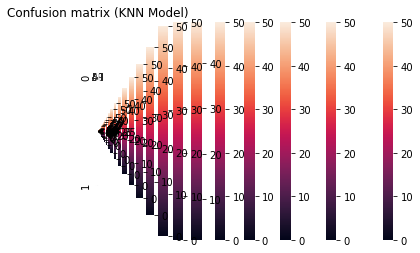

In [7]:
# Initialize variables to store results
shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    
    # Creating and running our optimization

    study_knn = optuna.create_study(direction='maximize',study_name = "KNN")
    with parallel_backend('threading'):
        study_knn.optimize(objective_knn, n_trials=10, n_jobs=-1)
    
    # Evaluating our Optuna Trial
    print("Best trial:", study_knn.best_trial.number)
    print("Best accuracy:", study_knn.best_trial.value)
    print("Best hyperparameters:", study_knn.best_params)
    
    best_param_knn = study_knn.best_params
    KNN = KNeighborsClassifier(**best_param_knn).fit(x_train_,y_train)
    y_pred_knn = KNN.predict(x_test_)

    

    display_results(y_test, y_pred_knn, cm_title = "Confusion matrix (KNN Model)")

    
    # SHAP value computation using parallel processing
    num_cores = -1  # Use all available cores
    shap_values = compute_shap_values(KNN, x_test_, num_cores)


    # Extract SHAP values
    shap_values_array = abs(shap_values)

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)



In [8]:
all_shap_values_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,0.017940,0.042298,0.013750,0.087750,0.022821,0.053964,0.013512,0.013607,0
1,0.004095,0.047976,0.009905,0.043167,0.064667,0.036214,0.006190,0.015976,0
2,0.004429,0.095262,0.002643,0.045143,0.092810,0.008262,0.005143,0.019548,0
3,0.001167,0.090262,0.002286,0.035405,0.088167,0.016119,0.007929,0.014429,0
4,0.018607,0.045393,0.006893,0.039893,0.050607,0.029655,0.006774,0.022179,0
...,...,...,...,...,...,...,...,...,...
4995,0.205583,0.020702,0.076631,0.008845,0.320417,0.007821,0.066202,0.131845,1
4996,0.057179,0.168512,0.000012,0.061964,0.353179,0.015155,0.004821,0.029179,1
4997,0.017833,0.109381,0.027381,0.019095,0.267071,0.000048,0.033714,0.282905,1
4998,0.139190,0.015071,0.017762,0.117952,0.050548,0.069762,0.221286,0.088571,1


# value stabilty

In [9]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]

In [10]:
# Call the add_to_df function to populate valuestability
add_to_df()
# Calculate the sum of each row
row_sums = valuestability.sum(axis=1)

# Calculate the number of columns
num_columns = valuestability.shape[1]

# Calculate the average
valstability = row_sums / num_columns

# Add the new column to the DataFrame
valuestability['valstability'] = valstability
# Save the DataFrame to an Excel file
valuestability.to_excel('20_knn_valuestability.xlsx', index=False)
valuestability


Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,valstability
0,0.670850,0.589955,1.367819,0.386007,0.914217,0.618942,0.844284,1.289807,0.835235
1,0.648682,0.117687,0.604496,0.443264,0.378284,0.207343,0.509132,0.577250,0.435767
2,0.627583,0.134544,0.694930,0.415600,0.301711,0.775487,0.428364,0.572078,0.493787
3,0.587390,0.146170,0.588724,0.420236,0.316964,0.538939,0.469626,0.605096,0.459143
4,0.249929,0.404220,0.361031,0.181467,0.298026,0.344637,0.808818,0.211715,0.357480
...,...,...,...,...,...,...,...,...,...
95,0.311195,0.936174,0.570679,0.633753,0.286625,0.335700,0.869358,0.779014,0.590312
96,0.134500,0.168743,0.891180,0.308444,0.125673,0.351117,0.664081,0.223877,0.358452
97,0.366604,0.295761,0.940697,0.707406,0.315521,0.737536,0.868175,0.278146,0.563731
98,0.236534,1.236132,0.766727,0.366654,0.651325,0.320080,0.311710,0.332712,0.527734


In [11]:
valuestability

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,valstability
0,0.670850,0.589955,1.367819,0.386007,0.914217,0.618942,0.844284,1.289807,0.835235
1,0.648682,0.117687,0.604496,0.443264,0.378284,0.207343,0.509132,0.577250,0.435767
2,0.627583,0.134544,0.694930,0.415600,0.301711,0.775487,0.428364,0.572078,0.493787
3,0.587390,0.146170,0.588724,0.420236,0.316964,0.538939,0.469626,0.605096,0.459143
4,0.249929,0.404220,0.361031,0.181467,0.298026,0.344637,0.808818,0.211715,0.357480
...,...,...,...,...,...,...,...,...,...
95,0.311195,0.936174,0.570679,0.633753,0.286625,0.335700,0.869358,0.779014,0.590312
96,0.134500,0.168743,0.891180,0.308444,0.125673,0.351117,0.664081,0.223877,0.358452
97,0.366604,0.295761,0.940697,0.707406,0.315521,0.737536,0.868175,0.278146,0.563731
98,0.236534,1.236132,0.766727,0.366654,0.651325,0.320080,0.311710,0.332712,0.527734


## 4.3 Logistic Regression

In [12]:
df = pd.read_csv("data_resampled_50.csv")

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def objective_lr(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }

    # Define hyperparameters
    param_logr = {
        'C': trial.suggest_float("C", 0.001, 10.0, log=True),
        'solver': trial.suggest_categorical('solver', ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]),
        'max_iter': trial.suggest_int("max_iter", 50, 1000),
        'class_weight': class_weight  # Apply custom class weights
    }

    # Create and train the model
    lr = LogisticRegression(**param_logr, random_state=42)
    
    # Evaluate the model using cross-validation with the f1_macro score to handle imbalance
    score = cross_val_score(lr, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score



In [14]:
# Initialize variables to store results
# Clear any existing elements in the lists if they were previously initialized

shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    
    # Creating and running our optimization
    
    # Creating and running our optimization

    study_lr = optuna.create_study(direction='maximize',study_name = "logr")
    with parallel_backend('threading'):
        study_lr.optimize(objective_lr, n_trials=10, n_jobs=-1)

    # Evaluating our Optuna Trial
    print("Best trial:", study_lr.best_trial.number)
    print("Best accuracy:", study_lr.best_trial.value)
    print("Best hyperparameters:", study_lr.best_params)

    # Train the model with the best parameters
    best_param_logr = study_lr.best_params
    LR = LogisticRegression(**best_param_logr, random_state=42).fit(x_train, y_train)


    
    # SHAP value computation using KernelExplainer
    explainer = shap.Explainer(LR, x_train_)
    shap_values = explainer(x_test_)


    # Extract SHAP values
    shap_values_array = abs(shap_values.values)

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)





[I 2024-08-26 16:59:08,277] A new study created in memory with name: logr
[I 2024-08-26 16:59:08,861] Trial 2 finished with value: 0.6981272095539113 and parameters: {'C': 0.0025334048237214348, 'solver': 'liblinear', 'max_iter': 669}. Best is trial 2 with value: 0.6981272095539113.
[I 2024-08-26 16:59:08,873] Trial 4 finished with value: 0.6978154811588495 and parameters: {'C': 0.0028884833515051968, 'solver': 'liblinear', 'max_iter': 211}. Best is trial 2 with value: 0.6981272095539113.
[I 2024-08-26 16:59:09,215] Trial 3 finished with value: 0.700410146773134 and parameters: {'C': 0.001489574518314271, 'solver': 'sag', 'max_iter': 75}. Best is trial 3 with value: 0.700410146773134.
[I 2024-08-26 16:59:09,374] Trial 7 finished with value: 0.7245840643001508 and parameters: {'C': 0.03225238231981035, 'solver': 'liblinear', 'max_iter': 490}. Best is trial 7 with value: 0.7245840643001508.
[I 2024-08-26 16:59:10,428] Trial 8 finished with value: 0.7028534716092025 and parameters: {'C': 

Best trial: 0
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 0.9572984378440174, 'solver': 'newton-cg', 'max_iter': 727}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020943  0.016353       0.000696       0.008356  0.001580  0.049232   
1      0.086310  0.006565       0.002161       0.098293  0.001439  0.015017   
2      0.086310  0.016353       0.012122       0.056322  0.008836  0.090867   
3      0.026516  0.005983       0.006531       0.050290  0.001697  0.031945   
4      0.077109  0.027228       0.008551       0.008356  0.011704  0.039416   
..          ...       ...            ...            ...       ...       ...   
95     0.240528  0.027149       0.007160       0.026344  0.000675  0.031079   
96     0.086310  0.053250       0.000019       0.069589  0.000373  0.086711   
97     0.118994  0.076089       0.002875       0.087576  0.006562  0.009969   
98     0.011741  0.028237       0.002875       0.020348  0.009860  0.048034

[I 2024-08-26 16:59:17,222] Trial 1 finished with value: 0.7678141672443403 and parameters: {'C': 0.15962767179031673, 'solver': 'liblinear', 'max_iter': 920}. Best is trial 1 with value: 0.7678141672443403.
[I 2024-08-26 16:59:17,264] Trial 2 finished with value: 0.7919760560173579 and parameters: {'C': 6.219617738200539, 'solver': 'liblinear', 'max_iter': 481}. Best is trial 2 with value: 0.7919760560173579.
[I 2024-08-26 16:59:18,150] Trial 7 finished with value: 0.7224641886859543 and parameters: {'C': 0.029074326051173653, 'solver': 'liblinear', 'max_iter': 195}. Best is trial 2 with value: 0.7919760560173579.
[I 2024-08-26 16:59:18,153] Trial 6 finished with value: 0.7801127335464733 and parameters: {'C': 0.6222772702153192, 'solver': 'liblinear', 'max_iter': 350}. Best is trial 2 with value: 0.7919760560173579.
[I 2024-08-26 16:59:20,267] Trial 4 finished with value: 0.7155125564436529 and parameters: {'C': 0.046199721871575616, 'solver': 'sag', 'max_iter': 893}. Best is trial 2

Best trial: 0
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 3.1593927308829715, 'solver': 'lbfgs', 'max_iter': 259}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021078  0.016378       0.000683       0.008351  0.001580  0.048977   
1      0.086869  0.006575       0.002123       0.098237  0.001439  0.014939   
2      0.086869  0.016378       0.011906       0.056291  0.008835  0.090396   
3      0.026688  0.005993       0.006414       0.050261  0.001697  0.031780   
4      0.077608  0.027271       0.008399       0.008351  0.011703  0.039212   
..          ...       ...            ...            ...       ...       ...   
95     0.242084  0.027191       0.007033       0.026329  0.000675  0.030918   
96     0.086869  0.053333       0.000018       0.069550  0.000373  0.086262   
97     0.119764  0.076207       0.002824       0.087527  0.006561  0.009917   
98     0.011817  0.028280       0.002824       0.020336  0.009859  0.047785   

[I 2024-08-26 16:59:28,113] Trial 2 finished with value: 0.7901429407382119 and parameters: {'C': 1.6240168643455235, 'solver': 'liblinear', 'max_iter': 324}. Best is trial 2 with value: 0.7901429407382119.
[I 2024-08-26 16:59:29,131] Trial 4 finished with value: 0.6981272095539113 and parameters: {'C': 0.0027020378314291916, 'solver': 'saga', 'max_iter': 233}. Best is trial 2 with value: 0.7901429407382119.
[I 2024-08-26 16:59:29,716] Trial 3 finished with value: 0.7028045522948007 and parameters: {'C': 0.1324023272423253, 'solver': 'sag', 'max_iter': 402}. Best is trial 2 with value: 0.7901429407382119.
[I 2024-08-26 16:59:29,761] Trial 7 finished with value: 0.699183065991494 and parameters: {'C': 0.0012296825567248, 'solver': 'liblinear', 'max_iter': 937}. Best is trial 2 with value: 0.7901429407382119.
[I 2024-08-26 16:59:30,094] Trial 5 finished with value: 0.705775114337872 and parameters: {'C': 0.44490846230060704, 'solver': 'sag', 'max_iter': 520}. Best is trial 2 with value: 

Best trial: 6
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 8.949863300514327, 'solver': 'newton-cg', 'max_iter': 652}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021123  0.016388       0.000679       0.008351  0.001580  0.048887   
1      0.087055  0.006579       0.002111       0.098238  0.001438  0.014912   
2      0.087055  0.016388       0.011841       0.056291  0.008834  0.090231   
3      0.026745  0.005996       0.006379       0.050262  0.001697  0.031721   
4      0.077774  0.027287       0.008353       0.008351  0.011702  0.039140   
..          ...       ...            ...            ...       ...       ...   
95     0.242604  0.027208       0.006994       0.026329  0.000675  0.030862   
96     0.087055  0.053365       0.000018       0.069550  0.000373  0.086104   
97     0.120021  0.076253       0.002809       0.087528  0.006561  0.009899   
98     0.011843  0.028297       0.002809       0.020336  0.009859  0.047698

[I 2024-08-26 16:59:37,410] Trial 4 finished with value: 0.696517317745646 and parameters: {'C': 0.05477882776900556, 'solver': 'sag', 'max_iter': 191}. Best is trial 4 with value: 0.696517317745646.
[I 2024-08-26 16:59:37,635] Trial 3 finished with value: 0.6959329587997477 and parameters: {'C': 0.006233119429643196, 'solver': 'saga', 'max_iter': 212}. Best is trial 4 with value: 0.696517317745646.
[I 2024-08-26 16:59:38,733] Trial 2 finished with value: 0.7091168295065132 and parameters: {'C': 0.008957721615931537, 'solver': 'sag', 'max_iter': 553}. Best is trial 2 with value: 0.7091168295065132.
[I 2024-08-26 16:59:40,100] Trial 0 finished with value: 0.7025058078056307 and parameters: {'C': 2.7787687384594637, 'solver': 'saga', 'max_iter': 818}. Best is trial 2 with value: 0.7091168295065132.
[I 2024-08-26 16:59:41,889] Trial 5 finished with value: 0.7795724604596787 and parameters: {'C': 0.10734759327010857, 'solver': 'lbfgs', 'max_iter': 84}. Best is trial 5 with value: 0.7795724

Best trial: 6
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.4872689496062856, 'solver': 'lbfgs', 'max_iter': 472}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021008  0.016365       0.000689       0.008355  0.001580  0.049096   
1      0.086581  0.006570       0.002139       0.098277  0.001439  0.014975   
2      0.086581  0.016365       0.012000       0.056313  0.008835  0.090615   
3      0.026599  0.005988       0.006465       0.050282  0.001697  0.031856   
4      0.077350  0.027249       0.008465       0.008355  0.011703  0.039307   
..          ...       ...            ...            ...       ...       ...   
95     0.241281  0.027169       0.007088       0.026339  0.000675  0.030993   
96     0.086581  0.053290       0.000018       0.069578  0.000373  0.086471   
97     0.119367  0.076145       0.002846       0.087563  0.006562  0.009941   
98     0.011778  0.028258       0.002846       0.020344  0.009859  0.047901   


[I 2024-08-26 16:59:47,276] Trial 4 finished with value: 0.7031379600832784 and parameters: {'C': 0.008213318812880606, 'solver': 'liblinear', 'max_iter': 175}. Best is trial 4 with value: 0.7031379600832784.
[I 2024-08-26 16:59:48,303] Trial 2 finished with value: 0.6955918797443664 and parameters: {'C': 0.0213055590554557, 'solver': 'saga', 'max_iter': 201}. Best is trial 4 with value: 0.7031379600832784.
[I 2024-08-26 16:59:48,372] Trial 5 finished with value: 0.698889725530559 and parameters: {'C': 3.3564229048762875, 'solver': 'sag', 'max_iter': 304}. Best is trial 4 with value: 0.7031379600832784.
[I 2024-08-26 16:59:48,614] Trial 1 finished with value: 0.7025058078056307 and parameters: {'C': 1.6906837439180311, 'solver': 'sag', 'max_iter': 400}. Best is trial 4 with value: 0.7031379600832784.
[I 2024-08-26 16:59:49,175] Trial 0 finished with value: 0.7092888794458923 and parameters: {'C': 0.004962186241642071, 'solver': 'sag', 'max_iter': 523}. Best is trial 0 with value: 0.709

Best trial: 3
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 8.34613445505776, 'solver': 'lbfgs', 'max_iter': 714}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021124  0.016390       0.000685       0.008350  0.001580  0.048941   
1      0.087056  0.006580       0.002128       0.098221  0.001438  0.014928   
2      0.087056  0.016390       0.011936       0.056281  0.008834  0.090329   
3      0.026745  0.005997       0.006430       0.050253  0.001697  0.031756   
4      0.077775  0.027290       0.008420       0.008350  0.011701  0.039183   
..          ...       ...            ...            ...       ...       ...   
95     0.242606  0.027210       0.007050       0.026324  0.000675  0.030895   
96     0.087056  0.053370       0.000018       0.069538  0.000373  0.086198   
97     0.120022  0.076260       0.002831       0.087513  0.006561  0.009910   
98     0.011843  0.028300       0.002831       0.020333  0.009858  0.047750   
9

[I 2024-08-26 16:59:54,236] Trial 5 finished with value: 0.6982814258302394 and parameters: {'C': 0.0021178438584001174, 'solver': 'liblinear', 'max_iter': 325}. Best is trial 5 with value: 0.6982814258302394.
[I 2024-08-26 16:59:54,849] Trial 2 finished with value: 0.6955295505749595 and parameters: {'C': 0.5773223007694114, 'solver': 'sag', 'max_iter': 148}. Best is trial 5 with value: 0.6982814258302394.
[I 2024-08-26 16:59:55,594] Trial 7 finished with value: 0.7237880141150572 and parameters: {'C': 0.034239021149872886, 'solver': 'liblinear', 'max_iter': 811}. Best is trial 7 with value: 0.7237880141150572.
[I 2024-08-26 16:59:56,880] Trial 0 finished with value: 0.7131022474385819 and parameters: {'C': 0.11491678445907233, 'solver': 'sag', 'max_iter': 749}. Best is trial 7 with value: 0.7237880141150572.
[I 2024-08-26 17:00:04,210] Trial 1 finished with value: 0.7881010446762367 and parameters: {'C': 0.03263005885493521, 'solver': 'lbfgs', 'max_iter': 458}. Best is trial 1 with v

Best trial: 3
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 4.490851971031633, 'solver': 'newton-cg', 'max_iter': 639}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021099  0.016383       0.000682       0.008352  0.001580  0.048931   
1      0.086953  0.006577       0.002118       0.098243  0.001438  0.014925   
2      0.086953  0.016383       0.011878       0.056294  0.008834  0.090312   
3      0.026713  0.005994       0.006399       0.050264  0.001697  0.031750   
4      0.077683  0.027278       0.008379       0.008352  0.011702  0.039176   
..          ...       ...            ...            ...       ...       ...   
95     0.242318  0.027199       0.007016       0.026330  0.000675  0.030890   
96     0.086953  0.053347       0.000018       0.069553  0.000373  0.086181   
97     0.119880  0.076228       0.002817       0.087532  0.006561  0.009908   
98     0.011829  0.028288       0.002817       0.020337  0.009858  0.047741

[I 2024-08-26 17:00:10,305] Trial 3 finished with value: 0.6987560221957516 and parameters: {'C': 0.0018159308513399492, 'solver': 'liblinear', 'max_iter': 145}. Best is trial 3 with value: 0.6987560221957516.
[I 2024-08-26 17:00:10,362] Trial 1 finished with value: 0.7868757762221474 and parameters: {'C': 0.8829501322753212, 'solver': 'liblinear', 'max_iter': 481}. Best is trial 1 with value: 0.7868757762221474.
[I 2024-08-26 17:00:10,909] Trial 0 finished with value: 0.6955295505749595 and parameters: {'C': 2.49035019901666, 'solver': 'sag', 'max_iter': 137}. Best is trial 1 with value: 0.7868757762221474.
[I 2024-08-26 17:00:10,913] Trial 2 finished with value: 0.6959215852407175 and parameters: {'C': 1.7048382795848542, 'solver': 'sag', 'max_iter': 153}. Best is trial 1 with value: 0.7868757762221474.
[I 2024-08-26 17:00:12,482] Trial 5 finished with value: 0.7018499531526525 and parameters: {'C': 0.0018701313283809307, 'solver': 'saga', 'max_iter': 795}. Best is trial 1 with value

Best trial: 4
Best accuracy: 0.7899729508429343
Best hyperparameters: {'C': 0.09283058918101299, 'solver': 'lbfgs', 'max_iter': 514}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020223  0.016321       0.000761       0.008413  0.001590  0.050870   
1      0.083344  0.006552       0.002366       0.098964  0.001447  0.015517   
2      0.083344  0.016321       0.013270       0.056707  0.008888  0.093889   
3      0.025605  0.005972       0.007149       0.050633  0.001707  0.033007   
4      0.074459  0.027176       0.009361       0.008413  0.011773  0.040727   
..          ...       ...            ...            ...       ...       ...   
95     0.232263  0.027097       0.007838       0.026523  0.000679  0.032113   
96     0.083344  0.053148       0.000020       0.070064  0.000375  0.089595   
97     0.114905  0.075942       0.003147       0.088174  0.006601  0.010300   
98     0.011338  0.028182       0.003147       0.020487  0.009918  0.049632  

[I 2024-08-26 17:00:17,586] Trial 4 finished with value: 0.7599773851659455 and parameters: {'C': 0.11906585604152764, 'solver': 'liblinear', 'max_iter': 969}. Best is trial 4 with value: 0.7599773851659455.
[I 2024-08-26 17:00:17,613] Trial 2 finished with value: 0.7922942933355951 and parameters: {'C': 7.27308028780081, 'solver': 'liblinear', 'max_iter': 303}. Best is trial 2 with value: 0.7922942933355951.
[I 2024-08-26 17:00:17,774] Trial 0 finished with value: 0.6952005874823037 and parameters: {'C': 2.7317339902907034, 'solver': 'saga', 'max_iter': 59}. Best is trial 2 with value: 0.7922942933355951.
[I 2024-08-26 17:00:19,254] Trial 7 finished with value: 0.6979951740536205 and parameters: {'C': 0.27590437991943584, 'solver': 'sag', 'max_iter': 282}. Best is trial 2 with value: 0.7922942933355951.
[I 2024-08-26 17:00:19,392] Trial 6 finished with value: 0.7023612411829779 and parameters: {'C': 0.009070095009563982, 'solver': 'sag', 'max_iter': 320}. Best is trial 2 with value: 0

Best trial: 2
Best accuracy: 0.7922942933355951
Best hyperparameters: {'C': 7.27308028780081, 'solver': 'liblinear', 'max_iter': 303}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020465  0.015027       0.001711       0.007608  0.001500  0.040906   
1      0.084342  0.006033       0.005317       0.089496  0.001366  0.012477   
2      0.084342  0.015027       0.029824       0.051282  0.008386  0.075500   
3      0.025911  0.005498       0.016068       0.045789  0.001611  0.026542   
4      0.075350  0.025020       0.021039       0.007608  0.011108  0.032750   
..          ...       ...            ...            ...       ...       ...   
95     0.235043  0.024947       0.017616       0.023986  0.000640  0.025823   
96     0.084342  0.048931       0.000046       0.063361  0.000354  0.072047   
97     0.116280  0.069918       0.007074       0.079739  0.006228  0.008283   
98     0.011473  0.025946       0.007074       0.018527  0.009358  0.039911 

[I 2024-08-26 17:00:25,173] Trial 3 finished with value: 0.7055782068218638 and parameters: {'C': 0.0022416294705707874, 'solver': 'sag', 'max_iter': 777}. Best is trial 3 with value: 0.7055782068218638.
[I 2024-08-26 17:00:26,427] Trial 2 finished with value: 0.7111832442271548 and parameters: {'C': 0.016990138384699267, 'solver': 'sag', 'max_iter': 680}. Best is trial 2 with value: 0.7111832442271548.
[I 2024-08-26 17:00:26,478] Trial 6 finished with value: 0.6951310893769691 and parameters: {'C': 0.06413904519826244, 'solver': 'sag', 'max_iter': 97}. Best is trial 2 with value: 0.7111832442271548.
[I 2024-08-26 17:00:27,386] Trial 8 finished with value: 0.6981272095539113 and parameters: {'C': 0.002748777132192695, 'solver': 'liblinear', 'max_iter': 169}. Best is trial 2 with value: 0.7111832442271548.
[I 2024-08-26 17:00:31,488] Trial 9 finished with value: 0.7187747701914755 and parameters: {'C': 0.022306726515654855, 'solver': 'sag', 'max_iter': 938}. Best is trial 9 with value: 

Best trial: 7
Best accuracy: 0.7944000310009028
Best hyperparameters: {'C': 0.6281218999525918, 'solver': 'newton-cg', 'max_iter': 81}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020860  0.016340       0.000703       0.008360  0.001581  0.049409   
1      0.085969  0.006560       0.002186       0.098336  0.001439  0.015071   
2      0.085969  0.016340       0.012259       0.056347  0.008838  0.091193   
3      0.026411  0.005979       0.006605       0.050312  0.001698  0.032060   
4      0.076804  0.027207       0.008648       0.008360  0.011707  0.039558   
..          ...       ...            ...            ...       ...       ...   
95     0.239577  0.027128       0.007241       0.026355  0.000675  0.031191   
96     0.085969  0.053209       0.000019       0.069620  0.000373  0.087022   
97     0.118524  0.076030       0.002908       0.087615  0.006564  0.010005   
98     0.011695  0.028215       0.002908       0.020357  0.009863  0.048207

[I 2024-08-26 17:00:37,088] Trial 5 finished with value: 0.7919725832569625 and parameters: {'C': 5.441248208879674, 'solver': 'liblinear', 'max_iter': 249}. Best is trial 5 with value: 0.7919725832569625.
[I 2024-08-26 17:00:37,744] Trial 0 finished with value: 0.7013981573520428 and parameters: {'C': 0.0012217311743577676, 'solver': 'sag', 'max_iter': 197}. Best is trial 5 with value: 0.7919725832569625.
[I 2024-08-26 17:00:37,899] Trial 4 finished with value: 0.7005964333800221 and parameters: {'C': 0.0032009141221248437, 'solver': 'sag', 'max_iter': 221}. Best is trial 5 with value: 0.7919725832569625.
[I 2024-08-26 17:00:39,148] Trial 2 finished with value: 0.6984952438307989 and parameters: {'C': 0.07929812724784245, 'solver': 'saga', 'max_iter': 545}. Best is trial 5 with value: 0.7919725832569625.
[I 2024-08-26 17:00:39,207] Trial 6 finished with value: 0.6962154726240357 and parameters: {'C': 0.18453640528328558, 'solver': 'saga', 'max_iter': 348}. Best is trial 5 with value: 

Best trial: 3
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 3.0980219614470137, 'solver': 'newton-cg', 'max_iter': 777}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021077  0.016378       0.000683       0.008352  0.001580  0.048970   
1      0.086864  0.006575       0.002123       0.098247  0.001438  0.014937   
2      0.086864  0.016378       0.011911       0.056296  0.008834  0.090384   
3      0.026686  0.005993       0.006417       0.050266  0.001697  0.031775   
4      0.077603  0.027271       0.008402       0.008352  0.011702  0.039207   
..          ...       ...            ...            ...       ...       ...   
95     0.242071  0.027191       0.007035       0.026331  0.000675  0.030914   
96     0.086864  0.053333       0.000018       0.069557  0.000373  0.086250   
97     0.119757  0.076206       0.002825       0.087536  0.006561  0.009916   
98     0.011817  0.028280       0.002825       0.020338  0.009858  0.04777

[I 2024-08-26 17:00:47,969] Trial 3 finished with value: 0.697487316262228 and parameters: {'C': 0.0022620348491442384, 'solver': 'sag', 'max_iter': 65}. Best is trial 3 with value: 0.697487316262228.
[I 2024-08-26 17:00:49,612] Trial 0 finished with value: 0.7109765271936125 and parameters: {'C': 0.0038457810340829708, 'solver': 'sag', 'max_iter': 893}. Best is trial 0 with value: 0.7109765271936125.
[I 2024-08-26 17:00:51,820] Trial 7 finished with value: 0.700586966470385 and parameters: {'C': 0.0028764046345239117, 'solver': 'saga', 'max_iter': 357}. Best is trial 0 with value: 0.7109765271936125.
[I 2024-08-26 17:00:58,159] Trial 4 finished with value: 0.7861753392220787 and parameters: {'C': 0.007396973242755888, 'solver': 'lbfgs', 'max_iter': 221}. Best is trial 4 with value: 0.7861753392220787.
[I 2024-08-26 17:00:58,840] Trial 5 finished with value: 0.7928414444506428 and parameters: {'C': 0.13272880231034517, 'solver': 'lbfgs', 'max_iter': 495}. Best is trial 5 with value: 0.

Best trial: 5
Best accuracy: 0.7928414444506428
Best hyperparameters: {'C': 0.13272880231034517, 'solver': 'lbfgs', 'max_iter': 495}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020371  0.016317       0.000749       0.008398  0.001587  0.050564   
1      0.083953  0.006551       0.002326       0.098790  0.001445  0.015423   
2      0.083953  0.016317       0.013047       0.056607  0.008872  0.093325   
3      0.025792  0.005970       0.007029       0.050544  0.001704  0.032809   
4      0.075003  0.027169       0.009203       0.008398  0.011752  0.040483   
..          ...       ...            ...            ...       ...       ...   
95     0.233960  0.027089       0.007706       0.026477  0.000677  0.031920   
96     0.083953  0.053133       0.000020       0.069941  0.000374  0.089057   
97     0.115745  0.075922       0.003094       0.088020  0.006589  0.010238   
98     0.011421  0.028175       0.003094       0.020451  0.009901  0.049333  

[I 2024-08-26 17:01:04,694] Trial 2 finished with value: 0.7875423349673752 and parameters: {'C': 0.94752182060608, 'solver': 'liblinear', 'max_iter': 814}. Best is trial 2 with value: 0.7875423349673752.
[I 2024-08-26 17:01:04,751] Trial 0 finished with value: 0.7210652695234482 and parameters: {'C': 0.02782709830120571, 'solver': 'liblinear', 'max_iter': 52}. Best is trial 2 with value: 0.7875423349673752.
[I 2024-08-26 17:01:05,651] Trial 6 finished with value: 0.7919760560173579 and parameters: {'C': 6.16311055895344, 'solver': 'liblinear', 'max_iter': 220}. Best is trial 6 with value: 0.7919760560173579.
[I 2024-08-26 17:01:06,519] Trial 7 finished with value: 0.6981974070804202 and parameters: {'C': 2.2602803877061315, 'solver': 'sag', 'max_iter': 241}. Best is trial 6 with value: 0.7919760560173579.
[I 2024-08-26 17:01:07,403] Trial 9 finished with value: 0.7901375276732729 and parameters: {'C': 2.383194627837277, 'solver': 'liblinear', 'max_iter': 915}. Best is trial 6 with val

Best trial: 5
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.0647782611546126, 'solver': 'newton-cg', 'max_iter': 876}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020960  0.016356       0.000694       0.008355  0.001580  0.049196   
1      0.086383  0.006566       0.002156       0.098285  0.001439  0.015006   
2      0.086383  0.016356       0.012094       0.056318  0.008835  0.090800   
3      0.026538  0.005985       0.006515       0.050286  0.001697  0.031921   
4      0.077174  0.027233       0.008531       0.008355  0.011704  0.039387   
..          ...       ...            ...            ...       ...       ...   
95     0.240730  0.027154       0.007143       0.026341  0.000675  0.031056   
96     0.086383  0.053260       0.000019       0.069584  0.000373  0.086647   
97     0.119094  0.076103       0.002868       0.087570  0.006562  0.009961   
98     0.011751  0.028242       0.002868       0.020346  0.009860  0.047999

[I 2024-08-26 17:01:16,413] Trial 2 finished with value: 0.6982930108039992 and parameters: {'C': 1.4059566157541343, 'solver': 'sag', 'max_iter': 287}. Best is trial 2 with value: 0.6982930108039992.
[I 2024-08-26 17:01:17,932] Trial 6 finished with value: 0.6955918797443664 and parameters: {'C': 0.25632374858009266, 'solver': 'saga', 'max_iter': 147}. Best is trial 2 with value: 0.6982930108039992.
[I 2024-08-26 17:01:17,971] Trial 3 finished with value: 0.711792126854535 and parameters: {'C': 0.06310403149405634, 'solver': 'sag', 'max_iter': 729}. Best is trial 3 with value: 0.711792126854535.
[I 2024-08-26 17:01:18,996] Trial 7 finished with value: 0.7669568531441976 and parameters: {'C': 0.14545067252708557, 'solver': 'liblinear', 'max_iter': 539}. Best is trial 7 with value: 0.7669568531441976.
[I 2024-08-26 17:01:18,999] Trial 8 finished with value: 0.7062338033119303 and parameters: {'C': 0.011883492493242588, 'solver': 'liblinear', 'max_iter': 909}. Best is trial 7 with value:

Best trial: 0
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 6.502915212878206, 'solver': 'lbfgs', 'max_iter': 821}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021124  0.016381       0.000678       0.008358  0.001580  0.048868   
1      0.087059  0.006576       0.002107       0.098311  0.001439  0.014906   
2      0.087059  0.016381       0.011822       0.056333  0.008835  0.090194   
3      0.026746  0.005994       0.006369       0.050299  0.001697  0.031709   
4      0.077778  0.027276       0.008339       0.008358  0.011702  0.039125   
..          ...       ...            ...            ...       ...       ...   
95     0.242615  0.027196       0.006983       0.026348  0.000675  0.030849   
96     0.087059  0.053343       0.000018       0.069602  0.000373  0.086069   
97     0.120027  0.076222       0.002804       0.087593  0.006561  0.009895   
98     0.011843  0.028286       0.002804       0.020351  0.009859  0.047679   


[I 2024-08-26 17:01:29,540] Trial 3 finished with value: 0.7903823825519676 and parameters: {'C': 3.3192838174115322, 'solver': 'liblinear', 'max_iter': 950}. Best is trial 3 with value: 0.7903823825519676.
[I 2024-08-26 17:01:29,559] Trial 1 finished with value: 0.7711008587980891 and parameters: {'C': 0.28045537898445017, 'solver': 'liblinear', 'max_iter': 636}. Best is trial 3 with value: 0.7903823825519676.
[I 2024-08-26 17:01:31,849] Trial 6 finished with value: 0.6970128154893003 and parameters: {'C': 0.02242142689820125, 'solver': 'saga', 'max_iter': 306}. Best is trial 3 with value: 0.7903823825519676.
[I 2024-08-26 17:01:31,872] Trial 7 finished with value: 0.7014831994438149 and parameters: {'C': 6.478359609641902, 'solver': 'sag', 'max_iter': 354}. Best is trial 3 with value: 0.7903823825519676.
[I 2024-08-26 17:01:32,702] Trial 8 finished with value: 0.6985803270843378 and parameters: {'C': 0.004170992833112349, 'solver': 'liblinear', 'max_iter': 855}. Best is trial 3 with 

Best trial: 2
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 2.4883076947117253, 'solver': 'lbfgs', 'max_iter': 195}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021071  0.016376       0.000688       0.008355  0.001580  0.049014   
1      0.086838  0.006574       0.002138       0.098281  0.001438  0.014951   
2      0.086838  0.016376       0.011991       0.056316  0.008833  0.090465   
3      0.026678  0.005992       0.006460       0.050284  0.001697  0.031804   
4      0.077581  0.027266       0.008459       0.008355  0.011700  0.039242   
..          ...       ...            ...            ...       ...       ...   
95     0.242000  0.027187       0.007083       0.026340  0.000674  0.030942   
96     0.086838  0.053324       0.000018       0.069581  0.000373  0.086327   
97     0.119722  0.076195       0.002844       0.087566  0.006560  0.009925   
98     0.011813  0.028276       0.002844       0.020345  0.009856  0.047822   

[I 2024-08-26 17:01:41,581] Trial 2 finished with value: 0.7407429461521964 and parameters: {'C': 0.05629649085042471, 'solver': 'liblinear', 'max_iter': 209}. Best is trial 2 with value: 0.7407429461521964.
[I 2024-08-26 17:01:41,987] Trial 0 finished with value: 0.6956027649850033 and parameters: {'C': 0.46120632424299496, 'solver': 'saga', 'max_iter': 95}. Best is trial 2 with value: 0.7407429461521964.
[I 2024-08-26 17:01:42,774] Trial 1 finished with value: 0.7003571170371811 and parameters: {'C': 6.269028186988315, 'solver': 'sag', 'max_iter': 331}. Best is trial 2 with value: 0.7407429461521964.
[I 2024-08-26 17:01:43,602] Trial 8 finished with value: 0.6985803270843378 and parameters: {'C': 0.004557992540393211, 'solver': 'liblinear', 'max_iter': 137}. Best is trial 2 with value: 0.7407429461521964.
[I 2024-08-26 17:01:44,223] Trial 6 finished with value: 0.696922438894905 and parameters: {'C': 0.19336431102445037, 'solver': 'saga', 'max_iter': 445}. Best is trial 2 with value:

Best trial: 4
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.1654469195836994, 'solver': 'newton-cg', 'max_iter': 124}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020974  0.016358       0.000693       0.008355  0.001580  0.049168   
1      0.086440  0.006567       0.002152       0.098280  0.001439  0.014997   
2      0.086440  0.016358       0.012071       0.056315  0.008835  0.090748   
3      0.026556  0.005985       0.006503       0.050283  0.001697  0.031903   
4      0.077225  0.027238       0.008515       0.008355  0.011703  0.039365   
..          ...       ...            ...            ...       ...       ...   
95     0.240891  0.027158       0.007130       0.026340  0.000675  0.031039   
96     0.086440  0.053268       0.000018       0.069580  0.000373  0.086597   
97     0.119174  0.076114       0.002863       0.087565  0.006562  0.009956   
98     0.011759  0.028246       0.002863       0.020345  0.009859  0.047971

[I 2024-08-26 17:01:52,407] Trial 1 finished with value: 0.6948611444397167 and parameters: {'C': 2.151352013071273, 'solver': 'saga', 'max_iter': 69}. Best is trial 1 with value: 0.6948611444397167.
[I 2024-08-26 17:01:53,960] Trial 0 finished with value: 0.7029504701153678 and parameters: {'C': 0.8585152639852611, 'solver': 'sag', 'max_iter': 435}. Best is trial 0 with value: 0.7029504701153678.
[I 2024-08-26 17:01:53,966] Trial 6 finished with value: 0.6955918797443664 and parameters: {'C': 8.378031290636432, 'solver': 'saga', 'max_iter': 148}. Best is trial 0 with value: 0.7029504701153678.
[I 2024-08-26 17:01:54,774] Trial 5 finished with value: 0.698889725530559 and parameters: {'C': 0.09505082841913631, 'solver': 'saga', 'max_iter': 609}. Best is trial 0 with value: 0.7029504701153678.
[I 2024-08-26 17:01:54,858] Trial 8 finished with value: 0.7797492978656365 and parameters: {'C': 0.5689674983360763, 'solver': 'liblinear', 'max_iter': 77}. Best is trial 8 with value: 0.77974929

Best trial: 7
Best accuracy: 0.79442522032046
Best hyperparameters: {'C': 0.2600749966249114, 'solver': 'lbfgs', 'max_iter': 649}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020621  0.016319       0.000728       0.008374  0.001583  0.049981   
1      0.084986  0.006551       0.002262       0.098502  0.001441  0.015245   
2      0.084986  0.016319       0.012686       0.056442  0.008851  0.092249   
3      0.026109  0.005971       0.006834       0.050397  0.001700  0.032431   
4      0.075926  0.027171       0.008949       0.008374  0.011724  0.040016   
..          ...       ...            ...            ...       ...       ...   
95     0.236839  0.027092       0.007493       0.026399  0.000676  0.031552   
96     0.084986  0.053139       0.000019       0.069737  0.000373  0.088030   
97     0.117169  0.075930       0.003009       0.087762  0.006573  0.010120   
98     0.011561  0.028178       0.003009       0.020391  0.009877  0.048765   
9

[I 2024-08-26 17:02:02,447] Trial 2 finished with value: 0.7911217312795366 and parameters: {'C': 2.51217784133362, 'solver': 'liblinear', 'max_iter': 846}. Best is trial 2 with value: 0.7911217312795366.
[I 2024-08-26 17:02:04,109] Trial 0 finished with value: 0.7064625865284256 and parameters: {'C': 0.010179320147411287, 'solver': 'sag', 'max_iter': 443}. Best is trial 2 with value: 0.7911217312795366.
[I 2024-08-26 17:02:04,677] Trial 1 finished with value: 0.7058751406296063 and parameters: {'C': 0.6566822625451405, 'solver': 'sag', 'max_iter': 572}. Best is trial 2 with value: 0.7911217312795366.
[I 2024-08-26 17:02:05,148] Trial 6 finished with value: 0.708029647700136 and parameters: {'C': 0.026643182721985514, 'solver': 'sag', 'max_iter': 557}. Best is trial 2 with value: 0.7911217312795366.
[I 2024-08-26 17:02:05,236] Trial 8 finished with value: 0.7378010384975827 and parameters: {'C': 0.05275477907135389, 'solver': 'liblinear', 'max_iter': 788}. Best is trial 2 with value: 0

Best trial: 9
Best accuracy: 0.7936107067577508
Best hyperparameters: {'C': 0.23918057153559594, 'solver': 'lbfgs', 'max_iter': 951}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020597  0.016314       0.000729       0.008379  0.001584  0.050039   
1      0.084884  0.006549       0.002265       0.098563  0.001442  0.015263   
2      0.084884  0.016314       0.012706       0.056477  0.008854  0.092356   
3      0.026078  0.005969       0.006845       0.050428  0.001701  0.032469   
4      0.075835  0.027164       0.008963       0.008379  0.011728  0.040062   
..          ...       ...            ...            ...       ...       ...   
95     0.236554  0.027084       0.007505       0.026416  0.000676  0.031589   
96     0.084884  0.053124       0.000019       0.069780  0.000374  0.088132   
97     0.117028  0.075908       0.003014       0.087817  0.006575  0.010132   
98     0.011547  0.028169       0.003014       0.020404  0.009880  0.048821  

[I 2024-08-26 17:02:11,631] Trial 5 finished with value: 0.7155696717709711 and parameters: {'C': 0.023027027058018075, 'solver': 'liblinear', 'max_iter': 418}. Best is trial 5 with value: 0.7155696717709711.
[I 2024-08-26 17:02:12,727] Trial 0 finished with value: 0.6955295505749595 and parameters: {'C': 0.1639888459309652, 'solver': 'saga', 'max_iter': 248}. Best is trial 5 with value: 0.7155696717709711.
[I 2024-08-26 17:02:13,719] Trial 3 finished with value: 0.706729536234002 and parameters: {'C': 1.066967616453849, 'solver': 'sag', 'max_iter': 534}. Best is trial 5 with value: 0.7155696717709711.
[I 2024-08-26 17:02:13,942] Trial 1 finished with value: 0.7058751406296063 and parameters: {'C': 0.7797973925577303, 'solver': 'sag', 'max_iter': 589}. Best is trial 5 with value: 0.7155696717709711.
[I 2024-08-26 17:02:14,020] Trial 6 finished with value: 0.696517317745646 and parameters: {'C': 1.4974441774710248, 'solver': 'saga', 'max_iter': 388}. Best is trial 5 with value: 0.715569

Best trial: 9
Best accuracy: 0.7944000310009028
Best hyperparameters: {'C': 0.6186454464522214, 'solver': 'newton-cg', 'max_iter': 704}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020856  0.016340       0.000704       0.008360  0.001581  0.049417   
1      0.085955  0.006560       0.002187       0.098338  0.001439  0.015073   
2      0.085955  0.016340       0.012265       0.056348  0.008838  0.091207   
3      0.026407  0.005979       0.006608       0.050313  0.001698  0.032065   
4      0.076792  0.027206       0.008652       0.008360  0.011707  0.039564   
..          ...       ...            ...            ...       ...       ...   
95     0.239538  0.027127       0.007245       0.026356  0.000675  0.031196   
96     0.085955  0.053207       0.000019       0.069621  0.000373  0.087036   
97     0.118504  0.076028       0.002909       0.087617  0.006564  0.010006   
98     0.011693  0.028214       0.002909       0.020357  0.009863  0.04821

[I 2024-08-26 17:02:20,952] Trial 0 finished with value: 0.7010204881935225 and parameters: {'C': 0.0012636605076896768, 'solver': 'sag', 'max_iter': 732}. Best is trial 0 with value: 0.7010204881935225.
[I 2024-08-26 17:02:21,353] Trial 3 finished with value: 0.6958458519025298 and parameters: {'C': 0.7300480333567211, 'solver': 'saga', 'max_iter': 219}. Best is trial 0 with value: 0.7010204881935225.
[I 2024-08-26 17:02:23,148] Trial 7 finished with value: 0.700837168001821 and parameters: {'C': 0.0011294169734178702, 'solver': 'saga', 'max_iter': 510}. Best is trial 0 with value: 0.7010204881935225.
[I 2024-08-26 17:02:23,291] Trial 4 finished with value: 0.7018569944467659 and parameters: {'C': 0.2525125777874202, 'solver': 'saga', 'max_iter': 714}. Best is trial 4 with value: 0.7018569944467659.
[I 2024-08-26 17:02:23,372] Trial 5 finished with value: 0.7166481410858911 and parameters: {'C': 0.020655141280307286, 'solver': 'sag', 'max_iter': 813}. Best is trial 5 with value: 0.716

Best trial: 1
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.0993483681688054, 'solver': 'newton-cg', 'max_iter': 679}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020965  0.016357       0.000694       0.008355  0.001580  0.049186   
1      0.086404  0.006567       0.002155       0.098283  0.001439  0.015003   
2      0.086404  0.016357       0.012086       0.056317  0.008835  0.090781   
3      0.026545  0.005985       0.006511       0.050285  0.001697  0.031915   
4      0.077192  0.027235       0.008526       0.008355  0.011703  0.039379   
..          ...       ...            ...            ...       ...       ...   
95     0.240788  0.027156       0.007139       0.026341  0.000675  0.031050   
96     0.086404  0.053263       0.000019       0.069582  0.000373  0.086629   
97     0.119123  0.076107       0.002867       0.087568  0.006562  0.009959   
98     0.011754  0.028243       0.002867       0.020346  0.009860  0.047989

[I 2024-08-26 17:02:31,639] Trial 0 finished with value: 0.7785186446220506 and parameters: {'C': 0.36990545509749817, 'solver': 'liblinear', 'max_iter': 988}. Best is trial 0 with value: 0.7785186446220506.
[I 2024-08-26 17:02:32,611] Trial 3 finished with value: 0.7034281086212012 and parameters: {'C': 0.0026305301953616603, 'solver': 'sag', 'max_iter': 267}. Best is trial 0 with value: 0.7785186446220506.
[I 2024-08-26 17:02:34,989] Trial 4 finished with value: 0.7034081754907632 and parameters: {'C': 0.026089072477432817, 'solver': 'saga', 'max_iter': 851}. Best is trial 0 with value: 0.7785186446220506.
[I 2024-08-26 17:02:35,099] Trial 6 finished with value: 0.7127997418697477 and parameters: {'C': 0.8224443481905088, 'solver': 'sag', 'max_iter': 745}. Best is trial 0 with value: 0.7785186446220506.
[I 2024-08-26 17:02:36,391] Trial 8 finished with value: 0.696517317745646 and parameters: {'C': 0.03403792819967305, 'solver': 'sag', 'max_iter': 191}. Best is trial 0 with value: 0.

Best trial: 2
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 4.359048450054785, 'solver': 'lbfgs', 'max_iter': 186}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021086  0.016382       0.000683       0.008354  0.001580  0.048935   
1      0.086901  0.006577       0.002121       0.098265  0.001439  0.014926   
2      0.086901  0.016382       0.011896       0.056306  0.008835  0.090318   
3      0.026697  0.005994       0.006409       0.050276  0.001697  0.031752   
4      0.077637  0.027277       0.008392       0.008354  0.011702  0.039178   
..          ...       ...            ...            ...       ...       ...   
95     0.242174  0.027198       0.007027       0.026336  0.000675  0.030892   
96     0.086901  0.053346       0.000018       0.069569  0.000373  0.086187   
97     0.119809  0.076226       0.002822       0.087552  0.006561  0.009909   
98     0.011822  0.028287       0.002822       0.020342  0.009859  0.047744   


[I 2024-08-26 17:02:43,047] Trial 1 finished with value: 0.7562489802285401 and parameters: {'C': 0.1022926383717401, 'solver': 'liblinear', 'max_iter': 413}. Best is trial 1 with value: 0.7562489802285401.
[I 2024-08-26 17:02:43,071] Trial 0 finished with value: 0.6989741835645323 and parameters: {'C': 0.0016975006807290478, 'solver': 'liblinear', 'max_iter': 960}. Best is trial 1 with value: 0.7562489802285401.
[I 2024-08-26 17:02:45,884] Trial 4 finished with value: 0.7024453681153744 and parameters: {'C': 0.07052275988078116, 'solver': 'saga', 'max_iter': 745}. Best is trial 1 with value: 0.7562489802285401.
[I 2024-08-26 17:02:46,129] Trial 7 finished with value: 0.6984952438307989 and parameters: {'C': 0.028827468517390594, 'solver': 'saga', 'max_iter': 553}. Best is trial 1 with value: 0.7562489802285401.
[I 2024-08-26 17:02:50,472] Trial 8 finished with value: 0.7053276073847934 and parameters: {'C': 0.02479491095897246, 'solver': 'saga', 'max_iter': 970}. Best is trial 1 with 

Best trial: 5
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 7.933701612875522, 'solver': 'newton-cg', 'max_iter': 856}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021120  0.016387       0.000680       0.008352  0.001580  0.048893   
1      0.087042  0.006579       0.002112       0.098239  0.001438  0.014914   
2      0.087042  0.016387       0.011846       0.056291  0.008834  0.090241   
3      0.026741  0.005996       0.006382       0.050262  0.001697  0.031725   
4      0.077762  0.027286       0.008357       0.008352  0.011702  0.039145   
..          ...       ...            ...            ...       ...       ...   
95     0.242566  0.027206       0.006997       0.026329  0.000675  0.030865   
96     0.087042  0.053363       0.000018       0.069551  0.000373  0.086114   
97     0.120003  0.076249       0.002810       0.087528  0.006561  0.009900   
98     0.011841  0.028296       0.002810       0.020336  0.009859  0.047703

[I 2024-08-26 17:02:54,440] Trial 1 finished with value: 0.6982814258302394 and parameters: {'C': 0.0021667118795463706, 'solver': 'liblinear', 'max_iter': 464}. Best is trial 1 with value: 0.6982814258302394.
[I 2024-08-26 17:02:54,469] Trial 2 finished with value: 0.7568163293555211 and parameters: {'C': 0.10821479195421052, 'solver': 'liblinear', 'max_iter': 130}. Best is trial 2 with value: 0.7568163293555211.
[I 2024-08-26 17:02:54,690] Trial 4 finished with value: 0.6978261055089128 and parameters: {'C': 0.0014037460790232226, 'solver': 'saga', 'max_iter': 83}. Best is trial 2 with value: 0.7568163293555211.
[I 2024-08-26 17:02:57,317] Trial 6 finished with value: 0.706729536234002 and parameters: {'C': 0.14580440617853152, 'solver': 'sag', 'max_iter': 536}. Best is trial 2 with value: 0.7568163293555211.
[I 2024-08-26 17:02:57,905] Trial 3 finished with value: 0.7178614953887498 and parameters: {'C': 1.025074864101701, 'solver': 'sag', 'max_iter': 980}. Best is trial 2 with valu

Best trial: 8
Best accuracy: 0.7947170551372086
Best hyperparameters: {'C': 0.28138182872335626, 'solver': 'newton-cg', 'max_iter': 666}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020643  0.016319       0.000725       0.008374  0.001583  0.049919   
1      0.085077  0.006551       0.002252       0.098503  0.001441  0.015227   
2      0.085077  0.016319       0.012633       0.056443  0.008850  0.092135   
3      0.026137  0.005971       0.006806       0.050398  0.001700  0.032391   
4      0.076007  0.027172       0.008911       0.008374  0.011722  0.039966   
..          ...       ...            ...            ...       ...       ...   
95     0.237091  0.027092       0.007462       0.026400  0.000676  0.031513   
96     0.085077  0.053139       0.000019       0.069738  0.000373  0.087921   
97     0.117294  0.075930       0.002996       0.087764  0.006572  0.010108   
98     0.011573  0.028178       0.002996       0.020391  0.009876  0.0487

[I 2024-08-26 17:03:07,896] Trial 2 finished with value: 0.7720023713476629 and parameters: {'C': 0.18931424328432248, 'solver': 'liblinear', 'max_iter': 766}. Best is trial 2 with value: 0.7720023713476629.
[I 2024-08-26 17:03:07,967] Trial 0 finished with value: 0.7837416688102543 and parameters: {'C': 0.7950192814950183, 'solver': 'liblinear', 'max_iter': 143}. Best is trial 0 with value: 0.7837416688102543.
[I 2024-08-26 17:03:08,679] Trial 4 finished with value: 0.7009713177106882 and parameters: {'C': 0.0022544454132917844, 'solver': 'sag', 'max_iter': 188}. Best is trial 0 with value: 0.7837416688102543.
[I 2024-08-26 17:03:08,998] Trial 5 finished with value: 0.6955295505749595 and parameters: {'C': 2.5533007134831323, 'solver': 'saga', 'max_iter': 266}. Best is trial 0 with value: 0.7837416688102543.
[I 2024-08-26 17:03:11,100] Trial 3 finished with value: 0.7140488988140025 and parameters: {'C': 0.8057281603014156, 'solver': 'sag', 'max_iter': 862}. Best is trial 0 with value

Best trial: 8
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 0.9773573892727896, 'solver': 'lbfgs', 'max_iter': 565}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020939  0.016352       0.000695       0.008353  0.001580  0.049221   
1      0.086295  0.006565       0.002160       0.098256  0.001439  0.015014   
2      0.086295  0.016352       0.012118       0.056301  0.008836  0.090847   
3      0.026511  0.005983       0.006528       0.050271  0.001697  0.031938   
4      0.077095  0.027227       0.008548       0.008353  0.011704  0.039408   
..          ...       ...            ...            ...       ...       ...   
95     0.240485  0.027148       0.007158       0.026334  0.000675  0.031072   
96     0.086295  0.053248       0.000019       0.069563  0.000373  0.086692   
97     0.118973  0.076086       0.002874       0.087544  0.006562  0.009967   
98     0.011739  0.028235       0.002874       0.020340  0.009860  0.048023   


[I 2024-08-26 17:03:16,703] Trial 5 finished with value: 0.7911705039881254 and parameters: {'C': 3.9759572997475434, 'solver': 'liblinear', 'max_iter': 844}. Best is trial 5 with value: 0.7911705039881254.
[I 2024-08-26 17:03:17,211] Trial 0 finished with value: 0.6955082906923074 and parameters: {'C': 0.04921462257685374, 'solver': 'saga', 'max_iter': 131}. Best is trial 5 with value: 0.7911705039881254.
[I 2024-08-26 17:03:17,233] Trial 4 finished with value: 0.7019908717821185 and parameters: {'C': 0.0010058896190032532, 'solver': 'sag', 'max_iter': 143}. Best is trial 5 with value: 0.7911705039881254.
[I 2024-08-26 17:03:17,317] Trial 2 finished with value: 0.6955918797443664 and parameters: {'C': 6.984389091924533, 'solver': 'saga', 'max_iter': 141}. Best is trial 5 with value: 0.7911705039881254.
[I 2024-08-26 17:03:17,403] Trial 3 finished with value: 0.7010204881935225 and parameters: {'C': 0.0012326033136240897, 'solver': 'sag', 'max_iter': 835}. Best is trial 5 with value: 0

Best trial: 5
Best accuracy: 0.7911705039881254
Best hyperparameters: {'C': 3.9759572997475434, 'solver': 'liblinear', 'max_iter': 844}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020157  0.014191       0.002395       0.007188  0.001455  0.035663   
1      0.083072  0.005697       0.007439       0.084548  0.001324  0.010878   
2      0.083072  0.014191       0.041730       0.048446  0.008134  0.065823   
3      0.025521  0.005192       0.022481       0.043257  0.001562  0.023141   
4      0.074216  0.023628       0.029437       0.007188  0.010775  0.028553   
..          ...       ...            ...            ...       ...       ...   
95     0.231504  0.023560       0.024648       0.022660  0.000621  0.022514   
96     0.083072  0.046210       0.000064       0.059858  0.000343  0.062812   
97     0.114530  0.066029       0.009898       0.075330  0.006041  0.007221   
98     0.011301  0.024503       0.009898       0.017502  0.009077  0.03479

[I 2024-08-26 17:03:20,994] Trial 0 finished with value: 0.7902471633205174 and parameters: {'C': 3.513484967325085, 'solver': 'liblinear', 'max_iter': 827}. Best is trial 0 with value: 0.7902471633205174.
[I 2024-08-26 17:03:21,007] Trial 1 finished with value: 0.7919725832569625 and parameters: {'C': 4.4786836305542606, 'solver': 'liblinear', 'max_iter': 499}. Best is trial 1 with value: 0.7919725832569625.
[I 2024-08-26 17:03:23,315] Trial 4 finished with value: 0.6984952438307989 and parameters: {'C': 0.04825515969972585, 'solver': 'saga', 'max_iter': 530}. Best is trial 1 with value: 0.7919725832569625.
[I 2024-08-26 17:03:23,333] Trial 7 finished with value: 0.7032524341861418 and parameters: {'C': 0.27585602059284153, 'solver': 'sag', 'max_iter': 448}. Best is trial 1 with value: 0.7919725832569625.
[I 2024-08-26 17:03:23,477] Trial 2 finished with value: 0.6979951740536205 and parameters: {'C': 6.85683930379953, 'solver': 'saga', 'max_iter': 565}. Best is trial 1 with value: 0.

Best trial: 3
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 4.162525996170873, 'solver': 'newton-cg', 'max_iter': 929}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021095  0.016382       0.000682       0.008352  0.001580  0.048938   
1      0.086937  0.006577       0.002119       0.098243  0.001438  0.014927   
2      0.086937  0.016382       0.011884       0.056294  0.008834  0.090325   
3      0.026709  0.005994       0.006402       0.050264  0.001697  0.031754   
4      0.077669  0.027277       0.008383       0.008352  0.011702  0.039181   
..          ...       ...            ...            ...       ...       ...   
95     0.242274  0.027197       0.007020       0.026330  0.000675  0.030894   
96     0.086937  0.053345       0.000018       0.069554  0.000373  0.086193   
97     0.119858  0.076224       0.002819       0.087532  0.006561  0.009909   
98     0.011826  0.028287       0.002819       0.020337  0.009858  0.047747

[I 2024-08-26 17:03:33,319] Trial 4 finished with value: 0.6978732005509596 and parameters: {'C': 0.004679862565947539, 'solver': 'saga', 'max_iter': 363}. Best is trial 4 with value: 0.6978732005509596.
[I 2024-08-26 17:03:33,586] Trial 0 finished with value: 0.7032434971292594 and parameters: {'C': 1.2754006189752465, 'solver': 'sag', 'max_iter': 460}. Best is trial 0 with value: 0.7032434971292594.
[I 2024-08-26 17:03:34,402] Trial 6 finished with value: 0.7014648188075115 and parameters: {'C': 0.006769353491415226, 'solver': 'liblinear', 'max_iter': 331}. Best is trial 0 with value: 0.7032434971292594.
[I 2024-08-26 17:03:34,961] Trial 7 finished with value: 0.6951310893769691 and parameters: {'C': 0.42532731840963334, 'solver': 'sag', 'max_iter': 84}. Best is trial 0 with value: 0.7032434971292594.
[I 2024-08-26 17:03:36,587] Trial 8 finished with value: 0.7048838041152007 and parameters: {'C': 0.007387861191085196, 'solver': 'sag', 'max_iter': 373}. Best is trial 8 with value: 0.

Best trial: 3
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 2.31860572688477, 'solver': 'lbfgs', 'max_iter': 797}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021050  0.016372       0.000686       0.008353  0.001580  0.049010   
1      0.086752  0.006573       0.002131       0.098252  0.001439  0.014949   
2      0.086752  0.016372       0.011956       0.056299  0.008835  0.090456   
3      0.026652  0.005991       0.006441       0.050269  0.001697  0.031801   
4      0.077504  0.027261       0.008434       0.008353  0.011704  0.039238   
..          ...       ...            ...            ...       ...       ...   
95     0.241759  0.027182       0.007062       0.026332  0.000675  0.030939   
96     0.086752  0.053314       0.000018       0.069560  0.000373  0.086319   
97     0.119603  0.076180       0.002836       0.087540  0.006562  0.009924   
98     0.011801  0.028270       0.002836       0.020339  0.009860  0.047817   
9

[I 2024-08-26 17:03:46,137] Trial 1 finished with value: 0.6994749449010014 and parameters: {'C': 0.001133490243098529, 'solver': 'liblinear', 'max_iter': 687}. Best is trial 1 with value: 0.6994749449010014.
[I 2024-08-26 17:03:46,929] Trial 3 finished with value: 0.6955918797443664 and parameters: {'C': 6.955271737973679, 'solver': 'saga', 'max_iter': 140}. Best is trial 1 with value: 0.6994749449010014.
[I 2024-08-26 17:03:48,513] Trial 0 finished with value: 0.6992535466006037 and parameters: {'C': 0.016849490955920882, 'solver': 'saga', 'max_iter': 484}. Best is trial 1 with value: 0.6994749449010014.
[I 2024-08-26 17:03:48,651] Trial 4 finished with value: 0.7058751406296063 and parameters: {'C': 0.14650446889619242, 'solver': 'sag', 'max_iter': 598}. Best is trial 4 with value: 0.7058751406296063.
[I 2024-08-26 17:03:48,707] Trial 6 finished with value: 0.7087224754754813 and parameters: {'C': 0.003127229164043671, 'solver': 'sag', 'max_iter': 765}. Best is trial 6 with value: 0

Best trial: 8
Best accuracy: 0.7947957970442991
Best hyperparameters: {'C': 0.7246999487400747, 'solver': 'lbfgs', 'max_iter': 710}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020889  0.016344       0.000700       0.008357  0.001581  0.049341   
1      0.086090  0.006562       0.002176       0.098306  0.001439  0.015050   
2      0.086090  0.016344       0.012205       0.056330  0.008837  0.091067   
3      0.026448  0.005980       0.006575       0.050297  0.001697  0.032015   
4      0.076912  0.027214       0.008609       0.008357  0.011706  0.039503   
..          ...       ...            ...            ...       ...       ...   
95     0.239914  0.027135       0.007209       0.026347  0.000675  0.031148   
96     0.086090  0.053223       0.000019       0.069598  0.000373  0.086902   
97     0.118690  0.076050       0.002895       0.087588  0.006563  0.009991   
98     0.011711  0.028222       0.002895       0.020350  0.009861  0.048140   

[I 2024-08-26 17:03:58,378] Trial 2 finished with value: 0.6955295505749595 and parameters: {'C': 1.1391722550252699, 'solver': 'sag', 'max_iter': 119}. Best is trial 2 with value: 0.6955295505749595.
[I 2024-08-26 17:03:58,381] Trial 4 finished with value: 0.6951310893769691 and parameters: {'C': 2.868396431460366, 'solver': 'sag', 'max_iter': 99}. Best is trial 2 with value: 0.6955295505749595.
[I 2024-08-26 17:03:58,763] Trial 3 finished with value: 0.6958458519025298 and parameters: {'C': 2.4989557686668817, 'solver': 'saga', 'max_iter': 219}. Best is trial 3 with value: 0.6958458519025298.
[I 2024-08-26 17:03:59,098] Trial 6 finished with value: 0.7701101743889848 and parameters: {'C': 0.17251851882633065, 'solver': 'liblinear', 'max_iter': 336}. Best is trial 6 with value: 0.7701101743889848.
[I 2024-08-26 17:04:00,037] Trial 1 finished with value: 0.6984952438307989 and parameters: {'C': 4.708685789234043, 'solver': 'saga', 'max_iter': 521}. Best is trial 6 with value: 0.7701101

Best trial: 9
Best accuracy: 0.7922007092209562
Best hyperparameters: {'C': 0.17402593683016915, 'solver': 'lbfgs', 'max_iter': 666}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020481  0.016316       0.000742       0.008382  0.001586  0.050395   
1      0.084406  0.006550       0.002306       0.098595  0.001443  0.015372   
2      0.084406  0.016316       0.012933       0.056495  0.008864  0.093012   
3      0.025931  0.005970       0.006968       0.050444  0.001703  0.032699   
4      0.075408  0.027166       0.009124       0.008382  0.011741  0.040347   
..          ...       ...            ...            ...       ...       ...   
95     0.235221  0.027087       0.007639       0.026424  0.000677  0.031813   
96     0.084406  0.053129       0.000020       0.069803  0.000374  0.088758   
97     0.116369  0.075916       0.003068       0.087845  0.006583  0.010204   
98     0.011482  0.028172       0.003068       0.020410  0.009892  0.049168  

[I 2024-08-26 17:04:06,125] Trial 5 finished with value: 0.6993015729533179 and parameters: {'C': 0.005270208762042607, 'solver': 'saga', 'max_iter': 432}. Best is trial 5 with value: 0.6993015729533179.
[I 2024-08-26 17:04:06,464] Trial 3 finished with value: 0.6984952438307989 and parameters: {'C': 0.5598593490333977, 'solver': 'saga', 'max_iter': 521}. Best is trial 5 with value: 0.6993015729533179.
[I 2024-08-26 17:04:08,504] Trial 7 finished with value: 0.6982930108039992 and parameters: {'C': 0.8569533344169646, 'solver': 'sag', 'max_iter': 288}. Best is trial 5 with value: 0.6993015729533179.
[I 2024-08-26 17:04:09,538] Trial 8 finished with value: 0.7885573576273822 and parameters: {'C': 1.0177401150235452, 'solver': 'liblinear', 'max_iter': 594}. Best is trial 8 with value: 0.7885573576273822.
[I 2024-08-26 17:04:10,775] Trial 9 finished with value: 0.6944692473435725 and parameters: {'C': 0.020156504718063673, 'solver': 'sag', 'max_iter': 56}. Best is trial 8 with value: 0.78

Best trial: 4
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 2.0838581237575218, 'solver': 'lbfgs', 'max_iter': 891}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021043  0.016371       0.000687       0.008353  0.001580  0.049025   
1      0.086725  0.006572       0.002133       0.098262  0.001439  0.014954   
2      0.086725  0.016371       0.011967       0.056304  0.008834  0.090484   
3      0.026643  0.005990       0.006447       0.050274  0.001697  0.031810   
4      0.077479  0.027259       0.008442       0.008353  0.011702  0.039250   
..          ...       ...            ...            ...       ...       ...   
95     0.241683  0.027180       0.007069       0.026335  0.000675  0.030948   
96     0.086725  0.053310       0.000018       0.069567  0.000373  0.086345   
97     0.119565  0.076175       0.002838       0.087548  0.006561  0.009927   
98     0.011798  0.028269       0.002838       0.020341  0.009859  0.047831   

[I 2024-08-26 17:04:16,710] Trial 1 finished with value: 0.7818162059038888 and parameters: {'C': 0.6794121950447933, 'solver': 'liblinear', 'max_iter': 86}. Best is trial 1 with value: 0.7818162059038888.
[I 2024-08-26 17:04:27,690] Trial 5 finished with value: 0.7906396017681735 and parameters: {'C': 0.06810040030342047, 'solver': 'lbfgs', 'max_iter': 452}. Best is trial 5 with value: 0.7906396017681735.
[I 2024-08-26 17:04:28,494] Trial 3 finished with value: 0.7947957970442991 and parameters: {'C': 0.7297772276912131, 'solver': 'lbfgs', 'max_iter': 424}. Best is trial 3 with value: 0.7947957970442991.
[I 2024-08-26 17:04:31,835] Trial 7 finished with value: 0.7184771321165685 and parameters: {'C': 0.6667890488500785, 'solver': 'sag', 'max_iter': 995}. Best is trial 3 with value: 0.7947957970442991.
[I 2024-08-26 17:04:31,888] Trial 8 finished with value: 0.7168593658875411 and parameters: {'C': 0.0059065212310150245, 'solver': 'sag', 'max_iter': 779}. Best is trial 3 with value: 0.

Best trial: 6
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.2000729196852395, 'solver': 'newton-cg', 'max_iter': 65}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020979  0.016359       0.000692       0.008355  0.001580  0.049159   
1      0.086458  0.006567       0.002151       0.098278  0.001439  0.014995   
2      0.086458  0.016359       0.012064       0.056314  0.008835  0.090732   
3      0.026561  0.005986       0.006500       0.050282  0.001697  0.031897   
4      0.077241  0.027239       0.008511       0.008355  0.011703  0.039358   
..          ...       ...            ...            ...       ...       ...   
95     0.240941  0.027159       0.007126       0.026339  0.000675  0.031033   
96     0.086458  0.053271       0.000018       0.069578  0.000373  0.086582   
97     0.119198  0.076118       0.002862       0.087563  0.006562  0.009954   
98     0.011761  0.028247       0.002862       0.020345  0.009859  0.047963 

[I 2024-08-26 17:04:33,455] Trial 4 finished with value: 0.7810333430111498 and parameters: {'C': 0.5409179659356401, 'solver': 'liblinear', 'max_iter': 569}. Best is trial 4 with value: 0.7810333430111498.
[I 2024-08-26 17:04:33,880] Trial 0 finished with value: 0.6948670239312026 and parameters: {'C': 2.74464660528712, 'solver': 'saga', 'max_iter': 108}. Best is trial 4 with value: 0.7810333430111498.
[I 2024-08-26 17:04:34,187] Trial 6 finished with value: 0.6996967899263593 and parameters: {'C': 0.0015361633308683242, 'solver': 'liblinear', 'max_iter': 941}. Best is trial 4 with value: 0.7810333430111498.
[I 2024-08-26 17:04:34,461] Trial 5 finished with value: 0.6984952438307989 and parameters: {'C': 0.08018670421388659, 'solver': 'sag', 'max_iter': 279}. Best is trial 4 with value: 0.7810333430111498.
[I 2024-08-26 17:04:34,949] Trial 1 finished with value: 0.7025058078056307 and parameters: {'C': 0.589639786711869, 'solver': 'sag', 'max_iter': 421}. Best is trial 4 with value: 0

Best trial: 2
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 3.747281462643137, 'solver': 'lbfgs', 'max_iter': 531}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021092  0.016381       0.000683       0.008352  0.001580  0.048953   
1      0.086926  0.006576       0.002122       0.098243  0.001438  0.014932   
2      0.086926  0.016381       0.011904       0.056294  0.008834  0.090351   
3      0.026705  0.005994       0.006413       0.050264  0.001697  0.031764   
4      0.077659  0.027276       0.008398       0.008352  0.011702  0.039193   
..          ...       ...            ...            ...       ...       ...   
95     0.242243  0.027196       0.007031       0.026330  0.000675  0.030903   
96     0.086926  0.053343       0.000018       0.069553  0.000373  0.086219   
97     0.119843  0.076221       0.002824       0.087532  0.006561  0.009912   
98     0.011825  0.028286       0.002824       0.020337  0.009858  0.047761   


[I 2024-08-26 17:04:43,574] Trial 0 finished with value: 0.7026449843675779 and parameters: {'C': 0.0072953964148395065, 'solver': 'sag', 'max_iter': 331}. Best is trial 0 with value: 0.7026449843675779.
[I 2024-08-26 17:04:43,973] Trial 1 finished with value: 0.7022208214741326 and parameters: {'C': 0.6399861224825772, 'solver': 'sag', 'max_iter': 420}. Best is trial 0 with value: 0.7026449843675779.
[I 2024-08-26 17:04:44,622] Trial 2 finished with value: 0.7034782377855747 and parameters: {'C': 0.0025191439025784024, 'solver': 'saga', 'max_iter': 599}. Best is trial 2 with value: 0.7034782377855747.
[I 2024-08-26 17:04:46,141] Trial 5 finished with value: 0.703536979973806 and parameters: {'C': 2.0656791890793573, 'solver': 'saga', 'max_iter': 932}. Best is trial 5 with value: 0.703536979973806.
[I 2024-08-26 17:04:47,724] Trial 9 finished with value: 0.6962214544488995 and parameters: {'C': 4.765877852326042, 'solver': 'sag', 'max_iter': 199}. Best is trial 5 with value: 0.70353697

Best trial: 6
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 0.9380086722427465, 'solver': 'newton-cg', 'max_iter': 298}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020939  0.016352       0.000696       0.008356  0.001581  0.049239   
1      0.086296  0.006565       0.002162       0.098295  0.001439  0.015019   
2      0.086296  0.016352       0.012128       0.056323  0.008836  0.090880   
3      0.026512  0.005983       0.006534       0.050291  0.001697  0.031950   
4      0.077096  0.027227       0.008556       0.008356  0.011704  0.039422   
..          ...       ...            ...            ...       ...       ...   
95     0.240488  0.027148       0.007164       0.026344  0.000675  0.031084   
96     0.086296  0.053248       0.000019       0.069590  0.000373  0.086724   
97     0.118974  0.076086       0.002877       0.087578  0.006562  0.009970   
98     0.011739  0.028236       0.002877       0.020348  0.009860  0.048041

[I 2024-08-26 17:04:53,341] Trial 4 finished with value: 0.6979921002500248 and parameters: {'C': 0.002000992468713945, 'solver': 'liblinear', 'max_iter': 197}. Best is trial 4 with value: 0.6979921002500248.
[I 2024-08-26 17:04:55,257] Trial 3 finished with value: 0.7063080330909819 and parameters: {'C': 0.011284328998018322, 'solver': 'sag', 'max_iter': 469}. Best is trial 3 with value: 0.7063080330909819.
[I 2024-08-26 17:04:55,581] Trial 6 finished with value: 0.7014831994438149 and parameters: {'C': 0.12393321615880941, 'solver': 'sag', 'max_iter': 351}. Best is trial 3 with value: 0.7063080330909819.
[I 2024-08-26 17:04:55,737] Trial 5 finished with value: 0.7065472317820568 and parameters: {'C': 1.745580657200932, 'solver': 'sag', 'max_iter': 602}. Best is trial 5 with value: 0.7065472317820568.
[I 2024-08-26 17:05:05,775] Trial 1 finished with value: 0.7870214073250945 and parameters: {'C': 0.01350306551376752, 'solver': 'lbfgs', 'max_iter': 152}. Best is trial 1 with value: 0.

Best trial: 9
Best accuracy: 0.7953039651540261
Best hyperparameters: {'C': 1.6752125869468122, 'solver': 'lbfgs', 'max_iter': 235}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021023  0.016367       0.000688       0.008354  0.001580  0.049073   
1      0.086642  0.006570       0.002138       0.098266  0.001439  0.014969   
2      0.086642  0.016367       0.011995       0.056307  0.008835  0.090574   
3      0.026618  0.005988       0.006462       0.050276  0.001697  0.031842   
4      0.077405  0.027251       0.008462       0.008354  0.011703  0.039289   
..          ...       ...            ...            ...       ...       ...   
95     0.241452  0.027172       0.007085       0.026336  0.000675  0.030979   
96     0.086642  0.053295       0.000018       0.069570  0.000373  0.086431   
97     0.119451  0.076152       0.002845       0.087553  0.006561  0.009937   
98     0.011786  0.028260       0.002845       0.020342  0.009859  0.047879   

[I 2024-08-26 17:05:09,585] Trial 2 finished with value: 0.6979097338015136 and parameters: {'C': 0.001921450472756822, 'solver': 'liblinear', 'max_iter': 552}. Best is trial 2 with value: 0.6979097338015136.
[I 2024-08-26 17:05:10,671] Trial 5 finished with value: 0.696922438894905 and parameters: {'C': 0.08434025182613154, 'solver': 'sag', 'max_iter': 228}. Best is trial 2 with value: 0.6979097338015136.
[I 2024-08-26 17:05:10,806] Trial 1 finished with value: 0.6984952438307989 and parameters: {'C': 0.44315403162535827, 'solver': 'sag', 'max_iter': 254}. Best is trial 1 with value: 0.6984952438307989.
[I 2024-08-26 17:05:13,013] Trial 3 finished with value: 0.7018410496072918 and parameters: {'C': 8.3939350157542, 'solver': 'saga', 'max_iter': 750}. Best is trial 3 with value: 0.7018410496072918.
[I 2024-08-26 17:05:13,712] Trial 4 finished with value: 0.7047409955991725 and parameters: {'C': 0.0336943949692773, 'solver': 'saga', 'max_iter': 937}. Best is trial 4 with value: 0.70474

Best trial: 6
Best accuracy: 0.7943897844602273
Best hyperparameters: {'C': 0.45373462918836627, 'solver': 'lbfgs', 'max_iter': 199}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020792  0.016330       0.000712       0.008362  0.001582  0.049599   
1      0.085691  0.006556       0.002212       0.098368  0.001440  0.015129   
2      0.085691  0.016330       0.012406       0.056365  0.008841  0.091545   
3      0.026326  0.005975       0.006684       0.050328  0.001698  0.032183   
4      0.076556  0.027191       0.008752       0.008362  0.011712  0.039710   
..          ...       ...            ...            ...       ...       ...   
95     0.238803  0.027111       0.007328       0.026364  0.000675  0.031311   
96     0.085691  0.053176       0.000019       0.069642  0.000373  0.087358   
97     0.118141  0.075983       0.002943       0.087643  0.006566  0.010043   
98     0.011657  0.028197       0.002943       0.020363  0.009866  0.048392  

[I 2024-08-26 17:05:18,969] Trial 3 finished with value: 0.7040863178285791 and parameters: {'C': 0.008807804213952643, 'solver': 'liblinear', 'max_iter': 988}. Best is trial 3 with value: 0.7040863178285791.
[I 2024-08-26 17:05:19,510] Trial 2 finished with value: 0.701618533864433 and parameters: {'C': 0.0010185116866403131, 'solver': 'sag', 'max_iter': 412}. Best is trial 3 with value: 0.7040863178285791.
[I 2024-08-26 17:05:20,263] Trial 1 finished with value: 0.7021483907296135 and parameters: {'C': 0.022691251443038324, 'solver': 'sag', 'max_iter': 371}. Best is trial 3 with value: 0.7040863178285791.
[I 2024-08-26 17:05:20,275] Trial 5 finished with value: 0.702428569797227 and parameters: {'C': 0.028700462820738834, 'solver': 'sag', 'max_iter': 383}. Best is trial 3 with value: 0.7040863178285791.
[I 2024-08-26 17:05:23,289] Trial 7 finished with value: 0.702428569797227 and parameters: {'C': 0.028598177484116537, 'solver': 'saga', 'max_iter': 764}. Best is trial 3 with value: 

Best trial: 9
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 0.9325413087475654, 'solver': 'lbfgs', 'max_iter': 381}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020937  0.016355       0.000697       0.008355  0.001580  0.049284   
1      0.086286  0.006566       0.002165       0.098283  0.001439  0.015033   
2      0.086286  0.016355       0.012143       0.056317  0.008835  0.090963   
3      0.026508  0.005984       0.006542       0.050285  0.001697  0.031979   
4      0.077087  0.027233       0.008566       0.008355  0.011703  0.039458   
..          ...       ...            ...            ...       ...       ...   
95     0.240460  0.027153       0.007172       0.026341  0.000675  0.031112   
96     0.086286  0.053259       0.000019       0.069582  0.000373  0.086802   
97     0.118960  0.076101       0.002880       0.087568  0.006562  0.009979   
98     0.011738  0.028241       0.002880       0.020346  0.009860  0.048085   


[I 2024-08-26 17:05:31,162] Trial 2 finished with value: 0.7785186446220506 and parameters: {'C': 0.37300759664880273, 'solver': 'liblinear', 'max_iter': 847}. Best is trial 2 with value: 0.7785186446220506.
[I 2024-08-26 17:05:31,187] Trial 3 finished with value: 0.7937398293577264 and parameters: {'C': 9.849490225754636, 'solver': 'liblinear', 'max_iter': 595}. Best is trial 3 with value: 0.7937398293577264.
[I 2024-08-26 17:05:31,476] Trial 1 finished with value: 0.6964946683415996 and parameters: {'C': 0.003971222502868495, 'solver': 'saga', 'max_iter': 70}. Best is trial 3 with value: 0.7937398293577264.
[I 2024-08-26 17:05:31,830] Trial 7 finished with value: 0.7443726746830268 and parameters: {'C': 0.06349806871079897, 'solver': 'liblinear', 'max_iter': 915}. Best is trial 3 with value: 0.7937398293577264.
[I 2024-08-26 17:05:33,328] Trial 9 finished with value: 0.6955918797443664 and parameters: {'C': 0.01440211352345517, 'solver': 'saga', 'max_iter': 187}. Best is trial 3 with

Best trial: 5
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 4.85782265673555, 'solver': 'newton-cg', 'max_iter': 52}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021102  0.016384       0.000681       0.008352  0.001580  0.048925   
1      0.086968  0.006577       0.002117       0.098242  0.001438  0.014923   
2      0.086968  0.016384       0.011873       0.056293  0.008834  0.090300   
3      0.026718  0.005995       0.006396       0.050264  0.001697  0.031746   
4      0.077696  0.027279       0.008375       0.008352  0.011702  0.039170   
..          ...       ...            ...            ...       ...       ...   
95     0.242361  0.027200       0.007013       0.026330  0.000675  0.030885   
96     0.086968  0.053350       0.000018       0.069553  0.000373  0.086170   
97     0.119901  0.076231       0.002816       0.087531  0.006561  0.009907   
98     0.011831  0.028289       0.002816       0.020337  0.009858  0.047734  

[I 2024-08-26 17:05:37,122] Trial 0 finished with value: 0.6996967899263593 and parameters: {'C': 0.0015072737804445147, 'solver': 'liblinear', 'max_iter': 381}. Best is trial 0 with value: 0.6996967899263593.
[I 2024-08-26 17:05:37,130] Trial 5 finished with value: 0.697055330426105 and parameters: {'C': 0.0032280440898719807, 'solver': 'liblinear', 'max_iter': 265}. Best is trial 0 with value: 0.6996967899263593.
[I 2024-08-26 17:05:37,224] Trial 2 finished with value: 0.7807571699082255 and parameters: {'C': 0.6328123642712138, 'solver': 'liblinear', 'max_iter': 262}. Best is trial 2 with value: 0.7807571699082255.
[I 2024-08-26 17:05:37,901] Trial 8 finished with value: 0.7546943675464187 and parameters: {'C': 0.08898123861400477, 'solver': 'liblinear', 'max_iter': 563}. Best is trial 2 with value: 0.7807571699082255.
[I 2024-08-26 17:05:38,532] Trial 3 finished with value: 0.6962154726240357 and parameters: {'C': 0.2642329865145759, 'solver': 'saga', 'max_iter': 324}. Best is tria

Best trial: 7
Best accuracy: 0.7944000310009028
Best hyperparameters: {'C': 0.6009990420229192, 'solver': 'lbfgs', 'max_iter': 538}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020843  0.016339       0.000706       0.008356  0.001581  0.049426   
1      0.085900  0.006559       0.002194       0.098288  0.001439  0.015076   
2      0.085900  0.016339       0.012309       0.056319  0.008837  0.091224   
3      0.026390  0.005978       0.006631       0.050287  0.001697  0.032071   
4      0.076742  0.027205       0.008683       0.008356  0.011706  0.039571   
..          ...       ...            ...            ...       ...       ...   
95     0.239385  0.027126       0.007271       0.026342  0.000675  0.031202   
96     0.085900  0.053205       0.000019       0.069585  0.000373  0.087052   
97     0.118428  0.076024       0.002920       0.087572  0.006563  0.010008   
98     0.011685  0.028213       0.002920       0.020347  0.009862  0.048223   

[I 2024-08-26 17:05:43,275] Trial 3 finished with value: 0.6971329081993193 and parameters: {'C': 0.0035852593338605754, 'solver': 'liblinear', 'max_iter': 230}. Best is trial 3 with value: 0.6971329081993193.
[I 2024-08-26 17:05:44,394] Trial 0 finished with value: 0.7028530925220298 and parameters: {'C': 0.003339457756422662, 'solver': 'sag', 'max_iter': 295}. Best is trial 0 with value: 0.7028530925220298.
[I 2024-08-26 17:05:45,726] Trial 2 finished with value: 0.698889725530559 and parameters: {'C': 0.3842121012239178, 'solver': 'saga', 'max_iter': 613}. Best is trial 0 with value: 0.7028530925220298.
[I 2024-08-26 17:05:46,504] Trial 1 finished with value: 0.7025058078056307 and parameters: {'C': 1.6650201437940626, 'solver': 'saga', 'max_iter': 801}. Best is trial 0 with value: 0.7028530925220298.
[I 2024-08-26 17:05:52,673] Trial 5 finished with value: 0.7873047613642938 and parameters: {'C': 0.0019606559659623417, 'solver': 'lbfgs', 'max_iter': 707}. Best is trial 5 with value

Best trial: 9
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.4113840823791794, 'solver': 'lbfgs', 'max_iter': 323}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020993  0.016362       0.000686       0.008343  0.001580  0.049149   
1      0.086520  0.006568       0.002132       0.098142  0.001438  0.014992   
2      0.086520  0.016362       0.011959       0.056236  0.008834  0.090712   
3      0.026580  0.005987       0.006442       0.050213  0.001697  0.031891   
4      0.077296  0.027243       0.008436       0.008343  0.011702  0.039349   
..          ...       ...            ...            ...       ...       ...   
95     0.241112  0.027163       0.007064       0.026303  0.000675  0.031027   
96     0.086520  0.053278       0.000018       0.069482  0.000373  0.086564   
97     0.119283  0.076129       0.002836       0.087442  0.006561  0.009952   
98     0.011770  0.028252       0.002836       0.020316  0.009858  0.047952   


[I 2024-08-26 17:05:59,332] Trial 3 finished with value: 0.7495557775573449 and parameters: {'C': 0.0749126160288196, 'solver': 'liblinear', 'max_iter': 814}. Best is trial 3 with value: 0.7495557775573449.
[I 2024-08-26 17:06:00,546] Trial 4 finished with value: 0.6955295505749595 and parameters: {'C': 0.08276099337626498, 'solver': 'saga', 'max_iter': 286}. Best is trial 3 with value: 0.7495557775573449.
[I 2024-08-26 17:06:01,129] Trial 5 finished with value: 0.696922438894905 and parameters: {'C': 0.7841343606921233, 'solver': 'saga', 'max_iter': 441}. Best is trial 3 with value: 0.7495557775573449.
[I 2024-08-26 17:06:02,108] Trial 6 finished with value: 0.706729536234002 and parameters: {'C': 0.7008860216874738, 'solver': 'sag', 'max_iter': 528}. Best is trial 3 with value: 0.7495557775573449.
[I 2024-08-26 17:06:02,349] Trial 7 finished with value: 0.6958937248659768 and parameters: {'C': 0.011229836337606366, 'solver': 'saga', 'max_iter': 254}. Best is trial 3 with value: 0.749

Best trial: 1
Best accuracy: 0.7943422462370675
Best hyperparameters: {'C': 0.3493857647948827, 'solver': 'lbfgs', 'max_iter': 732}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020710  0.016321       0.000719       0.008370  0.001582  0.049751   
1      0.085350  0.006552       0.002232       0.098460  0.001440  0.015175   
2      0.085350  0.016321       0.012522       0.056418  0.008846  0.091825   
3      0.026221  0.005972       0.006746       0.050376  0.001699  0.032282   
4      0.076251  0.027176       0.008834       0.008370  0.011717  0.039832   
..          ...       ...            ...            ...       ...       ...   
95     0.237852  0.027097       0.007397       0.026388  0.000675  0.031407   
96     0.085350  0.053148       0.000019       0.069708  0.000373  0.087625   
97     0.117670  0.075942       0.002970       0.087726  0.006570  0.010074   
98     0.011611  0.028182       0.002970       0.020382  0.009871  0.048540   

[I 2024-08-26 17:06:08,404] Trial 2 finished with value: 0.6971329081993193 and parameters: {'C': 0.0035355370948505467, 'solver': 'liblinear', 'max_iter': 821}. Best is trial 2 with value: 0.6971329081993193.
[I 2024-08-26 17:06:08,512] Trial 0 finished with value: 0.7888555978249739 and parameters: {'C': 1.0491184268079043, 'solver': 'liblinear', 'max_iter': 51}. Best is trial 0 with value: 0.7888555978249739.
[I 2024-08-26 17:06:10,427] Trial 4 finished with value: 0.7076575453233183 and parameters: {'C': 0.006989973959923478, 'solver': 'sag', 'max_iter': 471}. Best is trial 0 with value: 0.7888555978249739.
[I 2024-08-26 17:06:10,435] Trial 3 finished with value: 0.6969002485487894 and parameters: {'C': 0.03441808450651573, 'solver': 'saga', 'max_iter': 442}. Best is trial 0 with value: 0.7888555978249739.
[I 2024-08-26 17:06:12,153] Trial 8 finished with value: 0.7039453556542143 and parameters: {'C': 0.001918557650353685, 'solver': 'sag', 'max_iter': 851}. Best is trial 0 with va

Best trial: 7
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 3.5953246726906443, 'solver': 'newton-cg', 'max_iter': 332}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021086  0.016380       0.000683       0.008352  0.001580  0.048953   
1      0.086903  0.006576       0.002121       0.098245  0.001438  0.014932   
2      0.086903  0.016380       0.011896       0.056295  0.008834  0.090352   
3      0.026698  0.005993       0.006409       0.050265  0.001697  0.031764   
4      0.077638  0.027274       0.008392       0.008352  0.011702  0.039193   
..          ...       ...            ...            ...       ...       ...   
95     0.242180  0.027194       0.007027       0.026331  0.000675  0.030903   
96     0.086903  0.053339       0.000018       0.069555  0.000373  0.086220   
97     0.119811  0.076216       0.002822       0.087534  0.006561  0.009912   
98     0.011822  0.028284       0.002822       0.020338  0.009858  0.04776

[I 2024-08-26 17:06:17,659] Trial 0 finished with value: 0.791433638502147 and parameters: {'C': 2.689447802372443, 'solver': 'liblinear', 'max_iter': 334}. Best is trial 0 with value: 0.791433638502147.
[I 2024-08-26 17:06:18,673] Trial 2 finished with value: 0.6962154726240357 and parameters: {'C': 1.656745449031261, 'solver': 'saga', 'max_iter': 322}. Best is trial 0 with value: 0.791433638502147.
[I 2024-08-26 17:06:18,708] Trial 6 finished with value: 0.7050371005663066 and parameters: {'C': 0.01001704928089929, 'solver': 'liblinear', 'max_iter': 903}. Best is trial 0 with value: 0.791433638502147.
[I 2024-08-26 17:06:19,169] Trial 4 finished with value: 0.7025058078056307 and parameters: {'C': 0.5701018621065914, 'solver': 'sag', 'max_iter': 408}. Best is trial 0 with value: 0.791433638502147.
[I 2024-08-26 17:06:19,481] Trial 3 finished with value: 0.7061695626235367 and parameters: {'C': 3.4054686733397803, 'solver': 'sag', 'max_iter': 599}. Best is trial 0 with value: 0.791433

Best trial: 5
Best accuracy: 0.7944000310009028
Best hyperparameters: {'C': 0.5481115483193273, 'solver': 'lbfgs', 'max_iter': 959}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020830  0.016338       0.000705       0.008365  0.001581  0.049495   
1      0.085846  0.006559       0.002191       0.098393  0.001439  0.015097   
2      0.085846  0.016338       0.012288       0.056380  0.008840  0.091351   
3      0.026373  0.005978       0.006620       0.050341  0.001698  0.032115   
4      0.076694  0.027203       0.008668       0.008365  0.011709  0.039627   
..          ...       ...            ...            ...       ...       ...   
95     0.239234  0.027124       0.007258       0.026370  0.000675  0.031245   
96     0.085846  0.053201       0.000019       0.069660  0.000373  0.087173   
97     0.118354  0.076018       0.002914       0.087666  0.006565  0.010022   
98     0.011678  0.028210       0.002914       0.020368  0.009864  0.048290   

[I 2024-08-26 17:06:25,211] Trial 3 finished with value: 0.7014831994438149 and parameters: {'C': 0.6874031025320582, 'solver': 'saga', 'max_iter': 709}. Best is trial 3 with value: 0.7014831994438149.
[I 2024-08-26 17:06:26,139] Trial 6 finished with value: 0.6997104523624084 and parameters: {'C': 0.005812405536267196, 'solver': 'liblinear', 'max_iter': 229}. Best is trial 3 with value: 0.7014831994438149.
[I 2024-08-26 17:06:26,992] Trial 0 finished with value: 0.7480299440675401 and parameters: {'C': 5.386429811115762, 'solver': 'lbfgs', 'max_iter': 63}. Best is trial 0 with value: 0.7480299440675401.
[I 2024-08-26 17:06:27,913] Trial 7 finished with value: 0.6984952438307989 and parameters: {'C': 0.15968140000807954, 'solver': 'sag', 'max_iter': 248}. Best is trial 0 with value: 0.7480299440675401.
[I 2024-08-26 17:06:30,532] Trial 8 finished with value: 0.7178005559368968 and parameters: {'C': 0.01430515750545883, 'solver': 'sag', 'max_iter': 821}. Best is trial 0 with value: 0.74

Best trial: 2
Best accuracy: 0.7953039651540261
Best hyperparameters: {'C': 1.8130440702457926, 'solver': 'newton-cg', 'max_iter': 134}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021031  0.016369       0.000688       0.008353  0.001580  0.049057   
1      0.086673  0.006571       0.002136       0.098260  0.001439  0.014964   
2      0.086673  0.016369       0.011982       0.056303  0.008835  0.090544   
3      0.026627  0.005989       0.006455       0.050273  0.001697  0.031831   
4      0.077433  0.027255       0.008453       0.008353  0.011702  0.039276   
..          ...       ...            ...            ...       ...       ...   
95     0.241539  0.027176       0.007077       0.026335  0.000675  0.030969   
96     0.086673  0.053302       0.000018       0.069566  0.000373  0.086402   
97     0.119494  0.076163       0.002842       0.087547  0.006561  0.009933   
98     0.011791  0.028264       0.002842       0.020341  0.009859  0.04786

[I 2024-08-26 17:06:36,803] Trial 5 finished with value: 0.7308725734340977 and parameters: {'C': 0.04495004094431339, 'solver': 'liblinear', 'max_iter': 570}. Best is trial 5 with value: 0.7308725734340977.
[I 2024-08-26 17:06:37,460] Trial 3 finished with value: 0.6955918797443664 and parameters: {'C': 1.3253369426662194, 'solver': 'saga', 'max_iter': 142}. Best is trial 5 with value: 0.7308725734340977.
[I 2024-08-26 17:06:37,596] Trial 4 finished with value: 0.6968214062462298 and parameters: {'C': 0.0032643044229462024, 'solver': 'saga', 'max_iter': 171}. Best is trial 5 with value: 0.7308725734340977.
[I 2024-08-26 17:06:37,960] Trial 0 finished with value: 0.6989661502995658 and parameters: {'C': 0.0024113521321008293, 'solver': 'saga', 'max_iter': 269}. Best is trial 5 with value: 0.7308725734340977.
[I 2024-08-26 17:06:39,036] Trial 7 finished with value: 0.704366765384733 and parameters: {'C': 0.001787887394609866, 'solver': 'sag', 'max_iter': 261}. Best is trial 5 with value

Best trial: 2
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 0.8620014268716201, 'solver': 'newton-cg', 'max_iter': 178}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020924  0.016350       0.000697       0.008357  0.001581  0.049271   
1      0.086233  0.006564       0.002167       0.098302  0.001439  0.015029   
2      0.086233  0.016350       0.012153       0.056327  0.008836  0.090938   
3      0.026492  0.005982       0.006547       0.050294  0.001697  0.031970   
4      0.077040  0.027223       0.008573       0.008357  0.011705  0.039447   
..          ...       ...            ...            ...       ...       ...   
95     0.240314  0.027144       0.007178       0.026346  0.000675  0.031104   
96     0.086233  0.053240       0.000019       0.069595  0.000373  0.086779   
97     0.118888  0.076075       0.002882       0.087584  0.006563  0.009977   
98     0.011731  0.028231       0.002882       0.020349  0.009861  0.048072

[I 2024-08-26 17:06:48,927] Trial 0 finished with value: 0.6976722321571348 and parameters: {'C': 0.007107261972095416, 'solver': 'sag', 'max_iter': 174}. Best is trial 0 with value: 0.6976722321571348.
[I 2024-08-26 17:06:49,014] Trial 1 finished with value: 0.6981974070804202 and parameters: {'C': 7.31873688686226, 'solver': 'sag', 'max_iter': 244}. Best is trial 1 with value: 0.6981974070804202.
[I 2024-08-26 17:06:50,388] Trial 3 finished with value: 0.7007702426027419 and parameters: {'C': 0.00927605371554746, 'solver': 'saga', 'max_iter': 529}. Best is trial 3 with value: 0.7007702426027419.
[I 2024-08-26 17:06:51,450] Trial 6 finished with value: 0.7043239026651317 and parameters: {'C': 0.002480626148613671, 'solver': 'sag', 'max_iter': 285}. Best is trial 6 with value: 0.7043239026651317.
[I 2024-08-26 17:06:51,500] Trial 2 finished with value: 0.7127245861200674 and parameters: {'C': 2.8030870902193135, 'solver': 'sag', 'max_iter': 816}. Best is trial 2 with value: 0.712724586

Best trial: 9
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 2.008956590845761, 'solver': 'newton-cg', 'max_iter': 960}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021041  0.016371       0.000687       0.008353  0.001580  0.049037   
1      0.086716  0.006572       0.002133       0.098257  0.001439  0.014958   
2      0.086716  0.016371       0.011966       0.056302  0.008834  0.090507   
3      0.026641  0.005990       0.006446       0.050271  0.001697  0.031818   
4      0.077472  0.027258       0.008441       0.008353  0.011702  0.039260   
..          ...       ...            ...            ...       ...       ...   
95     0.241660  0.027179       0.007068       0.026334  0.000675  0.030956   
96     0.086716  0.053309       0.000018       0.069563  0.000373  0.086367   
97     0.119554  0.076173       0.002838       0.087544  0.006561  0.009929   
98     0.011796  0.028268       0.002838       0.020340  0.009859  0.047844

[I 2024-08-26 17:06:58,243] Trial 1 finished with value: 0.7645352929810275 and parameters: {'C': 0.13823723197140642, 'solver': 'liblinear', 'max_iter': 290}. Best is trial 1 with value: 0.7645352929810275.
[I 2024-08-26 17:06:59,213] Trial 6 finished with value: 0.7666693568480595 and parameters: {'C': 0.14241636200192134, 'solver': 'liblinear', 'max_iter': 369}. Best is trial 6 with value: 0.7666693568480595.
[I 2024-08-26 17:06:59,683] Trial 3 finished with value: 0.7012406492429746 and parameters: {'C': 0.0017105798970042452, 'solver': 'saga', 'max_iter': 967}. Best is trial 6 with value: 0.7666693568480595.
[I 2024-08-26 17:07:00,029] Trial 7 finished with value: 0.7813304290471601 and parameters: {'C': 0.5119170630128473, 'solver': 'liblinear', 'max_iter': 202}. Best is trial 7 with value: 0.7813304290471601.
[I 2024-08-26 17:07:01,905] Trial 2 finished with value: 0.7073368148172218 and parameters: {'C': 0.006134062636273402, 'solver': 'saga', 'max_iter': 938}. Best is trial 7 

Best trial: 0
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 3.3622182271850316, 'solver': 'lbfgs', 'max_iter': 849}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021082  0.016379       0.000683       0.008352  0.001580  0.048962   
1      0.086884  0.006576       0.002122       0.098245  0.001438  0.014935   
2      0.086884  0.016379       0.011902       0.056295  0.008834  0.090368   
3      0.026692  0.005993       0.006412       0.050265  0.001697  0.031770   
4      0.077621  0.027272       0.008396       0.008352  0.011702  0.039200   
..          ...       ...            ...            ...       ...       ...   
95     0.242126  0.027193       0.007030       0.026331  0.000675  0.030909   
96     0.086884  0.053336       0.000018       0.069555  0.000373  0.086235   
97     0.119785  0.076212       0.002823       0.087534  0.006561  0.009914   
98     0.011819  0.028282       0.002823       0.020338  0.009858  0.047770   

[I 2024-08-26 17:07:08,689] Trial 0 finished with value: 0.7734398218552309 and parameters: {'C': 0.2123606917409807, 'solver': 'liblinear', 'max_iter': 913}. Best is trial 0 with value: 0.7734398218552309.
[I 2024-08-26 17:07:10,165] Trial 5 finished with value: 0.7032354564468659 and parameters: {'C': 0.11749118901145557, 'solver': 'sag', 'max_iter': 431}. Best is trial 0 with value: 0.7734398218552309.
[I 2024-08-26 17:07:10,625] Trial 2 finished with value: 0.6984952438307989 and parameters: {'C': 0.10558603549225137, 'solver': 'saga', 'max_iter': 501}. Best is trial 0 with value: 0.7734398218552309.
[I 2024-08-26 17:07:12,308] Trial 7 finished with value: 0.7071410410942796 and parameters: {'C': 0.0025197212660021777, 'solver': 'sag', 'max_iter': 480}. Best is trial 0 with value: 0.7734398218552309.
[I 2024-08-26 17:07:12,656] Trial 8 finished with value: 0.6994663947191452 and parameters: {'C': 0.10633070440378269, 'solver': 'sag', 'max_iter': 319}. Best is trial 0 with value: 0.

Best trial: 4
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 5.994363280579211, 'solver': 'newton-cg', 'max_iter': 235}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021111  0.016385       0.000681       0.008352  0.001580  0.048909   
1      0.087004  0.006578       0.002114       0.098240  0.001438  0.014919   
2      0.087004  0.016385       0.011860       0.056292  0.008834  0.090271   
3      0.026729  0.005995       0.006389       0.050263  0.001697  0.031736   
4      0.077728  0.027283       0.008366       0.008352  0.011702  0.039158   
..          ...       ...            ...            ...       ...       ...   
95     0.242461  0.027203       0.007005       0.026329  0.000675  0.030876   
96     0.087004  0.053356       0.000018       0.069552  0.000373  0.086142   
97     0.119950  0.076240       0.002813       0.087529  0.006561  0.009903   
98     0.011836  0.028293       0.002813       0.020337  0.009858  0.047719

[I 2024-08-26 17:07:18,376] Trial 1 finished with value: 0.6977065561107814 and parameters: {'C': 0.0024634603532857867, 'solver': 'liblinear', 'max_iter': 994}. Best is trial 1 with value: 0.6977065561107814.
[I 2024-08-26 17:07:18,470] Trial 2 finished with value: 0.7923196616231928 and parameters: {'C': 4.3716612748441825, 'solver': 'liblinear', 'max_iter': 897}. Best is trial 2 with value: 0.7923196616231928.
[I 2024-08-26 17:07:20,101] Trial 3 finished with value: 0.7042699791221924 and parameters: {'C': 0.7511213118160158, 'solver': 'sag', 'max_iter': 472}. Best is trial 2 with value: 0.7923196616231928.
[I 2024-08-26 17:07:22,232] Trial 4 finished with value: 0.704578224433876 and parameters: {'C': 1.5876542506541886, 'solver': 'saga', 'max_iter': 998}. Best is trial 2 with value: 0.7923196616231928.
[I 2024-08-26 17:07:29,902] Trial 0 finished with value: 0.7865017241811489 and parameters: {'C': 0.004335091563078014, 'solver': 'lbfgs', 'max_iter': 831}. Best is trial 2 with val

Best trial: 5
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.1404361371538743, 'solver': 'lbfgs', 'max_iter': 860}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020970  0.016357       0.000694       0.008355  0.001580  0.049182   
1      0.086423  0.006567       0.002156       0.098280  0.001439  0.015002   
2      0.086423  0.016357       0.012091       0.056315  0.008835  0.090774   
3      0.026551  0.005985       0.006514       0.050283  0.001697  0.031912   
4      0.077209  0.027236       0.008530       0.008355  0.011703  0.039376   
..          ...       ...            ...            ...       ...       ...   
95     0.240842  0.027156       0.007142       0.026340  0.000675  0.031048   
96     0.086423  0.053264       0.000019       0.069580  0.000373  0.086623   
97     0.119149  0.076109       0.002868       0.087565  0.006561  0.009959   
98     0.011757  0.028244       0.002868       0.020345  0.009859  0.047985   


[I 2024-08-26 17:07:34,446] Trial 2 finished with value: 0.7186147532600244 and parameters: {'C': 0.025623614420381337, 'solver': 'liblinear', 'max_iter': 919}. Best is trial 2 with value: 0.7186147532600244.
[I 2024-08-26 17:07:34,476] Trial 0 finished with value: 0.760301092466397 and parameters: {'C': 0.11859441971597569, 'solver': 'liblinear', 'max_iter': 203}. Best is trial 0 with value: 0.760301092466397.
[I 2024-08-26 17:07:35,165] Trial 6 finished with value: 0.7037843537578051 and parameters: {'C': 0.008586190781465256, 'solver': 'liblinear', 'max_iter': 251}. Best is trial 0 with value: 0.760301092466397.
[I 2024-08-26 17:07:35,209] Trial 7 finished with value: 0.7115716772985856 and parameters: {'C': 0.018090731494743762, 'solver': 'liblinear', 'max_iter': 814}. Best is trial 0 with value: 0.760301092466397.
[I 2024-08-26 17:07:37,391] Trial 9 finished with value: 0.6968646332465508 and parameters: {'C': 0.01040497544842007, 'solver': 'saga', 'max_iter': 301}. Best is trial 

Best trial: 4
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 7.549832276945157, 'solver': 'newton-cg', 'max_iter': 390}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021119  0.016387       0.000680       0.008352  0.001580  0.048896   
1      0.087036  0.006579       0.002112       0.098239  0.001438  0.014914   
2      0.087036  0.016387       0.011848       0.056291  0.008834  0.090246   
3      0.026739  0.005996       0.006383       0.050262  0.001697  0.031727   
4      0.077757  0.027285       0.008358       0.008352  0.011702  0.039147   
..          ...       ...            ...            ...       ...       ...   
95     0.242550  0.027206       0.006998       0.026329  0.000675  0.030867   
96     0.087036  0.053362       0.000018       0.069551  0.000373  0.086118   
97     0.119994  0.076248       0.002810       0.087528  0.006561  0.009901   
98     0.011840  0.028296       0.002810       0.020337  0.009859  0.047706

[I 2024-08-26 17:07:40,276] Trial 5 finished with value: 0.7904573187409365 and parameters: {'C': 2.1875945004347574, 'solver': 'liblinear', 'max_iter': 375}. Best is trial 5 with value: 0.7904573187409365.
[I 2024-08-26 17:07:40,764] Trial 4 finished with value: 0.6955295505749595 and parameters: {'C': 0.6628477283480998, 'solver': 'sag', 'max_iter': 123}. Best is trial 5 with value: 0.7904573187409365.
[I 2024-08-26 17:07:43,038] Trial 7 finished with value: 0.696517317745646 and parameters: {'C': 0.410427542347124, 'solver': 'saga', 'max_iter': 391}. Best is trial 5 with value: 0.7904573187409365.
[I 2024-08-26 17:07:43,151] Trial 2 finished with value: 0.6997599757356179 and parameters: {'C': 0.09934740860050277, 'solver': 'saga', 'max_iter': 644}. Best is trial 5 with value: 0.7904573187409365.
[I 2024-08-26 17:07:43,348] Trial 8 finished with value: 0.6975399617369886 and parameters: {'C': 0.00299198103814386, 'solver': 'liblinear', 'max_iter': 636}. Best is trial 5 with value: 0

Best trial: 5
Best accuracy: 0.7904573187409365
Best hyperparameters: {'C': 2.1875945004347574, 'solver': 'liblinear', 'max_iter': 375}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.019942  0.013430       0.003070       0.006771  0.001417  0.031121   
1      0.082185  0.005392       0.009537       0.079650  0.001290  0.009493   
2      0.082185  0.013430       0.053498       0.045640  0.007922  0.057439   
3      0.025249  0.004914       0.028821       0.040752  0.001522  0.020193   
4      0.073423  0.022362       0.037739       0.006771  0.010493  0.024916   
..          ...       ...            ...            ...       ...       ...   
95     0.229032  0.022296       0.031599       0.021347  0.000605  0.019646   
96     0.082185  0.043732       0.000082       0.056391  0.000334  0.054812   
97     0.113307  0.062489       0.012689       0.070966  0.005883  0.006301   
98     0.011180  0.023190       0.012689       0.016488  0.008840  0.03036

[I 2024-08-26 17:07:46,973] Trial 2 finished with value: 0.7834202294847499 and parameters: {'C': 0.7919592659725535, 'solver': 'liblinear', 'max_iter': 582}. Best is trial 2 with value: 0.7834202294847499.
[I 2024-08-26 17:07:47,404] Trial 6 finished with value: 0.6973007054700896 and parameters: {'C': 0.003962353530528356, 'solver': 'liblinear', 'max_iter': 714}. Best is trial 2 with value: 0.7834202294847499.
[I 2024-08-26 17:07:47,992] Trial 7 finished with value: 0.7919725832569625 and parameters: {'C': 5.247899226027998, 'solver': 'liblinear', 'max_iter': 637}. Best is trial 7 with value: 0.7919725832569625.
[I 2024-08-26 17:07:48,093] Trial 5 finished with value: 0.6955295505749595 and parameters: {'C': 2.913080083441695, 'solver': 'saga', 'max_iter': 250}. Best is trial 7 with value: 0.7919725832569625.
[I 2024-08-26 17:07:48,445] Trial 8 finished with value: 0.6990049951917784 and parameters: {'C': 0.005170094120741853, 'solver': 'liblinear', 'max_iter': 296}. Best is trial 7 

Best trial: 0
Best accuracy: 0.7953039651540261
Best hyperparameters: {'C': 1.7006967617317377, 'solver': 'newton-cg', 'max_iter': 410}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021024  0.016368       0.000688       0.008354  0.001580  0.049071   
1      0.086644  0.006571       0.002138       0.098262  0.001439  0.014968   
2      0.086644  0.016368       0.011993       0.056305  0.008835  0.090568   
3      0.026619  0.005989       0.006461       0.050274  0.001697  0.031840   
4      0.077407  0.027253       0.008460       0.008354  0.011702  0.039287   
..          ...       ...            ...            ...       ...       ...   
95     0.241458  0.027173       0.007084       0.026335  0.000675  0.030977   
96     0.086644  0.053298       0.000018       0.069567  0.000373  0.086426   
97     0.119454  0.076157       0.002845       0.087549  0.006561  0.009936   
98     0.011787  0.028262       0.002845       0.020341  0.009859  0.04787

In [15]:
all_shap_values_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,0.020943,0.016353,0.000696,0.008356,0.001580,0.049232,1.017256,0.006050,0
1,0.086310,0.006565,0.002161,0.098293,0.001439,0.015017,0.837424,0.010428,0
2,0.086310,0.016353,0.012122,0.056322,0.008836,0.090867,0.960346,0.002704,0
3,0.026516,0.005983,0.006531,0.050290,0.001697,0.031945,0.328915,0.002420,0
4,0.077109,0.027228,0.008551,0.008356,0.011704,0.039416,0.334888,0.011887,0
...,...,...,...,...,...,...,...,...,...
4995,0.241458,0.027173,0.007084,0.026335,0.000675,0.030977,0.749588,0.028945,1
4996,0.086644,0.053298,0.000018,0.069567,0.000373,0.086426,0.006275,0.002702,1
4997,0.119454,0.076157,0.002845,0.087549,0.006561,0.009936,0.898795,0.013336,1
4998,0.011787,0.028262,0.002845,0.020341,0.009859,0.047876,0.405820,0.008534,1


In [16]:

# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]



In [17]:
# Call the add_to_df function to populate valuestability
add_to_df()
# Calculate the sum of each row
row_sums = valuestability.sum(axis=1)

# Calculate the number of columns
num_columns = valuestability.shape[1]

# Calculate the average
valstability = row_sums / num_columns

# Add the new column to the DataFrame
valuestability['valstability'] = valstability
# Save the DataFrame to an Excel file
valuestability.to_excel('20_lr_valuestability.xlsx', index=False)
valuestability


Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,valstability
0,0.013097,0.033231,0.538119,0.035388,0.019637,0.069883,0.16389,0.070422,0.117958
1,0.013097,0.033231,0.538119,0.035388,0.019637,0.069883,0.16389,0.070422,0.117958
2,0.013097,0.033231,0.538119,0.035388,0.019637,0.069883,0.16389,0.070422,0.117958
3,0.013097,0.033231,0.538119,0.035388,0.019637,0.069883,0.16389,0.070422,0.117958
4,0.013097,0.033231,0.538119,0.035388,0.019637,0.069883,0.16389,0.070422,0.117958
...,...,...,...,...,...,...,...,...,...
95,0.013097,0.033231,0.538119,0.035388,0.019637,0.069883,0.16389,0.070422,0.117958
96,0.013097,0.033231,0.538119,0.035388,0.019637,0.069883,0.16389,0.070422,0.117958
97,0.013097,0.033231,0.538119,0.035388,0.019637,0.069883,0.16389,0.070422,0.117958
98,0.013097,0.033231,0.538119,0.035388,0.019637,0.069883,0.16389,0.070422,0.117958


## 4.4 Decision Tree

In [18]:
df = pd.read_csv("data_resampled_50.csv")
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)

def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))



In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

def objective_dect(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_dect = {
        'max_depth' : trial.suggest_int("max_depth", 2, 64),
        'ccp_alpha' : trial.suggest_float('ccp_alpha', 0.001, 10.0, log=True),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split' : trial.suggest_int("min_samples_split", 2, 30),
        'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 1, 30),
        'criterion' : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'class_weight': class_weight
    }

    # Create and train the model
    dect = DecisionTreeClassifier(**param_dect, random_state=123)
    dect.fit(x_train, y_train)

    # Evaluate the model
    score = cross_val_score(dect, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score

[I 2024-08-26 17:07:53,768] A new study created in memory with name: Dect
[I 2024-08-26 17:07:54,783] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 21, 'ccp_alpha': 1.6947342654794928, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 20, 'criterion': 'gini'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 17:07:54,840] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 55, 'ccp_alpha': 6.954973702210079, 'max_features': 'auto', 'min_samples_split': 19, 'min_samples_leaf': 6, 'criterion': 'entropy'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 17:07:54,863] Trial 0 finished with value: 0.8275269605089022 and parameters: {'max_depth': 51, 'ccp_alpha': 0.010125342290188622, 'max_features': 'auto', 'min_samples_split': 22, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8275269605089022.
[I 2024-08-26 17:07:54,880] Trial 3 finished with value: 0.82571357

Best trial: 7
Best accuracy: 0.8301894741485856
Best hyperparameters: {'max_depth': 10, 'ccp_alpha': 0.006294281694912578, 'max_features': 'log2', 'min_samples_split': 28, 'min_samples_leaf': 21, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.74      0.90      0.81        50
           1       0.87      0.68      0.76        50

    accuracy                           0.79       100
   macro avg       0.80      0.79      0.79       100
weighted avg       0.80      0.79      0.79       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
1           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
2           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
3           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
4           0.0  0.05818            0.0            0.0  0.17251

[I 2024-08-26 17:07:56,778] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 38, 'ccp_alpha': 0.262831579258798, 'max_features': 'auto', 'min_samples_split': 28, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 17:07:56,835] Trial 1 finished with value: 0.8156412022194941 and parameters: {'max_depth': 51, 'ccp_alpha': 0.0036506515738153737, 'max_features': 'auto', 'min_samples_split': 15, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 17:07:56,858] Trial 2 finished with value: 0.847575490232279 and parameters: {'max_depth': 6, 'ccp_alpha': 0.006790465131076574, 'max_features': 'log2', 'min_samples_split': 15, 'min_samples_leaf': 6, 'criterion': 'entropy'}. Best is trial 2 with value: 0.847575490232279.
[I 2024-08-26 17:07:56,872] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 48, 'ccp_alpha': 0.0448649978239740

Best trial: 8
Best accuracy: 0.8587411989597643
Best hyperparameters: {'max_depth': 19, 'ccp_alpha': 0.0017186800868272591, 'max_features': 'log2', 'min_samples_split': 24, 'min_samples_leaf': 12, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        50
           1       0.84      0.76      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.009126  0.085132       0.004894       0.009070  0.190170  0.001549   
1      0.009126  0.061318       0.004894       0.009070  0.187681  0.023593   
2      0.009126  0.061318       0.004894       0.009070  0.187681  0.023593   
3      0.009126  0.062369       0.004894       0.009070  0.194305  0.001549   
4      0.066702  0.061318       0.004894       0.015736  

[I 2024-08-26 17:07:58,700] Trial 5 finished with value: 0.8398022075332378 and parameters: {'max_depth': 53, 'ccp_alpha': 0.002580059717220423, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 5 with value: 0.8398022075332378.
[I 2024-08-26 17:07:58,762] Trial 0 finished with value: 0.8288713486482047 and parameters: {'max_depth': 28, 'ccp_alpha': 0.009057972769467524, 'max_features': 'auto', 'min_samples_split': 22, 'min_samples_leaf': 20, 'criterion': 'gini'}. Best is trial 5 with value: 0.8398022075332378.
[I 2024-08-26 17:07:58,784] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 64, 'ccp_alpha': 1.7630827107696823, 'max_features': 'auto', 'min_samples_split': 30, 'min_samples_leaf': 19, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8398022075332378.
[I 2024-08-26 17:07:58,800] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 48, 'ccp_alpha': 2.9709564514016

Best trial: 9
Best accuracy: 0.8489067957451064
Best hyperparameters: {'max_depth': 61, 'ccp_alpha': 0.007085361547063029, 'max_features': 'log2', 'min_samples_split': 23, 'min_samples_leaf': 8, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      0.88      0.82        50
           1       0.86      0.74      0.80        50

    accuracy                           0.81       100
   macro avg       0.82      0.81      0.81       100
weighted avg       0.82      0.81      0.81       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.019717  0.06081            0.0       0.029276  0.157555  0.0  0.0   
1      0.019717  0.06081            0.0       0.029276  0.157555  0.0  0.0   
2      0.019717  0.06081            0.0       0.029276  0.157555  0.0  0.0   
3      0.019717  0.06081            0.0       0.029276  0.157555  0.0  0.0   
4      0.056111  0.06081            0.0       0.035942  0.063686

[I 2024-08-26 17:08:00,596] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 19, 'ccp_alpha': 0.021376453379715808, 'max_features': 'log2', 'min_samples_split': 15, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 17:08:00,623] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 13, 'ccp_alpha': 1.7386917323435434, 'max_features': 'auto', 'min_samples_split': 11, 'min_samples_leaf': 26, 'criterion': 'entropy'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 17:08:00,661] Trial 3 finished with value: 0.8278949562339263 and parameters: {'max_depth': 35, 'ccp_alpha': 0.021436315855653677, 'max_features': 'auto', 'min_samples_split': 19, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8278949562339263.
[I 2024-08-26 17:08:00,671] Trial 1 finished with value: 0.8129716974335105 and parameters: {'max_depth': 17, 'ccp_alpha': 0.004579543283

Best trial: 3
Best accuracy: 0.8278949562339263
Best hyperparameters: {'max_depth': 35, 'ccp_alpha': 0.021436315855653677, 'max_features': 'auto', 'min_samples_split': 19, 'min_samples_leaf': 9, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.81      0.88      0.85        50
           1       0.87      0.80      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.055494            0.0       0.024513  0.141035  0.0  0.0   
1           0.0  0.055494            0.0       0.024513  0.141035  0.0  0.0   
2           0.0  0.055494            0.0       0.024513  0.141035  0.0  0.0   
3           0.0  0.055494            0.0       0.024513  0.141035  0.0  0.0   
4           0.0  0.055494            0.0       0.024513  0.

[I 2024-08-26 17:08:02,498] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 51, 'ccp_alpha': 0.06939607107150922, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 17:08:02,508] Trial 3 finished with value: 0.8011425131049497 and parameters: {'max_depth': 22, 'ccp_alpha': 0.010721025888967266, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 17:08:02,524] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 18, 'ccp_alpha': 0.08581907818339557, 'max_features': 'log2', 'min_samples_split': 11, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 17:08:02,572] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 33, 'ccp_alpha': 9.7522957971239

Best trial: 4
Best accuracy: 0.8360311702708141
Best hyperparameters: {'max_depth': 61, 'ccp_alpha': 0.0018444285654527393, 'max_features': 'log2', 'min_samples_split': 30, 'min_samples_leaf': 15, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.87      0.80      0.83        50
           1       0.81      0.88      0.85        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.025961  0.082343       0.014975       0.003509  0.155869  0.002686   
1      0.025961  0.066237       0.000581       0.003769  0.173457  0.024868   
2      0.025961  0.066237       0.000581       0.003769  0.173457  0.024868   
3      0.025961  0.067289       0.000581       0.003769  0.180082  0.002824   
4      0.027862  0.066237       0.000581       0.003769  

[I 2024-08-26 17:08:04,373] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 4, 'ccp_alpha': 0.7049206559543034, 'max_features': 'auto', 'min_samples_split': 24, 'min_samples_leaf': 19, 'criterion': 'gini'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 17:08:04,418] Trial 4 finished with value: 0.8211835889162955 and parameters: {'max_depth': 33, 'ccp_alpha': 0.005634174495207388, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 4 with value: 0.8211835889162955.
[I 2024-08-26 17:08:04,437] Trial 3 finished with value: 0.8193614995759033 and parameters: {'max_depth': 20, 'ccp_alpha': 0.005622547934871404, 'max_features': 'sqrt', 'min_samples_split': 17, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 4 with value: 0.8211835889162955.
[I 2024-08-26 17:08:04,455] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 13, 'ccp_alpha': 8.475923823101898, '

Best trial: 5
Best accuracy: 0.8359807202325499
Best hyperparameters: {'max_depth': 25, 'ccp_alpha': 0.0029221461242162974, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 16, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.87      0.80      0.83        50
           1       0.81      0.88      0.85        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.024469  0.086827       0.003914       0.000828  0.168185  0.000026   
1      0.024469  0.066768       0.003914       0.000828  0.176882  0.022018   
2      0.024469  0.066768       0.003914       0.000828  0.176882  0.022018   
3      0.024469  0.067820       0.003914       0.000828  0.183507  0.000026   
4      0.026290  0.066768       0.003914       0.000828  0

[I 2024-08-26 17:08:06,276] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 2, 'ccp_alpha': 0.009984371287321983, 'max_features': 'auto', 'min_samples_split': 7, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 17:08:06,392] Trial 2 finished with value: 0.8285131567000014 and parameters: {'max_depth': 36, 'ccp_alpha': 0.006038574967359467, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 26, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8285131567000014.
[I 2024-08-26 17:08:06,435] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 54, 'ccp_alpha': 0.2796206160035975, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 2 with value: 0.8285131567000014.
[I 2024-08-26 17:08:06,451] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 17, 'ccp_alpha': 0.069517328260154

Best trial: 9
Best accuracy: 0.832477380973387
Best hyperparameters: {'max_depth': 32, 'ccp_alpha': 0.01865092933662623, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 19, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.74      0.90      0.81        50
           1       0.87      0.68      0.76        50

    accuracy                           0.79       100
   macro avg       0.80      0.79      0.79       100
weighted avg       0.80      0.79      0.79       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
1           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
2           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
3           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
4           0.0  0.05818            0.0            0.0  0.172518  

[I 2024-08-26 17:08:08,264] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 41, 'ccp_alpha': 6.270129776488421, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 17:08:08,282] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 21, 'ccp_alpha': 0.3216952424653174, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 17:08:08,302] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 17, 'ccp_alpha': 0.14901309878070168, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 17:08:08,342] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 31, 'ccp_alpha': 0.21079253072434184, 'max_

Best trial: 6
Best accuracy: 0.8508771648030397
Best hyperparameters: {'max_depth': 59, 'ccp_alpha': 0.012054177749591945, 'max_features': 'auto', 'min_samples_split': 25, 'min_samples_leaf': 27, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  

[I 2024-08-26 17:08:10,186] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 58, 'ccp_alpha': 0.22091328278171882, 'max_features': 'auto', 'min_samples_split': 16, 'min_samples_leaf': 27, 'criterion': 'gini'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 17:08:10,206] Trial 3 finished with value: 0.828084319303658 and parameters: {'max_depth': 20, 'ccp_alpha': 0.0024555217227167064, 'max_features': 'sqrt', 'min_samples_split': 24, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 3 with value: 0.828084319303658.
[I 2024-08-26 17:08:10,224] Trial 4 finished with value: 0.8194532764022259 and parameters: {'max_depth': 61, 'ccp_alpha': 0.006882082314220478, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 3 with value: 0.828084319303658.
[I 2024-08-26 17:08:10,227] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 7, 'ccp_alpha': 0.9243794309113141

Best trial: 1
Best accuracy: 0.8321151378380539
Best hyperparameters: {'max_depth': 59, 'ccp_alpha': 0.00842809087418704, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 4, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.83      0.88      0.85        50
           1       0.87      0.82      0.85        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.056588         0.0083        0.11105  0.071788  0.0  0.0   
1           0.0  0.056588         0.0083        0.11105  0.071788  0.0  0.0   
2           0.0  0.056588         0.0083        0.11105  0.071788  0.0  0.0   
3           0.0  0.056588         0.0083        0.11105  0.071788  0.0  0.0   
4           0.0  0.056588         0.0083        0.11105  0.07

[I 2024-08-26 17:08:12,066] Trial 1 finished with value: 0.8210502457966965 and parameters: {'max_depth': 37, 'ccp_alpha': 0.004321650873260893, 'max_features': 'sqrt', 'min_samples_split': 30, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 1 with value: 0.8210502457966965.
[I 2024-08-26 17:08:12,089] Trial 2 finished with value: 0.8167575323461681 and parameters: {'max_depth': 14, 'ccp_alpha': 0.0017377473292388447, 'max_features': 'sqrt', 'min_samples_split': 27, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 1 with value: 0.8210502457966965.
[I 2024-08-26 17:08:12,161] Trial 3 finished with value: 0.8122751031019328 and parameters: {'max_depth': 63, 'ccp_alpha': 0.00351793433722595, 'max_features': 'auto', 'min_samples_split': 23, 'min_samples_leaf': 17, 'criterion': 'gini'}. Best is trial 1 with value: 0.8210502457966965.
[I 2024-08-26 17:08:12,170] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 11, 'ccp_alpha': 0.128439100004

Best trial: 0
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 11, 'ccp_alpha': 0.12843910000497594, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 15, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.83      0.80      0.82        50
           1       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.

[I 2024-08-26 17:08:13,987] Trial 0 finished with value: 0.8252685407905237 and parameters: {'max_depth': 3, 'ccp_alpha': 0.057972609663732515, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8252685407905237.
[I 2024-08-26 17:08:14,057] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 11, 'ccp_alpha': 6.77085999463945, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 0 with value: 0.8252685407905237.
[I 2024-08-26 17:08:14,088] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 13, 'ccp_alpha': 7.864661019710327, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 0 with value: 0.8252685407905237.
[I 2024-08-26 17:08:14,133] Trial 2 finished with value: 0.8259145962704789 and parameters: {'max_depth': 10, 'ccp_alpha': 0.02145406359566254, '

Best trial: 2
Best accuracy: 0.8259145962704789
Best hyperparameters: {'max_depth': 10, 'ccp_alpha': 0.02145406359566254, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 13, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.83      0.80      0.82        50
           1       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.

[I 2024-08-26 17:08:15,950] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 48, 'ccp_alpha': 2.3183058901737272, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 17:08:15,999] Trial 4 finished with value: 0.8426389977771219 and parameters: {'max_depth': 19, 'ccp_alpha': 0.010627425876563474, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 4 with value: 0.8426389977771219.
[I 2024-08-26 17:08:16,012] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 40, 'ccp_alpha': 6.098273481404455, 'max_features': 'log2', 'min_samples_split': 22, 'min_samples_leaf': 11, 'criterion': 'gini'}. Best is trial 4 with value: 0.8426389977771219.
[I 2024-08-26 17:08:16,029] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 48, 'ccp_alpha': 3.3597722412015694,

Best trial: 4
Best accuracy: 0.8426389977771219
Best hyperparameters: {'max_depth': 19, 'ccp_alpha': 0.010627425876563474, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 24, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        50
           1       0.84      0.76      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.009011            0.0       0.075792  0.140261  0.0  0.0   
1           0.0  0.009011            0.0       0.075792  0.140261  0.0  0.0   
2           0.0  0.009011            0.0       0.075792  0.140261  0.0  0.0   
3           0.0  0.009011            0.0       0.075792  0.140261  0.0  0.0   
4           0.0  0.009011            0.0       0.075792  0.14

[I 2024-08-26 17:08:17,843] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 52, 'ccp_alpha': 0.9448646529952672, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 27, 'criterion': 'gini'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 17:08:17,935] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 5, 'ccp_alpha': 0.18690633902306805, 'max_features': 'sqrt', 'min_samples_split': 15, 'min_samples_leaf': 13, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 17:08:17,951] Trial 4 finished with value: 0.8156517933855205 and parameters: {'max_depth': 11, 'ccp_alpha': 0.0016788232267610506, 'max_features': 'sqrt', 'min_samples_split': 21, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 17:08:17,984] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 43, 'ccp_alpha': 3.938161701629823, 'max

Best trial: 0
Best accuracy: 0.8467998732191387
Best hyperparameters: {'max_depth': 41, 'ccp_alpha': 0.0029509879896855514, 'max_features': 'log2', 'min_samples_split': 27, 'min_samples_leaf': 5, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.84      0.82      0.83        50
           1       0.82      0.84      0.83        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043668  0.090199       0.071450       0.047150  0.102576  0.003270   
1      0.043668  0.088350       0.012087       0.047150  0.148522  0.025313   
2      0.043668  0.088350       0.012087       0.047150  0.148522  0.025313   
3      0.043668  0.089402       0.012087       0.047150  0.155146  0.003270   
4      0.052451  0.058853       0.012087       0.053816  0

[I 2024-08-26 17:08:19,856] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 6, 'ccp_alpha': 0.16692849657079767, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 27, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 17:08:19,865] Trial 5 finished with value: 0.8238549146161326 and parameters: {'max_depth': 58, 'ccp_alpha': 0.003408734542466939, 'max_features': 'auto', 'min_samples_split': 19, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 17:08:19,884] Trial 1 finished with value: 0.8275299622002664 and parameters: {'max_depth': 56, 'ccp_alpha': 0.0035361193056658155, 'max_features': 'sqrt', 'min_samples_split': 26, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8275299622002664.
[I 2024-08-26 17:08:19,902] Trial 3 finished with value: 0.8336922365689208 and parameters: {'max_depth': 5, 'ccp_alpha': 0.00655435276

Best trial: 0
Best accuracy: 0.836188022248307
Best hyperparameters: {'max_depth': 5, 'ccp_alpha': 0.0011828213799390164, 'max_features': 'auto', 'min_samples_split': 30, 'min_samples_leaf': 5, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        50
           1       0.84      0.76      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.004020  0.092366       0.044083       0.030360  0.105389  0.007558   
1      0.004020  0.094486       0.044083       0.032980  0.110731  0.010190   
2      0.004020  0.094486       0.044083       0.032980  0.110731  0.010190   
3      0.004020  0.094486       0.044083       0.032980  0.110731  0.010190   
4      0.004020  0.094486       0.044083       0.032980  0.1

[I 2024-08-26 17:08:21,767] Trial 3 finished with value: 0.8211643646924602 and parameters: {'max_depth': 63, 'ccp_alpha': 0.008324569884249908, 'max_features': 'sqrt', 'min_samples_split': 28, 'min_samples_leaf': 24, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8211643646924602.
[I 2024-08-26 17:08:21,786] Trial 5 finished with value: 0.6505272085807952 and parameters: {'max_depth': 14, 'ccp_alpha': 0.24866110023421065, 'max_features': 'auto', 'min_samples_split': 29, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 3 with value: 0.8211643646924602.
[I 2024-08-26 17:08:21,838] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 34, 'ccp_alpha': 4.2339791841397085, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8211643646924602.
[I 2024-08-26 17:08:21,850] Trial 4 finished with value: 0.8293023392246908 and parameters: {'max_depth': 17, 'ccp_alpha': 0.0014765449

Best trial: 4
Best accuracy: 0.8293023392246908
Best hyperparameters: {'max_depth': 17, 'ccp_alpha': 0.0014765449681189177, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 20, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.79      0.88      0.83        50
           1       0.86      0.76      0.81        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.002087  0.036198       0.007017       0.103039  0.133686  0.005039   
1      0.002087  0.039704       0.009652       0.095980  0.129350  0.007671   
2      0.002087  0.039704       0.009652       0.095980  0.129350  0.007671   
3      0.002087  0.039704       0.009652       0.095980  0.129350  0.007671   
4      0.002087  0.039704       0.009652       0.095980  0

[I 2024-08-26 17:08:23,682] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 23, 'ccp_alpha': 1.11713243617062, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 17:08:23,759] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 62, 'ccp_alpha': 0.9299319107736967, 'max_features': 'sqrt', 'min_samples_split': 19, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 17:08:23,762] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 54, 'ccp_alpha': 0.8299018876936897, 'max_features': 'log2', 'min_samples_split': 24, 'min_samples_leaf': 10, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 17:08:23,782] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 25, 'ccp_alpha': 2.8967072756465706, 'max_feat

Best trial: 6
Best accuracy: 0.8423782565254154
Best hyperparameters: {'max_depth': 45, 'ccp_alpha': 0.004000923146851753, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 3, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.75      0.88      0.81        50
           1       0.85      0.70      0.77        50

    accuracy                           0.79       100
   macro avg       0.80      0.79      0.79       100
weighted avg       0.80      0.79      0.79       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.021543  0.029115            0.0       0.106032  0.107716  0.0  0.0   
1      0.021543  0.029115            0.0       0.106032  0.107716  0.0  0.0   
2      0.021543  0.029115            0.0       0.106032  0.107716  0.0  0.0   
3      0.021543  0.029115            0.0       0.106032  0.107716  0.0  0.0   
4      0.000108  0.030726            0.0       0.090716  0.092

[I 2024-08-26 17:08:25,651] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 46, 'ccp_alpha': 0.08822264468023383, 'max_features': 'auto', 'min_samples_split': 21, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 17:08:25,657] Trial 2 finished with value: 0.7980143155323287 and parameters: {'max_depth': 40, 'ccp_alpha': 0.0016813895183608177, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 17:08:25,713] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 21, 'ccp_alpha': 7.696414465497453, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 17:08:25,743] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 6, 'ccp_alpha': 7.811301453970481, 'max_fe

Best trial: 8
Best accuracy: 0.827725588107948
Best hyperparameters: {'max_depth': 58, 'ccp_alpha': 0.004956641307993771, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 14, 'criterion': 'gini'}


[I 2024-08-26 17:08:26,713] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.78      0.84      0.81        50
           1       0.83      0.76      0.79        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
1      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
2      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
3      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
4      0.026848  0.018936            0.0            0.0  0.138930  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95     0.026848  0.018936            0.0            0.0  0.138930  0.0  0.0   
96     0.029264  0.018936            0.0 

[I 2024-08-26 17:08:27,798] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 5, 'ccp_alpha': 0.046153994755740245, 'max_features': 'sqrt', 'min_samples_split': 17, 'min_samples_leaf': 20, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 17:08:27,815] Trial 2 finished with value: 0.7986635448781958 and parameters: {'max_depth': 10, 'ccp_alpha': 0.006873792133323455, 'max_features': 'log2', 'min_samples_split': 11, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 17:08:27,817] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 28, 'ccp_alpha': 1.142070598471798, 'max_features': 'sqrt', 'min_samples_split': 30, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 17:08:27,852] Trial 0 finished with value: 0.8393941660974175 and parameters: {'max_depth': 22, 'ccp_alpha': 0.00105820438240

Best trial: 7
Best accuracy: 0.8420611744628834
Best hyperparameters: {'max_depth': 29, 'ccp_alpha': 0.03863986521431484, 'max_features': 'auto', 'min_samples_split': 26, 'min_samples_leaf': 30, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
1           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
2           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
3           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
4           0.0  0.01686            0.0            0.0  0.210263

[I 2024-08-26 17:08:29,819] Trial 4 finished with value: 0.8213432845424004 and parameters: {'max_depth': 48, 'ccp_alpha': 0.005901929833857487, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 4 with value: 0.8213432845424004.
[I 2024-08-26 17:08:29,838] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 47, 'ccp_alpha': 0.056670345210527696, 'max_features': 'auto', 'min_samples_split': 6, 'min_samples_leaf': 27, 'criterion': 'gini'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 17:08:29,873] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 23, 'ccp_alpha': 1.1931106817867796, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 17:08:29,905] Trial 2 finished with value: 0.8393941660974175 and parameters: {'max_depth': 41, 'ccp_alpha': 0.00102689916610951

Best trial: 1
Best accuracy: 0.8409627748678488
Best hyperparameters: {'max_depth': 60, 'ccp_alpha': 0.005232777884854814, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 5, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        50
           1       0.90      0.86      0.88        50

    accuracy                           0.88       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.88      0.88      0.88       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.016668  0.142316       0.001955            0.0  0.092460  0.004299   
1      0.016668  0.121755       0.001955            0.0  0.100843  0.026343   
2      0.016668  0.121755       0.001955            0.0  0.100843  0.026343   
3      0.016668  0.122807       0.001955            0.0  0.107468  0.004299   
4      0.003623  0.092258       0.001955            0.0  0.1

[I 2024-08-26 17:08:31,880] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 34, 'ccp_alpha': 0.34359475380203347, 'max_features': 'auto', 'min_samples_split': 10, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 17:08:31,917] Trial 5 finished with value: 0.8241587195473801 and parameters: {'max_depth': 31, 'ccp_alpha': 0.0013788242772280492, 'max_features': 'auto', 'min_samples_split': 13, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 5 with value: 0.8241587195473801.
[I 2024-08-26 17:08:31,933] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 53, 'ccp_alpha': 3.4862229529392375, 'max_features': 'auto', 'min_samples_split': 17, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 5 with value: 0.8241587195473801.
[I 2024-08-26 17:08:31,982] Trial 1 finished with value: 0.8155999252605471 and parameters: {'max_depth': 23, 'ccp_alpha': 0.00751970159238451

Best trial: 9
Best accuracy: 0.8274120573900176
Best hyperparameters: {'max_depth': 46, 'ccp_alpha': 0.010695349024182049, 'max_features': 'auto', 'min_samples_split': 24, 'min_samples_leaf': 14, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        50
           1       0.88      0.70      0.78        50

    accuracy                           0.80       100
   macro avg       0.81      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.020298       0.033781            0.0  0.170985  0.0  0.0   
1           0.0  0.020298       0.033781            0.0  0.170985  0.0  0.0   
2           0.0  0.020298       0.033781            0.0  0.170985  0.0  0.0   
3           0.0  0.020298       0.033781            0.0  0.170985  0.0  0.0   
4           0.0  0.020298       0.033781            0.0  0.17

[I 2024-08-26 17:08:33,955] Trial 5 finished with value: 0.8178537115220443 and parameters: {'max_depth': 26, 'ccp_alpha': 0.015526217956623966, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 5 with value: 0.8178537115220443.
[I 2024-08-26 17:08:33,962] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 39, 'ccp_alpha': 0.06294043759660503, 'max_features': 'auto', 'min_samples_split': 4, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 17:08:34,003] Trial 1 finished with value: 0.8253728811182042 and parameters: {'max_depth': 8, 'ccp_alpha': 0.0226245695166259, 'max_features': 'log2', 'min_samples_split': 22, 'min_samples_leaf': 17, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 17:08:34,050] Trial 0 finished with value: 0.8372088632169772 and parameters: {'max_depth': 9, 'ccp_alpha': 0.018660064815995258

Best trial: 7
Best accuracy: 0.843124017854436
Best hyperparameters: {'max_depth': 28, 'ccp_alpha': 0.004766290224135697, 'max_features': 'auto', 'min_samples_split': 8, 'min_samples_leaf': 30, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0           0.0  0.034555            0.0       0.037554  0.217933  0.0   
1           0.0  0.034555            0.0       0.018134  0.220547  0.0   
2           0.0  0.034555            0.0       0.018134  0.220547  0.0   
3           0.0  0.034555            0.0       0.018134  0.220547  0.0   
4           0.0  0.034555            0.0       0.018134  0.220547  0.0   
..         

[I 2024-08-26 17:08:36,006] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 15, 'ccp_alpha': 7.256124620797899, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 17:08:36,015] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 51, 'ccp_alpha': 0.5385029894353398, 'max_features': 'sqrt', 'min_samples_split': 15, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 17:08:36,078] Trial 4 finished with value: 0.8252629081141778 and parameters: {'max_depth': 40, 'ccp_alpha': 0.035616360807048886, 'max_features': 'auto', 'min_samples_split': 25, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 4 with value: 0.8252629081141778.
[I 2024-08-26 17:08:36,113] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 59, 'ccp_alpha': 0.20133127394745903, 

Best trial: 0
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 59, 'ccp_alpha': 0.20133127394745903, 'max_features': 'sqrt', 'min_samples_split': 17, 'min_samples_leaf': 14, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        50
           1       0.00      0.00      0.00        50

    accuracy                           0.50       100
   macro avg       0.25      0.50      0.33       100
weighted avg       0.25      0.50      0.33       100

    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
1           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
2           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
3           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
4           0.0      0.0            0.0            0.0      0.0  0.0  0.0

[I 2024-08-26 17:08:38,008] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 11, 'ccp_alpha': 0.4827279302612494, 'max_features': 'auto', 'min_samples_split': 24, 'min_samples_leaf': 27, 'criterion': 'entropy'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 17:08:38,057] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 52, 'ccp_alpha': 0.14460714020851909, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 17:08:38,088] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 28, 'ccp_alpha': 6.846284897506217, 'max_features': 'auto', 'min_samples_split': 9, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 17:08:38,104] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 57, 'ccp_alpha': 0.5632003817028137, '

Best trial: 1
Best accuracy: 0.8261237733669943
Best hyperparameters: {'max_depth': 63, 'ccp_alpha': 0.01563674546897546, 'max_features': 'sqrt', 'min_samples_split': 30, 'min_samples_leaf': 9, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.83      0.80      0.82        50
           1       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.01661            0.0            0.0  0.208454  0.0  0.0   
1           0.0  0.01661            0.0            0.0  0.208454  0.0  0.0   
2           0.0  0.01661            0.0            0.0  0.208454  0.0  0.0   
3           0.0  0.01661            0.0            0.0  0.208454  0.0  0.0   
4           0.0  0.01661            0.0            0.0  0.208454  0.

[I 2024-08-26 17:08:38,975] A new study created in memory with name: Dect
[I 2024-08-26 17:08:40,024] Trial 1 finished with value: 0.8187632376369404 and parameters: {'max_depth': 56, 'ccp_alpha': 0.005083960293223664, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 1 with value: 0.8187632376369404.
[I 2024-08-26 17:08:40,044] Trial 2 finished with value: 0.8286025983796823 and parameters: {'max_depth': 48, 'ccp_alpha': 0.014609973686877194, 'max_features': 'log2', 'min_samples_split': 22, 'min_samples_leaf': 12, 'criterion': 'gini'}. Best is trial 2 with value: 0.8286025983796823.
[I 2024-08-26 17:08:40,056] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 60, 'ccp_alpha': 0.02435929584413823, 'max_features': 'log2', 'min_samples_split': 27, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 2 with value: 0.8286025983796823.
[I 2024-08-26 17:08:40,069] Trial 4 finished with value: 0.295619

Best trial: 2
Best accuracy: 0.8286025983796823
Best hyperparameters: {'max_depth': 48, 'ccp_alpha': 0.014609973686877194, 'max_features': 'log2', 'min_samples_split': 22, 'min_samples_leaf': 12, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.73      0.92      0.81        50
           1       0.89      0.66      0.76        50

    accuracy                           0.79       100
   macro avg       0.81      0.79      0.79       100
weighted avg       0.81      0.79      0.79       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.172039  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.172039  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.172039  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.172039  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.172039  

[I 2024-08-26 17:08:40,993] A new study created in memory with name: Dect
[I 2024-08-26 17:08:42,007] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 10, 'ccp_alpha': 1.007544343413022, 'max_features': 'auto', 'min_samples_split': 9, 'min_samples_leaf': 26, 'criterion': 'entropy'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 17:08:42,068] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 51, 'ccp_alpha': 0.11366297687382121, 'max_features': 'sqrt', 'min_samples_split': 19, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 17:08:42,080] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 28, 'ccp_alpha': 0.05726909570774477, 'max_features': 'sqrt', 'min_samples_split': 25, 'min_samples_leaf': 12, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 17:08:42,085] Trial 5 finished with value: 0.825713576272

Best trial: 8
Best accuracy: 0.834633552696384
Best hyperparameters: {'max_depth': 19, 'ccp_alpha': 0.024133569316312803, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 1, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        50
           1       0.88      0.86      0.87        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



[I 2024-08-26 17:08:43,000] A new study created in memory with name: Dect


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.080213            0.0            0.0  0.114709  0.0  0.0   
1           0.0  0.080213            0.0            0.0  0.114709  0.0  0.0   
2           0.0  0.080213            0.0            0.0  0.114709  0.0  0.0   
3           0.0  0.080213            0.0            0.0  0.114709  0.0  0.0   
4           0.0  0.080213            0.0            0.0  0.114709  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95          0.0  0.080213            0.0            0.0  0.114709  0.0  0.0   
96          0.0  0.080213            0.0            0.0  0.114709  0.0  0.0   
97          0.0  0.080213            0.0            0.0  0.114709  0.0  0.0   
98          0.0  0.080213            0.0            0.0  0.114709  0.0  0.0   
99          0.0  0.080213            0.0            0.0  0.114709  0.0  0.0   

         Age  Outcome  
0   0.048192        0  
1  

[I 2024-08-26 17:08:44,036] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 47, 'ccp_alpha': 1.114552131554202, 'max_features': 'log2', 'min_samples_split': 17, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 17:08:44,065] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 22, 'ccp_alpha': 7.814096677975523, 'max_features': 'log2', 'min_samples_split': 23, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 17:08:44,109] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 36, 'ccp_alpha': 2.4137408840672787, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 17, 'criterion': 'entropy'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 17:08:44,126] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 21, 'ccp_alpha': 2.442131249891848, 'max_fea

Best trial: 1
Best accuracy: 0.8320695190187236
Best hyperparameters: {'max_depth': 23, 'ccp_alpha': 0.010521674044431132, 'max_features': 'log2', 'min_samples_split': 21, 'min_samples_leaf': 6, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.018936            0.0       0.023716  0.143263  0.0  0.0   
1           0.0  0.018936            0.0       0.023716  0.143263  0.0  0.0   
2           0.0  0.018936            0.0       0.023716  0.143263  0.0  0.0   
3           0.0  0.018936            0.0       0.023716  0.143263  0.0  0.0   
4           0.0  0.018936            0.0       0.023716  0.143

[I 2024-08-26 17:08:45,059] A new study created in memory with name: Dect
[I 2024-08-26 17:08:46,117] Trial 5 finished with value: 0.8114212240768467 and parameters: {'max_depth': 44, 'ccp_alpha': 0.014714232668225627, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 26, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8114212240768467.
[I 2024-08-26 17:08:46,171] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 44, 'ccp_alpha': 0.07354583502180354, 'max_features': 'log2', 'min_samples_split': 28, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 17:08:46,180] Trial 3 finished with value: 0.828222922746858 and parameters: {'max_depth': 58, 'ccp_alpha': 0.0014116979590724256, 'max_features': 'auto', 'min_samples_split': 20, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 3 with value: 0.828222922746858.
[I 2024-08-26 17:08:46,212] Trial 0 finished with value: 0

Best trial: 8
Best accuracy: 0.828234300622321
Best hyperparameters: {'max_depth': 27, 'ccp_alpha': 0.0011005759242135016, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 18, 'criterion': 'gini'}


[I 2024-08-26 17:08:47,119] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.035957       0.007621       0.039847  0.128874  0.014064   
1           0.0  0.035957       0.007621       0.039847  0.128874  0.014064   
2           0.0  0.035957       0.007621       0.039847  0.128874  0.014064   
3           0.0  0.035957       0.007621       0.039847  0.128874  0.014064   
4           0.0  0.035957       0.007621       0.039847  0.128874  0.014064   
..          ...       ...            ...            ...       ...       ...   
95          0.0  0.035957       0.007621       0.039847  0.128874  0.014064   
96          0.0  0.035957       0.007621 

[I 2024-08-26 17:08:48,165] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 9, 'ccp_alpha': 0.2081526069374766, 'max_features': 'auto', 'min_samples_split': 15, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 17:08:48,171] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 7, 'ccp_alpha': 0.6470948226400332, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 17:08:48,208] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 12, 'ccp_alpha': 8.34327128096492, 'max_features': 'log2', 'min_samples_split': 22, 'min_samples_leaf': 24, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 17:08:48,230] Trial 5 finished with value: 0.7966013727446115 and parameters: {'max_depth': 59, 'ccp_alpha': 0.0014215611018667392, 'ma

Best trial: 3
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 9, 'ccp_alpha': 0.2081526069374766, 'max_features': 'auto', 'min_samples_split': 15, 'min_samples_leaf': 26, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        50
           1       0.00      0.00      0.00        50

    accuracy                           0.50       100
   macro avg       0.25      0.50      0.33       100
weighted avg       0.25      0.50      0.33       100



[I 2024-08-26 17:08:49,168] A new study created in memory with name: Dect


    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
1           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
2           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
3           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
4           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
..          ...      ...            ...            ...      ...  ...  ...   
95          0.0      0.0            0.0            0.0      0.0  0.0  0.0   
96          0.0      0.0            0.0            0.0      0.0  0.0  0.0   
97          0.0      0.0            0.0            0.0      0.0  0.0  0.0   
98          0.0      0.0            0.0            0.0      0.0  0.0  0.0   
99          0.0      0.0            0.0            0.0      0.0  0.0  0.0   

    Age  Outcome  
0   0.0        0  
1   0.0        0  
2   0.0        0  

[I 2024-08-26 17:08:50,199] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 29, 'ccp_alpha': 0.7227972617878594, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 24, 'criterion': 'entropy'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 17:08:50,229] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 18, 'ccp_alpha': 5.279215049506658, 'max_features': 'auto', 'min_samples_split': 18, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 17:08:50,264] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 31, 'ccp_alpha': 0.31613211701555904, 'max_features': 'auto', 'min_samples_split': 4, 'min_samples_leaf': 11, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 17:08:50,320] Trial 1 finished with value: 0.8279435580313316 and parameters: {'max_depth': 28, 'ccp_alpha': 0.028163519425282398, 'm

Best trial: 2
Best accuracy: 0.838114981058915
Best hyperparameters: {'max_depth': 27, 'ccp_alpha': 0.03753957502514405, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 4, 'criterion': 'entropy'}


[I 2024-08-26 17:08:51,242] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.80      0.88      0.84        50
           1       0.87      0.78      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI  DPF  \
0           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
1           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
2           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
3           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
4           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
..          ...      ...            ...            ...      ...  ...  ...   
95          0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
96          0.0  0.05818            0.0            0.0  0

[I 2024-08-26 17:08:52,319] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 45, 'ccp_alpha': 0.2784143708350351, 'max_features': 'log2', 'min_samples_split': 17, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 17:08:52,326] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 14, 'ccp_alpha': 0.3592579663334105, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 17:08:52,380] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 44, 'ccp_alpha': 6.27880291809138, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 17:08:52,428] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 55, 'ccp_alpha': 0.9552368038920808, 'max_f

Best trial: 8
Best accuracy: 0.8446340603497462
Best hyperparameters: {'max_depth': 62, 'ccp_alpha': 0.004891318572140857, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 1, 'criterion': 'entropy'}


[I 2024-08-26 17:08:53,410] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.79      0.84      0.82        50
           1       0.83      0.78      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020961  0.115005       0.000571       0.018893  0.115435  0.036977   
1      0.019257  0.092543       0.000571       0.018893  0.101538  0.050540   
2      0.019257  0.092543       0.000571       0.018893  0.101538  0.050540   
3      0.020961  0.092822       0.000571       0.018893  0.125078  0.028497   
4      0.062674  0.039919       0.001833       0.024303  0.073009  0.027371   
..          ...       ...            ...            ...       ...       ...   
95     0.062674  0.039919       0.001833       0.024303  0.073009  0.027371   
96     0.019257  0.092543       0.000571 

[I 2024-08-26 17:08:54,490] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 5, 'ccp_alpha': 2.1445020893857207, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 20, 'criterion': 'gini'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 17:08:54,503] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 38, 'ccp_alpha': 4.925495411229921, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 17:08:54,509] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 44, 'ccp_alpha': 0.49885778388605, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 17:08:54,515] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 57, 'ccp_alpha': 9.180722785241588, 'max_featu

Best trial: 9
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 36, 'ccp_alpha': 0.05415193715563954, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'entropy'}


[I 2024-08-26 17:08:55,536] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.89      0.80      0.84        50
           1       0.82      0.90      0.86        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 17:08:56,508] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 2, 'ccp_alpha': 0.0015459584431730539, 'max_features': 'auto', 'min_samples_split': 30, 'min_samples_leaf': 13, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 17:08:56,697] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 64, 'ccp_alpha': 0.2507032837064984, 'max_features': 'auto', 'min_samples_split': 8, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 17:08:56,727] Trial 0 finished with value: 0.8299516925335075 and parameters: {'max_depth': 27, 'ccp_alpha': 0.002293695235096277, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 20, 'criterion': 'gini'}. Best is trial 0 with value: 0.8299516925335075.
[I 2024-08-26 17:08:56,730] Trial 4 finished with value: 0.5211771593597636 and parameters: {'max_depth': 21, 'ccp_alpha': 0.4015837412045461

Best trial: 5
Best accuracy: 0.8490961963412478
Best hyperparameters: {'max_depth': 59, 'ccp_alpha': 0.00592180162981176, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 9, 'criterion': 'entropy'}


[I 2024-08-26 17:08:57,696] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.86      0.84      0.85        50
           1       0.84      0.86      0.85        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.002631  0.085556            0.0       0.002280  0.178901  0.003094   
1      0.002631  0.064676            0.0       0.002280  0.186408  0.003094   
2      0.002631  0.064676            0.0       0.002280  0.186408  0.003094   
3      0.002631  0.064676            0.0       0.002280  0.186408  0.003094   
4      0.076395  0.067874            0.0       0.005478  0.089072  0.003094   
..          ...       ...            ...            ...       ...       ...   
95     0.076395  0.067874            0.0       0.005478  0.089072  0.003094   
96     0.002631  0.064676            0.0 

[I 2024-08-26 17:08:58,789] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 48, 'ccp_alpha': 2.8634429848681004, 'max_features': 'auto', 'min_samples_split': 10, 'min_samples_leaf': 27, 'criterion': 'gini'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 17:08:58,793] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 10, 'ccp_alpha': 1.9052825621783238, 'max_features': 'auto', 'min_samples_split': 21, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 17:08:58,811] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 61, 'ccp_alpha': 0.9959512599836058, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 17:08:58,828] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 57, 'ccp_alpha': 1.2744644460115067, 'ma

Best trial: 7
Best accuracy: 0.819390001596487
Best hyperparameters: {'max_depth': 49, 'ccp_alpha': 0.0029258751294489855, 'max_features': 'sqrt', 'min_samples_split': 28, 'min_samples_leaf': 16, 'criterion': 'entropy'}


[I 2024-08-26 17:08:59,797] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.004020  0.049614       0.026795       0.029890  0.169424  0.007558   
1      0.004020  0.052470       0.024627       0.030341  0.172599  0.010190   
2      0.004020  0.052470       0.024627       0.030341  0.172599  0.010190   
3      0.004020  0.052470       0.024627       0.030341  0.172599  0.010190   
4      0.004020  0.052470       0.024627       0.030341  0.172599  0.010190   
..          ...       ...            ...            ...       ...       ...   
95     0.002261  0.052861       0.024627       0.030827  0.173628  0.002003   
96     0.004020  0.052470       0.024627 

[I 2024-08-26 17:09:00,843] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 12, 'ccp_alpha': 4.813694806689419, 'max_features': 'log2', 'min_samples_split': 17, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 17:09:00,864] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 18, 'ccp_alpha': 0.02721029487251191, 'max_features': 'sqrt', 'min_samples_split': 29, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 17:09:00,880] Trial 4 finished with value: 0.8111846073851148 and parameters: {'max_depth': 5, 'ccp_alpha': 0.0236447801548831, 'max_features': 'log2', 'min_samples_split': 28, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 17:09:00,910] Trial 5 finished with value: 0.8246720088133257 and parameters: {'max_depth': 48, 'ccp_alpha': 0.020253651780198268, 

Best trial: 3
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 18, 'ccp_alpha': 0.02721029487251191, 'max_features': 'sqrt', 'min_samples_split': 29, 'min_samples_leaf': 23, 'criterion': 'gini'}


[I 2024-08-26 17:09:01,863] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.83      0.80      0.82        50
           1       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 17:09:02,846] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 2, 'ccp_alpha': 2.023911579885137, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 17:09:02,991] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 37, 'ccp_alpha': 0.4570021456614439, 'max_features': 'auto', 'min_samples_split': 24, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 17:09:03,049] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 55, 'ccp_alpha': 0.5455618815251172, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 16, 'criterion': 'entropy'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 17:09:03,070] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 6, 'ccp_alpha': 0.11375194016074197, 'max_f

Best trial: 4
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 6, 'ccp_alpha': 0.11375194016074197, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 16, 'criterion': 'gini'}


[I 2024-08-26 17:09:04,002] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.83      0.80      0.82        50
           1       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 17:09:05,038] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 15, 'ccp_alpha': 4.008458552068043, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 17:09:05,087] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 57, 'ccp_alpha': 0.13332023096913356, 'max_features': 'sqrt', 'min_samples_split': 29, 'min_samples_leaf': 26, 'criterion': 'entropy'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 17:09:05,099] Trial 4 finished with value: 0.846830087074606 and parameters: {'max_depth': 28, 'ccp_alpha': 0.005161420658485375, 'max_features': 'log2', 'min_samples_split': 25, 'min_samples_leaf': 12, 'criterion': 'gini'}. Best is trial 4 with value: 0.846830087074606.
[I 2024-08-26 17:09:05,102] Trial 2 finished with value: 0.8264075330315781 and parameters: {'max_depth': 27, 'ccp_alpha': 0.004627237515557

Best trial: 3
Best accuracy: 0.847015935598468
Best hyperparameters: {'max_depth': 64, 'ccp_alpha': 0.003974113165019741, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 4, 'criterion': 'gini'}


[I 2024-08-26 17:09:06,119] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.72      0.92      0.81        50
           1       0.89      0.64      0.74        50

    accuracy                           0.78       100
   macro avg       0.80      0.78      0.78       100
weighted avg       0.80      0.78      0.78       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0           0.0  0.033519       0.003111       0.023525  0.126475  0.0   
1           0.0  0.033519       0.003111       0.030134  0.133084  0.0   
2           0.0  0.033519       0.003111       0.030134  0.133084  0.0   
3           0.0  0.033519       0.003111       0.030134  0.133084  0.0   
4           0.0  0.033519       0.003111       0.030134  0.133084  0.0   
..          ...       ...            ...            ...       ...  ...   
95          0.0  0.033519       0.003111       0.030134  0.133084  0.0   
96          0.0  0.033519       0.003111       0.030134  0.133084  0.0   
97     

[I 2024-08-26 17:09:07,178] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 30, 'ccp_alpha': 4.692786634473613, 'max_features': 'auto', 'min_samples_split': 26, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 17:09:07,202] Trial 1 finished with value: 0.8340306736799156 and parameters: {'max_depth': 51, 'ccp_alpha': 0.016502739141948664, 'max_features': 'auto', 'min_samples_split': 26, 'min_samples_leaf': 24, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8340306736799156.
[I 2024-08-26 17:09:07,245] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 60, 'ccp_alpha': 0.11065457519498874, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 1 with value: 0.8340306736799156.
[I 2024-08-26 17:09:07,258] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 61, 'ccp_alpha': 0.21204763437223237

Best trial: 7
Best accuracy: 0.8428326348634743
Best hyperparameters: {'max_depth': 37, 'ccp_alpha': 0.030723920857390116, 'max_features': 'log2', 'min_samples_split': 15, 'min_samples_leaf': 7, 'criterion': 'entropy'}


[I 2024-08-26 17:09:08,272] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.76      0.88      0.81        50
           1       0.86      0.72      0.78        50

    accuracy                           0.80       100
   macro avg       0.81      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.05818            0.0        0.09875  0.054624  0.0  0.0   
1           0.0  0.05818            0.0        0.09875  0.054624  0.0  0.0   
2           0.0  0.05818            0.0        0.09875  0.054624  0.0  0.0   
3           0.0  0.05818            0.0        0.09875  0.054624  0.0  0.0   
4           0.0  0.05818            0.0        0.09875  0.054624  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0  0.05818            0.0        0.09875  0.054624  0.0  0.0   
96          0.0  0.05818            0.0        0.

[I 2024-08-26 17:09:09,313] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 12, 'ccp_alpha': 0.34970202191851474, 'max_features': 'auto', 'min_samples_split': 24, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 17:09:09,317] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 26, 'ccp_alpha': 0.5620728527109238, 'max_features': 'auto', 'min_samples_split': 9, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 17:09:09,352] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 55, 'ccp_alpha': 2.660189274910626, 'max_features': 'sqrt', 'min_samples_split': 14, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 17:09:09,369] Trial 3 finished with value: 0.8425621217159427 and parameters: {'max_depth': 55, 'ccp_alpha': 0.0015956100153031404, 'ma

Best trial: 6
Best accuracy: 0.8461200603434064
Best hyperparameters: {'max_depth': 19, 'ccp_alpha': 0.00546667168186936, 'max_features': 'log2', 'min_samples_split': 30, 'min_samples_leaf': 7, 'criterion': 'entropy'}


[I 2024-08-26 17:09:10,363] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.87      0.80      0.83        50
           1       0.81      0.88      0.85        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.024469  0.089831       0.003141            0.0  0.171720  0.003270   
1      0.024469  0.070372       0.005830            0.0  0.172630  0.025313   
2      0.024469  0.070372       0.005830            0.0  0.172630  0.025313   
3      0.024469  0.071423       0.005830            0.0  0.179255  0.003270   
4      0.026290  0.070372       0.005830            0.0  0.102646  0.025313   
..          ...       ...            ...            ...       ...       ...   
95     0.026290  0.070372       0.005830            0.0  0.102646  0.025313   
96     0.024469  0.070372       0.005830 

[I 2024-08-26 17:09:11,274] Trial 4 finished with value: 0.8261452233669597 and parameters: {'max_depth': 2, 'ccp_alpha': 0.0016128196697618444, 'max_features': 'log2', 'min_samples_split': 25, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 4 with value: 0.8261452233669597.
[I 2024-08-26 17:09:11,418] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 13, 'ccp_alpha': 5.729680191026421, 'max_features': 'auto', 'min_samples_split': 21, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 4 with value: 0.8261452233669597.
[I 2024-08-26 17:09:11,428] Trial 2 finished with value: 0.8276754806616776 and parameters: {'max_depth': 55, 'ccp_alpha': 0.009586506260883365, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 20, 'criterion': 'gini'}. Best is trial 2 with value: 0.8276754806616776.
[I 2024-08-26 17:09:11,478] Trial 1 finished with value: 0.8362345469451372 and parameters: {'max_depth': 61, 'ccp_alpha': 0.0081979204564

Best trial: 1
Best accuracy: 0.8362345469451372
Best hyperparameters: {'max_depth': 61, 'ccp_alpha': 0.008197920456452108, 'max_features': 'log2', 'min_samples_split': 16, 'min_samples_leaf': 19, 'criterion': 'entropy'}


[I 2024-08-26 17:09:12,442] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.74      0.90      0.81        50
           1       0.87      0.68      0.76        50

    accuracy                           0.79       100
   macro avg       0.80      0.79      0.79       100
weighted avg       0.80      0.79      0.79       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
1           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
2           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
3           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
4           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
96          0.0  0.05818            0.0          

[I 2024-08-26 17:09:13,347] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 2, 'ccp_alpha': 3.3034942515367476, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 13, 'criterion': 'gini'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 17:09:13,515] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 50, 'ccp_alpha': 3.9350986900339353, 'max_features': 'auto', 'min_samples_split': 19, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 17:09:13,524] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 27, 'ccp_alpha': 1.259095286436254, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 17:09:13,529] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 7, 'ccp_alpha': 0.08481150443967145, 'max_f

Best trial: 4
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 7, 'ccp_alpha': 0.08481150443967145, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 17, 'criterion': 'gini'}


[I 2024-08-26 17:09:14,521] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.83      0.80      0.82        50
           1       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 17:09:15,560] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 30, 'ccp_alpha': 1.8390557889753567, 'max_features': 'sqrt', 'min_samples_split': 23, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 17:09:15,584] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 46, 'ccp_alpha': 0.33865143561175315, 'max_features': 'auto', 'min_samples_split': 24, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 17:09:15,591] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 60, 'ccp_alpha': 1.644157551066216, 'max_features': 'auto', 'min_samples_split': 10, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 17:09:15,611] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 50, 'ccp_alpha': 3.420069072225650

Best trial: 3
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 46, 'ccp_alpha': 0.33865143561175315, 'max_features': 'auto', 'min_samples_split': 24, 'min_samples_leaf': 15, 'criterion': 'entropy'}


[I 2024-08-26 17:09:16,599] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.50      1.00      0.67        50
           1       0.00      0.00      0.00        50

    accuracy                           0.50       100
   macro avg       0.25      0.50      0.33       100
weighted avg       0.25      0.50      0.33       100

    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
1           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
2           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
3           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
4           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
..          ...      ...            ...            ...      ...  ...  ...   
95          0.0      0.0            0.0            0.0      0.0  0.0  0.0   
96          0.0      0.0            0.0            0.0   

[I 2024-08-26 17:09:17,614] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 12, 'ccp_alpha': 1.5766596087975342, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 17:09:17,648] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 37, 'ccp_alpha': 1.4748012637609866, 'max_features': 'log2', 'min_samples_split': 24, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 17:09:17,664] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 29, 'ccp_alpha': 0.32075001005045, 'max_features': 'log2', 'min_samples_split': 27, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 17:09:17,693] Trial 3 finished with value: 0.8211084160093496 and parameters: {'max_depth': 20, 'ccp_alpha': 0.010444871340462855, 'ma

Best trial: 6
Best accuracy: 0.831513802485643
Best hyperparameters: {'max_depth': 58, 'ccp_alpha': 0.006420415927794772, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 20, 'criterion': 'entropy'}


[I 2024-08-26 17:09:18,701] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.81      0.84      0.82        50
           1       0.83      0.80      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.036274       0.008156       0.098662  0.137148  0.0  0.0   
1           0.0  0.036274       0.008156       0.098662  0.137148  0.0  0.0   
2           0.0  0.036274       0.008156       0.098662  0.137148  0.0  0.0   
3           0.0  0.036274       0.008156       0.098662  0.137148  0.0  0.0   
4           0.0  0.036274       0.008156       0.098662  0.137148  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95          0.0  0.036274       0.008156       0.098662  0.137148  0.0  0.0   
96          0.0  0.036274       0.008156 

[I 2024-08-26 17:09:19,617] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 2, 'ccp_alpha': 0.11157543721086052, 'max_features': 'sqrt', 'min_samples_split': 19, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 17:09:19,761] Trial 2 finished with value: 0.7980356569889807 and parameters: {'max_depth': 55, 'ccp_alpha': 0.0016472014420090908, 'max_features': 'log2', 'min_samples_split': 29, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 17:09:19,782] Trial 4 finished with value: 0.8238549146161326 and parameters: {'max_depth': 9, 'ccp_alpha': 0.002403767122887656, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 17:09:19,802] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 41, 'ccp_alpha': 9.885496394210

Best trial: 9
Best accuracy: 0.8339582013795237
Best hyperparameters: {'max_depth': 8, 'ccp_alpha': 0.029490003407202956, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 20, 'criterion': 'entropy'}


[I 2024-08-26 17:09:20,801] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.69      0.96      0.80        50
           1       0.93      0.56      0.70        50

    accuracy                           0.76       100
   macro avg       0.81      0.76      0.75       100
weighted avg       0.81      0.76      0.75       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
1           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
2           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
3           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
4           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
96          0.0  0.05818            0.0          

[I 2024-08-26 17:09:21,814] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 16, 'ccp_alpha': 1.2214144211974531, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 17:09:21,830] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 22, 'ccp_alpha': 5.921872682694805, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 17:09:21,886] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 36, 'ccp_alpha': 1.7268016824702277, 'max_features': 'sqrt', 'min_samples_split': 12, 'min_samples_leaf': 17, 'criterion': 'gini'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 17:09:21,895] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 11, 'ccp_alpha': 0.09587813999985706, '

Best trial: 4
Best accuracy: 0.8471888682010201
Best hyperparameters: {'max_depth': 35, 'ccp_alpha': 0.0010971096781173919, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 7, 'criterion': 'entropy'}


[I 2024-08-26 17:09:22,917] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      0.92      0.84        50
           1       0.90      0.72      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.001297  0.074294       0.047330       0.021447  0.100510  0.018659   
1      0.003113  0.066633       0.007351       0.022311  0.132375  0.041567   
2      0.003113  0.066633       0.007351       0.022311  0.132375  0.041567   
3      0.003113  0.067684       0.007351       0.022311  0.139000  0.019523   
4      0.058616  0.069831       0.007351       0.025509  0.073138  0.024270   
..          ...       ...            ...            ...       ...       ...   
95     0.058616  0.069831       0.007351       0.025509  0.073138  0.024270   
96     0.003113  0.066633       0.007351 

[I 2024-08-26 17:09:23,928] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 32, 'ccp_alpha': 6.011597514379093, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 17:09:23,982] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 51, 'ccp_alpha': 0.4093043221685728, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 13, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 17:09:23,990] Trial 4 finished with value: 0.8205850573544865 and parameters: {'max_depth': 16, 'ccp_alpha': 0.0013449813010273095, 'max_features': 'auto', 'min_samples_split': 16, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 4 with value: 0.8205850573544865.
[I 2024-08-26 17:09:23,996] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 22, 'ccp_alpha': 0.04717652268580315, 'max

Best trial: 2
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 22, 'ccp_alpha': 0.04717652268580315, 'max_features': 'log2', 'min_samples_split': 29, 'min_samples_leaf': 1, 'criterion': 'gini'}


[I 2024-08-26 17:09:25,013] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.83      0.80      0.82        50
           1       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 17:09:25,939] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 2, 'ccp_alpha': 0.0016874126712245364, 'max_features': 'sqrt', 'min_samples_split': 24, 'min_samples_leaf': 26, 'criterion': 'entropy'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 17:09:26,066] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 29, 'ccp_alpha': 0.14241193380196288, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 17:09:26,085] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 20, 'ccp_alpha': 0.03817327636175096, 'max_features': 'log2', 'min_samples_split': 25, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 17:09:26,098] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 4, 'ccp_alpha': 0.10979410134902445, 

Best trial: 4
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 2, 'ccp_alpha': 0.0016874126712245364, 'max_features': 'sqrt', 'min_samples_split': 24, 'min_samples_leaf': 26, 'criterion': 'entropy'}


[I 2024-08-26 17:09:27,127] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.89      0.80      0.84        50
           1       0.82      0.90      0.86        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.01686            0.0       0.024305  0.215526  0.0  0.0   
1           0.0  0.01686            0.0       0.024305  0.215526  0.0  0.0   
2           0.0  0.01686            0.0       0.024305  0.215526  0.0  0.0   
3           0.0  0.01686            0.0       0.024305  0.215526  0.0  0.0   
4           0.0  0.01686            0.0       0.024305  0.215526  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0  0.01686            0.0       0.024305  0.215526  0.0  0.0   
96          0.0  0.01686            0.0       0.0

[I 2024-08-26 17:09:28,160] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 56, 'ccp_alpha': 0.20780348225382836, 'max_features': 'auto', 'min_samples_split': 30, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 17:09:28,191] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 28, 'ccp_alpha': 0.03165269988406215, 'max_features': 'auto', 'min_samples_split': 25, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 17:09:28,200] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 21, 'ccp_alpha': 2.7068415074707506, 'max_features': 'log2', 'min_samples_split': 30, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 17:09:28,209] Trial 5 finished with value: 0.8227759332689996 and parameters: {'max_depth': 57, 'ccp_alpha': 0.0010132644696350121, 

Best trial: 7
Best accuracy: 0.8452893268633048
Best hyperparameters: {'max_depth': 41, 'ccp_alpha': 0.013451735479558923, 'max_features': 'log2', 'min_samples_split': 17, 'min_samples_leaf': 3, 'criterion': 'entropy'}


[I 2024-08-26 17:09:29,237] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.76      0.88      0.81        50
           1       0.86      0.72      0.78        50

    accuracy                           0.80       100
   macro avg       0.81      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.05818            0.0        0.09875  0.054624  0.0  0.0   
1           0.0  0.05818            0.0        0.09875  0.054624  0.0  0.0   
2           0.0  0.05818            0.0        0.09875  0.054624  0.0  0.0   
3           0.0  0.05818            0.0        0.09875  0.054624  0.0  0.0   
4           0.0  0.05818            0.0        0.09875  0.054624  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0  0.05818            0.0        0.09875  0.054624  0.0  0.0   
96          0.0  0.05818            0.0        0.

[I 2024-08-26 17:09:30,226] Trial 4 finished with value: 0.840956104587778 and parameters: {'max_depth': 33, 'ccp_alpha': 0.014512939348996485, 'max_features': 'auto', 'min_samples_split': 17, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 4 with value: 0.840956104587778.
[I 2024-08-26 17:09:30,285] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 10, 'ccp_alpha': 0.0798500569377175, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 4 with value: 0.840956104587778.
[I 2024-08-26 17:09:30,313] Trial 3 finished with value: 0.8259145962704789 and parameters: {'max_depth': 22, 'ccp_alpha': 0.02112894631315074, 'max_features': 'sqrt', 'min_samples_split': 29, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 4 with value: 0.840956104587778.
[I 2024-08-26 17:09:30,336] Trial 2 finished with value: 0.8101302021239783 and parameters: {'max_depth': 15, 'ccp_alpha': 0.00181258561856239,

Best trial: 8
Best accuracy: 0.8425438961530084
Best hyperparameters: {'max_depth': 17, 'ccp_alpha': 0.00808094240135016, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 6, 'criterion': 'entropy'}


[I 2024-08-26 17:09:31,359] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.75      0.90      0.82        50
           1       0.88      0.70      0.78        50

    accuracy                           0.80       100
   macro avg       0.81      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.014000  0.064202            0.0       0.105668  0.061542  0.002762   
1      0.014000  0.064202            0.0       0.105668  0.061542  0.002762   
2      0.014000  0.064202            0.0       0.105668  0.061542  0.002762   
3      0.014000  0.064202            0.0       0.105668  0.061542  0.002762   
4      0.013701  0.064202            0.0       0.087059  0.042932  0.002762   
..          ...       ...            ...            ...       ...       ...   
95     0.013701  0.064202            0.0       0.087059  0.042932  0.002762   
96     0.014000  0.064202            0.0 

[I 2024-08-26 17:09:32,295] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 3, 'ccp_alpha': 0.1475886098547627, 'max_features': 'sqrt', 'min_samples_split': 29, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 17:09:32,427] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 29, 'ccp_alpha': 2.321133209806993, 'max_features': 'log2', 'min_samples_split': 11, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 17:09:32,447] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 43, 'ccp_alpha': 0.03641161857458891, 'max_features': 'log2', 'min_samples_split': 21, 'min_samples_leaf': 13, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 17:09:32,469] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 12, 'ccp_alpha': 2.0064567692118085, 'max

Best trial: 6
Best accuracy: 0.8345861738876426
Best hyperparameters: {'max_depth': 36, 'ccp_alpha': 0.010791362026067966, 'max_features': 'log2', 'min_samples_split': 27, 'min_samples_leaf': 20, 'criterion': 'entropy'}


[I 2024-08-26 17:09:33,492] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.74      0.90      0.81        50
           1       0.87      0.68      0.76        50

    accuracy                           0.79       100
   macro avg       0.80      0.79      0.79       100
weighted avg       0.80      0.79      0.79       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
1           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
2           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
3           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
4           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
96          0.0  0.05818            0.0          

[I 2024-08-26 17:09:34,502] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 25, 'ccp_alpha': 0.5179069066246245, 'max_features': 'log2', 'min_samples_split': 18, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 17:09:34,525] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 50, 'ccp_alpha': 5.928512020432394, 'max_features': 'sqrt', 'min_samples_split': 25, 'min_samples_leaf': 12, 'criterion': 'entropy'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 17:09:34,573] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 63, 'ccp_alpha': 0.07301257067807869, 'max_features': 'log2', 'min_samples_split': 26, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 17:09:34,598] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 62, 'ccp_alpha': 2.4876279190743276, '

Best trial: 3
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 63, 'ccp_alpha': 0.07301257067807869, 'max_features': 'log2', 'min_samples_split': 26, 'min_samples_leaf': 8, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        50
           1       0.82      0.90      0.86        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.227123  

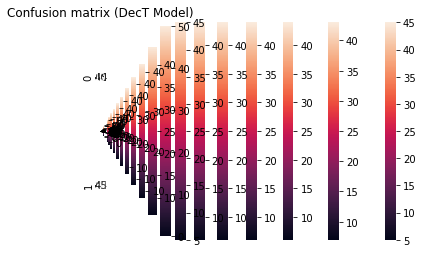

In [20]:
# Initialize variables to store results
# Clear any existing elements in the lists if they were previously initialized

shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    
    ## Creating and running our optimization

    # Creating and running our optimization

    study_dect = optuna.create_study(direction='maximize',study_name = "Dect")
    with parallel_backend('threading'):
        study_dect.optimize(objective_dect, n_trials=10, n_jobs=-1)

    # Evaluating our Optuna Trial
    print("Best trial:", study_dect.best_trial.number)
    print("Best accuracy:", study_dect.best_trial.value)
    print("Best hyperparameters:", study_dect.best_params)

    best_param_dect = study_dect.best_params
    DecT = DecisionTreeClassifier(**best_param_dect,random_state=42).fit(x_train,y_train)
    y_pred_dect = DecT.predict(x_test)


    display_results(y_test, y_pred_dect, cm_title = "Confusion matrix (DecT Model)")


    # SHAP value computation using TreeExplainer
    explainer = shap.TreeExplainer(model=DecT, data= None, model_output= 'raw', feature_perturbation= 'tree_path_dependent')
    shap_values = explainer.shap_values(x_test_)

    # Extract SHAP values for class 0
    shap_values_array = abs(shap_values[:,:,0])

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)


# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)

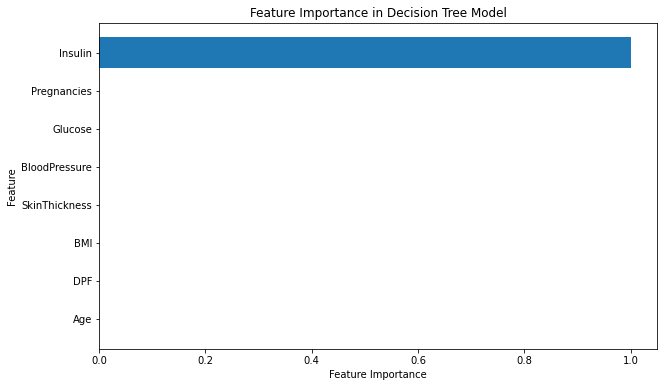

         Feature  Importance
4        Insulin         1.0
0    Pregnancies         0.0
1        Glucose         0.0
2  BloodPressure         0.0
3  SkinThickness         0.0
5            BMI         0.0
6            DPF         0.0
7            Age         0.0


In [21]:
# Get feature importances from the decision tree model
feature_importances = DecT.feature_importances_

# Get feature names
feature_names = x_train.columns

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree Model')
plt.gca().invert_yaxis()
plt.show()

# Print the DataFrame for detailed view
print(importance_df)

In [22]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]



In [23]:
# Call the add_to_df function to populate valuestability
add_to_df()
valuestability

cv = valuestability.sum(axis=1) / valuestability.shape[1]
valuestability['CV'] = cv

# Save the DataFrame to an Excel file
valuestability.to_excel('20_dt_valuestability.xlsx', index=False)
valuestability

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,CV
0,1.939826,0.858676,2.491609,1.556958,0.417095,2.790406,2.004203,1.151353,1.651266
1,1.927321,0.814001,2.442100,1.563752,0.406948,2.040339,2.443711,1.151267,1.598680
2,1.927321,0.814001,2.442100,1.563752,0.406948,2.040339,2.443711,1.151267,1.598680
3,1.924462,0.815714,2.442100,1.563752,0.401719,2.468436,2.137637,1.143032,1.612107
4,2.062938,0.779825,2.422795,1.505738,0.483717,1.886849,2.443711,1.101265,1.585855
...,...,...,...,...,...,...,...,...,...
95,2.078848,0.779942,2.422795,1.504880,0.483528,2.058816,2.443711,1.101265,1.609223
96,1.927321,0.814001,2.442100,1.563752,0.406948,2.040339,2.443711,1.151267,1.598680
97,1.939826,0.858944,2.467643,1.556958,0.417241,2.790406,2.035938,1.151320,1.652284
98,1.924462,0.815714,2.442100,1.563752,0.401719,2.468436,2.137637,1.143032,1.612107


## 4.5 SVM (Support Vector Machine)

In [24]:
df = pd.read_csv("data_resampled_50.csv")
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)

def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))



In [25]:
# Creating an Objective Function

def objective_svm(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
                'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0),
                'class_weight': class_weight
                }

    # Create and train the model
    svm = SVC(**param_svm,random_state=rs)
    svm.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(svm, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

[I 2024-08-26 17:09:37,632] A new study created in memory with name: SVM
[I 2024-08-26 17:09:38,262] Trial 0 finished with value: 0.8130327975512952 and parameters: {'C': 0.6983803365729574, 'gamma': 0.008434556249634002}. Best is trial 0 with value: 0.8130327975512952.
[I 2024-08-26 17:09:38,275] Trial 1 finished with value: 0.820736894147253 and parameters: {'C': 8.078638037861529, 'gamma': 0.0021280395131864876}. Best is trial 1 with value: 0.820736894147253.
[I 2024-08-26 17:09:38,407] Trial 5 finished with value: 0.8084723074504904 and parameters: {'C': 0.08738083249299865, 'gamma': 0.284124937645167}. Best is trial 1 with value: 0.820736894147253.
[I 2024-08-26 17:09:38,507] Trial 4 finished with value: 0.771619697409545 and parameters: {'C': 0.07226206054150011, 'gamma': 0.004856687227166765}. Best is trial 1 with value: 0.820736894147253.
[I 2024-08-26 17:09:38,589] Trial 2 finished with value: 0.6577650241060988 and parameters: {'C': 0.04517742022348996, 'gamma': 0.51605249649

Best trial: 8
Best accuracy: 0.8218887441581082
Best hyperparameters: {'C': 39.651553162911, 'gamma': 0.0016059843839133332}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 17:10:03,366] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029250  0.193964       0.000774       0.001774  0.091226  0.048012   
1      0.062571  0.160310       0.002048       0.099095  0.144595  0.002286   
2      0.049762  0.150571       0.011929       0.040571  0.186024  0.058024   
3      0.035643  0.159381       0.006452       0.041286  0.140905  0.037786   
4      0.001083  0.115298       0.006655       0.002012  0.156036  0.028107   
..          ...       ...            ...            ...       ...       ...   
95     0.252214  0.234690       0.011095       0.086905  0.014786  0.105667   
96     0.068167  0.127214       0.000262       0.163810  0.117929  0.105905   
97     0.215500  0.347667       0.009762       0.337167  0.020500  0.053929   
98     0.017202  0.241369       0.006202       0.063036  0.229440  0.092750   
99     0.035405  0.207619       0.000071       0.052452  0.308476  0.006786   

         DPF       Age  Outcome  
0   0.036631  0.0

[I 2024-08-26 17:10:04,026] Trial 2 finished with value: 0.821969879623569 and parameters: {'C': 0.52263265944031, 'gamma': 0.19128662066835678}. Best is trial 2 with value: 0.821969879623569.
[I 2024-08-26 17:10:04,038] Trial 5 finished with value: 0.8229988420233717 and parameters: {'C': 480.8640551204561, 'gamma': 0.0001606875857976874}. Best is trial 5 with value: 0.8229988420233717.
[I 2024-08-26 17:10:04,046] Trial 1 finished with value: 0.8248860008563882 and parameters: {'C': 0.10360621504424974, 'gamma': 0.08401173757099419}. Best is trial 1 with value: 0.8248860008563882.
[I 2024-08-26 17:10:04,238] Trial 0 finished with value: 0.8165960703823206 and parameters: {'C': 21.98946727112407, 'gamma': 0.34067590280676513}. Best is trial 1 with value: 0.8248860008563882.
[I 2024-08-26 17:10:04,359] Trial 3 finished with value: 0.7530908679309496 and parameters: {'C': 0.01854201358834106, 'gamma': 0.00914579973491919}. Best is trial 1 with value: 0.8248860008563882.
[I 2024-08-26 17:

Best trial: 6
Best accuracy: 0.8278307753929554
Best hyperparameters: {'C': 1.6160190957932201, 'gamma': 0.059289567899271756}
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        50
           1       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 17:10:17,291] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.041786  0.164786       0.003810       0.007024  0.138952  0.021452   
1      0.015143  0.143381       0.000690       0.017190  0.150262  0.001548   
2      0.000417  0.134940       0.010417       0.037774  0.327631  0.022702   
3      0.012202  0.124512       0.008726       0.038560  0.290964  0.010964   
4      0.003512  0.070226       0.002155       0.006774  0.232750  0.005655   
..          ...       ...            ...            ...       ...       ...   
95     0.022012  0.027202       0.013679       0.037202  0.268798  0.008798   
96     0.008488  0.094369       0.004798       0.157464  0.136393  0.195226   
97     0.006702  0.509202       0.001488       0.187964  0.205298  0.067274   
98     0.007345  0.052155       0.006036       0.059131  0.361488  0.029060   
99     0.021155  0.125988       0.005417       0.050036  0.319845  0.002845   

         DPF       Age  Outcome  
0   0.015881  0.0

[I 2024-08-26 17:10:17,967] Trial 1 finished with value: 0.8239214109462776 and parameters: {'C': 0.5155825611859921, 'gamma': 0.02151164987007771}. Best is trial 1 with value: 0.8239214109462776.
[I 2024-08-26 17:10:18,102] Trial 0 finished with value: 0.8113054270330174 and parameters: {'C': 0.7514688386910588, 'gamma': 0.41497953209912847}. Best is trial 1 with value: 0.8239214109462776.
[I 2024-08-26 17:10:18,180] Trial 3 finished with value: 0.8237761860320856 and parameters: {'C': 218.49178920833126, 'gamma': 0.0019946445005397397}. Best is trial 1 with value: 0.8239214109462776.
[I 2024-08-26 17:10:18,223] Trial 5 finished with value: 0.7812515967739347 and parameters: {'C': 8.74779126815646, 'gamma': 5.6606642548014504e-05}. Best is trial 1 with value: 0.8239214109462776.
[I 2024-08-26 17:10:18,386] Trial 2 finished with value: 0.7600608436821387 and parameters: {'C': 0.17590471177390657, 'gamma': 0.0008075684539767741}. Best is trial 1 with value: 0.8239214109462776.
[I 2024-0

Best trial: 1
Best accuracy: 0.8239214109462776
Best hyperparameters: {'C': 0.5155825611859921, 'gamma': 0.02151164987007771}
              precision    recall  f1-score   support

           0       0.73      0.94      0.82        50
           1       0.92      0.66      0.77        50

    accuracy                           0.80       100
   macro avg       0.83      0.80      0.80       100
weighted avg       0.83      0.80      0.80       100



[I 2024-08-26 17:10:33,886] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.036405  0.196095       0.000881       0.000476  0.098452  0.042905   
1      0.061095  0.155048       0.000929       0.079690  0.153405  0.004119   
2      0.048690  0.145952       0.013952       0.035048  0.193214  0.051381   
3      0.044262  0.155667       0.007667       0.040690  0.154786  0.030452   
4      0.004476  0.113333       0.006881       0.002238  0.169000  0.027000   
..          ...       ...            ...            ...       ...       ...   
95     0.239512  0.215726       0.002726       0.108512  0.001202  0.117226   
96     0.071524  0.122214       0.000714       0.160143  0.128881  0.105381   
97     0.218083  0.347821       0.008821       0.331345  0.012798  0.052512   
98     0.021190  0.225310       0.005714       0.059429  0.245905  0.075214   
99     0.032369  0.192036       0.000512       0.047702  0.325702  0.011512   

         DPF       Age  Outcome  
0   0.034857  0.0

[I 2024-08-26 17:10:34,604] Trial 2 finished with value: 0.8249798198187451 and parameters: {'C': 17.710993122180742, 'gamma': 0.0074103406794479975}. Best is trial 2 with value: 0.8249798198187451.
[I 2024-08-26 17:10:34,963] Trial 4 finished with value: 0.7662293206368663 and parameters: {'C': 0.01555930629929747, 'gamma': 0.014908576122622063}. Best is trial 2 with value: 0.8249798198187451.
[I 2024-08-26 17:10:34,981] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.0026443283744511836, 'gamma': 0.00010103608208454305}. Best is trial 2 with value: 0.8249798198187451.
[I 2024-08-26 17:10:34,990] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.005410613162794455, 'gamma': 1.2335171843346193e-05}. Best is trial 2 with value: 0.8249798198187451.
[I 2024-08-26 17:10:34,994] Trial 1 finished with value: 0.7647004264343356 and parameters: {'C': 65.98461332785179, 'gamma': 0.7094194276503943}. Best is trial 2 with value: 0.8249798198187451.
[I 2

Best trial: 3
Best accuracy: 0.8291709445433029
Best hyperparameters: {'C': 261.99279184017365, 'gamma': 0.010237569063894959}
              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.88      0.74      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 17:10:46,905] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.065714  0.161881       0.003667       0.010833  0.186214  0.004976   
1      0.003071  0.136095       0.004167       0.012214  0.156333  0.002119   
2      0.023619  0.120595       0.014595       0.026310  0.386571  0.013214   
3      0.026726  0.120464       0.005774       0.016226  0.301655  0.001369   
4      0.022607  0.054560       0.006964       0.001702  0.239131  0.000417   
..          ...       ...            ...            ...       ...       ...   
95     0.190607  0.133702       0.137440       0.124631  0.056512  0.109274   
96     0.024000  0.117857       0.002167       0.132381  0.180738  0.252048   
97     0.147012  0.541012       0.023798       0.180393  0.154488  0.053250   
98     0.032571  0.027048       0.008405       0.063405  0.372571  0.006238   
99     0.010833  0.127452       0.004071       0.038071  0.322429  0.000714   

         DPF       Age  Outcome  
0   0.022119  0.0

[I 2024-08-26 17:10:47,625] Trial 3 finished with value: 0.8332982152696985 and parameters: {'C': 0.34388774806732086, 'gamma': 0.11684084177674078}. Best is trial 3 with value: 0.8332982152696985.
[I 2024-08-26 17:10:47,661] Trial 2 finished with value: 0.81802603847792 and parameters: {'C': 47.76911992452233, 'gamma': 0.00031120173139106614}. Best is trial 3 with value: 0.8332982152696985.
[I 2024-08-26 17:10:47,809] Trial 1 finished with value: 0.7967565943569348 and parameters: {'C': 0.1815031433205139, 'gamma': 0.006245312904420768}. Best is trial 3 with value: 0.8332982152696985.
[I 2024-08-26 17:10:47,970] Trial 0 finished with value: 0.7721641969907005 and parameters: {'C': 1.5134497999047287, 'gamma': 0.00016040749169088467}. Best is trial 3 with value: 0.8332982152696985.
[I 2024-08-26 17:10:48,009] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.24732843026998588, 'gamma': 7.894069220873677e-05}. Best is trial 3 with value: 0.8332982152696985.
[I 2024-

Best trial: 3
Best accuracy: 0.8332982152696985
Best hyperparameters: {'C': 0.34388774806732086, 'gamma': 0.11684084177674078}
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        50
           1       0.93      0.74      0.82        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 17:11:04,168] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039060  0.168774       0.004464       0.005655  0.140274  0.024726   
1      0.038048  0.127381       0.002524       0.033286  0.171000  0.005643   
2      0.020548  0.117881       0.073238       0.031357  0.206881  0.026095   
3      0.030369  0.125036       0.017488       0.041036  0.224845  0.012464   
4      0.002155  0.087488       0.036940       0.007179  0.210417  0.007274   
..          ...       ...            ...            ...       ...       ...   
95     0.125679  0.137060       0.168179       0.103488  0.087369  0.132512   
96     0.032226  0.087107       0.002512       0.156488  0.135583  0.157107   
97     0.177440  0.318917       0.008321       0.357298  0.090845  0.082369   
98     0.005571  0.097952       0.009190       0.063167  0.318690  0.043500   
99     0.028548  0.133643       0.001667       0.054619  0.334500  0.001024   

         DPF       Age  Outcome  
0   0.020155  0.0

[I 2024-08-26 17:11:05,280] Trial 3 finished with value: 0.7726277132705127 and parameters: {'C': 0.21269029559708869, 'gamma': 0.000980128569556494}. Best is trial 3 with value: 0.7726277132705127.
[I 2024-08-26 17:11:05,293] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.02235218842682785, 'gamma': 1.2713090484959122e-05}. Best is trial 3 with value: 0.7726277132705127.
[I 2024-08-26 17:11:05,303] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.0018599500414691749, 'gamma': 2.3298597819232817e-05}. Best is trial 3 with value: 0.7726277132705127.
[I 2024-08-26 17:11:05,308] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.0010975001304932878, 'gamma': 0.24236070547135657}. Best is trial 3 with value: 0.7726277132705127.
[I 2024-08-26 17:11:05,342] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 1.1996634174785403, 'gamma': 1.906372754301475e-05}. Best is trial 3 with value: 0.7726277132705127.
[I

Best trial: 9
Best accuracy: 0.8194167280371748
Best hyperparameters: {'C': 114.14735469690542, 'gamma': 0.007507363002368543}
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        50
           1       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 17:11:17,907] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043976  0.176976       0.001333       0.005000  0.123786  0.017000   
1      0.001595  0.161810       0.000619       0.032190  0.160595  0.003119   
2      0.016429  0.132690       0.002238       0.025286  0.335857  0.018548   
3      0.014857  0.130833       0.004214       0.030905  0.277571  0.007810   
4      0.011988  0.068964       0.002940       0.003393  0.215940  0.008345   
..          ...       ...            ...            ...       ...       ...   
95     0.134476  0.164405       0.111143       0.115429  0.040476  0.125810   
96     0.006810  0.103905       0.004357       0.191833  0.117048  0.172310   
97     0.047798  0.330274       0.131274       0.383417  0.109702  0.051250   
98     0.025595  0.053000       0.005095       0.072857  0.346690  0.024119   
99     0.011940  0.142917       0.000893       0.043536  0.330821  0.006702   

         DPF       Age  Outcome  
0   0.015976  0.0

[I 2024-08-26 17:11:18,646] Trial 2 finished with value: 0.8224752809316236 and parameters: {'C': 137.57197482220482, 'gamma': 0.0004019469941126649}. Best is trial 2 with value: 0.8224752809316236.
[I 2024-08-26 17:11:18,803] Trial 5 finished with value: 0.7925510860717414 and parameters: {'C': 895.4284361227593, 'gamma': 0.12975861481950565}. Best is trial 2 with value: 0.8224752809316236.
[I 2024-08-26 17:11:18,932] Trial 4 finished with value: 0.8212654095895755 and parameters: {'C': 406.65342385225347, 'gamma': 0.0015625218751779983}. Best is trial 2 with value: 0.8224752809316236.
[I 2024-08-26 17:11:19,004] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.030272823858649465, 'gamma': 0.0016966597116103044}. Best is trial 2 with value: 0.8224752809316236.
[I 2024-08-26 17:11:19,011] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.0024086147333428182, 'gamma': 0.00025807105594071226}. Best is trial 2 with value: 0.8224752809316236.
[I 2

Best trial: 9
Best accuracy: 0.8314564069664953
Best hyperparameters: {'C': 0.6889296219970825, 'gamma': 0.08947388448279524}
              precision    recall  f1-score   support

           0       0.80      0.94      0.86        50
           1       0.93      0.76      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100



[I 2024-08-26 17:11:33,622] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.051690  0.161667       0.005429       0.007667  0.145857  0.018667   
1      0.034607  0.120155       0.002012       0.021583  0.163512  0.002917   
2      0.013286  0.143786       0.033381       0.034071  0.230571  0.025310   
3      0.030881  0.121714       0.008119       0.039643  0.242119  0.016905   
4      0.001976  0.077071       0.019310       0.009071  0.227619  0.006119   
..          ...       ...            ...            ...       ...       ...   
95     0.033988  0.009655       0.019083       0.000179  0.235917  0.000655   
96     0.024286  0.086810       0.003833       0.149000  0.145643  0.170714   
97     0.028488  0.478012       0.029702       0.187345  0.209036  0.065940   
98     0.010643  0.063738       0.005571       0.059286  0.347714  0.029310   
99     0.028738  0.119429       0.003810       0.050214  0.328595  0.004881   

         DPF       Age  Outcome  
0   0.019000  0.0

[I 2024-08-26 17:11:34,524] Trial 0 finished with value: 0.7839981107314833 and parameters: {'C': 7.42016517016327, 'gamma': 7.42761160576072e-05}. Best is trial 0 with value: 0.7839981107314833.
[I 2024-08-26 17:11:34,619] Trial 2 finished with value: 0.770691881822015 and parameters: {'C': 0.11895786898978318, 'gamma': 0.002369228491418992}. Best is trial 0 with value: 0.7839981107314833.
[I 2024-08-26 17:11:34,699] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.004287504118124039, 'gamma': 0.0002779315782096202}. Best is trial 0 with value: 0.7839981107314833.
[I 2024-08-26 17:11:34,715] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.004613571834388236, 'gamma': 7.834474538755162e-05}. Best is trial 0 with value: 0.7839981107314833.
[I 2024-08-26 17:11:34,720] Trial 4 finished with value: 0.4777936504128841 and parameters: {'C': 0.007471905192371854, 'gamma': 0.22649674550147458}. Best is trial 0 with value: 0.7839981107314833.
[I 2024

Best trial: 8
Best accuracy: 0.8292088024725609
Best hyperparameters: {'C': 0.2986571237494878, 'gamma': 0.04901968632519948}
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.68      0.78        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 17:11:50,988] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043238  0.192143       0.001500       0.001024  0.105738  0.038095   
1      0.058952  0.150095       0.005190       0.070286  0.168429  0.005810   
2      0.045107  0.144179       0.037679       0.036893  0.186298  0.047274   
3      0.046226  0.148321       0.013440       0.043417  0.169060  0.022845   
4      0.002298  0.115607       0.015583       0.000679  0.176940  0.022464   
..          ...       ...            ...            ...       ...       ...   
95     0.240369  0.202679       0.013250       0.107631  0.007893  0.118679   
96     0.067250  0.117083       0.004345       0.155917  0.133131  0.119560   
97     0.206333  0.333476       0.009810       0.339405  0.029786  0.056500   
98     0.019286  0.201119       0.010143       0.063357  0.260929  0.062976   
99     0.037595  0.179048       0.001548       0.052286  0.324810  0.006024   

         DPF       Age  Outcome  
0   0.028690  0.0

[I 2024-08-26 17:11:51,674] Trial 0 finished with value: 0.8188640814659824 and parameters: {'C': 9.571786315066722, 'gamma': 0.0015339381371024213}. Best is trial 0 with value: 0.8188640814659824.
[I 2024-08-26 17:11:51,695] Trial 1 finished with value: 0.8174209803664138 and parameters: {'C': 4.374437536246289, 'gamma': 0.0018415513483442422}. Best is trial 0 with value: 0.8188640814659824.
[I 2024-08-26 17:11:51,838] Trial 4 finished with value: 0.817380084082884 and parameters: {'C': 60.3759907290995, 'gamma': 0.006116277363969204}. Best is trial 0 with value: 0.8188640814659824.
[I 2024-08-26 17:11:52,037] Trial 3 finished with value: 0.8233350000922454 and parameters: {'C': 606.1265954993095, 'gamma': 0.0011910065063225766}. Best is trial 3 with value: 0.8233350000922454.
[I 2024-08-26 17:11:52,099] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.007256208929882176, 'gamma': 0.0025445048623560632}. Best is trial 3 with value: 0.8233350000922454.
[I 2024-08-

Best trial: 3
Best accuracy: 0.8233350000922454
Best hyperparameters: {'C': 606.1265954993095, 'gamma': 0.0011910065063225766}
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.68      0.78        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 17:12:05,900] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.036464  0.171060       0.001821       0.007774  0.130226  0.033583   
1      0.034714  0.142976       0.005071       0.067548  0.176524  0.002452   
2      0.031143  0.138452       0.008524       0.041762  0.234238  0.046071   
3      0.031762  0.139262       0.004048       0.042786  0.203571  0.020000   
4      0.000179  0.094679       0.000440       0.008250  0.218321  0.011417   
..          ...       ...            ...            ...       ...       ...   
95     0.083036  0.033869       0.133036       0.004107  0.192179  0.012298   
96     0.045452  0.106381       0.002071       0.175524  0.146571  0.108786   
97     0.138107  0.289107       0.009298       0.382798  0.044607  0.044940   
98     0.004833  0.143976       0.003476       0.070524  0.291071  0.053381   
99     0.031357  0.146643       0.003024       0.045381  0.351976  0.003619   

         DPF       Age  Outcome  
0   0.033940  0.0

[I 2024-08-26 17:12:06,785] Trial 2 finished with value: 0.7969316902790198 and parameters: {'C': 16.627956032459533, 'gamma': 5.838359764191202e-05}. Best is trial 2 with value: 0.7969316902790198.
[I 2024-08-26 17:12:07,018] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.04225903076161387, 'gamma': 1.1730530360751044e-05}. Best is trial 2 with value: 0.7969316902790198.
[I 2024-08-26 17:12:07,024] Trial 5 finished with value: 0.34032996344885974 and parameters: {'C': 1.1044621928338256, 'gamma': 6.558597929137887e-05}. Best is trial 2 with value: 0.7969316902790198.
[I 2024-08-26 17:12:07,050] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.01757358048320196, 'gamma': 0.0013974820774609927}. Best is trial 2 with value: 0.7969316902790198.
[I 2024-08-26 17:12:07,060] Trial 3 finished with value: 0.3015179297653436 and parameters: {'C': 5.097033443134257, 'gamma': 1.2045926573613816e-05}. Best is trial 2 with value: 0.7969316902790198.
[I 

Best trial: 7
Best accuracy: 0.8225672637504438
Best hyperparameters: {'C': 32.703256682823415, 'gamma': 0.0010658205514903307}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 17:12:21,621] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.030631  0.193631       0.001631       0.002512  0.094488  0.044393   
1      0.064155  0.165440       0.001179       0.103393  0.147155  0.003060   
2      0.048988  0.148393       0.011274       0.038893  0.188440  0.058369   
3      0.035024  0.162833       0.008333       0.038952  0.140048  0.036500   
4      0.001690  0.114405       0.006000       0.001905  0.167333  0.026810   
..          ...       ...            ...            ...       ...       ...   
95     0.259310  0.237548       0.016190       0.085786  0.011548  0.089024   
96     0.066440  0.128060       0.000345       0.165560  0.124274  0.099726   
97     0.221714  0.373238       0.003690       0.311643  0.010214  0.077643   
98     0.018917  0.247060       0.006964       0.059512  0.232679  0.089226   
99     0.032726  0.213417       0.000440       0.051131  0.308179  0.007893   

         DPF       Age  Outcome  
0   0.035321  0.0

[I 2024-08-26 17:12:22,321] Trial 1 finished with value: 0.8232111735185513 and parameters: {'C': 6.807832326352399, 'gamma': 0.02098132972495882}. Best is trial 1 with value: 0.8232111735185513.
[I 2024-08-26 17:12:22,438] Trial 4 finished with value: 0.823952372346458 and parameters: {'C': 160.38289033077186, 'gamma': 0.0014241154384488895}. Best is trial 4 with value: 0.823952372346458.
[I 2024-08-26 17:12:22,693] Trial 2 finished with value: 0.7724097656524594 and parameters: {'C': 7.115400654893157, 'gamma': 2.4858073805677334e-05}. Best is trial 4 with value: 0.823952372346458.
[I 2024-08-26 17:12:22,704] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.031240863941756625, 'gamma': 1.6611739989170397e-05}. Best is trial 4 with value: 0.823952372346458.
[I 2024-08-26 17:12:22,723] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.007751884004936359, 'gamma': 0.006353662700296298}. Best is trial 4 with value: 0.823952372346458.
[I 2024-08-

Best trial: 6
Best accuracy: 0.8324362124389607
Best hyperparameters: {'C': 50.29252601915608, 'gamma': 0.02315791783445303}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 17:12:34,851] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.072595  0.165167       0.001619       0.010119  0.155881  0.001714   
1      0.008524  0.136976       0.003738       0.010452  0.164667  0.000381   
2      0.014679  0.108464       0.008083       0.032321  0.397036  0.014560   
3      0.027583  0.111298       0.000488       0.016107  0.302131  0.003750   
4      0.008440  0.051083       0.010202       0.004155  0.305250  0.017917   
..          ...       ...            ...            ...       ...       ...   
95     0.240655  0.104274       0.097583       0.097655  0.032488  0.093988   
96     0.013464  0.116583       0.012036       0.116964  0.183060  0.268274   
97     0.111714  0.552690       0.007405       0.164190  0.121667  0.063452   
98     0.033464  0.025631       0.008131       0.063274  0.381298  0.007250   
99     0.005179  0.136179       0.005821       0.043917  0.320512  0.008083   

         DPF       Age  Outcome  
0   0.004762  0.0

[I 2024-08-26 17:12:35,670] Trial 1 finished with value: 0.8190695703062778 and parameters: {'C': 1.041709152592688, 'gamma': 0.007555671279554913}. Best is trial 1 with value: 0.8190695703062778.
[I 2024-08-26 17:12:35,958] Trial 3 finished with value: 0.6890223903509534 and parameters: {'C': 0.08359388417920484, 'gamma': 0.6380967079127732}. Best is trial 1 with value: 0.8190695703062778.
[I 2024-08-26 17:12:36,008] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.0016089179804110532, 'gamma': 1.4123511305159938e-05}. Best is trial 1 with value: 0.8190695703062778.
[I 2024-08-26 17:12:36,015] Trial 5 finished with value: 0.7599590357432633 and parameters: {'C': 0.008432710433185185, 'gamma': 0.04604878614082445}. Best is trial 1 with value: 0.8190695703062778.
[I 2024-08-26 17:12:36,042] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.0025262565181784075, 'gamma': 0.0014188360445366883}. Best is trial 1 with value: 0.8190695703062778.
[I 2

Best trial: 7
Best accuracy: 0.8320156457213185
Best hyperparameters: {'C': 0.8538317126595231, 'gamma': 0.07562499497157464}
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        50
           1       0.93      0.74      0.82        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 17:12:50,494] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.046238  0.159714       0.004690       0.009000  0.145119  0.019214   
1      0.027012  0.125893       0.003321       0.023869  0.160917  0.004750   
2      0.008202  0.145655       0.017845       0.035440  0.244226  0.032774   
3      0.023679  0.118583       0.002131       0.044250  0.271631  0.011917   
4      0.002095  0.070143       0.013024       0.006905  0.228262  0.005548   
..          ...       ...            ...            ...       ...       ...   
95     0.008095  0.012738       0.008071       0.028667  0.250762  0.013024   
96     0.017143  0.090429       0.003881       0.150143  0.144857  0.171952   
97     0.018190  0.484976       0.014476       0.186238  0.213071  0.067690   
98     0.009798  0.066274       0.002750       0.057369  0.351940  0.031155   
99     0.026988  0.125036       0.004631       0.051179  0.329798  0.004036   

         DPF       Age  Outcome  
0   0.021524  0.0

[I 2024-08-26 17:12:51,279] Trial 1 finished with value: 0.8211566421944534 and parameters: {'C': 4.596993122008903, 'gamma': 0.004251397088164304}. Best is trial 1 with value: 0.8211566421944534.
[I 2024-08-26 17:12:51,316] Trial 3 finished with value: 0.8052527141057668 and parameters: {'C': 94.60335026675239, 'gamma': 4.1769906117066185e-05}. Best is trial 1 with value: 0.8211566421944534.
[I 2024-08-26 17:12:51,525] Trial 2 finished with value: 0.7931651145624659 and parameters: {'C': 17.76010545739927, 'gamma': 4.351887043013588e-05}. Best is trial 1 with value: 0.8211566421944534.
[I 2024-08-26 17:12:51,702] Trial 5 finished with value: 0.6762284515331816 and parameters: {'C': 0.046560284999352566, 'gamma': 0.46595125980525753}. Best is trial 1 with value: 0.8211566421944534.
[I 2024-08-26 17:12:51,724] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.005174283173154309, 'gamma': 1.7813001812271077e-05}. Best is trial 1 with value: 0.8211566421944534.
[I 202

Best trial: 7
Best accuracy: 0.8347698937649148
Best hyperparameters: {'C': 0.3403027703050283, 'gamma': 0.08874248234820739}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 17:13:08,107] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042155  0.173393       0.000202       0.003679  0.122250  0.031869   
1      0.042905  0.141095       0.003643       0.045976  0.161119  0.004714   
2      0.024298  0.130440       0.065345       0.034155  0.198107  0.035726   
3      0.029976  0.129381       0.020000       0.040952  0.202833  0.017810   
4      0.000679  0.095774       0.033988       0.004893  0.198607  0.012774   
..          ...       ...            ...            ...       ...       ...   
95     0.128179  0.147917       0.164560       0.104107  0.071917  0.135202   
96     0.039000  0.089548       0.003071       0.158190  0.133524  0.146738   
97     0.177143  0.326310       0.008643       0.357000  0.078286  0.082500   
98     0.004024  0.124381       0.014214       0.060571  0.301143  0.053071   
99     0.027548  0.146119       0.000619       0.056429  0.334905  0.000857   

         DPF       Age  Outcome  
0   0.022917  0.0

[I 2024-08-26 17:13:08,990] Trial 1 finished with value: 0.8217219924825803 and parameters: {'C': 7.703032128115993, 'gamma': 0.005461792993187937}. Best is trial 1 with value: 0.8217219924825803.
[I 2024-08-26 17:13:09,036] Trial 4 finished with value: 0.8036608878049275 and parameters: {'C': 9.18226414940679, 'gamma': 0.19825046435311672}. Best is trial 1 with value: 0.8217219924825803.
[I 2024-08-26 17:13:09,286] Trial 0 finished with value: 0.8144382798490067 and parameters: {'C': 965.4217658933896, 'gamma': 0.3826757259218276}. Best is trial 1 with value: 0.8217219924825803.
[I 2024-08-26 17:13:09,299] Trial 2 finished with value: 0.7835609672875203 and parameters: {'C': 0.3630960027609405, 'gamma': 0.0015707291854630003}. Best is trial 1 with value: 0.8217219924825803.
[I 2024-08-26 17:13:09,459] Trial 5 finished with value: 0.6764043878446152 and parameters: {'C': 0.014146055507036482, 'gamma': 0.29596618678167347}. Best is trial 1 with value: 0.8217219924825803.
[I 2024-08-26 1

Best trial: 1
Best accuracy: 0.8217219924825803
Best hyperparameters: {'C': 7.703032128115993, 'gamma': 0.005461792993187937}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 17:13:23,861] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.031274  0.194226       0.000250       0.003107  0.090250  0.048821   
1      0.059881  0.159500       0.000571       0.089786  0.147381  0.007571   
2      0.048679  0.157607       0.003869       0.041631  0.196774  0.057917   
3      0.038393  0.157298       0.001536       0.042702  0.146655  0.038345   
4      0.002893  0.116536       0.000798       0.001940  0.163655  0.029607   
..          ...       ...            ...            ...       ...       ...   
95     0.236036  0.230369       0.006798       0.101821  0.018750  0.125274   
96     0.065202  0.122821       0.000917       0.167036  0.111131  0.117988   
97     0.208167  0.329929       0.004929       0.349976  0.014310  0.050810   
98     0.012452  0.228667       0.002643       0.072262  0.202000  0.098310   
99     0.037988  0.199845       0.001012       0.051845  0.309940  0.011964   

         DPF       Age  Outcome  
0   0.035917  0.0

[I 2024-08-26 17:13:24,723] Trial 2 finished with value: 0.7960008317533449 and parameters: {'C': 18.779501044506052, 'gamma': 7.323145889696236e-05}. Best is trial 2 with value: 0.7960008317533449.
[I 2024-08-26 17:13:25,099] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.6761175169839566, 'gamma': 2.0513353988656826e-05}. Best is trial 2 with value: 0.7960008317533449.
[I 2024-08-26 17:13:25,134] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.13303893414578127, 'gamma': 0.00016367627948549323}. Best is trial 2 with value: 0.7960008317533449.
[I 2024-08-26 17:13:25,139] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.005021563250437229, 'gamma': 0.015780444815679442}. Best is trial 2 with value: 0.7960008317533449.
[I 2024-08-26 17:13:25,149] Trial 5 finished with value: 0.763255073495552 and parameters: {'C': 0.013819577607989898, 'gamma': 0.02494771248515811}. Best is trial 2 with value: 0.7960008317533449.
[I 20

Best trial: 6
Best accuracy: 0.8314840520437606
Best hyperparameters: {'C': 47.22041880673101, 'gamma': 0.033725267050848995}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 17:13:40,722] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.066060  0.172631       0.000155       0.003726  0.153393  0.005012   
1      0.008000  0.133810       0.007738       0.023881  0.155524  0.001810   
2      0.023286  0.078667       0.010119       0.029833  0.457714  0.020738   
3      0.022202  0.122940       0.009631       0.011964  0.289369  0.007131   
4      0.010321  0.045607       0.013298       0.005869  0.366060  0.012131   
..          ...       ...            ...            ...       ...       ...   
95     0.274190  0.033190       0.110857       0.102952  0.039143  0.080738   
96     0.143202  0.393083       0.077845       0.027012  0.029940  0.105393   
97     0.022679  0.629988       0.000964       0.113655  0.092321  0.036488   
98     0.033429  0.014738       0.015333       0.059667  0.407810  0.003429   
99     0.032762  0.185143       0.022381       0.065833  0.279595  0.021143   

         DPF       Age  Outcome  
0   0.009679  0.0

[I 2024-08-26 17:13:41,537] Trial 3 finished with value: 0.8226712753329884 and parameters: {'C': 50.29541653586442, 'gamma': 0.002809929730691224}. Best is trial 3 with value: 0.8226712753329884.
[I 2024-08-26 17:13:41,812] Trial 5 finished with value: 0.7420042689785669 and parameters: {'C': 0.012356349183099517, 'gamma': 0.12247241438742743}. Best is trial 3 with value: 0.8226712753329884.
[I 2024-08-26 17:13:41,841] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.0019009903773262932, 'gamma': 0.03208915922941166}. Best is trial 3 with value: 0.8226712753329884.
[I 2024-08-26 17:13:41,858] Trial 2 finished with value: 0.7744397536110929 and parameters: {'C': 7.690380509681445, 'gamma': 2.406559525892385e-05}. Best is trial 3 with value: 0.8226712753329884.
[I 2024-08-26 17:13:41,877] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.10086528378027378, 'gamma': 0.00014477894053970873}. Best is trial 3 with value: 0.8226712753329884.
[I 2024

Best trial: 7
Best accuracy: 0.8305156990845021
Best hyperparameters: {'C': 0.24231649432233862, 'gamma': 0.05863110055577317}
              precision    recall  f1-score   support

           0       0.73      0.94      0.82        50
           1       0.92      0.66      0.77        50

    accuracy                           0.80       100
   macro avg       0.83      0.80      0.80       100
weighted avg       0.83      0.80      0.80       100



[I 2024-08-26 17:13:59,342] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.040333  0.187571       0.000429       0.002429  0.105024  0.039071   
1      0.056548  0.147048       0.007071       0.072119  0.170643  0.007524   
2      0.040512  0.136369       0.047607       0.037488  0.182536  0.047083   
3      0.043952  0.139286       0.020571       0.044786  0.165595  0.024119   
4      0.000833  0.111500       0.022143       0.002952  0.172738  0.020310   
..          ...       ...            ...            ...       ...       ...   
95     0.223845  0.198798       0.043369       0.108821  0.009821  0.122607   
96     0.059905  0.110119       0.003357       0.152476  0.130381  0.121738   
97     0.197738  0.336548       0.017095       0.338714  0.034500  0.062024   
98     0.016714  0.196500       0.016976       0.061381  0.263119  0.063810   
99     0.036024  0.177167       0.000595       0.055452  0.331071  0.005857   

         DPF       Age  Outcome  
0   0.030738  0.0

[I 2024-08-26 17:14:00,241] Trial 2 finished with value: 0.8023133777619527 and parameters: {'C': 103.852742293687, 'gamma': 2.629677446821164e-05}. Best is trial 2 with value: 0.8023133777619527.
[I 2024-08-26 17:14:00,535] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.007965087189190236, 'gamma': 0.8469934596687412}. Best is trial 2 with value: 0.8023133777619527.
[I 2024-08-26 17:14:00,538] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.03050265053209704, 'gamma': 4.316642068122568e-05}. Best is trial 2 with value: 0.8023133777619527.
[I 2024-08-26 17:14:00,548] Trial 5 finished with value: 0.7710540094521773 and parameters: {'C': 77.49494459210547, 'gamma': 0.6803343915514248}. Best is trial 2 with value: 0.8023133777619527.
[I 2024-08-26 17:14:00,591] Trial 1 finished with value: 0.7854664081468675 and parameters: {'C': 6.132922118379822, 'gamma': 0.5923749921187197}. Best is trial 2 with value: 0.8023133777619527.
[I 2024-08-26 17:

Best trial: 6
Best accuracy: 0.8201591749814271
Best hyperparameters: {'C': 6.633572907411441, 'gamma': 0.0033387731571965854}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 17:14:16,742] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029238  0.197833       0.001000       0.001119  0.092690  0.044905   
1      0.059036  0.164179       0.001417       0.097417  0.145893  0.003083   
2      0.047179  0.153274       0.008655       0.038345  0.185964  0.056774   
3      0.035429  0.162786       0.004667       0.039333  0.141952  0.037286   
4      0.001357  0.117905       0.006095       0.001714  0.156119  0.027405   
..          ...       ...            ...            ...       ...       ...   
95     0.252226  0.244060       0.007726       0.085464  0.015060  0.102726   
96     0.067512  0.132821       0.000274       0.165750  0.123274  0.105798   
97     0.222690  0.372595       0.008643       0.315381  0.011524  0.073738   
98     0.018631  0.248226       0.004988       0.059345  0.232917  0.089679   
99     0.031929  0.216190       0.000405       0.049881  0.306833  0.006262   

         DPF       Age  Outcome  
0   0.035667  0.0

[I 2024-08-26 17:14:17,561] Trial 0 finished with value: 0.816662641159227 and parameters: {'C': 679.315618989866, 'gamma': 1.919743718415537e-05}. Best is trial 0 with value: 0.816662641159227.
[I 2024-08-26 17:14:17,725] Trial 2 finished with value: 0.803542017131423 and parameters: {'C': 0.10603055990885668, 'gamma': 0.019162305671837455}. Best is trial 0 with value: 0.816662641159227.
[I 2024-08-26 17:14:17,905] Trial 3 finished with value: 0.7742800654236099 and parameters: {'C': 10.186249609047932, 'gamma': 3.125427166707726e-05}. Best is trial 0 with value: 0.816662641159227.
[I 2024-08-26 17:14:18,032] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.5425662914654814, 'gamma': 1.1325718519980533e-05}. Best is trial 0 with value: 0.816662641159227.
[I 2024-08-26 17:14:18,041] Trial 4 finished with value: 0.299416931282768 and parameters: {'C': 0.008073971339859248, 'gamma': 0.00975631391202258}. Best is trial 0 with value: 0.816662641159227.
[I 2024-08-26 1

Best trial: 0
Best accuracy: 0.816662641159227
Best hyperparameters: {'C': 679.315618989866, 'gamma': 1.919743718415537e-05}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 17:14:33,991] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.027298  0.193083       0.001107       0.007607  0.091036  0.048536   
1      0.057786  0.170690       0.000762       0.091429  0.147214  0.002500   
2      0.048762  0.152476       0.007048       0.029952  0.184690  0.057095   
3      0.032190  0.167167       0.004119       0.032167  0.135476  0.039238   
4      0.003548  0.116310       0.003571       0.005524  0.161905  0.032310   
..          ...       ...            ...            ...       ...       ...   
95     0.258060  0.230917       0.011512       0.090131  0.023060  0.113536   
96     0.065381  0.124929       0.000310       0.147857  0.130643  0.106333   
97     0.078726  0.533655       0.003298       0.149393  0.139798  0.050155   
98     0.022690  0.254976       0.004500       0.056714  0.223071  0.102357   
99     0.026702  0.223440       0.000655       0.046774  0.311869  0.011012   

         DPF       Age  Outcome  
0   0.029369  0.0

[I 2024-08-26 17:14:34,841] Trial 1 finished with value: 0.8188168901530498 and parameters: {'C': 22.902515336806303, 'gamma': 0.000688326801178571}. Best is trial 1 with value: 0.8188168901530498.
[I 2024-08-26 17:14:34,945] Trial 0 finished with value: 0.8112955918183422 and parameters: {'C': 0.5441927990069112, 'gamma': 0.008976022684651643}. Best is trial 1 with value: 0.8188168901530498.
[I 2024-08-26 17:14:35,290] Trial 3 finished with value: 0.3015179297653436 and parameters: {'C': 0.02781105445323665, 'gamma': 0.0024055943292349445}. Best is trial 1 with value: 0.8188168901530498.
[I 2024-08-26 17:14:35,323] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.004514711939507895, 'gamma': 0.021482852896723015}. Best is trial 1 with value: 0.8188168901530498.
[I 2024-08-26 17:14:35,358] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.053837743386436036, 'gamma': 0.0009749222352153068}. Best is trial 1 with value: 0.8188168901530498.
[I 20

Best trial: 1
Best accuracy: 0.8188168901530498
Best hyperparameters: {'C': 22.902515336806303, 'gamma': 0.000688326801178571}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 17:14:52,199] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.031214  0.195095       0.001119       0.003857  0.095833  0.045024   
1      0.061702  0.168750       0.001012       0.093560  0.149226  0.001726   
2      0.051155  0.151345       0.006274       0.031750  0.188226  0.055964   
3      0.035488  0.165560       0.005631       0.032560  0.139940  0.035964   
4      0.002560  0.119083       0.003464       0.003893  0.165393  0.031250   
..          ...       ...            ...            ...       ...       ...   
95     0.264595  0.233810       0.010595       0.080786  0.020381  0.111190   
96     0.071048  0.128286       0.000024       0.151119  0.134333  0.104143   
97     0.084226  0.535655       0.003345       0.146131  0.143321  0.045369   
98     0.023500  0.256714       0.005452       0.053500  0.231714  0.090357   
99     0.027631  0.220702       0.001202       0.044536  0.312607  0.009512   

         DPF       Age  Outcome  
0   0.030738  0.0

[I 2024-08-26 17:14:53,129] Trial 4 finished with value: 0.7977274728076493 and parameters: {'C': 32.91608117412789, 'gamma': 5.865386061965218e-05}. Best is trial 4 with value: 0.7977274728076493.
[I 2024-08-26 17:14:53,220] Trial 3 finished with value: 0.7952259137354354 and parameters: {'C': 10.717912164507334, 'gamma': 0.00014230518961801022}. Best is trial 4 with value: 0.7977274728076493.
[I 2024-08-26 17:14:53,338] Trial 0 finished with value: 0.7835484134710528 and parameters: {'C': 0.05387101856783696, 'gamma': 0.012036282230211932}. Best is trial 4 with value: 0.7977274728076493.
[I 2024-08-26 17:14:53,491] Trial 5 finished with value: 0.8297591215345562 and parameters: {'C': 53.2124397725186, 'gamma': 0.018913336766151125}. Best is trial 5 with value: 0.8297591215345562.
[I 2024-08-26 17:14:53,531] Trial 2 finished with value: 0.7911418051422662 and parameters: {'C': 59.95730152268031, 'gamma': 0.07886605630935214}. Best is trial 5 with value: 0.8297591215345562.
[I 2024-08-

Best trial: 5
Best accuracy: 0.8297591215345562
Best hyperparameters: {'C': 53.2124397725186, 'gamma': 0.018913336766151125}
              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.88      0.74      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 17:15:06,216] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.065048  0.166571       0.005310       0.014095  0.181976  0.002548   
1      0.000869  0.140821       0.003298       0.007393  0.158417  0.001512   
2      0.026143  0.115048       0.015548       0.025905  0.348214  0.004381   
3      0.025595  0.121762       0.003095       0.016310  0.292214  0.002357   
4      0.022881  0.055976       0.003214       0.005500  0.239190  0.001786   
..          ...       ...            ...            ...       ...       ...   
95     0.198321  0.135202       0.112726       0.117464  0.052702  0.113131   
96     0.016714  0.120095       0.002405       0.139714  0.173881  0.241810   
97     0.133571  0.520643       0.019929       0.190310  0.164190  0.068167   
98     0.031690  0.032833       0.007667       0.065500  0.372333  0.007095   
99     0.004060  0.134488       0.009440       0.042631  0.320250  0.003036   

         DPF       Age  Outcome  
0   0.021619  0.0

[I 2024-08-26 17:15:07,058] Trial 0 finished with value: 0.8063957194185865 and parameters: {'C': 1.5490448801436938, 'gamma': 0.002667380395054186}. Best is trial 0 with value: 0.8063957194185865.
[I 2024-08-26 17:15:07,101] Trial 3 finished with value: 0.8118781117007109 and parameters: {'C': 79.82787177837817, 'gamma': 9.198858096597895e-05}. Best is trial 3 with value: 0.8118781117007109.
[I 2024-08-26 17:15:07,566] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.005786323912409873, 'gamma': 0.4226210797165081}. Best is trial 3 with value: 0.8118781117007109.
[I 2024-08-26 17:15:07,583] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.010946779139188498, 'gamma': 0.00041422689434683396}. Best is trial 3 with value: 0.8118781117007109.
[I 2024-08-26 17:15:07,641] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 1.0206100957946416, 'gamma': 2.6524170269743738e-05}. Best is trial 3 with value: 0.8118781117007109.
[I 2024

Best trial: 7
Best accuracy: 0.8244900442380082
Best hyperparameters: {'C': 4.34879831495935, 'gamma': 0.028774852877261285}
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        50
           1       0.90      0.72      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 17:15:21,615] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042048  0.168143       0.004524       0.009167  0.141667  0.017452   
1      0.014786  0.148262       0.001381       0.030357  0.157667  0.002167   
2      0.001012  0.132940       0.013012       0.034369  0.328274  0.027560   
3      0.020607  0.129631       0.016893       0.039179  0.271750  0.011750   
4      0.004821  0.070464       0.006655       0.008750  0.236131  0.004060   
..          ...       ...            ...            ...       ...       ...   
95     0.033452  0.022024       0.018238       0.034786  0.273000  0.019524   
96     0.017917  0.097750       0.002393       0.170750  0.135012  0.152869   
97     0.082464  0.331488       0.115583       0.363726  0.113202  0.069679   
98     0.009643  0.062452       0.006167       0.064071  0.354905  0.033571   
99     0.023905  0.135452       0.006786       0.046143  0.330048  0.004190   

         DPF       Age  Outcome  
0   0.018667  0.0

[I 2024-08-26 17:15:22,467] Trial 2 finished with value: 0.8234578339802355 and parameters: {'C': 17.58687386521559, 'gamma': 0.003877038088116569}. Best is trial 2 with value: 0.8234578339802355.
[I 2024-08-26 17:15:22,504] Trial 4 finished with value: 0.8230691892090879 and parameters: {'C': 88.08098354135592, 'gamma': 0.0010278347263741874}. Best is trial 2 with value: 0.8234578339802355.
[I 2024-08-26 17:15:22,533] Trial 3 finished with value: 0.822236210211767 and parameters: {'C': 880.9599201452019, 'gamma': 9.308649536971211e-05}. Best is trial 2 with value: 0.8234578339802355.
[I 2024-08-26 17:15:22,554] Trial 1 finished with value: 0.8124115779017658 and parameters: {'C': 1.613883670975782, 'gamma': 0.3489174072922595}. Best is trial 2 with value: 0.8234578339802355.
[I 2024-08-26 17:15:22,857] Trial 0 finished with value: 0.7983642459647241 and parameters: {'C': 61.204877905990486, 'gamma': 0.49637579687328826}. Best is trial 2 with value: 0.8234578339802355.
[I 2024-08-26 17

Best trial: 8
Best accuracy: 0.82398645751138
Best hyperparameters: {'C': 139.60270928006284, 'gamma': 0.0018369088215740574}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 17:15:37,084] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.038524  0.189667       0.000905       0.000690  0.106881  0.049333   
1      0.046238  0.152024       0.000429       0.073167  0.160381  0.001310   
2      0.041857  0.148429       0.008429       0.037643  0.216905  0.051119   
3      0.039643  0.151024       0.000643       0.041571  0.173405  0.035929   
4      0.002381  0.111143       0.000429       0.002190  0.183833  0.026857   
..          ...       ...            ...            ...       ...       ...   
95     0.216655  0.180369       0.024988       0.103607  0.045964  0.147369   
96     0.056476  0.115071       0.001524       0.167476  0.133381  0.127333   
97     0.182012  0.311821       0.000369       0.358536  0.020512  0.050369   
98     0.012726  0.194107       0.002417       0.061036  0.225202  0.079393   
99     0.029131  0.167893       0.001988       0.046679  0.331964  0.005583   

         DPF       Age  Outcome  
0   0.038286  0.0

[I 2024-08-26 17:15:38,122] Trial 2 finished with value: 0.8216954350703302 and parameters: {'C': 250.6773813368201, 'gamma': 0.001974994400302315}. Best is trial 2 with value: 0.8216954350703302.
[I 2024-08-26 17:15:38,249] Trial 4 finished with value: 0.7438411625076208 and parameters: {'C': 0.570383941720681, 'gamma': 0.00022397962480361316}. Best is trial 2 with value: 0.8216954350703302.
[I 2024-08-26 17:15:38,284] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.00913330873806285, 'gamma': 3.066727251154531e-05}. Best is trial 2 with value: 0.8216954350703302.
[I 2024-08-26 17:15:38,296] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.025794078435571285, 'gamma': 9.993633760716781e-05}. Best is trial 2 with value: 0.8216954350703302.
[I 2024-08-26 17:15:38,328] Trial 3 finished with value: 0.760459496989036 and parameters: {'C': 1.9224069058264805, 'gamma': 7.152847689491861e-05}. Best is trial 2 with value: 0.8216954350703302.
[I 2024

Best trial: 2
Best accuracy: 0.8216954350703302
Best hyperparameters: {'C': 250.6773813368201, 'gamma': 0.001974994400302315}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 17:15:54,319] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.036405  0.176262       0.002738       0.006405  0.132048  0.035381   
1      0.033274  0.148607       0.002393       0.053393  0.154917  0.000274   
2      0.029833  0.151833       0.015143       0.035405  0.214976  0.040024   
3      0.031821  0.142750       0.003417       0.038298  0.204869  0.023155   
4      0.001857  0.096071       0.005262       0.004024  0.211071  0.014286   
..          ...       ...            ...            ...       ...       ...   
95     0.057512  0.028179       0.126940       0.001298  0.203679  0.014893   
96     0.043738  0.105595       0.002786       0.175738  0.149738  0.120762   
97     0.135631  0.290083       0.017893       0.383036  0.051179  0.046369   
98     0.006571  0.135429       0.002286       0.066310  0.292238  0.049405   
99     0.029321  0.149512       0.002750       0.043726  0.337298  0.007512   

         DPF       Age  Outcome  
0   0.030976  0.0

[I 2024-08-26 17:15:55,225] Trial 5 finished with value: 0.8044206490630375 and parameters: {'C': 3.0177253388499863, 'gamma': 0.0011790812208996}. Best is trial 5 with value: 0.8044206490630375.
[I 2024-08-26 17:15:55,240] Trial 2 finished with value: 0.822175570713977 and parameters: {'C': 577.7178107467023, 'gamma': 0.00016580793142153289}. Best is trial 2 with value: 0.822175570713977.
[I 2024-08-26 17:15:55,243] Trial 4 finished with value: 0.8178005172703373 and parameters: {'C': 0.2867630874972842, 'gamma': 0.36763400296496934}. Best is trial 2 with value: 0.822175570713977.
[I 2024-08-26 17:15:55,285] Trial 3 finished with value: 0.8267971882155521 and parameters: {'C': 3.7009545257044354, 'gamma': 0.040561255340865396}. Best is trial 3 with value: 0.8267971882155521.
[I 2024-08-26 17:15:55,682] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.15557820133389225, 'gamma': 5.389881385279357e-05}. Best is trial 3 with value: 0.8267971882155521.
[I 2024-08-26 

Best trial: 3
Best accuracy: 0.8267971882155521
Best hyperparameters: {'C': 3.7009545257044354, 'gamma': 0.040561255340865396}
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        50
           1       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 17:16:11,900] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042107  0.166893       0.002179       0.006679  0.133607  0.019345   
1      0.009762  0.146119       0.000500       0.015095  0.149714  0.000143   
2      0.000429  0.121333       0.001548       0.032310  0.331619  0.018643   
3      0.015310  0.126857       0.006952       0.034357  0.275976  0.009143   
4      0.005190  0.063714       0.001333       0.008500  0.239643  0.004571   
..          ...       ...            ...            ...       ...       ...   
95     0.026476  0.025857       0.010690       0.034095  0.264405  0.003524   
96     0.010774  0.092345       0.004155       0.165655  0.129250  0.188440   
97     0.018440  0.498631       0.001917       0.201417  0.240607  0.059774   
98     0.006405  0.045452       0.007476       0.061071  0.365452  0.024286   
99     0.023345  0.131250       0.005083       0.049583  0.302321  0.000726   

         DPF       Age  Outcome  
0   0.015464  0.0

[I 2024-08-26 17:16:12,727] Trial 0 finished with value: 0.8250017818481173 and parameters: {'C': 2.5101119277840236, 'gamma': 0.011246679135274874}. Best is trial 0 with value: 0.8250017818481173.
[I 2024-08-26 17:16:12,817] Trial 5 finished with value: 0.8046845477990051 and parameters: {'C': 51.61261564628782, 'gamma': 0.0001002743933418554}. Best is trial 0 with value: 0.8250017818481173.
[I 2024-08-26 17:16:12,899] Trial 2 finished with value: 0.7982153730274583 and parameters: {'C': 4.732756769419668, 'gamma': 0.00039064432229408237}. Best is trial 0 with value: 0.8250017818481173.
[I 2024-08-26 17:16:12,917] Trial 4 finished with value: 0.7999532654025032 and parameters: {'C': 3.183078244648924, 'gamma': 0.0007275843262199189}. Best is trial 0 with value: 0.8250017818481173.
[I 2024-08-26 17:16:13,100] Trial 1 finished with value: 0.8175764153429165 and parameters: {'C': 9.63834504149859, 'gamma': 0.3498925397267753}. Best is trial 0 with value: 0.8250017818481173.
[I 2024-08-26

Best trial: 0
Best accuracy: 0.8250017818481173
Best hyperparameters: {'C': 2.5101119277840236, 'gamma': 0.011246679135274874}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 17:16:31,243] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.030274  0.193179       0.001226       0.001988  0.094560  0.046655   
1      0.053786  0.157714       0.002667       0.084214  0.150810  0.008143   
2      0.044702  0.155964       0.009250       0.041036  0.197321  0.059393   
3      0.039107  0.154631       0.002440       0.044202  0.153155  0.033821   
4      0.001226  0.113917       0.002369       0.000036  0.167798  0.026964   
..          ...       ...            ...            ...       ...       ...   
95     0.218714  0.218143       0.010976       0.112048  0.001952  0.118714   
96     0.062417  0.120464       0.001964       0.162869  0.115488  0.117702   
97     0.201643  0.333071       0.006857       0.344167  0.019524  0.056048   
98     0.012440  0.224226       0.005179       0.069726  0.207655  0.097774   
99     0.034512  0.193583       0.002321       0.050631  0.313512  0.007679   

         DPF       Age  Outcome  
0   0.036536  0.0

[I 2024-08-26 17:16:32,005] Trial 3 finished with value: 0.8233858142298864 and parameters: {'C': 9.313922673014185, 'gamma': 0.004002841231999521}. Best is trial 3 with value: 0.8233858142298864.
[I 2024-08-26 17:16:32,188] Trial 5 finished with value: 0.795181969425096 and parameters: {'C': 24.877611728609637, 'gamma': 0.14248898573927404}. Best is trial 3 with value: 0.8233858142298864.
[I 2024-08-26 17:16:32,197] Trial 0 finished with value: 0.7829142564606322 and parameters: {'C': 6.644516748908337, 'gamma': 7.754653962881846e-05}. Best is trial 3 with value: 0.8233858142298864.
[I 2024-08-26 17:16:32,259] Trial 2 finished with value: 0.7905813752149069 and parameters: {'C': 1.1602021490149153, 'gamma': 0.0005627926327911825}. Best is trial 3 with value: 0.8233858142298864.
[I 2024-08-26 17:16:32,433] Trial 4 finished with value: 0.7141683309243231 and parameters: {'C': 0.010040869567690042, 'gamma': 0.20063397099920283}. Best is trial 3 with value: 0.8233858142298864.
[I 2024-08-

Best trial: 3
Best accuracy: 0.8233858142298864
Best hyperparameters: {'C': 9.313922673014185, 'gamma': 0.004002841231999521}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 17:16:48,985] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029357  0.192524       0.000595       0.001381  0.091262  0.048833   
1      0.058631  0.160226       0.002655       0.095488  0.146821  0.003893   
2      0.047500  0.151357       0.009905       0.040762  0.191595  0.059786   
3      0.034940  0.159988       0.004417       0.040821  0.144726  0.037060   
4      0.001155  0.113155       0.004417       0.001798  0.159417  0.029536   
..          ...       ...            ...            ...       ...       ...   
95     0.245202  0.230298       0.007964       0.095917  0.021202  0.119083   
96     0.065429  0.125381       0.001357       0.160643  0.117452  0.112095   
97     0.211714  0.348095       0.009214       0.335857  0.016762  0.055476   
98     0.016488  0.235988       0.005298       0.063845  0.231536  0.094560   
99     0.034714  0.203810       0.000571       0.052429  0.311762  0.006976   

         DPF       Age  Outcome  
0   0.036881  0.0

[I 2024-08-26 17:16:49,693] Trial 4 finished with value: 0.8286876602763565 and parameters: {'C': 2.5160875604416453, 'gamma': 0.05508882671602981}. Best is trial 4 with value: 0.8286876602763565.
[I 2024-08-26 17:16:49,775] Trial 5 finished with value: 0.8299119869540558 and parameters: {'C': 0.15944664470302872, 'gamma': 0.1270129419485409}. Best is trial 5 with value: 0.8299119869540558.
[I 2024-08-26 17:16:49,790] Trial 3 finished with value: 0.8218774414327544 and parameters: {'C': 19.729500619128633, 'gamma': 0.0011320075777099298}. Best is trial 5 with value: 0.8299119869540558.
[I 2024-08-26 17:16:49,853] Trial 2 finished with value: 0.7940598856497806 and parameters: {'C': 28.808697724307233, 'gamma': 0.1239660869846178}. Best is trial 5 with value: 0.8299119869540558.
[I 2024-08-26 17:16:50,109] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.05918915985412972, 'gamma': 7.980675078637914e-05}. Best is trial 5 with value: 0.8299119869540558.
[I 2024-08-2

Best trial: 5
Best accuracy: 0.8299119869540558
Best hyperparameters: {'C': 0.15944664470302872, 'gamma': 0.1270129419485409}
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.68      0.78        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 17:17:09,132] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.045464  0.198536       0.000869       0.006750  0.089512  0.036083   
1      0.061452  0.148024       0.004548       0.045429  0.137571  0.004071   
2      0.036310  0.109786       0.094571       0.030548  0.158476  0.016476   
3      0.037702  0.151940       0.033940       0.042202  0.152179  0.020607   
4      0.000821  0.117893       0.039107       0.007226  0.167393  0.012750   
..          ...       ...            ...            ...       ...       ...   
95     0.176000  0.172381       0.089690       0.119000  0.043452  0.129667   
96     0.056976  0.092024       0.005190       0.166310  0.112143  0.132143   
97     0.150452  0.270262       0.011071       0.397857  0.053857  0.028405   
98     0.007560  0.170179       0.013583       0.073012  0.273583  0.051679   
99     0.034512  0.168155       0.003369       0.075274  0.307060  0.000821   

         DPF       Age  Outcome  
0   0.024583  0.0

[I 2024-08-26 17:17:10,004] Trial 2 finished with value: 0.8174959476953605 and parameters: {'C': 6.039579684460243, 'gamma': 0.0015523814232489604}. Best is trial 2 with value: 0.8174959476953605.
[I 2024-08-26 17:17:10,071] Trial 0 finished with value: 0.8179748967671889 and parameters: {'C': 557.9743319791555, 'gamma': 2.6628668472024628e-05}. Best is trial 0 with value: 0.8179748967671889.
[I 2024-08-26 17:17:10,130] Trial 4 finished with value: 0.7957201490336802 and parameters: {'C': 38.40089406813061, 'gamma': 4.074362689078259e-05}. Best is trial 0 with value: 0.8179748967671889.
[I 2024-08-26 17:17:10,336] Trial 1 finished with value: 0.7278271906307978 and parameters: {'C': 0.021102369421373335, 'gamma': 0.20202826493376105}. Best is trial 0 with value: 0.8179748967671889.
[I 2024-08-26 17:17:10,376] Trial 3 finished with value: 0.7619578961681216 and parameters: {'C': 144.06098786237823, 'gamma': 0.721391319361449}. Best is trial 0 with value: 0.8179748967671889.
[I 2024-08-

Best trial: 9
Best accuracy: 0.836763441869579
Best hyperparameters: {'C': 6.153848959779062, 'gamma': 0.08269247358813715}
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100



[I 2024-08-26 17:17:24,022] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.045667  0.151714       0.005500       0.010524  0.207833  0.006429   
1      0.007893  0.136012       0.007155       0.020631  0.151488  0.000250   
2      0.018048  0.073714       0.007548       0.030000  0.443143  0.023381   
3      0.018464  0.107179       0.006655       0.014274  0.291726  0.002917   
4      0.001905  0.039667       0.001595       0.007214  0.364619  0.011690   
..          ...       ...            ...            ...       ...       ...   
95     0.247512  0.096750       0.048512       0.112893  0.067940  0.095155   
96     0.163036  0.312583       0.110917       0.047369  0.027274  0.156869   
97     0.013619  0.612738       0.009500       0.102500  0.097690  0.047738   
98     0.028690  0.013952       0.016643       0.055881  0.417071  0.007095   
99     0.033226  0.178845       0.023036       0.053750  0.268893  0.012512   

         DPF       Age  Outcome  
0   0.003214  0.0

[I 2024-08-26 17:17:24,806] Trial 4 finished with value: 0.8078866267082351 and parameters: {'C': 15.048212988870366, 'gamma': 0.00041085227677761983}. Best is trial 4 with value: 0.8078866267082351.
[I 2024-08-26 17:17:24,823] Trial 0 finished with value: 0.8050832364178144 and parameters: {'C': 20.888886771167076, 'gamma': 0.0002593521420606688}. Best is trial 4 with value: 0.8078866267082351.
[I 2024-08-26 17:17:24,918] Trial 1 finished with value: 0.7976132778359755 and parameters: {'C': 0.15238558934115537, 'gamma': 0.009960458981255107}. Best is trial 4 with value: 0.8078866267082351.
[I 2024-08-26 17:17:25,274] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.0015587364380500422, 'gamma': 0.4117000619015525}. Best is trial 4 with value: 0.8078866267082351.
[I 2024-08-26 17:17:25,287] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.0028879535767105365, 'gamma': 0.025779611187806705}. Best is trial 4 with value: 0.8078866267082351.
[I 2

Best trial: 9
Best accuracy: 0.8303221233096838
Best hyperparameters: {'C': 402.20052104738204, 'gamma': 0.01851138318781546}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 17:17:38,195] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.066869  0.193107       0.002917       0.002512  0.150417  0.015060   
1      0.008476  0.148452       0.003786       0.038667  0.152071  0.004000   
2      0.014274  0.068036       0.001679       0.017774  0.417536  0.008345   
3      0.018286  0.129643       0.017571       0.010333  0.287714  0.010357   
4      0.014024  0.048500       0.000476       0.005048  0.357667  0.015857   
..          ...       ...            ...            ...       ...       ...   
95     0.294298  0.024250       0.115417       0.093321  0.032083  0.069726   
96     0.037500  0.465810       0.068524       0.040286  0.019238  0.060548   
97     0.019131  0.641464       0.004060       0.107202  0.095917  0.023917   
98     0.032298  0.017798       0.012345       0.053750  0.426940  0.001393   
99     0.055500  0.278810       0.007476       0.037690  0.202833  0.029476   

         DPF       Age  Outcome  
0   0.017869  0.0

[I 2024-08-26 17:17:38,902] Trial 3 finished with value: 0.833484355672912 and parameters: {'C': 1.3307486611859163, 'gamma': 0.14254876447149595}. Best is trial 3 with value: 0.833484355672912.
[I 2024-08-26 17:17:38,938] Trial 5 finished with value: 0.8251869415724751 and parameters: {'C': 0.22039005773780435, 'gamma': 0.19706189140278446}. Best is trial 3 with value: 0.833484355672912.
[I 2024-08-26 17:17:39,316] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.0023300960773672, 'gamma': 0.0019220155429356134}. Best is trial 3 with value: 0.833484355672912.
[I 2024-08-26 17:17:39,328] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.014690398146654548, 'gamma': 1.4915638875580775e-05}. Best is trial 3 with value: 0.833484355672912.
[I 2024-08-26 17:17:39,346] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.004743288155915489, 'gamma': 0.0001302120348010635}. Best is trial 3 with value: 0.833484355672912.
[I 2024-08-2

Best trial: 3
Best accuracy: 0.833484355672912
Best hyperparameters: {'C': 1.3307486611859163, 'gamma': 0.14254876447149595}
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        50
           1       0.90      0.72      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 17:17:54,609] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.030631  0.145726       0.008155       0.006488  0.213821  0.004893   
1      0.024310  0.120690       0.002310       0.001238  0.148762  0.002905   
2      0.002131  0.112536       0.017750       0.039131  0.304060  0.010560   
3      0.022321  0.110774       0.000226       0.029131  0.287440  0.006583   
4      0.017036  0.050798       0.019750       0.005464  0.309036  0.015893   
..          ...       ...            ...            ...       ...       ...   
95     0.058714  0.014810       0.000262       0.021024  0.250452  0.012357   
96     0.016488  0.102583       0.012321       0.115821  0.118440  0.299369   
97     0.002429  0.572619       0.032095       0.119429  0.119119  0.074786   
98     0.021571  0.032071       0.007619       0.059381  0.413833  0.006619   
99     0.018167  0.156976       0.003095       0.054167  0.254381  0.013738   

         DPF       Age  Outcome  
0   0.012774  0.0

[I 2024-08-26 17:17:55,427] Trial 0 finished with value: 0.7982315066796987 and parameters: {'C': 64.48920764916849, 'gamma': 2.7750670059206586e-05}. Best is trial 0 with value: 0.7982315066796987.
[I 2024-08-26 17:17:55,445] Trial 2 finished with value: 0.8277256757481759 and parameters: {'C': 0.14648256180705976, 'gamma': 0.07597335547679958}. Best is trial 2 with value: 0.8277256757481759.
[I 2024-08-26 17:17:55,473] Trial 1 finished with value: 0.7975552764089894 and parameters: {'C': 5.054233069401996, 'gamma': 0.00036012820143687}. Best is trial 2 with value: 0.8277256757481759.
[I 2024-08-26 17:17:55,771] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.16906610575284334, 'gamma': 0.00016319797892751413}. Best is trial 2 with value: 0.8277256757481759.
[I 2024-08-26 17:17:55,802] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.003120405589913532, 'gamma': 0.3302268354176084}. Best is trial 2 with value: 0.8277256757481759.
[I 2024-08

Best trial: 2
Best accuracy: 0.8277256757481759
Best hyperparameters: {'C': 0.14648256180705976, 'gamma': 0.07597335547679958}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 17:18:13,698] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.038583  0.192631       0.002060       0.001845  0.082155  0.037702   
1      0.056167  0.148810       0.007238       0.065286  0.152952  0.006881   
2      0.039321  0.123940       0.059821       0.033417  0.164131  0.039726   
3      0.036333  0.143238       0.028714       0.042190  0.149333  0.022714   
4      0.001310  0.109595       0.026905       0.004667  0.160357  0.017929   
..          ...       ...            ...            ...       ...       ...   
95     0.211833  0.199667       0.089000       0.110357  0.013571  0.114238   
96     0.063321  0.105726       0.002369       0.154107  0.111655  0.117607   
97     0.192440  0.310940       0.020345       0.349250  0.031917  0.048083   
98     0.017512  0.210940       0.019536       0.066964  0.256679  0.069536   
99     0.036536  0.187845       0.000893       0.060298  0.329298  0.004702   

         DPF       Age  Outcome  
0   0.029869  0.0

[I 2024-08-26 17:18:14,429] Trial 3 finished with value: 0.8211830234667039 and parameters: {'C': 40.10096699039598, 'gamma': 0.00062523459099338}. Best is trial 3 with value: 0.8211830234667039.
[I 2024-08-26 17:18:14,668] Trial 2 finished with value: 0.7787945307096885 and parameters: {'C': 10.621237504447425, 'gamma': 4.3336559389083076e-05}. Best is trial 3 with value: 0.8211830234667039.
[I 2024-08-26 17:18:14,750] Trial 4 finished with value: 0.7086608070868854 and parameters: {'C': 0.14498334078941688, 'gamma': 0.8428691196238403}. Best is trial 3 with value: 0.8211830234667039.
[I 2024-08-26 17:18:14,781] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.03906330748424307, 'gamma': 1.819527934784177e-05}. Best is trial 3 with value: 0.8211830234667039.
[I 2024-08-26 17:18:14,788] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.006762416684820449, 'gamma': 1.3656742560079781e-05}. Best is trial 3 with value: 0.8211830234667039.
[I 2024

Best trial: 3
Best accuracy: 0.8211830234667039
Best hyperparameters: {'C': 40.10096699039598, 'gamma': 0.00062523459099338}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 17:18:29,704] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.030786  0.194881       0.001595       0.003595  0.096381  0.046524   
1      0.065262  0.168714       0.001905       0.099524  0.147952  0.000429   
2      0.051869  0.149774       0.011060       0.033298  0.188060  0.057726   
3      0.035048  0.164762       0.008762       0.035357  0.139976  0.037000   
4      0.000929  0.117119       0.007000       0.003143  0.166405  0.030452   
..          ...       ...            ...            ...       ...       ...   
95     0.261833  0.235476       0.015429       0.082786  0.015857  0.092619   
96     0.070429  0.125643       0.000548       0.155952  0.130310  0.102500   
97     0.088869  0.521679       0.041274       0.160083  0.136464  0.051107   
98     0.024143  0.254024       0.007286       0.055310  0.229857  0.090095   
99     0.030643  0.217405       0.000690       0.046048  0.310690  0.008738   

         DPF       Age  Outcome  
0   0.031857  0.0

[I 2024-08-26 17:18:30,446] Trial 2 finished with value: 0.8215513350153155 and parameters: {'C': 28.132147650938695, 'gamma': 0.0009255534345165587}. Best is trial 2 with value: 0.8215513350153155.
[I 2024-08-26 17:18:30,456] Trial 4 finished with value: 0.8249345116350862 and parameters: {'C': 4.82051153408256, 'gamma': 0.0077838790377414485}. Best is trial 4 with value: 0.8249345116350862.
[I 2024-08-26 17:18:30,532] Trial 0 finished with value: 0.8180838369742314 and parameters: {'C': 53.428546000212314, 'gamma': 0.007403957913285387}. Best is trial 4 with value: 0.8249345116350862.
[I 2024-08-26 17:18:30,757] Trial 5 finished with value: 0.7623488905585397 and parameters: {'C': 0.013102767260331735, 'gamma': 0.02903104712448155}. Best is trial 4 with value: 0.8249345116350862.
[I 2024-08-26 17:18:30,813] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.024117303825291682, 'gamma': 9.087684906796949e-05}. Best is trial 4 with value: 0.8249345116350862.
[I 2024

Best trial: 4
Best accuracy: 0.8249345116350862
Best hyperparameters: {'C': 4.82051153408256, 'gamma': 0.0077838790377414485}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 17:18:45,350] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.030119  0.193357       0.000500       0.002214  0.092238  0.047571   
1      0.056190  0.159167       0.000524       0.085476  0.147881  0.008738   
2      0.047833  0.158000       0.003857       0.042333  0.198333  0.058643   
3      0.037202  0.156298       0.000655       0.042298  0.150964  0.035940   
4      0.001202  0.115655       0.000369       0.000036  0.166869  0.028155   
..          ...       ...            ...            ...       ...       ...   
95     0.223702  0.223012       0.014750       0.109798  0.004964  0.120298   
96     0.063798  0.123679       0.001060       0.167107  0.115060  0.117369   
97     0.204298  0.337560       0.003798       0.343893  0.020345  0.056512   
98     0.013083  0.228012       0.002393       0.069821  0.205179  0.097798   
99     0.036238  0.197500       0.000905       0.050929  0.312238  0.007833   

         DPF       Age  Outcome  
0   0.035667  0.0

[I 2024-08-26 17:18:46,217] Trial 3 finished with value: 0.7972863670588738 and parameters: {'C': 0.1686849862189763, 'gamma': 0.009142908594636236}. Best is trial 3 with value: 0.7972863670588738.
[I 2024-08-26 17:18:46,389] Trial 0 finished with value: 0.7515417237253378 and parameters: {'C': 0.09492650356104741, 'gamma': 0.47651569508105107}. Best is trial 3 with value: 0.7972863670588738.
[I 2024-08-26 17:18:46,495] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.003358819312760659, 'gamma': 0.054341067342163464}. Best is trial 3 with value: 0.7972863670588738.
[I 2024-08-26 17:18:46,506] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.0015238261686448427, 'gamma': 0.001124094820221397}. Best is trial 3 with value: 0.7972863670588738.
[I 2024-08-26 17:18:46,510] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.0022716469856696527, 'gamma': 7.16927761864922e-05}. Best is trial 3 with value: 0.7972863670588738.
[I 20

Best trial: 6
Best accuracy: 0.832933133349718
Best hyperparameters: {'C': 1.839576301332139, 'gamma': 0.031128881355893888}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 17:19:00,730] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042881  0.172405       0.001167       0.009810  0.134571  0.025190   
1      0.033274  0.149155       0.000274       0.043488  0.157750  0.002964   
2      0.021869  0.155821       0.019964       0.036988  0.222631  0.043964   
3      0.030988  0.136702       0.002845       0.036036  0.205917  0.017964   
4      0.003548  0.086643       0.014595       0.007476  0.210333  0.010476   
..          ...       ...            ...            ...       ...       ...   
95     0.019643  0.000524       0.001548       0.005286  0.232571  0.010905   
96     0.033702  0.099417       0.000845       0.169750  0.135988  0.137774   
97     0.136202  0.338988       0.067226       0.353321  0.085179  0.071060   
98     0.008845  0.109345       0.005607       0.064631  0.316440  0.043369   
99     0.027833  0.147786       0.001881       0.045405  0.332024  0.002929   

         DPF       Age  Outcome  
0   0.026429  0.0

[I 2024-08-26 17:19:01,516] Trial 0 finished with value: 0.8189183773032638 and parameters: {'C': 12.309526669351179, 'gamma': 0.09129858358327245}. Best is trial 0 with value: 0.8189183773032638.
[I 2024-08-26 17:19:01,678] Trial 5 finished with value: 0.7758058212240689 and parameters: {'C': 0.021036276812201972, 'gamma': 0.060255710334507814}. Best is trial 0 with value: 0.8189183773032638.
[I 2024-08-26 17:19:01,813] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.005938960373473745, 'gamma': 0.0013942964241966396}. Best is trial 0 with value: 0.8189183773032638.
[I 2024-08-26 17:19:01,821] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.0011928440647118092, 'gamma': 0.049684632440280284}. Best is trial 0 with value: 0.8189183773032638.
[I 2024-08-26 17:19:01,872] Trial 1 finished with value: 0.7453760706465465 and parameters: {'C': 11.037435464448421, 'gamma': 0.8084690220585167}. Best is trial 0 with value: 0.8189183773032638.
[I 2024

Best trial: 0
Best accuracy: 0.8189183773032638
Best hyperparameters: {'C': 12.309526669351179, 'gamma': 0.09129858358327245}
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.93      0.78      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 17:19:15,143] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.050214  0.178310       0.013833       0.002762  0.144667  0.001048   
1      0.000440  0.140179       0.005679       0.031917  0.152512  0.003726   
2      0.017548  0.065405       0.019452       0.026333  0.401000  0.006881   
3      0.015810  0.129476       0.011905       0.011810  0.277071  0.009000   
4      0.006583  0.052464       0.007250       0.004012  0.354155  0.018060   
..          ...       ...            ...            ...       ...       ...   
95     0.249452  0.103024       0.000714       0.116190  0.055929  0.091595   
96     0.089262  0.474929       0.072905       0.011714  0.029952  0.073762   
97     0.021036  0.625179       0.013417       0.092012  0.096631  0.022440   
98     0.029738  0.023357       0.009786       0.069071  0.415381  0.002048   
99     0.051179  0.430369       0.013821       0.048393  0.142679  0.026036   

         DPF       Age  Outcome  
0   0.019143  0.0

[I 2024-08-26 17:19:15,918] Trial 0 finished with value: 0.8200919707904148 and parameters: {'C': 1.5968229511497836, 'gamma': 0.008661218879417247}. Best is trial 0 with value: 0.8200919707904148.
[I 2024-08-26 17:19:15,929] Trial 3 finished with value: 0.8123397032512217 and parameters: {'C': 27.403563846248897, 'gamma': 0.0002711332462521966}. Best is trial 0 with value: 0.8200919707904148.
[I 2024-08-26 17:19:16,400] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.3853930523051144, 'gamma': 6.661096725036841e-05}. Best is trial 0 with value: 0.8200919707904148.
[I 2024-08-26 17:19:16,428] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.008963626941762818, 'gamma': 0.0017369091296633317}. Best is trial 0 with value: 0.8200919707904148.
[I 2024-08-26 17:19:16,438] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.007552138198094848, 'gamma': 2.2587888120787306e-05}. Best is trial 0 with value: 0.8200919707904148.
[I 2

Best trial: 0
Best accuracy: 0.8200919707904148
Best hyperparameters: {'C': 1.5968229511497836, 'gamma': 0.008661218879417247}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 17:19:32,109] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.031440  0.198774       0.000417       0.001798  0.089631  0.043655   
1      0.054964  0.164131       0.000940       0.085702  0.143821  0.003679   
2      0.045845  0.155274       0.010679       0.037560  0.183679  0.058036   
3      0.036929  0.160905       0.006286       0.038857  0.141571  0.035095   
4      0.001333  0.117381       0.006000       0.000357  0.155214  0.028500   
..          ...       ...            ...            ...       ...       ...   
95     0.250548  0.238690       0.006786       0.086024  0.016524  0.116881   
96     0.067202  0.130869       0.000369       0.159226  0.121131  0.111726   
97     0.224071  0.376762       0.009333       0.310881  0.010500  0.072571   
98     0.017405  0.245429       0.006167       0.057667  0.234667  0.089405   
99     0.032607  0.217202       0.000107       0.048393  0.310488  0.007893   

         DPF       Age  Outcome  
0   0.032226  0.0

[I 2024-08-26 17:19:32,768] Trial 1 finished with value: 0.8316801839121274 and parameters: {'C': 1.2857421660712016, 'gamma': 0.05725481612666272}. Best is trial 1 with value: 0.8316801839121274.
[I 2024-08-26 17:19:32,799] Trial 3 finished with value: 0.8207781310789106 and parameters: {'C': 13.985004416097278, 'gamma': 0.01264352464904226}. Best is trial 1 with value: 0.8316801839121274.
[I 2024-08-26 17:19:32,859] Trial 4 finished with value: 0.811047997062729 and parameters: {'C': 248.4602920771543, 'gamma': 0.2831629150595974}. Best is trial 1 with value: 0.8316801839121274.
[I 2024-08-26 17:19:33,148] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.03974293399359298, 'gamma': 0.0002149183007455182}. Best is trial 1 with value: 0.8316801839121274.
[I 2024-08-26 17:19:33,172] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.008064734211607189, 'gamma': 3.208490117878622e-05}. Best is trial 1 with value: 0.8316801839121274.
[I 2024-08-26

Best trial: 1
Best accuracy: 0.8316801839121274
Best hyperparameters: {'C': 1.2857421660712016, 'gamma': 0.05725481612666272}
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        50
           1       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 17:19:47,264] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042155  0.165393       0.003131       0.009988  0.148917  0.022250   
1      0.022250  0.135750       0.000988       0.024988  0.161179  0.002060   
2      0.000512  0.140988       0.000655       0.037702  0.300250  0.032750   
3      0.021286  0.125238       0.007381       0.040524  0.274048  0.016881   
4      0.002619  0.070333       0.006762       0.007429  0.232190  0.008190   
..          ...       ...            ...            ...       ...       ...   
95     0.016202  0.025131       0.012536       0.036464  0.274393  0.010917   
96     0.014702  0.093845       0.001702       0.155750  0.143679  0.172988   
97     0.022595  0.486786       0.011429       0.196976  0.208357  0.063286   
98     0.007726  0.062417       0.004726       0.057726  0.354226  0.033083   
99     0.024083  0.125417       0.004036       0.047655  0.331298  0.005774   

         DPF       Age  Outcome  
0   0.019226  0.0

[I 2024-08-26 17:19:47,997] Trial 1 finished with value: 0.8023133777619527 and parameters: {'C': 10.408072344425854, 'gamma': 0.00026439277897439883}. Best is trial 1 with value: 0.8023133777619527.
[I 2024-08-26 17:19:48,066] Trial 3 finished with value: 0.7960008317533449 and parameters: {'C': 45.10343351714876, 'gamma': 3.050580132592774e-05}. Best is trial 1 with value: 0.8023133777619527.
[I 2024-08-26 17:19:48,108] Trial 2 finished with value: 0.8046491733056014 and parameters: {'C': 0.049657837151200396, 'gamma': 0.1543209643012207}. Best is trial 2 with value: 0.8046491733056014.
[I 2024-08-26 17:19:48,317] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.07778910850963108, 'gamma': 3.7079867441209935e-05}. Best is trial 2 with value: 0.8046491733056014.
[I 2024-08-26 17:19:48,343] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.7834423908384158, 'gamma': 1.383674792037323e-05}. Best is trial 2 with value: 0.8046491733056014.
[I 202

Best trial: 9
Best accuracy: 0.8106052837635626
Best hyperparameters: {'C': 12.583527517487484, 'gamma': 0.10301791757456827}
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.93      0.78      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 17:20:02,260] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.065869  0.178845       0.014321       0.000298  0.125298  0.002583   
1      0.004702  0.134417       0.004464       0.032345  0.152155  0.004321   
2      0.018726  0.070179       0.024060       0.031583  0.394893  0.003369   
3      0.016964  0.134726       0.015345       0.015798  0.268988  0.008917   
4      0.008190  0.054667       0.013000       0.002048  0.344405  0.018619   
..          ...       ...            ...            ...       ...       ...   
95     0.249881  0.122476       0.020238       0.127214  0.034857  0.101738   
96     0.112940  0.487202       0.063012       0.014298  0.040274  0.063964   
97     0.026952  0.621214       0.012952       0.094000  0.096405  0.017381   
98     0.028690  0.030690       0.008857       0.077357  0.401405  0.000286   
99     0.047238  0.447619       0.029786       0.052071  0.125500  0.027905   

         DPF       Age  Outcome  
0   0.016631  0.0

[I 2024-08-26 17:20:02,944] Trial 4 finished with value: 0.8299825285216614 and parameters: {'C': 2.0680128924212187, 'gamma': 0.017971492367796472}. Best is trial 4 with value: 0.8299825285216614.
[I 2024-08-26 17:20:03,006] Trial 1 finished with value: 0.8095660267092539 and parameters: {'C': 945.2792382897574, 'gamma': 0.26515580223919616}. Best is trial 4 with value: 0.8299825285216614.
[I 2024-08-26 17:20:03,044] Trial 0 finished with value: 0.7965582819659676 and parameters: {'C': 0.49770774469239115, 'gamma': 0.0028642786993997075}. Best is trial 4 with value: 0.8299825285216614.
[I 2024-08-26 17:20:03,331] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.006718388378578813, 'gamma': 1.220736798050057e-05}. Best is trial 4 with value: 0.8299825285216614.
[I 2024-08-26 17:20:03,337] Trial 5 finished with value: 0.7687747301389561 and parameters: {'C': 0.0509296917545535, 'gamma': 0.0035725317048523604}. Best is trial 4 with value: 0.8299825285216614.
[I 2024

Best trial: 4
Best accuracy: 0.8299825285216614
Best hyperparameters: {'C': 2.0680128924212187, 'gamma': 0.017971492367796472}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 17:20:18,019] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.041452  0.188786       0.000738       0.001500  0.108786  0.045929   
1      0.048464  0.153536       0.002393       0.073512  0.163607  0.004940   
2      0.043214  0.151619       0.012810       0.038667  0.216619  0.054429   
3      0.041571  0.149548       0.002690       0.041262  0.175429  0.031667   
4      0.004274  0.108583       0.003988       0.002417  0.181750  0.023988   
..          ...       ...            ...            ...       ...       ...   
95     0.198905  0.193738       0.007857       0.109595  0.030024  0.141357   
96     0.052940  0.117012       0.002131       0.167679  0.132964  0.130702   
97     0.189524  0.345476       0.004667       0.334595  0.003119  0.069381   
98     0.013226  0.189583       0.006583       0.064964  0.226417  0.076607   
99     0.030917  0.170083       0.000155       0.047440  0.326345  0.004655   

         DPF       Age  Outcome  
0   0.037905  0.0

[I 2024-08-26 17:20:18,767] Trial 1 finished with value: 0.7960351549840224 and parameters: {'C': 0.8887607760067836, 'gamma': 0.0018186182196774973}. Best is trial 1 with value: 0.7960351549840224.
[I 2024-08-26 17:20:18,896] Trial 0 finished with value: 0.8285395625916201 and parameters: {'C': 43.37275508043236, 'gamma': 0.019543674350513133}. Best is trial 0 with value: 0.8285395625916201.
[I 2024-08-26 17:20:19,030] Trial 3 finished with value: 0.8144651108475404 and parameters: {'C': 326.7313049476512, 'gamma': 0.0024847949708477458}. Best is trial 0 with value: 0.8285395625916201.
[I 2024-08-26 17:20:19,044] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.058863250648022516, 'gamma': 1.6988982146577402e-05}. Best is trial 0 with value: 0.8285395625916201.
[I 2024-08-26 17:20:19,057] Trial 4 finished with value: 0.7187617033438808 and parameters: {'C': 0.013805929386267483, 'gamma': 0.1926480083092556}. Best is trial 0 with value: 0.8285395625916201.
[I 2024

Best trial: 9
Best accuracy: 0.8339285344223728
Best hyperparameters: {'C': 0.38068138965004605, 'gamma': 0.1182871357692343}
              precision    recall  f1-score   support

           0       0.80      0.94      0.86        50
           1       0.93      0.76      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100



[I 2024-08-26 17:20:34,985] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043238  0.166071       0.003857       0.004262  0.142929  0.024310   
1      0.039607  0.125274       0.002631       0.028464  0.172964  0.004726   
2      0.023083  0.116036       0.071393       0.029631  0.214798  0.024417   
3      0.032179  0.121107       0.016536       0.041298  0.232655  0.014583   
4      0.002357  0.084595       0.035738       0.005333  0.218310  0.006167   
..          ...       ...            ...            ...       ...       ...   
95     0.152440  0.128155       0.159250       0.103607  0.093821  0.127155   
96     0.033810  0.082238       0.002000       0.154690  0.142071  0.159286   
97     0.188917  0.329321       0.013417       0.345321  0.063012  0.081083   
98     0.007690  0.085024       0.006667       0.060048  0.331881  0.038071   
99     0.030643  0.126976       0.001762       0.053167  0.332357  0.000000   

         DPF       Age  Outcome  
0   0.017524  0.0

[I 2024-08-26 17:20:35,661] Trial 1 finished with value: 0.8246601865447859 and parameters: {'C': 0.7945263192532916, 'gamma': 0.018461474658836616}. Best is trial 1 with value: 0.8246601865447859.
[I 2024-08-26 17:20:35,883] Trial 3 finished with value: 0.7942386059810025 and parameters: {'C': 47.64965697581473, 'gamma': 1.5569042470082514e-05}. Best is trial 1 with value: 0.8246601865447859.
[I 2024-08-26 17:20:35,894] Trial 4 finished with value: 0.7931470149659401 and parameters: {'C': 37.68899439393304, 'gamma': 1.9979125191527507e-05}. Best is trial 1 with value: 0.8246601865447859.
[I 2024-08-26 17:20:36,080] Trial 0 finished with value: 0.7890027873525862 and parameters: {'C': 64.02359789927057, 'gamma': 0.08384064174974966}. Best is trial 1 with value: 0.8246601865447859.
[I 2024-08-26 17:20:36,430] Trial 6 finished with value: 0.8068546316984906 and parameters: {'C': 93.20505735441634, 'gamma': 0.23700546764771935}. Best is trial 1 with value: 0.8246601865447859.
[I 2024-08-2

Best trial: 2
Best accuracy: 0.8323666313115353
Best hyperparameters: {'C': 197.76720332615395, 'gamma': 0.014562104170147682}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 17:20:48,192] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.074869  0.157940       0.003488       0.001679  0.165488  0.008250   
1      0.008571  0.124833       0.008738       0.014476  0.169810  0.003095   
2      0.024833  0.113619       0.041500       0.036262  0.461929  0.027714   
3      0.026845  0.110893       0.005798       0.018107  0.323964  0.003702   
4      0.012690  0.047619       0.017381       0.002524  0.319690  0.018548   
..          ...       ...            ...            ...       ...       ...   
95     0.244714  0.076548       0.110119       0.096714  0.011881  0.087619   
96     0.003631  0.133060       0.017060       0.108917  0.175631  0.271964   
97     0.111571  0.577643       0.015381       0.161310  0.110405  0.051095   
98     0.034345  0.021298       0.013488       0.068417  0.380536  0.001393   
99     0.014298  0.126845       0.001940       0.046131  0.321679  0.007131   

         DPF       Age  Outcome  
0   0.000369  0.0

[I 2024-08-26 17:20:48,856] Trial 1 finished with value: 0.8207109720091802 and parameters: {'C': 15.886809106015159, 'gamma': 0.0011852181217131815}. Best is trial 1 with value: 0.8207109720091802.
[I 2024-08-26 17:20:49,076] Trial 3 finished with value: 0.8260309160194831 and parameters: {'C': 50.44826447278193, 'gamma': 0.015800957117785314}. Best is trial 3 with value: 0.8260309160194831.
[I 2024-08-26 17:20:49,226] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.0013638900026918311, 'gamma': 0.003992248354781881}. Best is trial 3 with value: 0.8260309160194831.
[I 2024-08-26 17:20:49,237] Trial 0 finished with value: 0.3111425046678924 and parameters: {'C': 0.028116987890034133, 'gamma': 0.0025234252449516823}. Best is trial 3 with value: 0.8260309160194831.
[I 2024-08-26 17:20:49,248] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.00370324593364295, 'gamma': 0.011240866746753581}. Best is trial 3 with value: 0.8260309160194831.
[I 20

Best trial: 3
Best accuracy: 0.8260309160194831
Best hyperparameters: {'C': 50.44826447278193, 'gamma': 0.015800957117785314}
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        50
           1       0.90      0.72      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 17:21:02,140] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.056595  0.173619       0.002976       0.013762  0.133000  0.007524   
1      0.004345  0.141226       0.000702       0.009345  0.156321  0.000750   
2      0.027512  0.115512       0.027774       0.026393  0.317250  0.007012   
3      0.017762  0.122429       0.002881       0.022262  0.278000  0.000000   
4      0.011595  0.059690       0.003095       0.007810  0.219714  0.000595   
..          ...       ...            ...            ...       ...       ...   
95     0.166548  0.138310       0.109500       0.118857  0.065976  0.127690   
96     0.001393  0.098940       0.001036       0.161179  0.130321  0.199417   
97     0.012333  0.334452       0.163095       0.365452  0.118357  0.059810   
98     0.023679  0.043083       0.004202       0.069774  0.362179  0.013845   
99     0.009107  0.135417       0.007226       0.044631  0.329893  0.003488   

         DPF       Age  Outcome  
0   0.017810  0.0

[I 2024-08-26 17:21:02,873] Trial 1 finished with value: 0.8032329376171523 and parameters: {'C': 29.22605647388026, 'gamma': 0.0001071536297617279}. Best is trial 1 with value: 0.8032329376171523.
[I 2024-08-26 17:21:02,937] Trial 3 finished with value: 0.7961167241097341 and parameters: {'C': 312.11244978115457, 'gamma': 0.15531119151782222}. Best is trial 1 with value: 0.8032329376171523.
[I 2024-08-26 17:21:03,027] Trial 2 finished with value: 0.7939094193781315 and parameters: {'C': 1.4611170442256534, 'gamma': 0.000507236728917964}. Best is trial 1 with value: 0.8032329376171523.
[I 2024-08-26 17:21:03,089] Trial 4 finished with value: 0.7788837469719081 and parameters: {'C': 0.03958905051095004, 'gamma': 0.015152128250110754}. Best is trial 1 with value: 0.8032329376171523.
[I 2024-08-26 17:21:03,249] Trial 0 finished with value: 0.4416571659071391 and parameters: {'C': 0.4334212492123362, 'gamma': 0.0001925371577676071}. Best is trial 1 with value: 0.8032329376171523.
[I 2024-0

Best trial: 5
Best accuracy: 0.833025088999151
Best hyperparameters: {'C': 105.90269357777066, 'gamma': 0.018469073678859776}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 17:21:15,507] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.070869  0.160155       0.003179       0.001869  0.164964  0.006417   
1      0.007952  0.128452       0.010190       0.013571  0.168262  0.001476   
2      0.024345  0.107369       0.033560       0.037583  0.459560  0.027393   
3      0.028810  0.111595       0.002071       0.016976  0.307214  0.002357   
4      0.008631  0.048583       0.015298       0.001512  0.318679  0.017155   
..          ...       ...            ...            ...       ...       ...   
95     0.246024  0.080571       0.106095       0.095214  0.019476  0.088952   
96     0.000262  0.127167       0.007667       0.108667  0.180429  0.278905   
97     0.085833  0.575714       0.009476       0.151310  0.114381  0.054500   
98     0.034452  0.019738       0.012833       0.065405  0.382643  0.003548   
99     0.014583  0.131274       0.001726       0.044798  0.311226  0.008369   

         DPF       Age  Outcome  
0   0.001726  0.0

[I 2024-08-26 17:21:16,216] Trial 2 finished with value: 0.8221215411996647 and parameters: {'C': 70.91686979736053, 'gamma': 0.0009129836257772991}. Best is trial 2 with value: 0.8221215411996647.
[I 2024-08-26 17:21:16,286] Trial 1 finished with value: 0.8218211784048346 and parameters: {'C': 672.4711765054623, 'gamma': 0.0002699089604492098}. Best is trial 2 with value: 0.8221215411996647.
[I 2024-08-26 17:21:16,587] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.011305144575976672, 'gamma': 0.7826185900263748}. Best is trial 2 with value: 0.8221215411996647.
[I 2024-08-26 17:21:16,611] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.006619575383979792, 'gamma': 7.21488220036069e-05}. Best is trial 2 with value: 0.8221215411996647.
[I 2024-08-26 17:21:16,642] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.006791549692216888, 'gamma': 0.5839546699321823}. Best is trial 2 with value: 0.8221215411996647.
[I 2024-08-

Best trial: 2
Best accuracy: 0.8221215411996647
Best hyperparameters: {'C': 70.91686979736053, 'gamma': 0.0009129836257772991}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 17:21:31,288] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029369  0.193345       0.001226       0.003631  0.093988  0.045369   
1      0.067429  0.162690       0.001833       0.109786  0.148738  0.004048   
2      0.049298  0.148179       0.010107       0.041250  0.190274  0.056202   
3      0.036369  0.162012       0.006440       0.041631  0.142107  0.036369   
4      0.000083  0.113607       0.005440       0.000845  0.169036  0.026012   
..          ...       ...            ...            ...       ...       ...   
95     0.258774  0.239798       0.010060       0.087893  0.013083  0.093798   
96     0.067345  0.127631       0.000917       0.169988  0.121940  0.097583   
97     0.228810  0.357190       0.008619       0.326810  0.017024  0.065929   
98     0.017905  0.243595       0.005833       0.063143  0.234214  0.089476   
99     0.031940  0.206512       0.000679       0.054274  0.311631  0.003607   

         DPF       Age  Outcome  
0   0.036179  0.0

[I 2024-08-26 17:21:32,030] Trial 3 finished with value: 0.7999545791415104 and parameters: {'C': 33.18494838853831, 'gamma': 6.775895784125457e-05}. Best is trial 3 with value: 0.7999545791415104.
[I 2024-08-26 17:21:32,220] Trial 4 finished with value: 0.773187264229071 and parameters: {'C': 0.020597522219170876, 'gamma': 0.07144145845489638}. Best is trial 3 with value: 0.7999545791415104.
[I 2024-08-26 17:21:32,273] Trial 2 finished with value: 0.825640809567152 and parameters: {'C': 535.763638921401, 'gamma': 0.0011205109063670525}. Best is trial 2 with value: 0.825640809567152.
[I 2024-08-26 17:21:32,364] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.46569336320455884, 'gamma': 1.3372094166462656e-05}. Best is trial 2 with value: 0.825640809567152.
[I 2024-08-26 17:21:32,374] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.14939642767783667, 'gamma': 1.9112537750637513e-05}. Best is trial 2 with value: 0.825640809567152.
[I 2024-08-

Best trial: 2
Best accuracy: 0.825640809567152
Best hyperparameters: {'C': 535.763638921401, 'gamma': 0.0011205109063670525}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 17:21:46,171] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.041107  0.184488       0.002774       0.004274  0.120131  0.040893   
1      0.043702  0.150131       0.000845       0.068083  0.160583  0.000012   
2      0.042000  0.148690       0.008452       0.038262  0.222143  0.048000   
3      0.039214  0.147810       0.003929       0.038024  0.188976  0.028119   
4      0.006798  0.108821       0.000226       0.002988  0.193512  0.019631   
..          ...       ...            ...            ...       ...       ...   
95     0.086262  0.040238       0.152405       0.003024  0.183952  0.012405   
96     0.055560  0.110964       0.001631       0.174774  0.142298  0.119869   
97     0.175702  0.312893       0.009536       0.362274  0.029250  0.050893   
98     0.012917  0.172560       0.004893       0.066393  0.265655  0.057012   
99     0.029286  0.157786       0.002881       0.042381  0.334190  0.007643   

         DPF       Age  Outcome  
0   0.035512  0.0

[I 2024-08-26 17:21:46,823] Trial 4 finished with value: 0.8337737768579977 and parameters: {'C': 4.077648131434336, 'gamma': 0.05161378560531908}. Best is trial 4 with value: 0.8337737768579977.
[I 2024-08-26 17:21:46,845] Trial 0 finished with value: 0.8164576415497022 and parameters: {'C': 16.442400969374095, 'gamma': 0.0005291679944774395}. Best is trial 4 with value: 0.8337737768579977.
[I 2024-08-26 17:21:47,015] Trial 3 finished with value: 0.795621116622463 and parameters: {'C': 44.22682506223338, 'gamma': 1.9331853241543752e-05}. Best is trial 4 with value: 0.8337737768579977.
[I 2024-08-26 17:21:47,228] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.02995396714416857, 'gamma': 8.165552608906748e-05}. Best is trial 4 with value: 0.8337737768579977.
[I 2024-08-26 17:21:47,244] Trial 1 finished with value: 0.30301340423473117 and parameters: {'C': 0.007123870564363925, 'gamma': 0.012354179262018499}. Best is trial 4 with value: 0.8337737768579977.
[I 2024

Best trial: 4
Best accuracy: 0.8337737768579977
Best hyperparameters: {'C': 4.077648131434336, 'gamma': 0.05161378560531908}
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 17:22:00,725] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.052845  0.167726       0.002798       0.005702  0.147607  0.010869   
1      0.012988  0.141393       0.000274       0.004869  0.159131  0.001226   
2      0.003595  0.103381       0.006357       0.032738  0.348071  0.008571   
3      0.019988  0.120298       0.001036       0.028369  0.296869  0.004012   
4      0.007214  0.059690       0.000905       0.005310  0.260190  0.000762   
..          ...       ...            ...            ...       ...       ...   
95     0.021595  0.012762       0.002214       0.043071  0.245857  0.006881   
96     0.007417  0.085655       0.006917       0.162464  0.126964  0.208083   
97     0.002024  0.541667       0.005881       0.160786  0.173000  0.080167   
98     0.015905  0.036976       0.005667       0.060929  0.379524  0.016500   
99     0.014393  0.126679       0.003702       0.050940  0.320131  0.001083   

         DPF       Age  Outcome  
0   0.012679  0.0

[I 2024-08-26 17:22:01,364] Trial 1 finished with value: 0.829440206535874 and parameters: {'C': 0.8577179610115688, 'gamma': 0.0249252886095973}. Best is trial 1 with value: 0.829440206535874.
[I 2024-08-26 17:22:01,374] Trial 3 finished with value: 0.822841129758997 and parameters: {'C': 20.39589460791655, 'gamma': 0.0024253063566917524}. Best is trial 1 with value: 0.829440206535874.
[I 2024-08-26 17:22:01,637] Trial 5 finished with value: 0.8066419328436415 and parameters: {'C': 0.11019390688222903, 'gamma': 0.347514935634506}. Best is trial 1 with value: 0.829440206535874.
[I 2024-08-26 17:22:01,767] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.008880838192608305, 'gamma': 0.00041368133418078217}. Best is trial 1 with value: 0.829440206535874.
[I 2024-08-26 17:22:01,776] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.013591113368115172, 'gamma': 3.254167884759639e-05}. Best is trial 1 with value: 0.829440206535874.
[I 2024-08-26 17

Best trial: 1
Best accuracy: 0.829440206535874
Best hyperparameters: {'C': 0.8577179610115688, 'gamma': 0.0249252886095973}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 17:22:17,086] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.041298  0.196940       0.000560       0.003417  0.105845  0.046893   
1      0.054036  0.159393       0.000988       0.073012  0.159726  0.003298   
2      0.045952  0.159952       0.015786       0.038500  0.207714  0.053833   
3      0.044143  0.157500       0.001262       0.041952  0.167976  0.034952   
4      0.005976  0.117786       0.003500       0.004405  0.176524  0.027833   
..          ...       ...            ...            ...       ...       ...   
95     0.188893  0.204036       0.013440       0.102321  0.012917  0.131107   
96     0.060536  0.119488       0.001631       0.172226  0.125298  0.131060   
97     0.199488  0.348512       0.005417       0.333774  0.000821  0.065869   
98     0.017155  0.204155       0.000940       0.056036  0.246226  0.074107   
99     0.029524  0.179690       0.000500       0.048857  0.308095  0.007429   

         DPF       Age  Outcome  
0   0.034107  0.0

[I 2024-08-26 17:22:17,883] Trial 2 finished with value: 0.8032203761576713 and parameters: {'C': 1.410036918562697, 'gamma': 0.0023447186953848022}. Best is trial 2 with value: 0.8032203761576713.
[I 2024-08-26 17:22:17,901] Trial 0 finished with value: 0.8276207910320621 and parameters: {'C': 8.199884152736635, 'gamma': 0.09005817055827774}. Best is trial 0 with value: 0.8276207910320621.
[I 2024-08-26 17:22:17,951] Trial 4 finished with value: 0.8219384349829305 and parameters: {'C': 216.03091898392762, 'gamma': 0.0010540250978182965}. Best is trial 0 with value: 0.8276207910320621.
[I 2024-08-26 17:22:18,220] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.014227428461934873, 'gamma': 0.0013869413964170169}. Best is trial 0 with value: 0.8276207910320621.
[I 2024-08-26 17:22:18,433] Trial 3 finished with value: 0.8351074062574944 and parameters: {'C': 85.97179147212204, 'gamma': 0.02085363023117679}. Best is trial 3 with value: 0.8351074062574944.
[I 2024-08-

Best trial: 3
Best accuracy: 0.8351074062574944
Best hyperparameters: {'C': 85.97179147212204, 'gamma': 0.02085363023117679}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 17:22:31,131] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.070810  0.157643       0.001595       0.002881  0.169286  0.006714   
1      0.013655  0.127393       0.009893       0.012226  0.169036  0.000512   
2      0.021357  0.100643       0.032738       0.038167  0.461238  0.026857   
3      0.028940  0.108917       0.000155       0.015917  0.305821  0.002440   
4      0.006405  0.045357       0.012119       0.001071  0.334524  0.016952   
..          ...       ...            ...            ...       ...       ...   
95     0.254571  0.072048       0.108024       0.094833  0.022714  0.089214   
96     0.005262  0.132119       0.007429       0.102643  0.175381  0.283048   
97     0.073369  0.582417       0.003798       0.143583  0.110012  0.054798   
98     0.035595  0.016333       0.011452       0.064857  0.396619  0.001143   
99     0.013179  0.135417       0.000440       0.042726  0.309750  0.010274   

         DPF       Age  Outcome  
0   0.005952  0.0

[I 2024-08-26 17:22:31,909] Trial 4 finished with value: 0.805865602816295 and parameters: {'C': 517.8489696956725, 'gamma': 1.0860823928714793e-05}. Best is trial 4 with value: 0.805865602816295.
[I 2024-08-26 17:22:31,942] Trial 5 finished with value: 0.8297853648189577 and parameters: {'C': 2.1405471085619916, 'gamma': 0.01677470981221297}. Best is trial 5 with value: 0.8297853648189577.
[I 2024-08-26 17:22:32,354] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.0012205414748189007, 'gamma': 0.0011106375317555806}. Best is trial 5 with value: 0.8297853648189577.
[I 2024-08-26 17:22:32,419] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.05241706796237933, 'gamma': 3.886346918817537e-05}. Best is trial 5 with value: 0.8297853648189577.
[I 2024-08-26 17:22:32,436] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.03697302624264596, 'gamma': 1.0210122245038686e-05}. Best is trial 5 with value: 0.8297853648189577.
[I 202

Best trial: 5
Best accuracy: 0.8297853648189577
Best hyperparameters: {'C': 2.1405471085619916, 'gamma': 0.01677470981221297}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 17:22:48,041] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.040524  0.193476       0.001571       0.004167  0.107167  0.048476   
1      0.049393  0.157655       0.000726       0.072512  0.160060  0.003583   
2      0.043798  0.158321       0.011131       0.039298  0.215393  0.052202   
3      0.041917  0.153417       0.002536       0.040536  0.173393  0.033131   
4      0.004583  0.114202       0.002774       0.005583  0.179726  0.026083   
..          ...       ...            ...            ...       ...       ...   
95     0.195929  0.194000       0.016810       0.108857  0.027548  0.133857   
96     0.055476  0.119548       0.000929       0.170762  0.133976  0.132310   
97     0.191262  0.347310       0.000429       0.335048  0.000286  0.069810   
98     0.013405  0.193238       0.003548       0.059952  0.222548  0.079214   
99     0.027476  0.173595       0.001024       0.046595  0.317143  0.004857   

         DPF       Age  Outcome  
0   0.037048  0.0

[I 2024-08-26 17:22:48,739] Trial 5 finished with value: 0.8222600086920038 and parameters: {'C': 7.632164549572585, 'gamma': 0.005205174287041583}. Best is trial 5 with value: 0.8222600086920038.
[I 2024-08-26 17:22:48,749] Trial 1 finished with value: 0.8192540567806289 and parameters: {'C': 70.89148606922564, 'gamma': 0.0003101159807424856}. Best is trial 5 with value: 0.8222600086920038.
[I 2024-08-26 17:22:49,011] Trial 0 finished with value: 0.8222647937402451 and parameters: {'C': 716.8248967621746, 'gamma': 0.0007142945336883838}. Best is trial 0 with value: 0.8222647937402451.
[I 2024-08-26 17:22:49,146] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.007313770170188832, 'gamma': 2.5741663785043644e-05}. Best is trial 0 with value: 0.8222647937402451.
[I 2024-08-26 17:22:49,156] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.0013412553229391823, 'gamma': 0.002691223772782133}. Best is trial 0 with value: 0.8222647937402451.
[I 202

Best trial: 0
Best accuracy: 0.8222647937402451
Best hyperparameters: {'C': 716.8248967621746, 'gamma': 0.0007142945336883838}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.034571  0.193667       0.000714       0.004810  0.101857  0.050857   
1      0.054845  0.158202       0.001155       0.080988  0.159417  0.004488   
2      0.046702  0.148131       0.014774       0.038417  0.206536  0.050655   
3      0.039833  0.155286       0.003881       0.042310  0.165881  0.037119   
4      0.004381  0.114048       0.006095       0.004048  0.175333  0.027333   
..          ...       ...            ...            ...       ...       

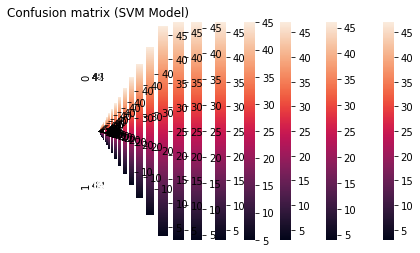

In [26]:
# Initialize variables to store results
shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    # Creating and running our optimization

    study_svm = optuna.create_study(direction='maximize',study_name ="SVM")

    with parallel_backend('threading'):
        study_svm.optimize(objective_svm, n_trials=10, n_jobs=-1)
    # Evaluating our Optuna Trial
    print("Best trial:", study_svm.best_trial.number)
    print("Best accuracy:", study_svm.best_trial.value)
    print("Best hyperparameters:", study_svm.best_params)
    best_param_svm = study_svm.best_params
    SVM = SVC(**best_param_svm,random_state=rs).fit(x_train_,y_train)
    y_pred_svm = SVM.predict(x_test_)


    display_results(y_test, y_pred_svm, cm_title = "Confusion matrix (SVM Model)")

    
    
    # SHAP value computation using parallel processing
    num_cores = -1  # Use all available cores
    shap_values = compute_shap_values(SVM, x_test_, num_cores)


    # Extract SHAP values
    shap_values_array = abs(shap_values)

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)



In [27]:
all_shap_values_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,0.029250,0.193964,0.000774,0.001774,0.091226,0.048012,0.036631,0.011631,0
1,0.062571,0.160310,0.002048,0.099095,0.144595,0.002286,0.046071,0.029881,0
2,0.049762,0.150571,0.011929,0.040571,0.186024,0.058024,0.037095,0.003214,0
3,0.035643,0.159381,0.006452,0.041286,0.140905,0.037786,0.010643,0.011762,0
4,0.001083,0.115298,0.006655,0.002012,0.156036,0.028107,0.013583,0.017226,0
...,...,...,...,...,...,...,...,...,...
4995,0.205036,0.200488,0.018393,0.109464,0.024131,0.135679,0.065750,0.077607,1
4996,0.060286,0.117167,0.001357,0.177714,0.123071,0.123000,0.013333,0.001119,1
4997,0.188250,0.312440,0.002988,0.366155,0.011607,0.043845,0.045655,0.154440,1
4998,0.012679,0.206560,0.004417,0.069202,0.212964,0.082012,0.030726,0.026798,1


In [28]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]
        



In [29]:
# Call the add_to_df function to populate valuestability
add_to_df()
valuestability

cv = valuestability.sum(axis=1) / valuestability.shape[1]
valuestability['CV'] = cv

# Save the DataFrame to an Excel file
valuestability.to_excel('20_svm_valuestability.xlsx', index=False)
valuestability

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,CV
0,0.305563,0.083100,1.092441,0.712263,0.256993,0.604465,0.444774,0.515060,0.501832
1,0.642534,0.093134,0.894354,0.639065,0.055410,0.670582,0.413807,0.424123,0.479126
2,0.548767,0.200941,1.017668,0.150318,0.357093,0.516925,0.432070,0.740831,0.495577
3,0.295457,0.132608,0.964860,0.327198,0.296725,0.654023,0.675161,0.637488,0.497940
4,1.033446,0.319259,1.049543,0.604459,0.293355,0.556333,0.356616,0.599368,0.601548
...,...,...,...,...,...,...,...,...,...
95,0.492944,0.629369,1.055087,0.454440,1.152653,0.533479,0.639595,0.697951,0.706940
96,0.704014,0.689799,2.222138,0.301075,0.297444,0.395528,0.645350,1.747575,0.875365
97,0.632719,0.274423,1.698974,0.382691,0.797292,0.263630,0.947032,0.369064,0.670728
98,0.509795,0.690998,0.567418,0.085812,0.237504,0.710088,0.621024,0.757192,0.522479


## Xgboost

In [30]:
df = pd.read_csv("data_resampled_50.csv")
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)

def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))



In [31]:
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score

def objective_xgb(trial: optuna.Trial):
    # Assume the data is already split into x_train_ and y_train_
    n_minority = y_train.sum()  # Number of minority class instances (assume minority class is '1')
    n_majority = len(y_train) - n_minority  # Number of majority class instances (assume majority class is '0')
    
    # Calculate scale_pos_weight
    scale_pos_weight = n_majority / n_minority
    
    # Define hyperparameters
    param_xgb = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': 0.1,  # Fixed at 0.1 as per your instructions
        'n_estimators': 200,  # Fixed at 200
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e1),
        'scale_pos_weight': scale_pos_weight  # Calculated to handle class imbalance
    }

    # Create and evaluate the XGBoost model
    xgb_model = xgb.XGBClassifier(**param_xgb, use_label_encoder=False, eval_metric='logloss', random_state=123)
    score = cross_val_score(xgb_model, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

# Example usage:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective_xgb, n_trials=100)


[I 2024-08-26 17:23:05,056] A new study created in memory with name: XGBoost
[I 2024-08-26 17:23:11,548] Trial 2 finished with value: 0.8727230029119271 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.5009592193696498, 'colsample_bytree': 0.7514840543998766, 'reg_alpha': 0.1672300038543054, 'reg_lambda': 0.4715000311912665}. Best is trial 2 with value: 0.8727230029119271.
[I 2024-08-26 17:23:11,607] Trial 1 finished with value: 0.8759660044359937 and parameters: {'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.5256566768499518, 'colsample_bytree': 0.891575046948592, 'reg_alpha': 0.0007818330639667408, 'reg_lambda': 0.021830048251893185}. Best is trial 1 with value: 0.8759660044359937.
[I 2024-08-26 17:23:12,618] Trial 3 finished with value: 0.8848553326438418 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.9961301122545011, 'colsample_bytree': 0.8958720895762855, 'reg_alpha': 1.6031111915398897, 'reg_lambda': 0.05518972050902487}. Bes

Best trial: 3
Best accuracy: 0.8848553326438418
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.9961301122545011, 'colsample_bytree': 0.8958720895762855, 'reg_alpha': 1.6031111915398897, 'reg_lambda': 0.05518972050902487}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.053776  0.879803       0.029661       0.204018  0.328064  0.507745   
1      0.245674  0.955751       0.018048       0.324652  2.711281  0.554755   
2      0.339103  1.068121       0.158615       0.393837  0.597116  0.600677   
3      0.197477  0.715830       0.152002       0.470680  2.863276  0.451950   
4      0.003850  1.178809  

[I 2024-08-26 17:23:25,447] Trial 4 finished with value: 0.8746239814719925 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.5708879695209103, 'colsample_bytree': 0.704976460832115, 'reg_alpha': 5.3319740092505654e-05, 'reg_lambda': 0.0005339817433787822}. Best is trial 4 with value: 0.8746239814719925.
[I 2024-08-26 17:23:25,493] Trial 0 finished with value: 0.8749043439222166 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.6898108802411684, 'colsample_bytree': 0.5867828922027424, 'reg_alpha': 0.009954363890229535, 'reg_lambda': 1.311633331934345}. Best is trial 0 with value: 0.8749043439222166.
[I 2024-08-26 17:23:26,873] Trial 3 finished with value: 0.8801794512108391 and parameters: {'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.7157606568601407, 'colsample_bytree': 0.5678870742688413, 'reg_alpha': 4.508034255694108, 'reg_lambda': 1.354032136541127}. Best is trial 3 with value: 0.8801794512108391.
[I 2024-08-26 17:23:27,489] Tr

Best trial: 2
Best accuracy: 0.885303176106834
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.9959786698059951, 'colsample_bytree': 0.9146836543647509, 'reg_alpha': 1.1155419034436094, 'reg_lambda': 1.3244884510921766}
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.023327  1.003884       0.004979       0.526460  0.209580  0.409622   
1      0.020838  1.022530       0.173670       0.405435  2.892562  0.734937   
2      0.034400  1.095855       0.143289       0.292601  0.576923  0.614621   
3      0.036784  0.677278       0.202682       0.515132  3.227153  0.276820   
4      0.155861  1.378458    

[I 2024-08-26 17:23:42,176] Trial 3 finished with value: 0.8758480074606958 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.634596423265853, 'colsample_bytree': 0.9844961752552179, 'reg_alpha': 2.6086961093720835, 'reg_lambda': 0.012481799112084153}. Best is trial 3 with value: 0.8758480074606958.
[I 2024-08-26 17:23:43,255] Trial 0 finished with value: 0.8881308219379188 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.7639178281842082, 'colsample_bytree': 0.9101700445117904, 'reg_alpha': 3.6610883103668015, 'reg_lambda': 0.011597500063996433}. Best is trial 0 with value: 0.8881308219379188.
[I 2024-08-26 17:23:43,610] Trial 4 finished with value: 0.8810778405672997 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.8406518946044699, 'colsample_bytree': 0.8414368160128853, 'reg_alpha': 0.026812289821852135, 'reg_lambda': 1.0607769764557269}. Best is trial 0 with value: 0.8881308219379188.
[I 2024-08-26 17:23:44,292] Tri

Best trial: 5
Best accuracy: 0.8919844225278325
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8779838772581938, 'colsample_bytree': 0.9475982899006938, 'reg_alpha': 0.006359111571192054, 'reg_lambda': 0.012635127418615508}
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        50
           1       0.93      0.82      0.87        50

    accuracy                           0.88       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.88      0.88       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.362824  2.217909       0.175513       0.772614  0.668859  0.881424   
1      0.144011  0.896186       0.029418       0.528091  4.133533  0.678442   
2      0.167024  1.509957       0.000706       0.367846  2.863904  1.172764   
3      0.328262  0.273071       0.547361       0.771356  4.989378  0.714534   
4      0.033911  2.57215

[I 2024-08-26 17:23:56,897] Trial 5 finished with value: 0.8671664140706834 and parameters: {'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.5820119397087999, 'colsample_bytree': 0.940899608518339, 'reg_alpha': 8.486404714293874, 'reg_lambda': 2.5170067084873404e-05}. Best is trial 5 with value: 0.8671664140706834.
[I 2024-08-26 17:23:57,326] Trial 4 finished with value: 0.8757888093058159 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.5437899505091612, 'colsample_bytree': 0.6518932522686336, 'reg_alpha': 0.014881579487941332, 'reg_lambda': 0.00047375747171655145}. Best is trial 4 with value: 0.8757888093058159.
[I 2024-08-26 17:23:58,297] Trial 2 finished with value: 0.8729020700073004 and parameters: {'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.596497774776281, 'colsample_bytree': 0.9333578534083563, 'reg_alpha': 0.6300335359502706, 'reg_lambda': 0.0036571737272286303}. Best is trial 4 with value: 0.8757888093058159.
[I 2024-08-26 17:23:59,145]

Best trial: 8
Best accuracy: 0.8885246955395165
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.964737905973502, 'colsample_bytree': 0.9947148996455828, 'reg_alpha': 0.08744769843861935, 'reg_lambda': 0.1831973927212029}
              precision    recall  f1-score   support

           0       0.81      0.96      0.88        50
           1       0.95      0.78      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.418528  1.593303       0.093389       0.544409  0.242221  0.241211   
1      0.042520  1.105649       0.030220       0.289014  4.000340  0.895243   
2      0.262503  1.602687       0.479032       0.220579  2.666709  0.785951   
3      0.202605  0.352300       0.364828       0.491301  4.769707  0.025935   
4      0.365760  2.216542   

[I 2024-08-26 17:24:10,989] Trial 0 finished with value: 0.8791637475851702 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.7634404715666367, 'colsample_bytree': 0.8289369076095006, 'reg_alpha': 0.00697621664676002, 'reg_lambda': 0.0001117401835568842}. Best is trial 0 with value: 0.8791637475851702.
[I 2024-08-26 17:24:11,383] Trial 1 finished with value: 0.8737689424619615 and parameters: {'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.6923912223374734, 'colsample_bytree': 0.9664644834232221, 'reg_alpha': 3.409923459713018, 'reg_lambda': 9.456831971358845}. Best is trial 0 with value: 0.8791637475851702.
[I 2024-08-26 17:24:11,472] Trial 5 finished with value: 0.8745593982651846 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.6217445886546016, 'colsample_bytree': 0.8847033493538352, 'reg_alpha': 0.0005840926370257283, 'reg_lambda': 0.20340762340782595}. Best is trial 0 with value: 0.8791637475851702.
[I 2024-08-26 17:24:12,192] Tri

Best trial: 3
Best accuracy: 0.8904752950682738
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9059956597158467, 'colsample_bytree': 0.9035340976659936, 'reg_alpha': 0.102862608412431, 'reg_lambda': 4.143901004025983}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.233197  1.116935       0.092738       0.557318  0.575769  0.293454   
1      0.037236  0.650204       0.202354       0.028597  3.229756  0.693830   
2      0.151865  0.971723       0.145258       0.299272  2.008862  0.794419   
3      0.252648  0.158390       0.207773       0.629194  3.801956  0.354381   
4      0.272129  1.667326     

[I 2024-08-26 17:24:24,594] Trial 4 finished with value: 0.8693597537137724 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.5965148103000718, 'colsample_bytree': 0.5862168223356963, 'reg_alpha': 7.268400520788406, 'reg_lambda': 0.00013097211896963236}. Best is trial 4 with value: 0.8693597537137724.
[I 2024-08-26 17:24:25,385] Trial 0 finished with value: 0.8755016286587538 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.6391238689885903, 'colsample_bytree': 0.8879259962217756, 'reg_alpha': 0.0011571546145381956, 'reg_lambda': 0.00038201438682829495}. Best is trial 0 with value: 0.8755016286587538.
[I 2024-08-26 17:24:26,358] Trial 2 finished with value: 0.8809118138493229 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.7776743519836147, 'colsample_bytree': 0.6717514989581774, 'reg_alpha': 0.016952836005914924, 'reg_lambda': 0.1879982088438725}. Best is trial 2 with value: 0.8809118138493229.
[I 2024-08-26 17:24:26,39

Best trial: 1
Best accuracy: 0.8865789420898387
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.9735361722189814, 'colsample_bytree': 0.8090004644643756, 'reg_alpha': 1.4578171298028281e-05, 'reg_lambda': 0.14854886375087106}
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.93      0.78      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.110964  1.194577       0.108239       0.717617  0.099183  0.106922   
1      0.021652  0.717426       0.122867       0.309139  3.231858  1.084607   
2      0.158316  1.360345       0.282294       0.142139  1.250923  0.880728   
3      0.293364  0.417866       0.316246       0.523805  3.496431  0.039729   
4      0.005381  1.3465

[I 2024-08-26 17:24:39,658] Trial 1 finished with value: 0.8705251314912246 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.5400591115841846, 'colsample_bytree': 0.9396169341767111, 'reg_alpha': 1.2676916568055465, 'reg_lambda': 0.16321909708255067}. Best is trial 1 with value: 0.8705251314912246.
[I 2024-08-26 17:24:40,072] Trial 2 finished with value: 0.871455247422126 and parameters: {'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.5898980549007541, 'colsample_bytree': 0.8807700422369105, 'reg_alpha': 0.13120377958100132, 'reg_lambda': 3.51808570216959e-05}. Best is trial 2 with value: 0.871455247422126.
[I 2024-08-26 17:24:40,503] Trial 0 finished with value: 0.8704831027738842 and parameters: {'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.6679329240173022, 'colsample_bytree': 0.6380909445505589, 'reg_alpha': 0.03676431000173216, 'reg_lambda': 0.13347510255332415}. Best is trial 2 with value: 0.871455247422126.
[I 2024-08-26 17:24:41,325] Trial 

Best trial: 7
Best accuracy: 0.8935196052916397
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.9515995130421865, 'colsample_bytree': 0.944177566348565, 'reg_alpha': 0.8981979911544529, 'reg_lambda': 0.009833488031755764}
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.227367  1.465315       0.056239       0.342941  0.444686  0.420925   
1      0.164765  0.751102       0.161195       0.297753  3.315297  0.618505   
2      0.251532  1.156130       0.194383       0.578061  1.420204  1.022643   
3      0.027738  0.256273       0.209453       0.575393  3.915157  0.458365   
4      0.322319  1.686311  

[I 2024-08-26 17:24:54,047] Trial 5 finished with value: 0.8739199490783723 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.6231999578120793, 'colsample_bytree': 0.9038344450646945, 'reg_alpha': 0.007792253046800154, 'reg_lambda': 0.00014402397124414168}. Best is trial 5 with value: 0.8739199490783723.
[I 2024-08-26 17:24:54,264] Trial 4 finished with value: 0.8748842677429514 and parameters: {'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.7267034764127287, 'colsample_bytree': 0.6012693389004999, 'reg_alpha': 2.7018674123316133, 'reg_lambda': 0.0009050945349304383}. Best is trial 4 with value: 0.8748842677429514.
[I 2024-08-26 17:24:54,661] Trial 3 finished with value: 0.8684824451858294 and parameters: {'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.6552347244822554, 'colsample_bytree': 0.7206237832310182, 'reg_alpha': 0.06583335375086485, 'reg_lambda': 0.08520753538707607}. Best is trial 4 with value: 0.8748842677429514.
[I 2024-08-26 17:24:55,6

Best trial: 0
Best accuracy: 0.8830555647078634
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.7928021157642158, 'colsample_bytree': 0.729186810581677, 'reg_alpha': 0.000237302084575179, 'reg_lambda': 0.49336341564997227}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.218244  0.556767       0.200165       0.618479  0.214889  0.245623   
1      0.081928  0.686631       0.271708       0.305759  3.194163  0.845993   
2      0.092746  1.007119       0.067063       0.362917  0.898856  1.172010   
3      0.330319  0.452101       0.155315       0.498496  3.693481  0.425108   
4      0.253907  1.284723 

[I 2024-08-26 17:25:08,330] Trial 5 finished with value: 0.8716129193586204 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.5638459854291402, 'colsample_bytree': 0.6644055973615008, 'reg_alpha': 0.1094336987560696, 'reg_lambda': 0.0006007865749389713}. Best is trial 5 with value: 0.8716129193586204.
[I 2024-08-26 17:25:09,270] Trial 0 finished with value: 0.8758062497161128 and parameters: {'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.6843963443373737, 'colsample_bytree': 0.6583623521050139, 'reg_alpha': 0.6659918745727027, 'reg_lambda': 0.002951269457034713}. Best is trial 0 with value: 0.8758062497161128.
[I 2024-08-26 17:25:10,578] Trial 4 finished with value: 0.8804485188965511 and parameters: {'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.8881798215587857, 'colsample_bytree': 0.7045334134701304, 'reg_alpha': 0.00011249004862055783, 'reg_lambda': 3.8502012536204973}. Best is trial 4 with value: 0.8804485188965511.
[I 2024-08-26 17:25:11,057] 

Best trial: 2
Best accuracy: 0.8862736135988777
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.7165514593596694, 'colsample_bytree': 0.5077966663523685, 'reg_alpha': 3.501729452597957, 'reg_lambda': 0.0015857865008840825}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.059958  0.540820       0.033404       0.360886  0.287619  0.321248   
1      0.018924  0.721559       0.094404       0.237289  2.035449  0.408947   
2      0.170748  0.760430       0.159648       0.407430  1.138444  0.416395   
3      0.228073  0.558270       0.096707       0.364134  2.264961  0.295071   
4      0.107765  1.195309 

[I 2024-08-26 17:25:22,686] Trial 1 finished with value: 0.8771204352966373 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.547920107889537, 'colsample_bytree': 0.9570055673905167, 'reg_alpha': 5.557804074986257, 'reg_lambda': 0.00021949972538281174}. Best is trial 1 with value: 0.8771204352966373.
[I 2024-08-26 17:25:23,139] Trial 4 finished with value: 0.8728097945774652 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.6286997639828198, 'colsample_bytree': 0.5048219472134567, 'reg_alpha': 3.727685735425033e-05, 'reg_lambda': 2.099151334304712e-05}. Best is trial 1 with value: 0.8771204352966373.
[I 2024-08-26 17:25:23,186] Trial 3 finished with value: 0.876175905878833 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.747871510301769, 'colsample_bytree': 0.6073148815800614, 'reg_alpha': 0.06754286522587737, 'reg_lambda': 2.577243735971665}. Best is trial 1 with value: 0.8771204352966373.
[I 2024-08-26 17:25:23,264] T

Best trial: 7
Best accuracy: 0.8856145559199358
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.9485634876021305, 'colsample_bytree': 0.8108277508630655, 'reg_alpha': 0.08738048765916587, 'reg_lambda': 6.7204410317510455}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.025110  0.845681       0.063568       0.324438  0.018159  0.554533   
1      0.090031  1.018494       0.064740       0.405288  3.014534  0.659092   
2      0.094626  1.183373       0.236075       0.634232  0.794322  0.322799   
3      0.025110  0.736372       0.180675       0.620684  3.272216  0.439941   
4      0.158419  1.160728  

[I 2024-08-26 17:25:36,667] Trial 1 finished with value: 0.8739687764954602 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.5595516794644902, 'colsample_bytree': 0.7508849234930737, 'reg_alpha': 0.20456089175584333, 'reg_lambda': 7.027986030403122}. Best is trial 1 with value: 0.8739687764954602.
[I 2024-08-26 17:25:37,026] Trial 5 finished with value: 0.8905181677420235 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.9406026799300602, 'colsample_bytree': 0.9604246353002339, 'reg_alpha': 0.00011477701772135852, 'reg_lambda': 7.191191929815623e-05}. Best is trial 5 with value: 0.8905181677420235.
[I 2024-08-26 17:25:37,157] Trial 2 finished with value: 0.8724902725593676 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.5975765732294953, 'colsample_bytree': 0.7315295679860878, 'reg_alpha': 0.32456280100560453, 'reg_lambda': 0.01666383645604011}. Best is trial 5 with value: 0.8905181677420235.
[I 2024-08-26 17:25:37,761]

Best trial: 5
Best accuracy: 0.8905181677420235
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.9406026799300602, 'colsample_bytree': 0.9604246353002339, 'reg_alpha': 0.00011477701772135852, 'reg_lambda': 7.191191929815623e-05}
              precision    recall  f1-score   support

           0       0.80      0.94      0.86        50
           1       0.93      0.76      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.760087  1.770128       0.282346       0.453014  0.069014  0.444109   
1      0.112692  0.902543       0.311881       0.040512  4.252640  0.904841   
2      0.079464  1.636891       0.892721       0.700388  3.417084  0.716442   
3      0.047025  0.300384       0.566469       0.883103  4.837603  0.371569   
4      0.189086  3.23

[I 2024-08-26 17:25:50,036] Trial 2 finished with value: 0.8746511124527555 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.5376171307625205, 'colsample_bytree': 0.9630654891338591, 'reg_alpha': 0.0005418592932801068, 'reg_lambda': 2.4738653781413484}. Best is trial 2 with value: 0.8746511124527555.
[I 2024-08-26 17:25:50,303] Trial 5 finished with value: 0.8768014255246759 and parameters: {'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.534401890105926, 'colsample_bytree': 0.8885868805482291, 'reg_alpha': 0.4512644187958199, 'reg_lambda': 0.0007332900183240424}. Best is trial 5 with value: 0.8768014255246759.
[I 2024-08-26 17:25:51,423] Trial 3 finished with value: 0.8789857444035934 and parameters: {'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.7821507254054607, 'colsample_bytree': 0.7425456011529967, 'reg_alpha': 0.0012118086839254562, 'reg_lambda': 0.0008066715177915418}. Best is trial 3 with value: 0.8789857444035934.
[I 2024-08-26 17:25:52,01

Best trial: 4
Best accuracy: 0.8872241417699114
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9011720740555069, 'colsample_bytree': 0.5074274732952941, 'reg_alpha': 2.83296705394261, 'reg_lambda': 0.11403138968279952}
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.142210  0.708550       0.085014       0.245532  0.142446  0.681533   
1      0.049203  0.724015       0.093900       0.055492  2.489991  0.397021   
2      0.132506  0.800157       0.220355       0.249452  1.233659  0.453257   
3      0.217463  0.415244       0.424942       0.287112  2.806639  0.566078   
4      0.004633  1.154625    

[I 2024-08-26 17:26:04,597] Trial 1 finished with value: 0.8743152594682649 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.5308932397515178, 'colsample_bytree': 0.8978853690901571, 'reg_alpha': 1.9500358863097018e-05, 'reg_lambda': 0.0001832732884302961}. Best is trial 1 with value: 0.8743152594682649.
[I 2024-08-26 17:26:04,701] Trial 3 finished with value: 0.8734144809439536 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.6196549977639662, 'colsample_bytree': 0.708033453668794, 'reg_alpha': 8.494036867694963e-05, 'reg_lambda': 0.013179299520429821}. Best is trial 1 with value: 0.8743152594682649.
[I 2024-08-26 17:26:05,482] Trial 0 finished with value: 0.8787494498397854 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.9400027156341859, 'colsample_bytree': 0.6967481037553036, 'reg_alpha': 0.13429870591416948, 'reg_lambda': 0.002219113064170959}. Best is trial 0 with value: 0.8787494498397854.
[I 2024-08-26 17:26

Best trial: 5
Best accuracy: 0.8892090445420502
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.9892484515854605, 'colsample_bytree': 0.8484940644656239, 'reg_alpha': 1.161545405712177, 'reg_lambda': 0.0005715264067461805}
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.248739  0.799627       0.003499       0.560567  0.343720  0.247644   
1      0.180422  0.826355       0.091634       0.251650  3.115003  0.880441   
2      0.222550  0.949945       0.249710       0.291461  0.821769  0.664216   
3      0.139782  0.539278       0.179281       0.550668  3.375986  0.357847   
4      0.060718  1.257233

[I 2024-08-26 17:26:18,611] Trial 4 finished with value: 0.8782777662549703 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.7066053803027103, 'colsample_bytree': 0.886160035633868, 'reg_alpha': 0.0007020541203838595, 'reg_lambda': 5.602284121599704}. Best is trial 4 with value: 0.8782777662549703.
[I 2024-08-26 17:26:19,031] Trial 5 finished with value: 0.8743361163919462 and parameters: {'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.677043365741292, 'colsample_bytree': 0.7815998701622363, 'reg_alpha': 0.40528073539375864, 'reg_lambda': 0.0019332488365115712}. Best is trial 4 with value: 0.8782777662549703.
[I 2024-08-26 17:26:19,285] Trial 3 finished with value: 0.8716907309834052 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.6211591197123484, 'colsample_bytree': 0.6867640381685245, 'reg_alpha': 1.8379812959934336, 'reg_lambda': 0.003431186751364036}. Best is trial 4 with value: 0.8782777662549703.
[I 2024-08-26 17:26:19,606] T

Best trial: 2
Best accuracy: 0.8834486881032306
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.792140672025492, 'colsample_bytree': 0.6487270912386018, 'reg_alpha': 0.08711071770825139, 'reg_lambda': 0.06346087700465813}
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        50
           1       0.87      0.78      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.248040  0.853851       0.026301       0.592737  0.283066  0.445558   
1      0.103786  0.892656       0.018910       0.415736  2.952928  1.138362   
2      0.135581  1.048559       0.290437       0.447757  0.861409  0.673996   
3      0.051061  0.738449       0.254685       0.550113  3.229975  0.504578   
4      0.095650  1.221922  

[I 2024-08-26 17:26:32,643] Trial 5 finished with value: 0.873242768070523 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.5982266196373295, 'colsample_bytree': 0.5552140426008105, 'reg_alpha': 1.2287421352910395, 'reg_lambda': 0.04566106200690419}. Best is trial 5 with value: 0.873242768070523.
[I 2024-08-26 17:26:33,154] Trial 2 finished with value: 0.8805134970547422 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.791020053902503, 'colsample_bytree': 0.9926546039700513, 'reg_alpha': 2.4766399706451354e-05, 'reg_lambda': 1.078201041512086}. Best is trial 2 with value: 0.8805134970547422.
[I 2024-08-26 17:26:33,522] Trial 1 finished with value: 0.8730391326772836 and parameters: {'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.5033270205826224, 'colsample_bytree': 0.5762801572415477, 'reg_alpha': 0.003935941042687881, 'reg_lambda': 0.001244644045386436}. Best is trial 2 with value: 0.8805134970547422.
[I 2024-08-26 17:26:34,425] Tria

Best trial: 8
Best accuracy: 0.8877490775778674
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.8539870258236484, 'colsample_bytree': 0.9654472025954001, 'reg_alpha': 0.0010662484086450283, 'reg_lambda': 0.00012988239983286297}
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.93      0.78      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.694554  1.328847       0.019307       0.822948  0.071212  0.754758   
1      0.078254  1.044893       0.286985       0.434278  3.909895  0.753101   
2      0.348667  1.426440       0.023251       0.500855  2.671728  0.917908   
3      0.108313  0.814224       0.216423       0.767328  5.228838  0.580448   
4      0.356872  2.18

[I 2024-08-26 17:26:47,421] Trial 1 finished with value: 0.8844426092104718 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.9369467992061605, 'colsample_bytree': 0.8150786980615654, 'reg_alpha': 2.4098953763317192, 'reg_lambda': 0.5719021869044817}. Best is trial 1 with value: 0.8844426092104718.
[I 2024-08-26 17:26:47,992] Trial 2 finished with value: 0.8721544212524843 and parameters: {'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.6300360907934826, 'colsample_bytree': 0.5072751479161942, 'reg_alpha': 0.0010434801410809194, 'reg_lambda': 3.693461120766504e-05}. Best is trial 1 with value: 0.8844426092104718.
[I 2024-08-26 17:26:48,376] Trial 3 finished with value: 0.8828670662016596 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.9887913666817598, 'colsample_bytree': 0.8758550646297009, 'reg_alpha': 1.4410711186864598e-05, 'reg_lambda': 4.470992443390418e-05}. Best is trial 1 with value: 0.8844426092104718.
[I 2024-08-26 17:26:48,6

Best trial: 6
Best accuracy: 0.8889217028174164
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.7140098459703494, 'colsample_bytree': 0.9534237717774698, 'reg_alpha': 0.001035901820704817, 'reg_lambda': 1.4438224622333811e-05}
              precision    recall  f1-score   support

           0       0.80      0.94      0.86        50
           1       0.93      0.76      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.500935  1.685275       0.117566       0.883371  0.227279  0.268613   
1      0.283195  0.751940       0.026905       0.076019  4.104887  0.679059   
2      0.294870  1.540107       0.087606       0.385121  2.956695  0.292628   
3      0.083402  0.532843       0.113715       0.751782  5.182961  0.255249   
4      0.289085  2.371

[I 2024-08-26 17:27:02,558] Trial 4 finished with value: 0.8882581485093987 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.9251920797505674, 'colsample_bytree': 0.6849923080771324, 'reg_alpha': 0.007068420552864469, 'reg_lambda': 0.9960585139839901}. Best is trial 4 with value: 0.8882581485093987.
[I 2024-08-26 17:27:02,681] Trial 2 finished with value: 0.8845954802208486 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8850944986319265, 'colsample_bytree': 0.6546053708249018, 'reg_alpha': 0.11989234836594753, 'reg_lambda': 7.211553824101936e-05}. Best is trial 4 with value: 0.8882581485093987.
[I 2024-08-26 17:27:03,223] Trial 0 finished with value: 0.8820881922060441 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.8416955923920515, 'colsample_bytree': 0.5607039060500512, 'reg_alpha': 0.0030782691080550625, 'reg_lambda': 0.01742147938798353}. Best is trial 4 with value: 0.8882581485093987.
[I 2024-08-26 17:27:03,666]

Best trial: 4
Best accuracy: 0.8882581485093987
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.9251920797505674, 'colsample_bytree': 0.6849923080771324, 'reg_alpha': 0.007068420552864469, 'reg_lambda': 0.9960585139839901}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.140737  1.037002       0.111883       0.882028  0.042775  0.057871   
1      0.011479  0.934209       0.232770       0.058093  3.480563  0.903955   
2      0.078778  1.521155       0.315881       0.664837  2.268915  0.833173   
3      0.289118  0.658443       0.251474       0.593034  3.939265  0.088788   
4      0.243374  2.399061 

[I 2024-08-26 17:27:08,971] A new study created in memory with name: XGBoost
[I 2024-08-26 17:27:15,533] Trial 3 finished with value: 0.877525230621092 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.5404760135158236, 'colsample_bytree': 0.9742480000016895, 'reg_alpha': 0.053564435019929975, 'reg_lambda': 2.7506273481675}. Best is trial 3 with value: 0.877525230621092.
[I 2024-08-26 17:27:16,303] Trial 0 finished with value: 0.8774258946559692 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.8008268308860549, 'colsample_bytree': 0.6469148999962098, 'reg_alpha': 0.8824770658508161, 'reg_lambda': 3.706299203488068}. Best is trial 3 with value: 0.877525230621092.
[I 2024-08-26 17:27:17,036] Trial 1 finished with value: 0.8756854299271644 and parameters: {'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.5521480792219238, 'colsample_bytree': 0.7908633393321074, 'reg_alpha': 0.3598822090001406, 'reg_lambda': 0.006000523261065903}. Best is t

Best trial: 4
Best accuracy: 0.8857949428845866
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.995962840427131, 'colsample_bytree': 0.7985933140974035, 'reg_alpha': 0.0034261284890827353, 'reg_lambda': 0.13527736996584033}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.178075  1.267370       0.112563       0.578346  0.028867  0.019693   
1      0.166467  0.976619       0.140014       0.426651  3.173673  0.747601   
2      0.251932  1.237403       0.222699       0.471992  0.792252  0.652891   
3      0.218288  0.793497       0.245210       0.623439  3.374929  0.238397   
4      0.145810  1.363695

[I 2024-08-26 17:27:23,613] A new study created in memory with name: XGBoost
[I 2024-08-26 17:27:30,608] Trial 1 finished with value: 0.8748015239405121 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.539669728172429, 'colsample_bytree': 0.9832937119468308, 'reg_alpha': 7.399659689713494, 'reg_lambda': 0.00037231593883064047}. Best is trial 1 with value: 0.8748015239405121.
[I 2024-08-26 17:27:32,317] Trial 5 finished with value: 0.8842024136973649 and parameters: {'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.8439497362502684, 'colsample_bytree': 0.8729708451737402, 'reg_alpha': 0.4424165980265326, 'reg_lambda': 1.5866367454316443}. Best is trial 5 with value: 0.8842024136973649.
[I 2024-08-26 17:27:32,837] Trial 2 finished with value: 0.8850153958467772 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.6856050648269509, 'colsample_bytree': 0.805579998043999, 'reg_alpha': 0.0009869964391383992, 'reg_lambda': 0.00031914056219069833}. 

Best trial: 0
Best accuracy: 0.8906959255218303
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9710330900090771, 'colsample_bytree': 0.9521360931142, 'reg_alpha': 3.6764169735708725, 'reg_lambda': 0.00010580782797272277}
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029378  0.825486       0.065615       0.276947  0.431791  0.263308   
1      0.069896  0.675531       0.112148       0.021734  2.191050  0.269548   
2      0.028507  0.824336       0.042769       0.198107  1.174666  0.247547   
3      0.101274  0.474729       0.128078       0.599808  2.336124  0.130072   
4      0.034461  0.993599 

[I 2024-08-26 17:27:39,750] A new study created in memory with name: XGBoost
[I 2024-08-26 17:27:46,330] Trial 1 finished with value: 0.8732361373546295 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.5017344694262036, 'colsample_bytree': 0.544864576336962, 'reg_alpha': 1.901139586278422, 'reg_lambda': 0.12326032826848285}. Best is trial 1 with value: 0.8732361373546295.
[I 2024-08-26 17:27:46,361] Trial 5 finished with value: 0.8744417537840755 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.6739085767623069, 'colsample_bytree': 0.5257088228677689, 'reg_alpha': 0.0001616361831634544, 'reg_lambda': 3.1725872032857083}. Best is trial 5 with value: 0.8744417537840755.
[I 2024-08-26 17:27:46,997] Trial 0 finished with value: 0.8778222743241599 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.8157783565421546, 'colsample_bytree': 0.9327442557457829, 'reg_alpha': 0.000241130502749408, 'reg_lambda': 0.17612594682457994}. Bes

Best trial: 4
Best accuracy: 0.8871933135159205
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9092712531605099, 'colsample_bytree': 0.912056259133496, 'reg_alpha': 0.1292870393970562, 'reg_lambda': 3.4309162862127104e-05}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 17:27:54,223] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.462416  1.037579       0.083354       0.666072  0.627786  0.159899   
1      0.149415  0.864653       0.005013       0.527074  4.173591  0.730527   
2      0.262693  1.182843       0.361795       0.357675  1.657929  0.869453   
3      0.095537  0.577232       0.226276       0.650639  4.418571  0.010033   
4      0.310316  1.999603       0.522410       0.612952  1.415310  0.597330   
..          ...       ...            ...            ...       ...       ...   
95     0.379310  0.254895       0.874364       0.056956  0.432413  0.434446   
96     0.150730  3.512379       0.472463       0.184078  1.900121  1.217065   
97     0.003051  3.487245       0.212784       0.815696  1.756234  0.296157   
98     0.028820  0.265815       0.558839       0.202846  5.283496  0.203253   
99     0.233699  2.935317       0.118684       0.472301  0.144655  0.510921   

         DPF       Age  Outcome  
0   0.670136  1.0

[I 2024-08-26 17:28:01,162] Trial 0 finished with value: 0.8705864902097165 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.675922821748062, 'colsample_bytree': 0.6437842580162771, 'reg_alpha': 3.155679412450708e-05, 'reg_lambda': 0.016460412744561097}. Best is trial 0 with value: 0.8705864902097165.
[I 2024-08-26 17:28:01,334] Trial 3 finished with value: 0.8739128881503411 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.59719781399437, 'colsample_bytree': 0.827820166591686, 'reg_alpha': 2.236575866621035e-05, 'reg_lambda': 6.62813097509985e-05}. Best is trial 3 with value: 0.8739128881503411.
[I 2024-08-26 17:28:02,515] Trial 2 finished with value: 0.8786288967588051 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.9143583501799968, 'colsample_bytree': 0.5468210315583224, 'reg_alpha': 0.00437942308965424, 'reg_lambda': 2.2193910303219813}. Best is trial 2 with value: 0.8786288967588051.
[I 2024-08-26 17:28:02,626] 

Best trial: 9
Best accuracy: 0.8827958008502431
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.960084896643284, 'colsample_bytree': 0.6963861126257238, 'reg_alpha': 0.06351398459601101, 'reg_lambda': 0.08163708293296466}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 17:28:08,846] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.501009  0.947627       0.067523       0.676965  0.382505  0.254597   
1      0.001939  0.689827       0.059004       0.196345  3.689714  0.815974   
2      0.096590  0.899743       0.301165       0.251601  1.196590  1.122126   
3      0.026750  0.186481       0.226020       0.444277  4.330737  0.366726   
4      0.521403  1.826010       0.534916       0.659034  1.188622  0.637942   
..          ...       ...            ...            ...       ...       ...   
95     0.254426  0.327052       0.762337       0.458958  1.106208  0.718894   
96     0.105503  2.745456       0.335134       0.069827  2.660543  1.922924   
97     0.081976  2.539186       0.016038       0.434269  1.202688  0.304474   
98     0.139681  0.615952       0.507446       0.149677  4.906663  0.213570   
99     0.176317  2.640832       0.235605       0.456622  0.395251  0.491679   

         DPF       Age  Outcome  
0   0.698771  0.6

[I 2024-08-26 17:28:15,232] Trial 4 finished with value: 0.8751967109860526 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.6413150715298102, 'colsample_bytree': 0.7217723167379448, 'reg_alpha': 6.1032199163285625, 'reg_lambda': 5.164947973755465e-05}. Best is trial 4 with value: 0.8751967109860526.
[I 2024-08-26 17:28:15,891] Trial 3 finished with value: 0.8798720805043062 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.9446520768005688, 'colsample_bytree': 0.6962435567371164, 'reg_alpha': 0.026145479398196905, 'reg_lambda': 0.6651731458933213}. Best is trial 3 with value: 0.8798720805043062.
[I 2024-08-26 17:28:15,996] Trial 0 finished with value: 0.8802629012537979 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.9330233121929083, 'colsample_bytree': 0.9203508526058548, 'reg_alpha': 0.3127850818753561, 'reg_lambda': 0.2362064690106188}. Best is trial 0 with value: 0.8802629012537979.
[I 2024-08-26 17:28:16,594] Tri

Best trial: 2
Best accuracy: 0.8848700568005361
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.7589612270314507, 'colsample_bytree': 0.7275772331541644, 'reg_alpha': 2.8375791385354323, 'reg_lambda': 4.3070261147429655e-05}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 17:28:22,352] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.049839  0.947577       0.069953       0.471237  0.164562  0.558824   
1      0.001619  0.773739       0.010534       0.338589  2.499667  0.692638   
2      0.014140  0.840484       0.216032       0.378938  0.832330  0.580251   
3      0.021573  0.637662       0.099264       0.368011  2.792794  0.607033   
4      0.205767  1.163531       0.136825       0.505942  0.855674  0.561199   
..          ...       ...            ...            ...       ...       ...   
95     0.001316  0.333832       0.253898       0.573142  0.286952  0.509720   
96     0.059883  2.453086       0.029880       0.162524  1.041003  0.871398   
97     0.379780  1.791457       0.006768       0.269614  0.727024  0.091876   
98     0.271702  0.873276       0.077874       0.116967  3.632850  0.000216   
99     0.006314  1.825257       0.062307       0.153369  0.052614  0.106769   

         DPF       Age  Outcome  
0   0.564854  0.8

[I 2024-08-26 17:28:29,256] Trial 3 finished with value: 0.8799148512504974 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.7853868705337506, 'colsample_bytree': 0.6752659238235987, 'reg_alpha': 0.0006042386420359605, 'reg_lambda': 3.9726699202860916}. Best is trial 3 with value: 0.8799148512504974.
[I 2024-08-26 17:28:29,352] Trial 5 finished with value: 0.883385746135138 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8030855954490181, 'colsample_bytree': 0.7562600762445242, 'reg_alpha': 0.0023407050461369764, 'reg_lambda': 0.0014259570829142016}. Best is trial 5 with value: 0.883385746135138.
[I 2024-08-26 17:28:29,474] Trial 4 finished with value: 0.8803461515116736 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.86441255585358, 'colsample_bytree': 0.9226762214901083, 'reg_alpha': 0.015590907555854199, 'reg_lambda': 2.140398940032171}. Best is trial 5 with value: 0.883385746135138.
[I 2024-08-26 17:28:30,896] Tri

Best trial: 2
Best accuracy: 0.8862580875393504
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.8778694721318331, 'colsample_bytree': 0.5816464035219184, 'reg_alpha': 0.0001093670303660669, 'reg_lambda': 7.586424455215644e-05}
              precision    recall  f1-score   support

           0       0.83      0.90      0.87        50
           1       0.89      0.82      0.85        50

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100



[I 2024-08-26 17:28:35,933] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.289744  0.809332       0.078994       0.387089  0.270247  0.632042   
1      0.133720  0.353663       0.401871       0.024517  3.735683  0.862485   
2      0.266273  0.852836       0.176540       0.416154  1.136651  0.815289   
3      0.218673  0.320282       0.281451       0.554920  4.131903  0.725070   
4      0.187238  2.086727       0.261069       0.534363  0.726967  0.417645   
..          ...       ...            ...            ...       ...       ...   
95     0.409535  0.362313       0.624325       0.595436  0.000812  0.795634   
96     0.332267  3.066622       0.469287       0.207291  1.432186  1.325262   
97     0.203652  2.402269       0.032109       0.275521  1.367646  0.231900   
98     0.250134  0.276787       0.268168       0.357894  4.445439  0.003556   
99     0.457281  2.677052       0.023895       0.514866  0.458673  0.361487   

         DPF       Age  Outcome  
0   0.635510  0.3

[I 2024-08-26 17:28:42,614] Trial 1 finished with value: 0.8738157058462659 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.5642407239745115, 'colsample_bytree': 0.923535089570646, 'reg_alpha': 1.0279621476999776, 'reg_lambda': 0.26310505291477776}. Best is trial 1 with value: 0.8738157058462659.
[I 2024-08-26 17:28:43,065] Trial 5 finished with value: 0.8727822571442516 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.5237873811028276, 'colsample_bytree': 0.6496301946767111, 'reg_alpha': 0.24822714441782506, 'reg_lambda': 0.2905610130864231}. Best is trial 1 with value: 0.8738157058462659.
[I 2024-08-26 17:28:43,689] Trial 3 finished with value: 0.8791215553826306 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.821026835355047, 'colsample_bytree': 0.5342069755545951, 'reg_alpha': 4.645284242388425, 'reg_lambda': 5.739798943008843}. Best is trial 3 with value: 0.8791215553826306.
[I 2024-08-26 17:28:44,167] Trial 0 fi

Best trial: 4
Best accuracy: 0.8862642515629853
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.9855891942843464, 'colsample_bytree': 0.84538896020356, 'reg_alpha': 0.003620174844116904, 'reg_lambda': 0.22921633130569963}


[I 2024-08-26 17:28:50,631] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.93      0.78      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.555218  1.580604       0.040854       0.754396  0.741505  1.082415   
1      0.101765  0.882687       0.259178       0.383720  4.013604  0.921371   
2      0.338907  1.142304       0.234588       0.649988  2.844930  0.756076   
3      0.010372  0.394344       0.329068       0.788360  5.069681  0.530475   
4      0.273478  1.802943       0.218929       0.903581  2.516352  0.687955   
..          ...       ...            ...            ...       ...       ...   
95     0.053959  0.644431       0.735292       0.342272  1.701981  0.750075   
96     0.060677  3.468724       0.229702 

[I 2024-08-26 17:28:57,547] Trial 2 finished with value: 0.8741909419481984 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.6244555872065771, 'colsample_bytree': 0.6703048106140673, 'reg_alpha': 0.21880406282249315, 'reg_lambda': 3.93860802952923}. Best is trial 2 with value: 0.8741909419481984.
[I 2024-08-26 17:28:57,728] Trial 4 finished with value: 0.8762158155564032 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.7608004818449046, 'colsample_bytree': 0.6408134334185419, 'reg_alpha': 0.004080200405816869, 'reg_lambda': 0.05763935285404914}. Best is trial 4 with value: 0.8762158155564032.
[I 2024-08-26 17:28:58,602] Trial 0 finished with value: 0.8796423803282739 and parameters: {'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7965099756258684, 'colsample_bytree': 0.5570339031738936, 'reg_alpha': 0.0014966862113413248, 'reg_lambda': 0.00011433055189428518}. Best is trial 0 with value: 0.8796423803282739.
[I 2024-08-26 17:29:00,391

Best trial: 8
Best accuracy: 0.8877609261780678
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.8153625624389773, 'colsample_bytree': 0.9821735295513729, 'reg_alpha': 3.4198395162321242, 'reg_lambda': 1.2848536570210412e-05}


[I 2024-08-26 17:29:06,202] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.031102  0.646430       0.060137       0.166704  0.255766  0.096338   
1      0.232191  0.604843       0.044112       0.139674  2.209507  0.573860   
2      0.133685  0.730105       0.144547       0.188411  1.519369  0.612996   
3      0.146957  0.550016       0.171934       0.490566  2.626345  0.111413   
4      0.103216  1.110565       0.127478       0.321184  0.948410  0.338948   
..          ...       ...            ...            ...       ...       ...   
95     0.362478  0.306654       0.212233       0.469714  0.071253  0.328564   
96     0.096516  2.320756       0.080159 

[I 2024-08-26 17:29:13,076] Trial 4 finished with value: 0.8753460769851875 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.6538890295573383, 'colsample_bytree': 0.9252506696976575, 'reg_alpha': 3.300537536964304e-05, 'reg_lambda': 0.002261349926295041}. Best is trial 4 with value: 0.8753460769851875.
[I 2024-08-26 17:29:13,090] Trial 0 finished with value: 0.8897952200343997 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.9332356867476904, 'colsample_bytree': 0.8146064591195596, 'reg_alpha': 4.026200109496248, 'reg_lambda': 0.00019300557201413162}. Best is trial 0 with value: 0.8897952200343997.
[I 2024-08-26 17:29:13,614] Trial 1 finished with value: 0.8736670112021566 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.5953577145128097, 'colsample_bytree': 0.935984537296271, 'reg_alpha': 0.00015146015445326893, 'reg_lambda': 0.0001140291305860057}. Best is trial 0 with value: 0.8897952200343997.
[I 2024-08-26 17:29:14,

Best trial: 0
Best accuracy: 0.8897952200343997
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.9332356867476904, 'colsample_bytree': 0.8146064591195596, 'reg_alpha': 4.026200109496248, 'reg_lambda': 0.00019300557201413162}


[I 2024-08-26 17:29:20,803] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.051075  0.912880       0.083369       0.276753  0.145485  0.406230   
1      0.072573  0.800430       0.008141       0.375865  2.165943  0.548006   
2      0.081763  1.008532       0.137941       0.288164  0.694316  0.263773   
3      0.049327  0.511578       0.102614       0.364152  2.454860  0.436803   
4      0.055483  1.030880       0.150123       0.341858  0.512945  0.509072   
..          ...       ...            ...            ...       ...       ...   
95     0.016378  0.670838       0.214880       0.358131  0.007266  0.434195   
96     0.042529  2.185777       0.060893 

[I 2024-08-26 17:29:27,693] Trial 1 finished with value: 0.8757026369356282 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.7996881152038631, 'colsample_bytree': 0.9312674416725123, 'reg_alpha': 8.756250076782575, 'reg_lambda': 1.1013431879494652e-05}. Best is trial 1 with value: 0.8757026369356282.
[I 2024-08-26 17:29:28,114] Trial 0 finished with value: 0.8769110225075901 and parameters: {'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.615271934257606, 'colsample_bytree': 0.9183721987700482, 'reg_alpha': 0.0025226234413530586, 'reg_lambda': 0.000904034531107651}. Best is trial 0 with value: 0.8769110225075901.
[I 2024-08-26 17:29:28,314] Trial 4 finished with value: 0.8726519069582547 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.6064597804969554, 'colsample_bytree': 0.8761471202512385, 'reg_alpha': 0.004163542636495382, 'reg_lambda': 0.000217649373713505}. Best is trial 0 with value: 0.8769110225075901.
[I 2024-08-26 17:29:28,834

Best trial: 2
Best accuracy: 0.8823041773754895
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.9699733582278416, 'colsample_bytree': 0.5884762784177964, 'reg_alpha': 2.9210916999019138e-05, 'reg_lambda': 1.3599332775915045}


[I 2024-08-26 17:29:34,800] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.177493  0.937737       0.115621       0.627500  0.213772  0.465700   
1      0.331118  0.774018       0.289774       0.223352  3.182449  1.144181   
2      0.107851  1.085639       0.111536       0.475517  1.213710  0.981865   
3      0.238098  0.573142       0.024518       0.598759  3.747535  0.606165   
4      0.024484  1.741401       0.243676       0.735278  1.044845  0.582684   
..          ...       ...            ...            ...       ...       ...   
95     0.528372  0.556137       0.619791       0.628693  0.030512  0.746431   
96     0.186643  3.015031       0.374286 

[I 2024-08-26 17:29:41,157] Trial 5 finished with value: 0.868043890032335 and parameters: {'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.6215795228390677, 'colsample_bytree': 0.7857778534267873, 'reg_alpha': 8.982011708342178, 'reg_lambda': 0.21500939787593987}. Best is trial 5 with value: 0.868043890032335.
[I 2024-08-26 17:29:41,412] Trial 0 finished with value: 0.8701441177935494 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.5083979415434274, 'colsample_bytree': 0.8645112455970319, 'reg_alpha': 0.02377816006909361, 'reg_lambda': 0.39076142868148045}. Best is trial 0 with value: 0.8701441177935494.
[I 2024-08-26 17:29:41,612] Trial 4 finished with value: 0.8775661698352757 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.8412082351781465, 'colsample_bytree': 0.7101062940066964, 'reg_alpha': 0.045220870920894114, 'reg_lambda': 0.02106434409088298}. Best is trial 4 with value: 0.8775661698352757.
[I 2024-08-26 17:29:42,542] Trial 

Best trial: 1
Best accuracy: 0.8871119070238613
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9348867628132864, 'colsample_bytree': 0.7004205831164935, 'reg_alpha': 1.241801858712872, 'reg_lambda': 0.01775756211635239}


[I 2024-08-26 17:29:48,167] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.104968  0.670923       0.150445       0.607457  0.026770  0.425146   
1      0.018061  0.562222       0.064732       0.221370  3.089098  0.936363   
2      0.199558  0.919954       0.124192       0.508275  0.971454  1.014885   
3      0.281137  0.439714       0.153964       0.408622  3.360799  0.365533   
4      0.174847  1.653099       0.322467       0.591488  0.924004  0.475441   
..          ...       ...            ...            ...       ...       ...   
95     0.263934  0.221460       0.513870       0.551348  0.031232  0.505461   
96     0.071304  2.371167       0.240900 

[I 2024-08-26 17:29:54,722] Trial 3 finished with value: 0.875860562448201 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.6730011257335025, 'colsample_bytree': 0.6062101571009417, 'reg_alpha': 0.0026779483640707513, 'reg_lambda': 0.8687956582417153}. Best is trial 3 with value: 0.875860562448201.
[I 2024-08-26 17:29:55,015] Trial 2 finished with value: 0.8715790085034577 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.6308360846848563, 'colsample_bytree': 0.6531169682690859, 'reg_alpha': 0.00010617089422601108, 'reg_lambda': 6.34006846386197}. Best is trial 3 with value: 0.875860562448201.
[I 2024-08-26 17:29:55,275] Trial 1 finished with value: 0.8774910771902106 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.7590496960248052, 'colsample_bytree': 0.9214965342142118, 'reg_alpha': 3.0037123093247564e-05, 'reg_lambda': 0.00020793896626262527}. Best is trial 1 with value: 0.8774910771902106.
[I 2024-08-26 17:29:55,5

Best trial: 8
Best accuracy: 0.8876170754349951
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.970652923783419, 'colsample_bytree': 0.9731448820387533, 'reg_alpha': 0.27008831578808373, 'reg_lambda': 0.28634815526801055}


[I 2024-08-26 17:30:02,392] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.412464  0.720125       0.096745       0.754736  0.376497  0.567922   
1      0.008138  0.832269       0.283771       0.403216  3.174105  0.600256   
2      0.218230  0.841086       0.100999       0.431460  1.422978  1.194170   
3      0.069920  0.234708       0.074403       0.707166  3.829177  0.473236   
4      0.242915  1.665451       0.212514       0.734277  1.352200  0.623347   
..          ...       ...            ...            ...       ...       ...   
95     0.121064  0.681133       0.755300       0.303174  0.237251  0.660490   
96     0.131033  3.005237       0.252405 

[I 2024-08-26 17:30:07,693] Trial 5 finished with value: 0.8767675033061793 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.9710334634735991, 'colsample_bytree': 0.8406500424682466, 'reg_alpha': 8.844955066145205, 'reg_lambda': 0.0018605851424021943}. Best is trial 5 with value: 0.8767675033061793.
[I 2024-08-26 17:30:09,566] Trial 0 finished with value: 0.8854753757092599 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.5815126480720307, 'colsample_bytree': 0.7224115308115029, 'reg_alpha': 4.4389699070203206e-05, 'reg_lambda': 2.0157241908996968e-05}. Best is trial 0 with value: 0.8854753757092599.
[I 2024-08-26 17:30:10,126] Trial 2 finished with value: 0.8805529509321373 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.8651058343650289, 'colsample_bytree': 0.6034648900963636, 'reg_alpha': 2.833067052295352e-05, 'reg_lambda': 3.120619619469088e-05}. Best is trial 0 with value: 0.8854753757092599.
[I 2024-08-26 17:30:1

Best trial: 1
Best accuracy: 0.8877518235568534
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.7712743752762715, 'colsample_bytree': 0.9502630786609846, 'reg_alpha': 2.337968110223526, 'reg_lambda': 4.209077274087089}


[I 2024-08-26 17:30:15,851] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.121314  1.149707       0.080331       0.020934  0.212834  0.518123   
1      0.051095  0.888145       0.074631       0.224716  2.507670  0.606799   
2      0.048095  1.098089       0.167160       0.443835  0.797160  0.764628   
3      0.172121  0.630816       0.063747       0.505061  2.855204  0.433059   
4      0.189840  1.351459       0.176931       0.025239  0.912015  0.496652   
..          ...       ...            ...            ...       ...       ...   
95     0.132166  0.417073       0.493773       0.365604  0.559596  0.408327   
96     0.052821  2.319447       0.011068 

[I 2024-08-26 17:30:22,752] Trial 3 finished with value: 0.8783180253953886 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.8593023757942688, 'colsample_bytree': 0.5440197597115208, 'reg_alpha': 0.000690186618609937, 'reg_lambda': 0.0015152272021779678}. Best is trial 3 with value: 0.8783180253953886.
[I 2024-08-26 17:30:23,026] Trial 5 finished with value: 0.8747377410296743 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.7254769856756413, 'colsample_bytree': 0.9331054038867115, 'reg_alpha': 0.09414975260338565, 'reg_lambda': 0.08171232014361247}. Best is trial 3 with value: 0.8783180253953886.
[I 2024-08-26 17:30:23,284] Trial 4 finished with value: 0.8750342299050754 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.5497265250669647, 'colsample_bytree': 0.8930388966909313, 'reg_alpha': 0.00014141233937219947, 'reg_lambda': 2.3481778269754114e-05}. Best is trial 3 with value: 0.8783180253953886.
[I 2024-08-26 17:30:

Best trial: 9
Best accuracy: 0.8839352903810176
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.9313032593688937, 'colsample_bytree': 0.5189365780411728, 'reg_alpha': 4.831031927412327, 'reg_lambda': 0.00032404608340635597}


[I 2024-08-26 17:30:29,919] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.157071  0.654375       0.051711       0.193848  0.329788  0.537726   
1      0.044313  0.669301       0.062204       0.251715  2.099099  0.301635   
2      0.041101  0.745819       0.082462       0.314507  0.760399  0.574860   
3      0.221855  0.483970       0.051711       0.434496  2.206431  0.387020   
4      0.093493  1.011927       0.082462       0.219362  0.785916  0.421822   
..          ...       ...            ...            ...       ...       ...   
95     0.236441  0.380463       0.194140       0.478993  0.147007  0.233901   
96     0.081438  1.706077       0.041204 

[I 2024-08-26 17:30:36,801] Trial 0 finished with value: 0.8776615271647956 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.7335617536898074, 'colsample_bytree': 0.9265866210998424, 'reg_alpha': 2.1867428775760054e-05, 'reg_lambda': 0.014035194955729163}. Best is trial 0 with value: 0.8776615271647956.
[I 2024-08-26 17:30:36,934] Trial 1 finished with value: 0.868867300884211 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.5131394294058387, 'colsample_bytree': 0.5126671157745053, 'reg_alpha': 0.005619583399930015, 'reg_lambda': 5.810400933110595}. Best is trial 0 with value: 0.8776615271647956.
[I 2024-08-26 17:30:37,563] Trial 5 finished with value: 0.8767377971983845 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.632993464215772, 'colsample_bytree': 0.728853919337116, 'reg_alpha': 3.9156953814512887, 'reg_lambda': 4.2229607167438057e-05}. Best is trial 0 with value: 0.8776615271647956.
[I 2024-08-26 17:30:37,730

Best trial: 9
Best accuracy: 0.883814781035807
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.8459060571291781, 'colsample_bytree': 0.7088063180593965, 'reg_alpha': 0.001223933007390716, 'reg_lambda': 3.8301319390560404e-05}


[I 2024-08-26 17:30:44,587] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.88      0.85        50
           1       0.87      0.80      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.288267  0.586303       0.117261       0.400240  0.116844  0.272000   
1      0.085283  0.647712       0.225580       0.222215  3.386566  1.275018   
2      0.072372  1.044782       0.171386       0.447540  1.062943  0.789237   
3      0.076005  0.538613       0.029149       0.694012  3.643676  0.590058   
4      0.236414  1.608121       0.348352       0.465981  0.852589  0.664914   
..          ...       ...            ...            ...       ...       ...   
95     0.049106  0.172764       0.557775       0.588391  0.239847  0.731373   
96     0.133565  3.070878       0.371884 

[I 2024-08-26 17:30:50,862] Trial 2 finished with value: 0.8718773545238726 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.5460283924782298, 'colsample_bytree': 0.7054497999325879, 'reg_alpha': 6.461975488057135, 'reg_lambda': 0.00011502754231887703}. Best is trial 2 with value: 0.8718773545238726.
[I 2024-08-26 17:30:52,829] Trial 3 finished with value: 0.8838373105323805 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.9337016229256196, 'colsample_bytree': 0.6583526698606594, 'reg_alpha': 0.00018251710298708296, 'reg_lambda': 0.008509725373271966}. Best is trial 3 with value: 0.8838373105323805.
[I 2024-08-26 17:30:52,936] Trial 1 finished with value: 0.8848273954808923 and parameters: {'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.9489040866526264, 'colsample_bytree': 0.7455461282401306, 'reg_alpha': 2.367539783089218, 'reg_lambda': 0.5679323210168079}. Best is trial 1 with value: 0.8848273954808923.
[I 2024-08-26 17:30:53,500] 

Best trial: 9
Best accuracy: 0.888250183057947
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8976310030532499, 'colsample_bytree': 0.9745137277546906, 'reg_alpha': 0.029536444800993978, 'reg_lambda': 8.66531971356572}


[I 2024-08-26 17:30:59,231] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.052170  0.857590       0.141607       0.280425  0.262108  0.615113   
1      0.032642  0.790119       0.110319       0.272971  2.842063  0.705124   
2      0.121473  0.949163       0.113890       0.419754  1.058958  1.012389   
3      0.138060  0.476858       0.070273       0.524114  3.129950  0.506226   
4      0.203888  1.492193       0.204580       0.291678  1.129579  0.760540   
..          ...       ...            ...            ...       ...       ...   
95     0.271659  0.449921       0.338231       0.332955  0.003408  0.648038   
96     0.092808  2.569448       0.167315 

[I 2024-08-26 17:31:05,680] Trial 3 finished with value: 0.8736042097295436 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.578301452533899, 'colsample_bytree': 0.7799355874413118, 'reg_alpha': 0.0013725306515168364, 'reg_lambda': 5.26839965080919}. Best is trial 3 with value: 0.8736042097295436.
[I 2024-08-26 17:31:06,043] Trial 4 finished with value: 0.8750814654922879 and parameters: {'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.8983397386008289, 'colsample_bytree': 0.5887356334143772, 'reg_alpha': 8.675108819913863, 'reg_lambda': 3.304104969454053}. Best is trial 4 with value: 0.8750814654922879.
[I 2024-08-26 17:31:06,410] Trial 2 finished with value: 0.8755322279444164 and parameters: {'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.559784354859161, 'colsample_bytree': 0.8635269679244475, 'reg_alpha': 0.09960040974321192, 'reg_lambda': 0.608363206410688}. Best is trial 2 with value: 0.8755322279444164.
[I 2024-08-26 17:31:07,241] Trial 5 fin

Best trial: 8
Best accuracy: 0.8893628303288039
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.9423438949702174, 'colsample_bytree': 0.99269411604055, 'reg_alpha': 0.003953003228997388, 'reg_lambda': 0.9173590772122716}


[I 2024-08-26 17:31:13,210] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.555528  0.818142       0.072578       0.636661  0.128218  0.366681   
1      0.000123  0.720609       0.095593       0.405402  3.275169  0.684016   
2      0.120987  0.967667       0.382433       0.387786  1.125876  0.874191   
3      0.025170  0.569656       0.121654       0.838181  3.687574  0.420552   
4      0.211351  1.595842       0.598498       0.727101  1.360418  0.538346   
..          ...       ...            ...            ...       ...       ...   
95     0.196406  0.229282       0.874446       0.097366  0.659369  0.598655   
96     0.193999  2.711367       0.342476 

[I 2024-08-26 17:31:19,905] Trial 1 finished with value: 0.8730062044127322 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.5889945161134529, 'colsample_bytree': 0.8078154215092956, 'reg_alpha': 0.06262451643731957, 'reg_lambda': 0.11389733903875014}. Best is trial 1 with value: 0.8730062044127322.
[I 2024-08-26 17:31:20,136] Trial 0 finished with value: 0.8848542981374855 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.9408506006640193, 'colsample_bytree': 0.9372272268797962, 'reg_alpha': 0.0005280937578153335, 'reg_lambda': 0.07300787511738498}. Best is trial 0 with value: 0.8848542981374855.
[I 2024-08-26 17:31:20,320] Trial 5 finished with value: 0.8755435027400302 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.7743611891795081, 'colsample_bytree': 0.514683092836256, 'reg_alpha': 0.17638755463215758, 'reg_lambda': 0.00013626596173787851}. Best is trial 0 with value: 0.8848542981374855.
[I 2024-08-26 17:31:20,866

Best trial: 0
Best accuracy: 0.8848542981374855
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.9408506006640193, 'colsample_bytree': 0.9372272268797962, 'reg_alpha': 0.0005280937578153335, 'reg_lambda': 0.07300787511738498}


[I 2024-08-26 17:31:26,599] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.105429  0.854388       0.032284       0.549529  0.000933  0.246448   
1      0.196260  0.975993       0.225668       0.324799  3.598562  0.852508   
2      0.290957  1.119876       0.267302       0.534625  0.936739  0.469607   
3      0.038279  0.780087       0.315556       0.688012  3.797942  0.185738   
4      0.174067  1.211361       0.355196       0.548912  0.715121  0.564029   
..          ...       ...            ...            ...       ...       ...   
95     0.107642  0.665023       0.498031       0.382391  0.617517  0.712786   
96     0.031208  2.613774       0.345810 

[I 2024-08-26 17:31:32,851] Trial 5 finished with value: 0.8736710825053539 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.5524579913918133, 'colsample_bytree': 0.8131998138583938, 'reg_alpha': 6.342622077352937e-05, 'reg_lambda': 7.494837069263483e-05}. Best is trial 5 with value: 0.8736710825053539.
[I 2024-08-26 17:31:33,343] Trial 1 finished with value: 0.8792735863611177 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.7935728495222261, 'colsample_bytree': 0.9698453209318807, 'reg_alpha': 0.04244109587302374, 'reg_lambda': 2.1760597005247713e-05}. Best is trial 1 with value: 0.8792735863611177.
[I 2024-08-26 17:31:34,725] Trial 2 finished with value: 0.8850594358967636 and parameters: {'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.8337865917913925, 'colsample_bytree': 0.8068706558957315, 'reg_alpha': 1.7997098899222697, 'reg_lambda': 0.0001893220092519057}. Best is trial 2 with value: 0.8850594358967636.
[I 2024-08-26 17:31:36

Best trial: 2
Best accuracy: 0.8850594358967636
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.8337865917913925, 'colsample_bytree': 0.8068706558957315, 'reg_alpha': 1.7997098899222697, 'reg_lambda': 0.0001893220092519057}


[I 2024-08-26 17:31:41,275] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.044759  0.975315       0.020850       0.367409  0.193892  0.332692   
1      0.190430  1.117995       0.014487       0.310571  2.840906  0.778317   
2      0.219975  1.125624       0.222153       0.316475  0.610761  0.661092   
3      0.043586  0.992815       0.223287       0.312485  3.260856  0.471622   
4      0.204817  1.170354       0.259180       0.429589  0.770216  0.563715   
..          ...       ...            ...            ...       ...       ...   
95     0.175015  0.819846       0.226844       0.459965  0.391824  0.519987   
96     0.061296  2.590282       0.104854 

[I 2024-08-26 17:31:48,487] Trial 2 finished with value: 0.8830339808458241 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.8545557743978089, 'colsample_bytree': 0.9588789962106994, 'reg_alpha': 0.38399867578933944, 'reg_lambda': 0.004299352941224215}. Best is trial 2 with value: 0.8830339808458241.
[I 2024-08-26 17:31:49,534] Trial 4 finished with value: 0.8821973923983163 and parameters: {'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.6910931370978874, 'colsample_bytree': 0.8006471754198119, 'reg_alpha': 0.26844426805985966, 'reg_lambda': 0.008641777176703981}. Best is trial 2 with value: 0.8830339808458241.
[I 2024-08-26 17:31:50,619] Trial 5 finished with value: 0.8821853245800804 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.541750207437592, 'colsample_bytree': 0.9442851511549011, 'reg_alpha': 7.58420406733015e-05, 'reg_lambda': 8.604043363392557e-05}. Best is trial 2 with value: 0.8830339808458241.
[I 2024-08-26 17:31:50,761

Best trial: 9
Best accuracy: 0.8857218790678956
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.9899916724502613, 'colsample_bytree': 0.7632844475557505, 'reg_alpha': 0.005916169526185875, 'reg_lambda': 0.0001711480501464781}


[I 2024-08-26 17:31:56,572] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.338622  1.220146       0.101696       0.643849  0.503406  0.029038   
1      0.032809  0.753275       0.237772       0.392285  3.539599  1.266424   
2      0.193789  0.856256       0.282453       0.298261  1.330385  0.861962   
3      0.135596  0.412997       0.140197       0.636199  3.827766  0.220021   
4      0.225770  1.346132       0.344503       0.656138  1.573436  0.595722   
..          ...       ...            ...            ...       ...       ...   
95     0.343518  0.469320       0.929182       0.152251  0.173531  0.851935   
96     0.339960  2.959374       0.392019 

[I 2024-08-26 17:32:03,272] Trial 1 finished with value: 0.8766803362832534 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.8498796410991398, 'colsample_bytree': 0.6038814804506908, 'reg_alpha': 0.00011866036491960914, 'reg_lambda': 2.869034076242084}. Best is trial 1 with value: 0.8766803362832534.
[I 2024-08-26 17:32:03,430] Trial 4 finished with value: 0.8718013444908926 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.5654381428194681, 'colsample_bytree': 0.9070845941855599, 'reg_alpha': 6.341384139766231, 'reg_lambda': 6.830686999603214e-05}. Best is trial 1 with value: 0.8766803362832534.
[I 2024-08-26 17:32:03,694] Trial 0 finished with value: 0.874528721662343 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.6031545751570363, 'colsample_bytree': 0.9298932090304071, 'reg_alpha': 0.07049637145794413, 'reg_lambda': 3.4675008149365}. Best is trial 1 with value: 0.8766803362832534.
[I 2024-08-26 17:32:04,292] Trial

Best trial: 9
Best accuracy: 0.8904370601126468
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9730767180761841, 'colsample_bytree': 0.8580389724968018, 'reg_alpha': 1.5977589722199301, 'reg_lambda': 1.7365995465054748e-05}


[I 2024-08-26 17:32:11,380] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.93      0.78      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.031490  1.039514       0.125469       0.442223  0.090828  0.628024   
1      0.060588  0.556879       0.017951       0.477707  2.767761  0.689521   
2      0.043871  1.086130       0.197280       0.450515  1.644471  0.331535   
3      0.026484  0.151297       0.158903       0.631117  3.405093  0.431819   
4      0.180682  1.171681       0.306680       0.490991  1.351387  0.589481   
..          ...       ...            ...            ...       ...       ...   
95     0.071003  0.504208       0.207775       0.373949  0.137578  0.273933   
96     0.045499  2.504631       0.055249 

[I 2024-08-26 17:32:17,785] Trial 4 finished with value: 0.8739288804358948 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.6648908495206831, 'colsample_bytree': 0.6489478838417604, 'reg_alpha': 6.08444801904634e-05, 'reg_lambda': 2.092458466250979}. Best is trial 4 with value: 0.8739288804358948.
[I 2024-08-26 17:32:18,286] Trial 3 finished with value: 0.8801307316907466 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.9011445765826964, 'colsample_bytree': 0.6531529871251659, 'reg_alpha': 0.0008961604078226593, 'reg_lambda': 0.5947332851199149}. Best is trial 3 with value: 0.8801307316907466.
[I 2024-08-26 17:32:18,806] Trial 5 finished with value: 0.8763221887957634 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.8947113755631197, 'colsample_bytree': 0.8195246949418848, 'reg_alpha': 0.02998702736599387, 'reg_lambda': 0.005363657292380115}. Best is trial 3 with value: 0.8801307316907466.
[I 2024-08-26 17:32:19,165] 

Best trial: 9
Best accuracy: 0.8847350113755168
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.5099661873104128, 'colsample_bytree': 0.9360767685342357, 'reg_alpha': 2.131520927620243e-05, 'reg_lambda': 0.04530827729852376}


[I 2024-08-26 17:32:25,751] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.79      0.88      0.83        50
           1       0.86      0.76      0.81        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.777698  0.859342       0.300696       0.528483  0.109291  0.811980   
1      0.268405  1.855209       0.281817       0.027882  4.401389  0.753387   
2      0.435164  1.180759       0.136162       0.717919  2.419911  1.896723   
3      0.512306  0.919700       0.026510       0.792829  4.484023  0.004811   
4      0.387835  2.745425       0.342416       0.729237  1.954433  1.140935   
..          ...       ...            ...            ...       ...       ...   
95     0.071069  0.205934       0.271959       0.530559  1.288757  1.429598   
96     0.328462  3.470376       0.397336 

[I 2024-08-26 17:32:32,047] Trial 3 finished with value: 0.8661817664162617 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.5681942750171788, 'colsample_bytree': 0.7781049891956372, 'reg_alpha': 7.5110491698617645, 'reg_lambda': 2.56460251015885}. Best is trial 3 with value: 0.8661817664162617.
[I 2024-08-26 17:32:33,121] Trial 1 finished with value: 0.8744883512399523 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.7083333659171847, 'colsample_bytree': 0.9418423187492109, 'reg_alpha': 0.011422778256792086, 'reg_lambda': 0.00022339363031309792}. Best is trial 1 with value: 0.8744883512399523.
[I 2024-08-26 17:32:33,211] Trial 5 finished with value: 0.8749457940884205 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.7898089932019456, 'colsample_bytree': 0.5810913573669527, 'reg_alpha': 0.004841409186281089, 'reg_lambda': 3.315836274935117}. Best is trial 5 with value: 0.8749457940884205.
[I 2024-08-26 17:32:33,468] Tr

Best trial: 7
Best accuracy: 0.8906488484876303
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.9339250018161657, 'colsample_bytree': 0.9189407787786961, 'reg_alpha': 0.26158160269689057, 'reg_lambda': 0.0034322615554360303}


[I 2024-08-26 17:32:40,289] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.93      0.78      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.337638  1.843758       0.022094       0.856259  0.242518  0.240301   
1      0.167387  0.767324       0.060655       0.313708  3.974491  1.299468   
2      0.142533  1.098267       0.476061       0.454302  2.485375  0.737798   
3      0.317856  0.202409       0.299561       0.679113  4.696980  0.785411   
4      0.207255  1.705927       0.523591       0.971760  1.908666  0.623257   
..          ...       ...            ...            ...       ...       ...   
95     0.117103  0.405684       0.737024       0.290370  0.471582  0.623656   
96     0.274484  3.718436       0.242109 

[I 2024-08-26 17:32:46,875] Trial 2 finished with value: 0.8774818874581078 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.8413211171963242, 'colsample_bytree': 0.5488929593195322, 'reg_alpha': 7.668668126985671, 'reg_lambda': 0.1001577419935539}. Best is trial 2 with value: 0.8774818874581078.
[I 2024-08-26 17:32:47,109] Trial 4 finished with value: 0.8766196456682284 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.7196545514763322, 'colsample_bytree': 0.5795207009608666, 'reg_alpha': 0.00046557320700668664, 'reg_lambda': 0.6009642168602676}. Best is trial 2 with value: 0.8774818874581078.
[I 2024-08-26 17:32:47,642] Trial 3 finished with value: 0.8750951570145529 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.77663166474732, 'colsample_bytree': 0.8586997291484275, 'reg_alpha': 1.233293012967251e-05, 'reg_lambda': 1.0832579540042443e-05}. Best is trial 2 with value: 0.8774818874581078.
[I 2024-08-26 17:32:47,705

Best trial: 6
Best accuracy: 0.8867356385466074
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.7886822344808158, 'colsample_bytree': 0.5687982188120904, 'reg_alpha': 0.7769428975532768, 'reg_lambda': 0.00044484929930848656}


[I 2024-08-26 17:32:54,025] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.83      0.90      0.87        50
           1       0.89      0.82      0.85        50

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.339476  1.193066       0.012001       0.483637  0.112344  0.565934   
1      0.334951  0.617185       0.310692       0.191840  3.776441  1.024436   
2      0.007515  1.201676       0.050788       0.356023  2.080868  0.543482   
3      0.307755  0.440010       0.337974       0.260986  4.037386  0.891258   
4      0.140141  2.031993       0.134828       0.591365  1.498520  0.580423   
..          ...       ...            ...            ...       ...       ...   
95     0.570849  0.533575       0.231461       0.679914  0.020379  0.557935   
96     0.476729  2.893571       0.214035 

[I 2024-08-26 17:33:00,460] Trial 3 finished with value: 0.8697855532077121 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.557251844968341, 'colsample_bytree': 0.8331302878896427, 'reg_alpha': 0.00028907154072979477, 'reg_lambda': 0.04398726431660169}. Best is trial 3 with value: 0.8697855532077121.
[I 2024-08-26 17:33:01,366] Trial 2 finished with value: 0.8742594907487212 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.5588556682011712, 'colsample_bytree': 0.7421396818448438, 'reg_alpha': 0.09227451261735704, 'reg_lambda': 6.455450619614994}. Best is trial 2 with value: 0.8742594907487212.
[I 2024-08-26 17:33:02,371] Trial 0 finished with value: 0.8791578712691913 and parameters: {'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8605363555527441, 'colsample_bytree': 0.9664953045685463, 'reg_alpha': 0.002103623156110657, 'reg_lambda': 0.00012034733530681068}. Best is trial 0 with value: 0.8791578712691913.
[I 2024-08-26 17:33:02,506

Best trial: 6
Best accuracy: 0.8854264879058907
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.9566939196320661, 'colsample_bytree': 0.6103430085215953, 'reg_alpha': 3.479848620874027e-05, 'reg_lambda': 5.3100594309530086e-05}


[I 2024-08-26 17:33:08,733] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.038658  0.961100       0.056866       0.331909  0.000331  0.360929   
1      0.145614  0.824407       0.120287       0.289119  3.201378  1.079074   
2      0.076831  1.366670       0.324054       0.505224  0.953625  0.709059   
3      0.285690  0.697700       0.324683       0.562967  3.531348  0.430383   
4      0.034597  1.485277       0.457002       0.673036  0.926214  0.584545   
..          ...       ...            ...            ...       ...       ...   
95     0.080785  0.636024       0.656090       0.662808  0.173103  0.696838   
96     0.223695  2.688418       0.369400 

[I 2024-08-26 17:33:14,753] Trial 4 finished with value: 0.8714777340867319 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.5059727281131502, 'colsample_bytree': 0.7237337349207941, 'reg_alpha': 3.205188162073927e-05, 'reg_lambda': 0.2280773700832428}. Best is trial 4 with value: 0.8714777340867319.
[I 2024-08-26 17:33:15,849] Trial 5 finished with value: 0.8682414355021291 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.5752058237074049, 'colsample_bytree': 0.5995359161489626, 'reg_alpha': 0.05045342631052685, 'reg_lambda': 0.004236037596723434}. Best is trial 4 with value: 0.8714777340867319.
[I 2024-08-26 17:33:15,897] Trial 1 finished with value: 0.8799799233256311 and parameters: {'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.7609950596913846, 'colsample_bytree': 0.8311080473138795, 'reg_alpha': 0.19524207343370958, 'reg_lambda': 0.005541747247943081}. Best is trial 1 with value: 0.8799799233256311.
[I 2024-08-26 17:33:17,092]

Best trial: 2
Best accuracy: 0.8839105407113663
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.941190013913177, 'colsample_bytree': 0.547651079735755, 'reg_alpha': 0.43037875939939735, 'reg_lambda': 5.7892421923489845}


[I 2024-08-26 17:33:22,403] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.055289  0.701011       0.165726       0.229619  0.285389  0.656065   
1      0.029921  0.676742       0.174904       0.044062  3.000507  0.950884   
2      0.221304  0.700164       0.119276       0.362554  0.992963  0.633151   
3      0.365115  0.476651       0.183949       0.505954  3.294721  0.567719   
4      0.052409  1.410634       0.244964       0.325548  0.968087  0.586351   
..          ...       ...            ...            ...       ...       ...   
95     0.450373  0.531045       0.467476       0.519146  0.037969  0.507350   
96     0.164204  2.390017       0.241102 

[I 2024-08-26 17:33:30,231] Trial 3 finished with value: 0.8759615401871426 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.6386890128683417, 'colsample_bytree': 0.5678681770768683, 'reg_alpha': 3.420535334866742, 'reg_lambda': 2.7557128176437913}. Best is trial 3 with value: 0.8759615401871426.
[I 2024-08-26 17:33:31,048] Trial 4 finished with value: 0.8763710101864554 and parameters: {'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.5412741700787571, 'colsample_bytree': 0.5242449309820674, 'reg_alpha': 4.818102572473354, 'reg_lambda': 0.5252758014311649}. Best is trial 4 with value: 0.8763710101864554.
[I 2024-08-26 17:33:32,498] Trial 5 finished with value: 0.8779466815378071 and parameters: {'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.6748183045024206, 'colsample_bytree': 0.7071604928260813, 'reg_alpha': 1.5585902986174753, 'reg_lambda': 0.08073396340820697}. Best is trial 5 with value: 0.8779466815378071.
[I 2024-08-26 17:33:32,943] Trial 2 f

Best trial: 8
Best accuracy: 0.8895820288633263
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9436632528866835, 'colsample_bytree': 0.9704494438873263, 'reg_alpha': 0.0002799156393289596, 'reg_lambda': 0.001661715177797655}


[I 2024-08-26 17:33:39,019] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.375171  1.178506       0.241077       0.558508  0.854720  0.473363   
1      0.211922  0.992208       0.362002       0.169577  3.920334  0.536432   
2      0.598373  0.916918       0.026893       0.383500  1.426655  1.141876   
3      0.417266  0.496683       0.113771       0.391362  4.446599  0.550390   
4      0.202093  1.776545       0.152044       0.377731  1.590265  0.432862   
..          ...       ...            ...            ...       ...       ...   
95     0.354702  0.978146       0.860642       0.211140  0.693071  1.221146   
96     0.169889  3.606094       0.598899 

[I 2024-08-26 17:33:45,478] Trial 1 finished with value: 0.8750526202098957 and parameters: {'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.5141510362215589, 'colsample_bytree': 0.9795424022768024, 'reg_alpha': 0.05213358229137284, 'reg_lambda': 4.506816306245024}. Best is trial 1 with value: 0.8750526202098957.
[I 2024-08-26 17:33:45,603] Trial 3 finished with value: 0.8905017573091472 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.9354264361130877, 'colsample_bytree': 0.8322642834323299, 'reg_alpha': 3.3373888948831545, 'reg_lambda': 0.4186205002957108}. Best is trial 3 with value: 0.8905017573091472.
[I 2024-08-26 17:33:46,186] Trial 5 finished with value: 0.8711993806067797 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.7256427860844493, 'colsample_bytree': 0.9959031280789314, 'reg_alpha': 0.0007463400510404428, 'reg_lambda': 0.0012771863916353468}. Best is trial 3 with value: 0.8905017573091472.
[I 2024-08-26 17:33:47,336] Tr

Best trial: 3
Best accuracy: 0.8905017573091472
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.9354264361130877, 'colsample_bytree': 0.8322642834323299, 'reg_alpha': 3.3373888948831545, 'reg_lambda': 0.4186205002957108}


[I 2024-08-26 17:33:53,017] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.148645  0.732410       0.039802       0.389864  0.342178  0.417796   
1      0.063296  0.713603       0.087002       0.054026  2.252470  0.471001   
2      0.010277  0.963474       0.015239       0.299388  1.166588  0.721068   
3      0.130927  0.446484       0.085509       0.352441  2.660141  0.353042   
4      0.143179  1.187718       0.036939       0.347528  0.932992  0.539921   
..          ...       ...            ...            ...       ...       ...   
95     0.239379  0.408117       0.199296       0.316896  0.136829  0.385709   
96     0.059456  2.046620       0.038608 

[I 2024-08-26 17:34:00,987] Trial 5 finished with value: 0.8869946174886907 and parameters: {'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.9306840174341604, 'colsample_bytree': 0.6828841038094894, 'reg_alpha': 3.22548177719917, 'reg_lambda': 0.16973415712282877}. Best is trial 5 with value: 0.8869946174886907.
[I 2024-08-26 17:34:02,303] Trial 0 finished with value: 0.8829666337267739 and parameters: {'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.870765575033708, 'colsample_bytree': 0.7773143933221347, 'reg_alpha': 0.005848214253969037, 'reg_lambda': 7.473840647429136e-05}. Best is trial 5 with value: 0.8869946174886907.
[I 2024-08-26 17:34:02,384] Trial 1 finished with value: 0.8837809661609819 and parameters: {'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.9722715464854423, 'colsample_bytree': 0.5625837906226262, 'reg_alpha': 0.0011800175853071302, 'reg_lambda': 0.04463984519086299}. Best is trial 5 with value: 0.8869946174886907.
[I 2024-08-26 17:34:02,455] Tr

Best trial: 2
Best accuracy: 0.8878796461281051
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.8707440581537895, 'colsample_bytree': 0.6332216852563209, 'reg_alpha': 0.4263035294030173, 'reg_lambda': 0.0013606134687151386}


[I 2024-08-26 17:34:08,471] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.305852  0.735865       0.112529       0.621335  0.368594  0.530017   
1      0.084961  0.953895       0.506067       0.150621  3.928059  0.892642   
2      0.216480  0.674242       0.219664       0.505682  1.533602  1.213239   
3      0.224465  0.339442       0.283411       0.441514  4.146067  0.265133   
4      0.316440  1.907717       0.438751       0.706363  1.354187  0.683939   
..          ...       ...            ...            ...       ...       ...   
95     0.375280  0.333570       0.709495       0.439120  0.486320  0.747473   
96     0.074302  3.226751       0.033754 

[I 2024-08-26 17:34:15,876] Trial 0 finished with value: 0.8852624838109254 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.8002069907672096, 'colsample_bytree': 0.9039701899411697, 'reg_alpha': 2.3226323910719744, 'reg_lambda': 3.9797539247657925}. Best is trial 0 with value: 0.8852624838109254.
[I 2024-08-26 17:34:16,178] Trial 5 finished with value: 0.8845019833271159 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.8051797848717686, 'colsample_bytree': 0.8995685186720558, 'reg_alpha': 2.343719186506863, 'reg_lambda': 0.19291137154507426}. Best is trial 0 with value: 0.8852624838109254.
[I 2024-08-26 17:34:16,433] Trial 4 finished with value: 0.8747620367682051 and parameters: {'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.6292421002926407, 'colsample_bytree': 0.6605325307095378, 'reg_alpha': 0.030158062580697018, 'reg_lambda': 1.5880167397542495}. Best is trial 0 with value: 0.8852624838109254.
[I 2024-08-26 17:34:16,804] Trial 

Best trial: 6
Best accuracy: 0.8860808712350496
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.7412134098116808, 'colsample_bytree': 0.5040042571109659, 'reg_alpha': 0.0012213440683457475, 'reg_lambda': 0.05718617606627326}


[I 2024-08-26 17:34:23,238] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.83      0.88      0.85        50
           1       0.87      0.82      0.85        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.249321  1.329106       0.151750       0.369444  0.205307  0.782306   
1      0.168842  0.714927       0.173995       0.067885  4.103050  1.178799   
2      0.316036  0.943454       0.244714       0.596349  2.813409  1.112622   
3      0.474159  0.396680       0.129697       0.748147  4.682974  0.484258   
4      0.196072  2.837691       0.202666       0.931063  1.583842  0.795402   
..          ...       ...            ...            ...       ...       ...   
95     0.917483  0.169644       0.522156       1.294344  0.554108  0.855139   
96     0.284684  4.134471       0.050857 

[I 2024-08-26 17:34:29,986] Trial 5 finished with value: 0.8729187095637643 and parameters: {'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.6269970001941436, 'colsample_bytree': 0.6021424790221339, 'reg_alpha': 0.030911393325431854, 'reg_lambda': 4.6066451537501626e-05}. Best is trial 5 with value: 0.8729187095637643.
[I 2024-08-26 17:34:30,193] Trial 0 finished with value: 0.8682181035650178 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.5636784588380495, 'colsample_bytree': 0.6724543932744479, 'reg_alpha': 2.6480852829034606e-05, 'reg_lambda': 0.0002306148536322212}. Best is trial 5 with value: 0.8729187095637643.
[I 2024-08-26 17:34:30,686] Trial 1 finished with value: 0.8842107893078608 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.8170557074765497, 'colsample_bytree': 0.8421997934143366, 'reg_alpha': 5.112548648435649, 'reg_lambda': 3.837264029946658e-05}. Best is trial 1 with value: 0.8842107893078608.
[I 2024-08-26 17:34:3

Best trial: 1
Best accuracy: 0.8842107893078608
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.8170557074765497, 'colsample_bytree': 0.8421997934143366, 'reg_alpha': 5.112548648435649, 'reg_lambda': 3.837264029946658e-05}


[I 2024-08-26 17:34:37,388] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.041356  0.845468       0.037007       0.057491  0.078096  0.465830   
1      0.053618  0.781768       0.028867       0.255453  2.042460  0.388162   
2      0.063266  0.913113       0.048588       0.231391  0.763285  0.375910   
3      0.041356  0.685166       0.055662       0.292189  2.183343  0.462645   
4      0.041356  0.927205       0.055662       0.095550  0.745773  0.511940   
..          ...       ...            ...            ...       ...       ...   
95     0.022458  0.468277       0.036823       0.555782  0.036966  0.350615   
96     0.025073  2.029796       0.007368 

[I 2024-08-26 17:34:44,180] Trial 4 finished with value: 0.8732433065268355 and parameters: {'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.6403720569988285, 'colsample_bytree': 0.6191593850438073, 'reg_alpha': 3.2375164698341215e-05, 'reg_lambda': 0.022083689897097546}. Best is trial 4 with value: 0.8732433065268355.
[I 2024-08-26 17:34:44,466] Trial 1 finished with value: 0.8774167699451128 and parameters: {'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.7635109917819454, 'colsample_bytree': 0.8422707472726045, 'reg_alpha': 1.124937722059183, 'reg_lambda': 1.4259210776720541}. Best is trial 1 with value: 0.8774167699451128.
[I 2024-08-26 17:34:44,808] Trial 2 finished with value: 0.8756695800163812 and parameters: {'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.7290016623880737, 'colsample_bytree': 0.8182261009462584, 'reg_alpha': 4.632240880694253e-05, 'reg_lambda': 8.198885798928025e-05}. Best is trial 1 with value: 0.8774167699451128.
[I 2024-08-26 17:34:44,8

Best trial: 8
Best accuracy: 0.886574440835276
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.8345719808673233, 'colsample_bytree': 0.530080168495654, 'reg_alpha': 2.806498876303249, 'reg_lambda': 1.1332447346228641e-05}


[I 2024-08-26 17:34:51,781] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.83      0.90      0.87        50
           1       0.89      0.82      0.85        50

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.104281  0.980132       0.049958       0.300938  0.111017  0.682367   
1      0.184494  0.738349       0.103555       0.007980  2.449242  0.484465   
2      0.009895  0.917260       0.088881       0.127400  1.120674  0.493253   
3      0.265400  0.508276       0.147231       0.185824  2.809032  0.521450   
4      0.017116  1.404084       0.130220       0.396069  0.867157  0.563011   
..          ...       ...            ...            ...       ...       ...   
95     0.362224  0.372321       0.157787       0.708791  0.243049  0.258354   
96     0.047077  2.283507       0.112060 

[I 2024-08-26 17:34:58,651] Trial 2 finished with value: 0.8757276071191338 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.8233021850725388, 'colsample_bytree': 0.6599759262410445, 'reg_alpha': 0.0013663806272687696, 'reg_lambda': 2.686998400820374e-05}. Best is trial 2 with value: 0.8757276071191338.
[I 2024-08-26 17:34:58,744] Trial 4 finished with value: 0.8787150439900995 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.9322092720072486, 'colsample_bytree': 0.5752905403237758, 'reg_alpha': 0.00013729049291821165, 'reg_lambda': 0.06350978561067759}. Best is trial 4 with value: 0.8787150439900995.
[I 2024-08-26 17:34:59,239] Trial 3 finished with value: 0.8800565782995291 and parameters: {'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.6476915358728996, 'colsample_bytree': 0.8773544241101506, 'reg_alpha': 0.5600720463093098, 'reg_lambda': 0.0012591333427631507}. Best is trial 3 with value: 0.8800565782995291.
[I 2024-08-26 17:34:59,

Best trial: 9
Best accuracy: 0.8867525835741715
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.6930122798076233, 'colsample_bytree': 0.9788950321756198, 'reg_alpha': 0.015392924734729422, 'reg_lambda': 0.02592345431288285}
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.655682  1.744551       0.023712       0.592882  0.397941  0.663360   
1      0.532518  1.087069       0.334262       0.215221  4.186901  0.049393   
2      0.240029  1.044845       0.123708       0.065850  3.061418  0.985447   
3      0.209412  0.737077       0.296884       1.250240  5.170634  0.731311   
4      0.127050  1.915233

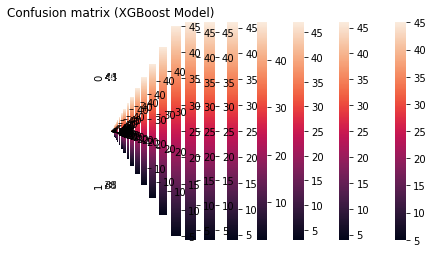

In [32]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import optuna
import shap
import xgboost as xgb

# Initialize variables to store results
shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50


for i in range(n_iterations):
    # Step 2: Initial sampling
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])

    # Test data
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # Train data
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train = remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    # Modelling 
    # Creating and running our optimization
    study_xgb = optuna.create_study(direction='maximize', study_name="XGBoost")
    with parallel_backend('threading'):
        study_xgb.optimize(objective_xgb, n_trials=10, n_jobs=-1)

    # Evaluating our Optuna Trial
    print("Best trial:", study_xgb.best_trial.number)
    print("Best accuracy:", study_xgb.best_trial.value)
    print("Best hyperparameters:", study_xgb.best_params)

    # Train the best model
    best_param_xgb = study_xgb.best_params
    XGB = xgb.XGBClassifier(**best_param_xgb, random_state=42, use_label_encoder=False, eval_metric='logloss')
    
    XGB.fit(x_train_, y_train)
    y_pred_xgb = XGB.predict(x_test_)

    # Display results
    display_results(y_test, y_pred_xgb, cm_title="Confusion matrix (XGBoost Model)")

    # SHAP value computation using TreeExplainer
    explainer = shap.TreeExplainer(XGB)
    shap_values = explainer.shap_values(x_test_)

    # Extract SHAP values for class 1 (assuming binary classification)
    shap_values_array = abs(shap_values)  # Use index 1 for the minority class

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)

In [33]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]



In [34]:
# Call the add_to_df function to populate valuestability
add_to_df()
valuestability

cv = valuestability.sum(axis=1) / valuestability.shape[1]
valuestability['CV'] = cv

# Save the DataFrame to an Excel file
valuestability.to_excel('20_xg_valuestability.xlsx', index=False)
valuestability

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,CV
0,0.838907,0.355451,0.739255,0.431025,0.756562,0.517675,0.315418,0.337781,0.536509
1,0.901919,0.262116,0.806515,0.589374,0.209872,0.355623,0.556881,0.338673,0.502622
2,0.715160,0.223952,0.756423,0.373223,0.523169,0.402424,0.579836,0.353302,0.490936
3,0.729797,0.379953,0.612038,0.335455,0.231111,0.496444,0.495470,0.286809,0.445885
4,0.649763,0.322150,0.537187,0.443623,0.381598,0.294159,0.466155,0.364814,0.432431
...,...,...,...,...,...,...,...,...,...
95,0.815285,0.425976,0.488318,0.459932,0.984721,0.408097,0.455206,0.461055,0.562324
96,0.823300,0.252712,0.743222,0.795731,0.279970,0.311363,0.728811,0.343189,0.534787
97,1.067412,0.239065,0.906121,0.747027,0.299647,0.684029,0.570872,0.248568,0.595343
98,0.467832,0.421084,0.588401,0.556854,0.207508,0.908631,0.411208,0.331898,0.486677
